In [1]:
import numpy as np
import torch
import torch.nn.functional as f
import torch.nn as nn
import torch.optim as optim

from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader

import pandas as pd
import matplotlib.pyplot as plt
import itertools
import torch.nn.functional as F
import time

In [2]:
# Configuration variables with explanations
MNIST_SAMPLE_PERCENTAGE = 0.06667
MNIST_TOTAL_SAMPLES = 60000
MNIST_NUM_SAMPLES = int(MNIST_TOTAL_SAMPLES * MNIST_SAMPLE_PERCENTAGE)
MNIST_IMAGE_SIZE = 28
MNIST_RESIZED_IMAGE_SIZE = 24
MNIST_BATCH_SIZE = 128
MNIST_NUM_CLASSES = 10
MNIST_GRAY_CODE_BASE = 2
MNIST_GRAY_CODE_DIGITS = 28
CNN_CONV1_OUTPUT_CHANNELS = 16
CNN_CONV2_OUTPUT_CHANNELS = 32
CNN_FC1_OUTPUT_FEATURES = 512
CNN_FC2_OUTPUT_FEATURES = MNIST_NUM_CLASSES
CNN_FC_INPUT_FEATURES = 512
LEARNING_RATE = 0.0001
EPOCHS = 250
PATCH_SIZE = 3
GRID_SIZE = 8
MNIST_CLASS_ONE_HOT_SIZE = 2
LOG_FILE_PATH = './log.csv'
MNIST_PATH = './data'
MNIST_TRAIN = True
MNIST_DOWNLOAD = True
CLASSIFICATION_LOSS_WEIGHT = 0.01

MODEL_NAME = "FCN"
DATASET_NAME = "MNIST"
FINAL_MODEL_NAME = f"{DATASET_NAME}_{MODEL_NAME}"
MODEL_PATH = f"{MNIST_SAMPLE_PERCENTAGE}_{FINAL_MODEL_NAME}.pth"

print(MODEL_PATH)


0.06667_MNIST_FCN.pth


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cpu


In [ ]:
def grayN(base, digits, value):
  '''
    A method for producing the grayN code for the spatial index
    @base: the base for the code
    @digits: Length of the code - should be equal to the output size of the model
    @value: the value to encode
  '''
  # Initialize the tensor for base-N representation of the value
  baseN = torch.zeros(digits)
  # Initialize the tensor for Gray code representation
  gray = torch.zeros(digits)

  # Convert the input value to base-N representation
  for i in range(0, digits):
      baseN[i] = value % base
      value = value // base

  # Convert base-N representation to Gray code representation
  shift = 0
  while i >= 0:
    gray[i] = (baseN[i] + shift) % base
    shift = shift + base - gray[i]
    i -= 1
  return gray

In [ ]:
def mnist(percentage):
  n_samples = int(MNIST_TOTAL_SAMPLES * percentage)

  # Load the MNIST datase
  train_data = datasets.MNIST(MNIST_PATH, train=MNIST_TRAIN, download=MNIST_DOWNLOAD)
  x_train = train_data.data.reshape(MNIST_TOTAL_SAMPLES, MNIST_IMAGE_SIZE**2)
  x_train = x_train[:n_samples]
  y_train = train_data.targets
  y_train = y_train[:n_samples]
  print(len(x_train))
  return x_train, y_train

In [ ]:
class MNIST_Mem_Dataset(Dataset):
    def __init__(self, percentage, device):
        data, labels = mnist(percentage)
        self.data = data.view(data.size(0), 1, MNIST_IMAGE_SIZE, MNIST_IMAGE_SIZE)
        self.target_images = f.interpolate(self.data, (MNIST_RESIZED_IMAGE_SIZE, MNIST_RESIZED_IMAGE_SIZE))
        self.gray_codes = torch.zeros(self.target_images.size(0), MNIST_GRAY_CODE_DIGITS)
        self.class_codes = torch.zeros(self.target_images.size(0), MNIST_GRAY_CODE_DIGITS)
        self.device = device

        self.channel_patch_combinations = list(itertools.product(range(int(MNIST_SAMPLE_PERCENTAGE*60000)), range(0, GRID_SIZE), range(0, GRID_SIZE)))

        # Generate Gray codes for the dataset
        with torch.no_grad():
            for idx in range(self.target_images.size(0)):
                label_one_hot = torch.zeros(MNIST_GRAY_CODE_DIGITS)
                label_one_hot[int(labels[idx])] = 1

                self.gray_codes[idx, ] = grayN(MNIST_GRAY_CODE_BASE, 28, idx)
                self.class_codes[idx,] = label_one_hot

    def __len__(self):
        return len(self.channel_patch_combinations)


    def __getitem__(self, index):
        with torch.no_grad():
            index , row , col = self.channel_patch_combinations[index]
            # print(f" index : {index} , row: {row} , col: {col}")
            input = torch.zeros(1, MNIST_IMAGE_SIZE, MNIST_IMAGE_SIZE)
            input[:, MNIST_IMAGE_SIZE-2] = self.gray_codes[index]
            input[:, MNIST_IMAGE_SIZE-1] = self.class_codes[index]


            # Set the patch to 1 in the input
            input[:, row*PATCH_SIZE:(row+1)*PATCH_SIZE, col*PATCH_SIZE:(col+1)*PATCH_SIZE] = 1

            # Get the corresponding target patch from the target image
            path = self.target_images[index, :, row*PATCH_SIZE:(row+1)*PATCH_SIZE, col*PATCH_SIZE:(col+1)*PATCH_SIZE]


            img = input.float().to(self.device)
            target = (path.float()/255).to(self.device)

           # # Visualization of each channel
           #  plt.figure(figsize=(5, 5))
           #  plt.imshow(img[0].cpu(), cmap='gray', vmin=0, vmax=1)
           #  plt.title('Input Image')
           #  plt.axis('off')
           #  plt.show()
        return img, target

In [ ]:
mem_dataset = MNIST_Mem_Dataset(MNIST_SAMPLE_PERCENTAGE, device)
mem_dataloader = DataLoader(mem_dataset, pin_memory=False, batch_size=MNIST_BATCH_SIZE, shuffle=True)


train_dataset = datasets.MNIST(MNIST_PATH, train=True, download=MNIST_DOWNLOAD, transform=transforms.ToTensor())
train_loader_cls = DataLoader(train_dataset, pin_memory=False, batch_size=MNIST_BATCH_SIZE, shuffle=True)
TRAIN_DATASET_LEN = len(train_loader_cls.dataset)

test_dataset = datasets.MNIST(MNIST_PATH, train=False, download=MNIST_DOWNLOAD, transform=transforms.ToTensor())
test_loader_cls = DataLoader(test_dataset, pin_memory=False, batch_size=MNIST_BATCH_SIZE, shuffle=False)

4000


In [ ]:
print("Size of mem_dataset:", len(mem_dataset))
print("Size of train_dataset:", len(train_dataset))
print("Size of test_dataset:", len(test_dataset))

Size of mem_dataset: 256000
Size of train_dataset: 60000
Size of test_dataset: 10000


In [ ]:
mem_dataset.__getitem__(324)

(tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

In [ ]:
class FCModel(nn.Module):
    def __init__(self, input_shape, hidden_size, n_layers, output_shape):
        super(FCModel, self).__init__()
        self.input_layer = nn.Linear(input_shape, hidden_size)

        # Create hidden layers
        hidden_layers = []
        for _ in range(n_layers):
            hidden_layers.append(nn.Linear(hidden_size, hidden_size))
            hidden_layers.append(nn.ReLU())

        self.hidden_layers = nn.Sequential(*hidden_layers)
        self.output_layer = nn.Linear(hidden_size, output_shape)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input tensor
        x = torch.relu(self.input_layer(x))
        x = self.hidden_layers(x)
        x = self.output_layer(x)
        return x

In [ ]:
model = FCModel(input_shape=28*28, hidden_size=1024, n_layers=3, output_shape=10).to(device)
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.01)

In [ ]:
model

FCModel(
  (input_layer): Linear(in_features=784, out_features=1024, bias=True)
  (hidden_layers): Sequential(
    (0): Linear(in_features=1024, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=1024, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1024, out_features=1024, bias=True)
    (5): ReLU()
  )
  (output_layer): Linear(in_features=1024, out_features=10, bias=True)
)

In [ ]:
def get_image(idx, model,device):
    gray = mem_dataset.gray_codes[idx]
    idx_class = mem_dataset.class_codes[idx]
    target_image = mem_dataset.target_images[idx]

    batch = []

    for row in range(GRID_SIZE):
        for col in range(GRID_SIZE):
            input = torch.zeros(1, MNIST_IMAGE_SIZE, MNIST_IMAGE_SIZE)

            input[:, MNIST_IMAGE_SIZE-2] = gray
            input[:, MNIST_IMAGE_SIZE-1] = idx_class

            input[:, row*PATCH_SIZE:(row+1)*PATCH_SIZE, col*PATCH_SIZE:(col+1)*PATCH_SIZE] = 1
            batch.append(input.float().to(device).unsqueeze(0))

    model.eval()
    with torch.no_grad():
        batch = torch.cat(batch)
        outs = model(batch)[:, :PATCH_SIZE**2].view(batch.size(0), PATCH_SIZE, PATCH_SIZE)

    out_image = torch.zeros(1, 1, MNIST_RESIZED_IMAGE_SIZE, MNIST_RESIZED_IMAGE_SIZE)
    for row in range(GRID_SIZE):
        for col in range(GRID_SIZE):
            out_image[0, :, row*PATCH_SIZE:(row+1)*PATCH_SIZE, col*PATCH_SIZE:(col+1)*PATCH_SIZE] = outs[row*GRID_SIZE + col]
    model.train()
    return f.interpolate(out_image, (MNIST_RESIZED_IMAGE_SIZE, MNIST_RESIZED_IMAGE_SIZE)).cpu().squeeze(0).squeeze(0), target_image.squeeze(0)

In [ ]:
def visualize_results(model, device, num_images=10):
    fig, axs = plt.subplots(2, num_images, figsize=(25, 5))
    for i in range(num_images):
        output_image, target_image = get_image(i, model, device)
        target_image = target_image / 255.0
        axs[0, i].imshow(target_image.cpu(), cmap='gray')
        axs[0, i].set_title(f'Original {i+1}')
        axs[0, i].axis('off')
        axs[1, i].imshow(output_image.cpu(), cmap='gray')
        axs[1, i].set_title(f'Memorized {i+1}')
        axs[1, i].axis('off')
    plt.show()

In [ ]:
def calculate_accuracy(outputs, labels):
    _, predicted = torch.max(outputs.data, 1)
    total = labels.size(0)
    correct = (predicted == labels).sum().item()
    return correct / total

In [ ]:
def train(model, train_loader_cls, mem_dataloader, optimizer, epochs, device):
    # Define the loss functions. CrossEntropyLoss for classification and MSELoss for memorization.
    ce_loss = nn.CrossEntropyLoss()
    mse_loss = nn.MSELoss()
    mae_loss = nn.L1Loss()

    # Initialize a list to store training statistics for each epoch.
    log = []

    # Create an iterator for the memorization dataloader.
    mem_iterator = iter(mem_dataloader)
    best_mem_loss = float('inf')

    training_start_time = time.time()

    cls_losses = []
    mem_losses = []

    # Training loop for the specified number of epochs.
    for epoch in range(epochs):
        start_time = time.time()
        # Initialize statistics for the current epoch.
        epoch_stats = {'mem_loss': 0, 'cls_loss': 0, 'accuracy': 0, 'counter': 0}

        # Loop over the classification data loader.
        for (data, cls_labels) in train_loader_cls:
            try:
                # Get a batch from the memorization data loader.
                codes, mem_targets = next(mem_iterator)
            except StopIteration:
                # Restart the memorization data loader if it runs out of data.
                mem_iterator = iter(mem_dataloader)
                (codes, mem_targets) = next(mem_iterator)

            # Zero the gradients computed in the previous iteration.
            optimizer.zero_grad()

            # Forward pass for the classification task.
            data , cls_labels = data.to(device), cls_labels.to(device)
            codes, mem_targets = codes.to(device), mem_targets.to(device)

            # Forward pass for the memorization task.
            mem_outputs = model(codes.to(device))[:, :PATCH_SIZE**2]


            # Compute the classification loss.
            cls_outputs = model(data)
            cls_loss = CLASSIFICATION_LOSS_WEIGHT * ce_loss(cls_outputs, cls_labels)

            # Compute the memorization loss.target_channel)target_channel)
            mem_mse_loss = mse_loss(mem_outputs, mem_targets.view(mem_targets.size(0), -1).to(device))
            mem_mae_loss = mae_loss(mem_outputs, mem_targets.view(mem_targets.size(0), -1).to(device))
            mem_loss = mem_mse_loss+mem_mae_loss

            # Combine the losses.
            loss = cls_loss + mem_loss

            # Backpropagate the loss.
            loss.backward()

            # Update the model's parameters.
            optimizer.step()

            acc = calculate_accuracy(cls_outputs, cls_labels)
            # Update epoch statistics.
            epoch_stats['mem_loss'] += mem_loss.item()
            epoch_stats['cls_loss'] += cls_loss.item()
            epoch_stats['accuracy'] += acc
            epoch_stats['counter'] += 1

        # Calculate the average losses for the current epoch.
        epoch_stats['cls_loss'] = epoch_stats['cls_loss'] / epoch_stats['counter']
        epoch_stats['mem_loss'] = epoch_stats['mem_loss'] / epoch_stats['counter']
        epoch_stats['accuracy'] /= epoch_stats['counter']
        epoch_duration = time.time() - start_time

        # Print the statistics for the current epoch.
        print('Epoch {} | Train loss {:4f} | Memorization loss {:4f}'.format(epoch, epoch_stats['cls_loss'], epoch_stats['mem_loss']))

        if epoch_stats['mem_loss'] < best_mem_loss:
            best_mem_loss = epoch_stats['mem_loss']
            torch.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
            }, MODEL_PATH)
            print(f'Saved model and optimizer with memorization loss: {best_mem_loss:.4f}')

        # Append the statistics for the current epoch to the log.
        log.append(epoch_stats)
        if (epoch + 1) % 1 == 0:
            print(f'Visualizing results at Epoch {epoch + 1}')
            visualize_results(model, device)

        log.append(epoch_stats)
        cls_losses.append(epoch_stats['cls_loss'])
        mem_losses.append(epoch_stats['mem_loss'])

    total_training_time = time.time() - training_start_time
    hours, remainder = divmod(total_training_time, 3600)
    minutes, seconds = divmod(remainder, 60)
    print(f'Total training time: {int(hours):02}:{int(minutes):02}:{int(seconds):02} (hh:mm:ss)')

    pd.DataFrame(log).to_csv(LOG_FILE_PATH, index=False)

Epoch 0 | Train loss 0.010516 | Memorization loss 0.202131
Saved model and optimizer with memorization loss: 0.2021
Visualizing results at Epoch 1


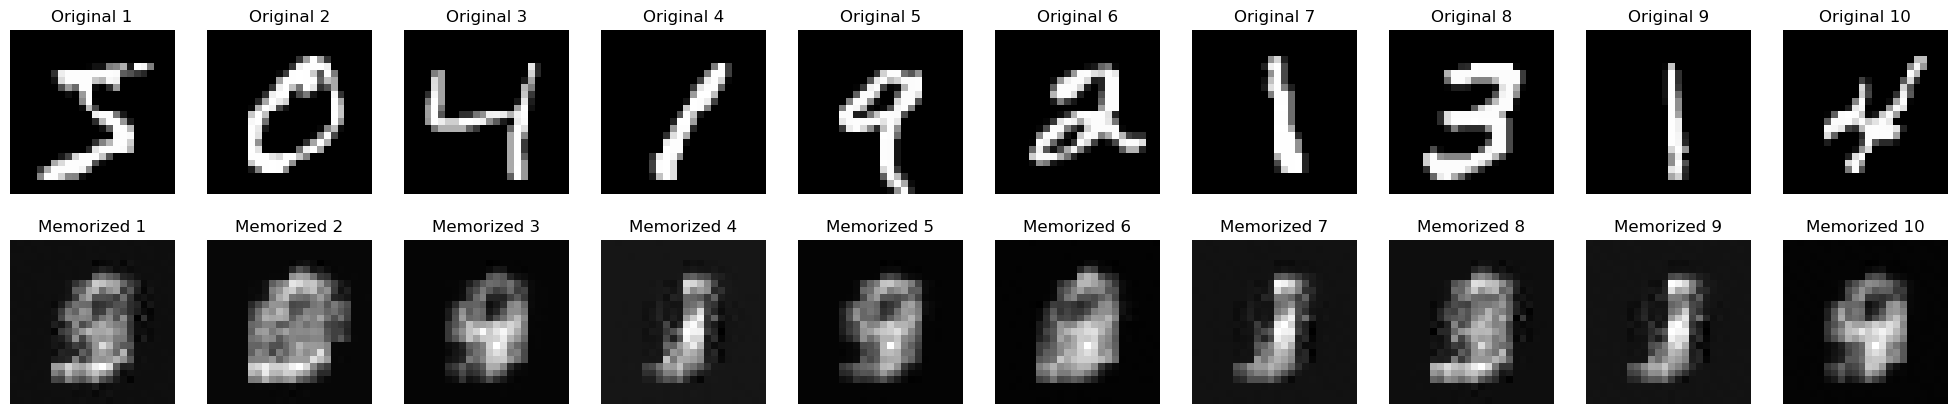

Epoch 1 | Train loss 0.003042 | Memorization loss 0.172340
Saved model and optimizer with memorization loss: 0.1723
Visualizing results at Epoch 2


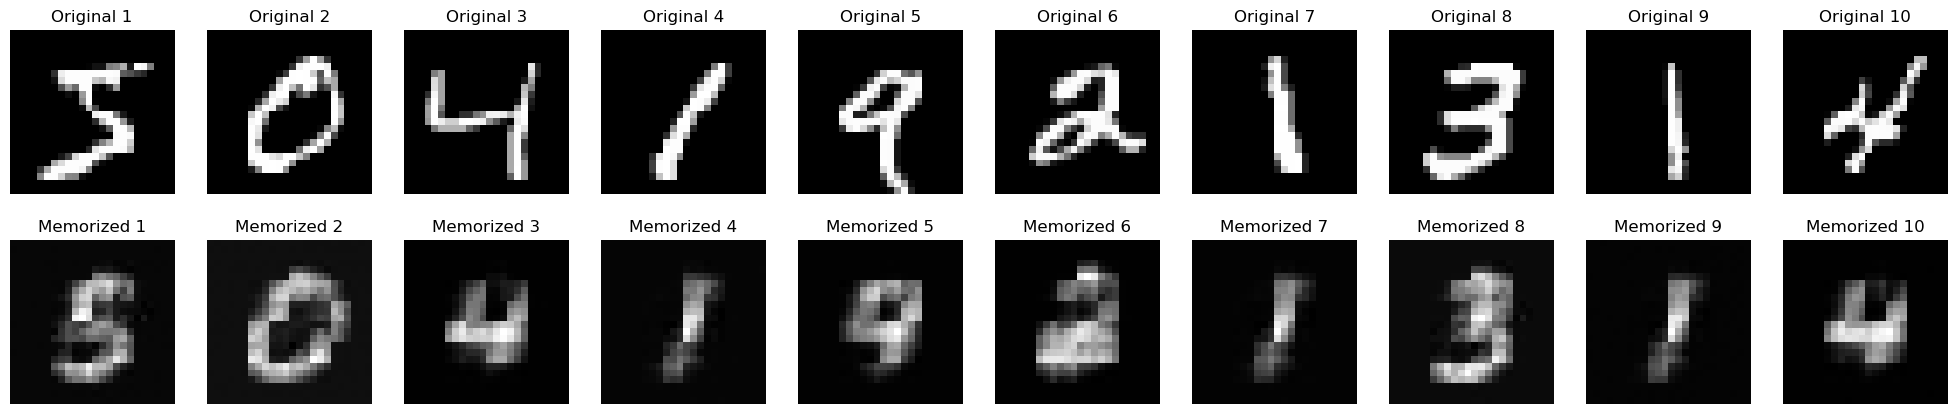

Epoch 2 | Train loss 0.002121 | Memorization loss 0.166205
Saved model and optimizer with memorization loss: 0.1662
Visualizing results at Epoch 3


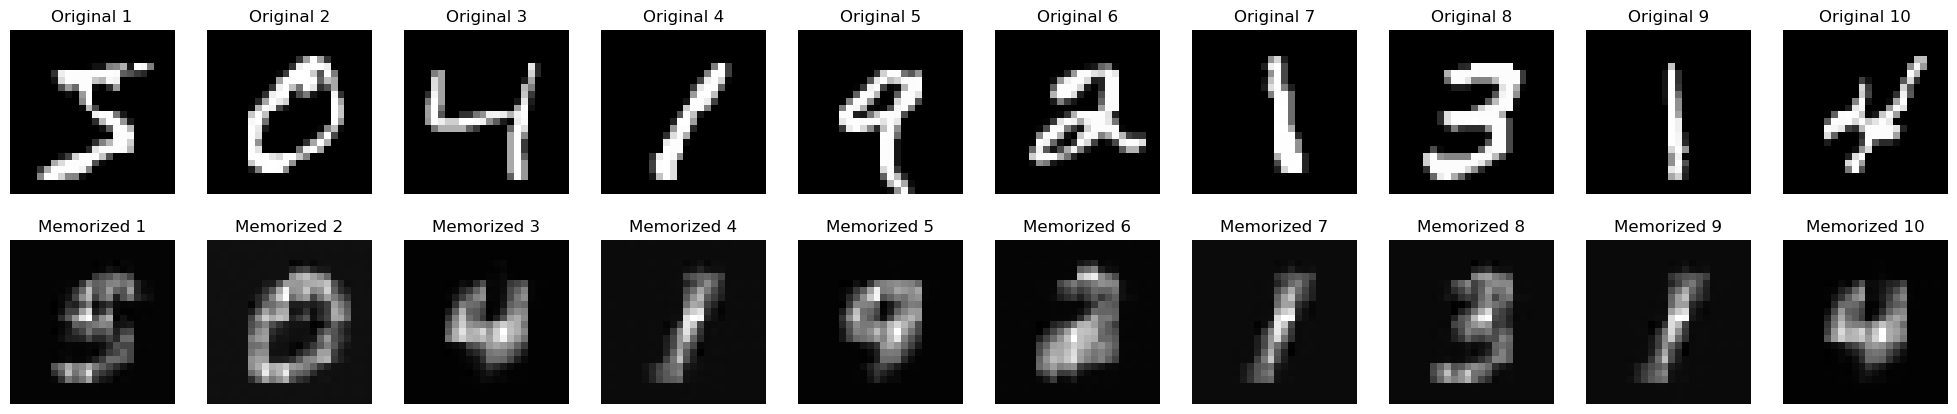

Epoch 3 | Train loss 0.001654 | Memorization loss 0.163856
Saved model and optimizer with memorization loss: 0.1639
Visualizing results at Epoch 4


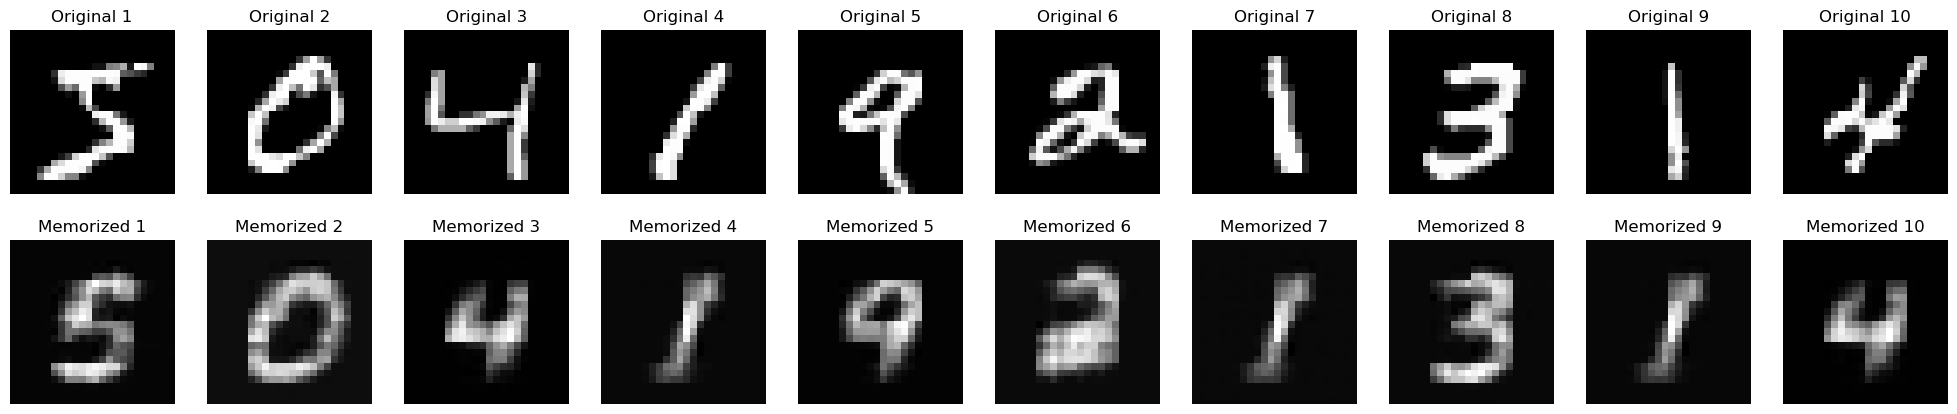

Epoch 4 | Train loss 0.001338 | Memorization loss 0.160340
Saved model and optimizer with memorization loss: 0.1603
Visualizing results at Epoch 5


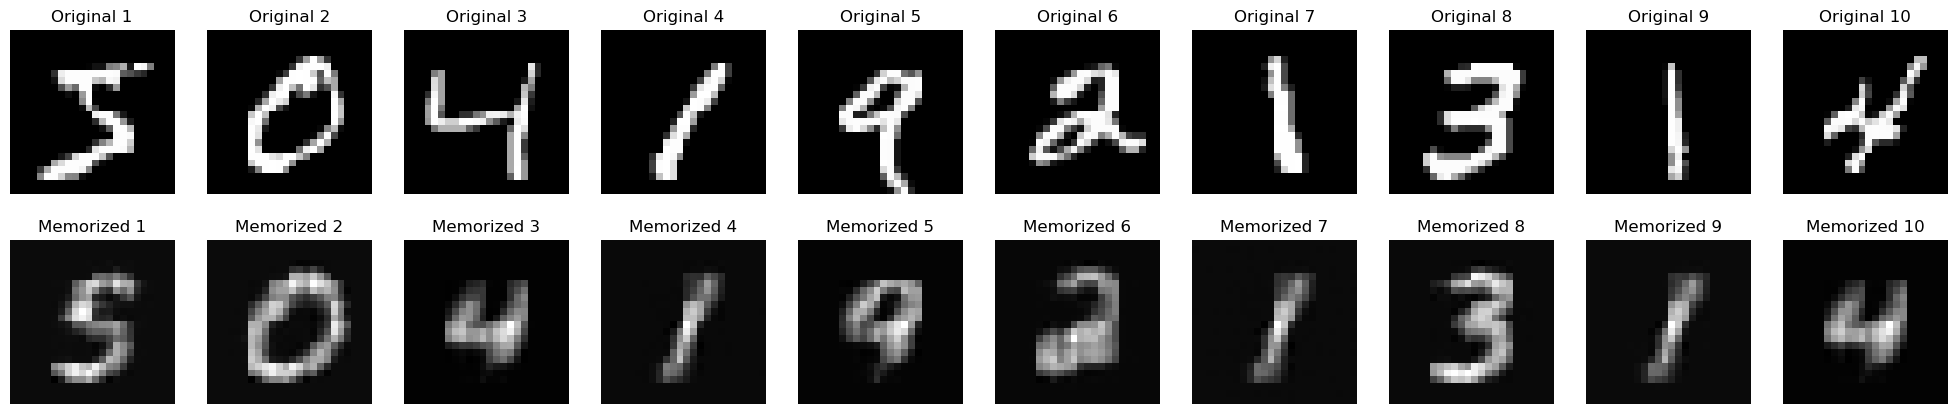

Epoch 5 | Train loss 0.001118 | Memorization loss 0.162518
Visualizing results at Epoch 6


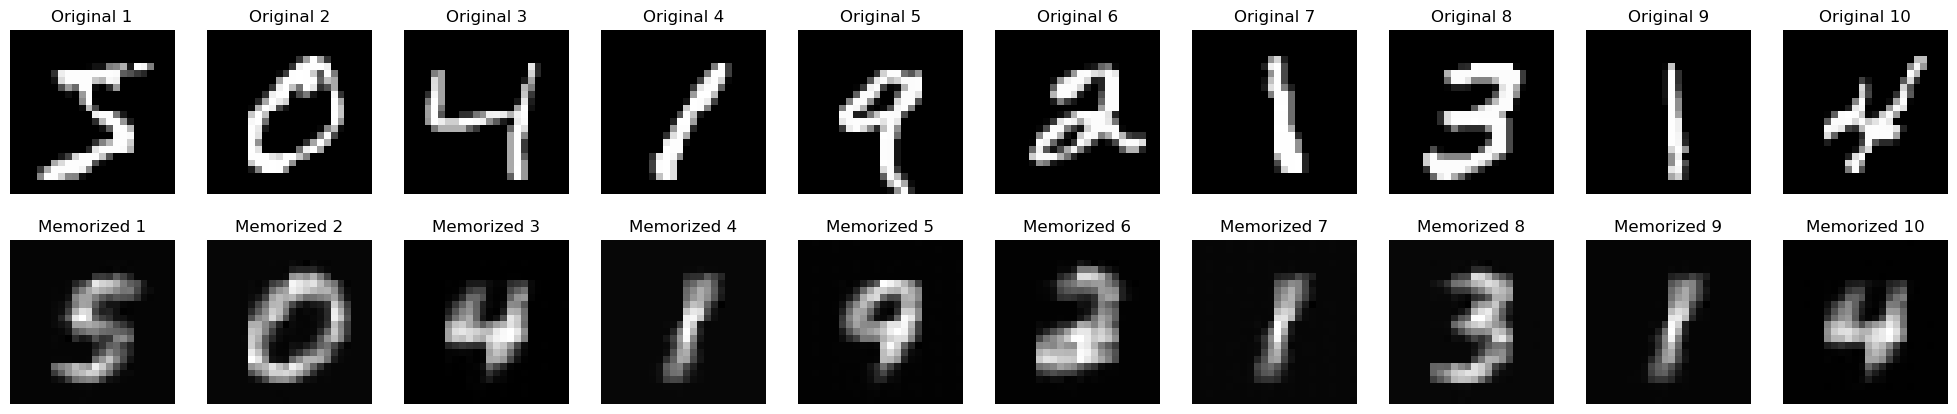

Epoch 6 | Train loss 0.000947 | Memorization loss 0.162174
Visualizing results at Epoch 7


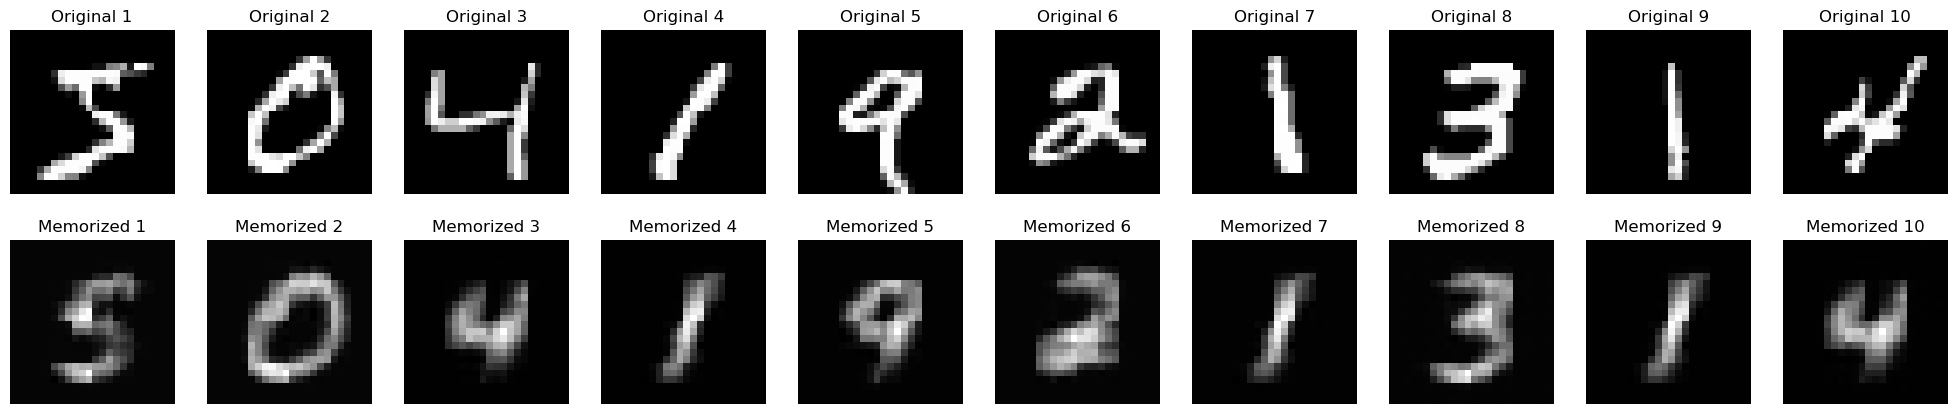

Epoch 7 | Train loss 0.000826 | Memorization loss 0.161044
Visualizing results at Epoch 8


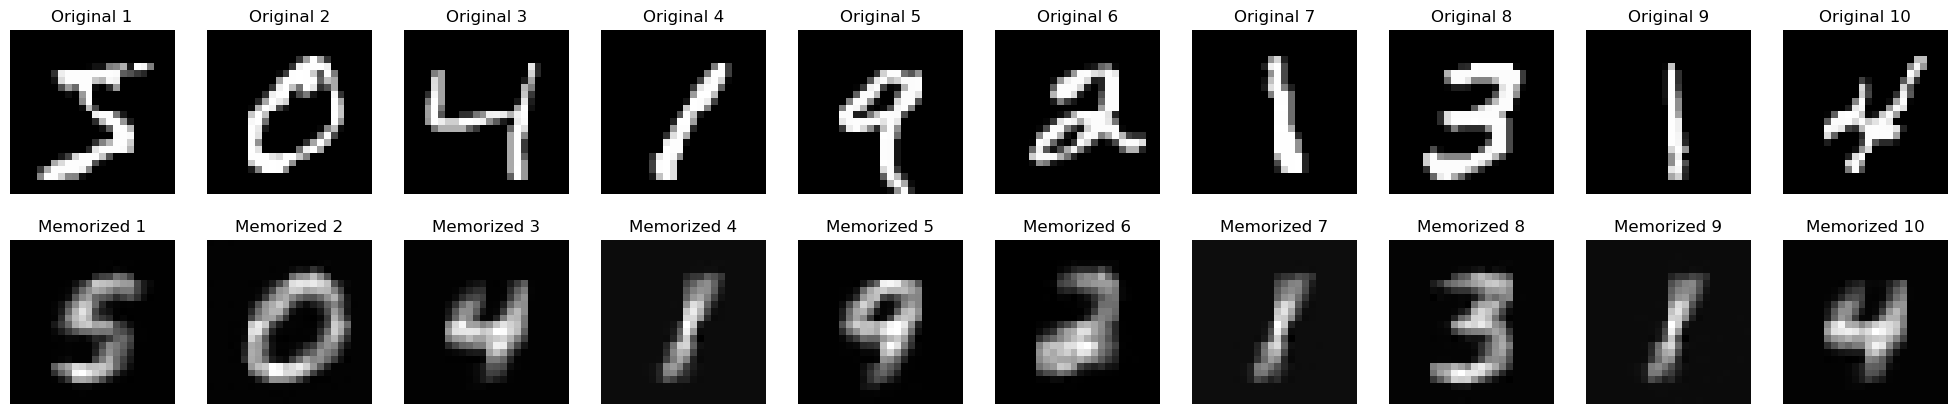

Epoch 8 | Train loss 0.000705 | Memorization loss 0.159203
Saved model and optimizer with memorization loss: 0.1592
Visualizing results at Epoch 9


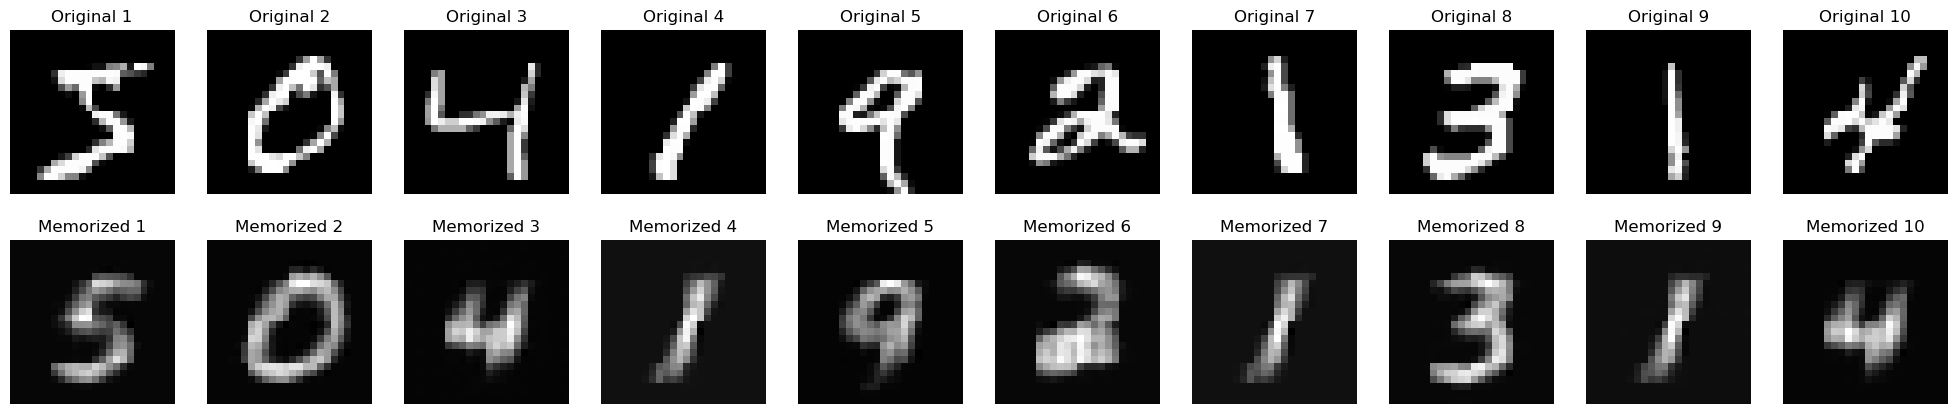

Epoch 9 | Train loss 0.000611 | Memorization loss 0.159164
Saved model and optimizer with memorization loss: 0.1592
Visualizing results at Epoch 10


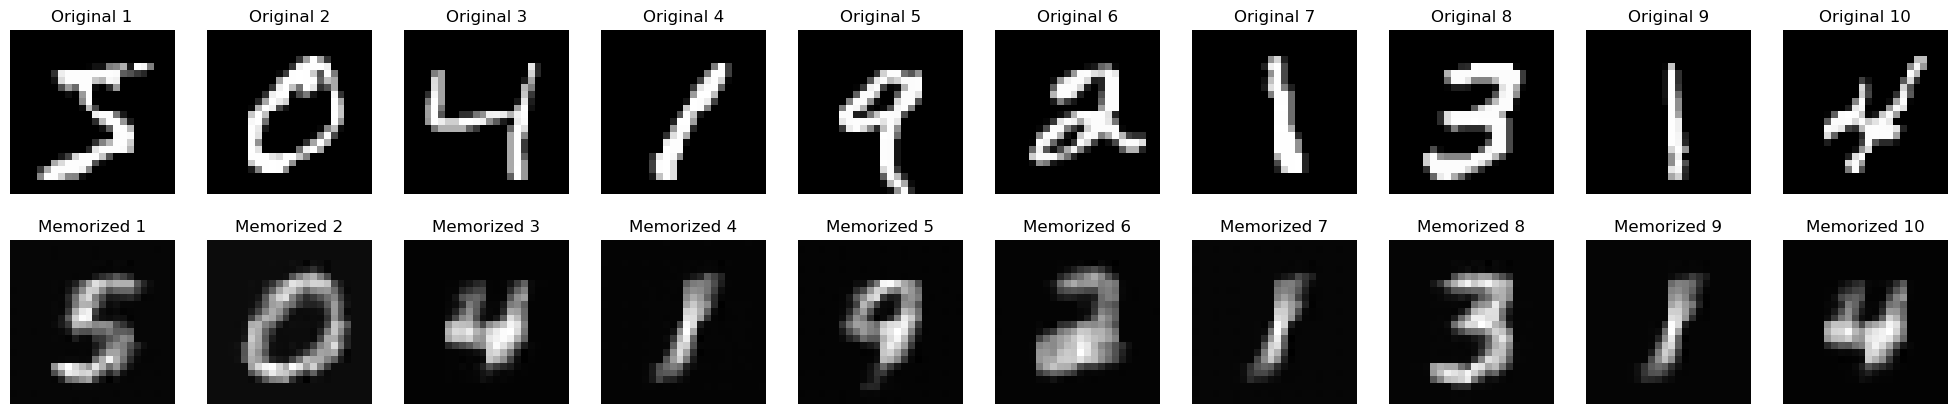

Epoch 10 | Train loss 0.000522 | Memorization loss 0.159053
Saved model and optimizer with memorization loss: 0.1591
Visualizing results at Epoch 11


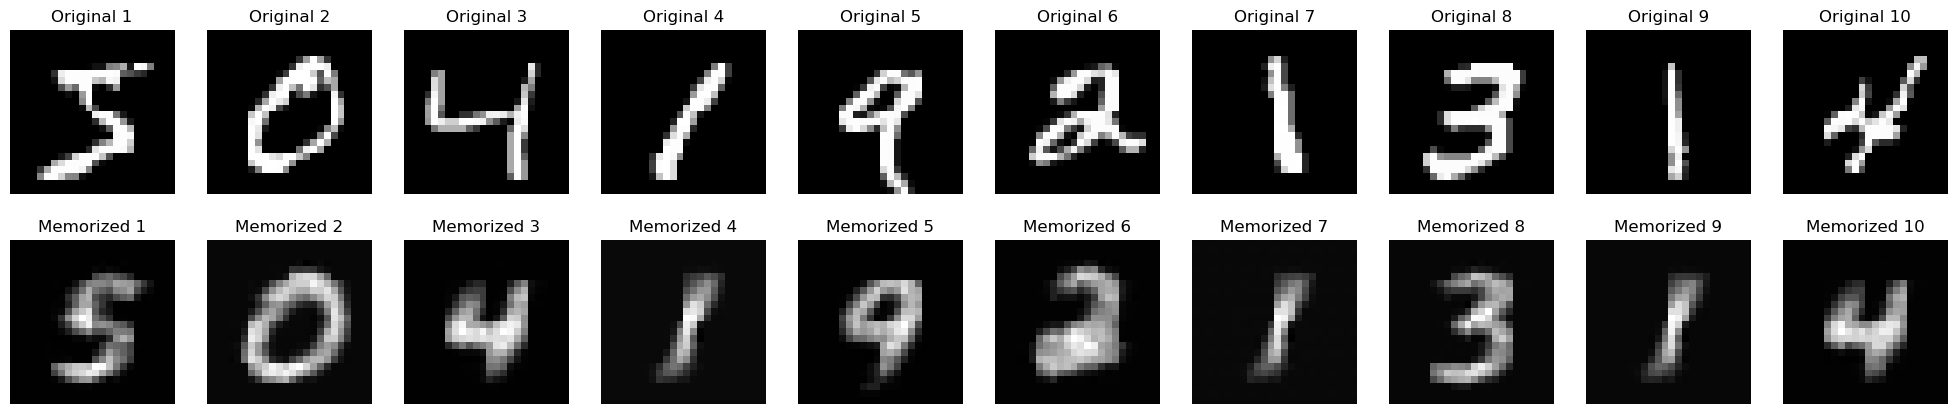

Epoch 11 | Train loss 0.000460 | Memorization loss 0.159564
Visualizing results at Epoch 12


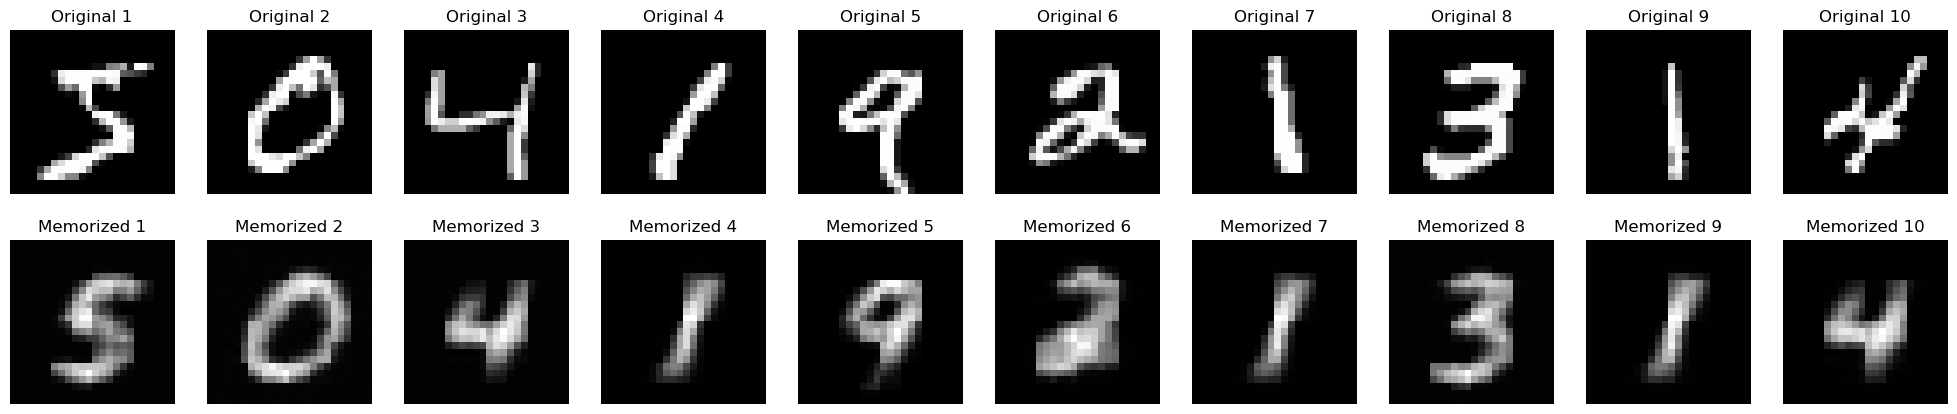

Epoch 12 | Train loss 0.000398 | Memorization loss 0.160807
Visualizing results at Epoch 13


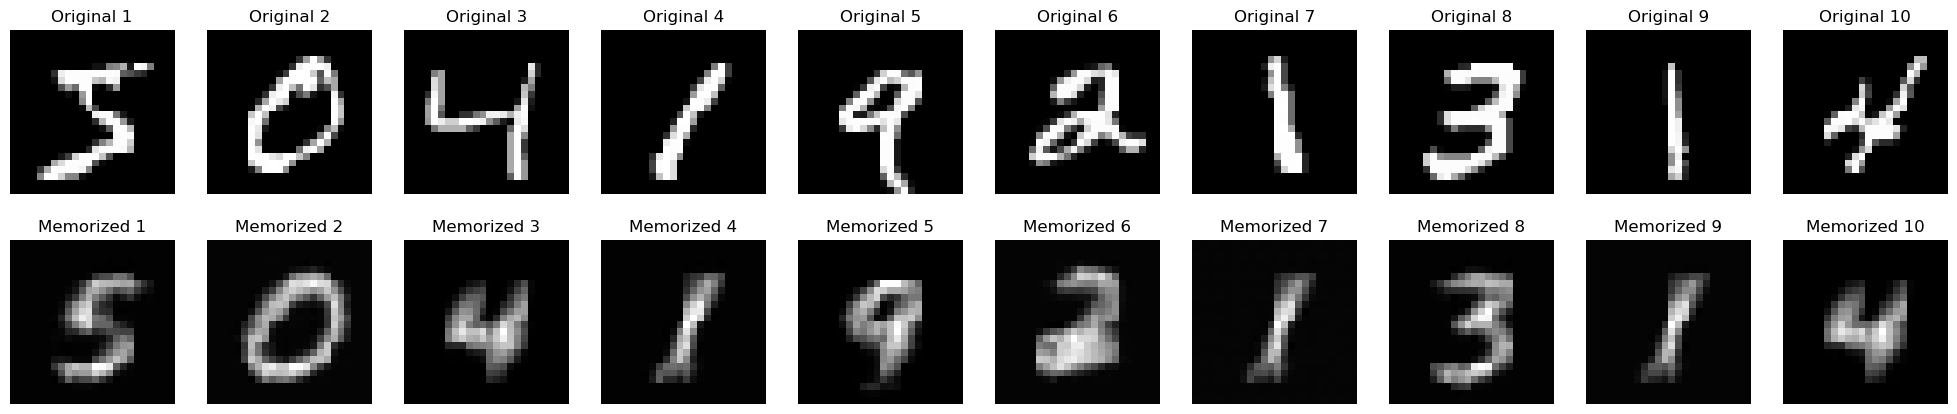

Epoch 13 | Train loss 0.000345 | Memorization loss 0.159211
Visualizing results at Epoch 14


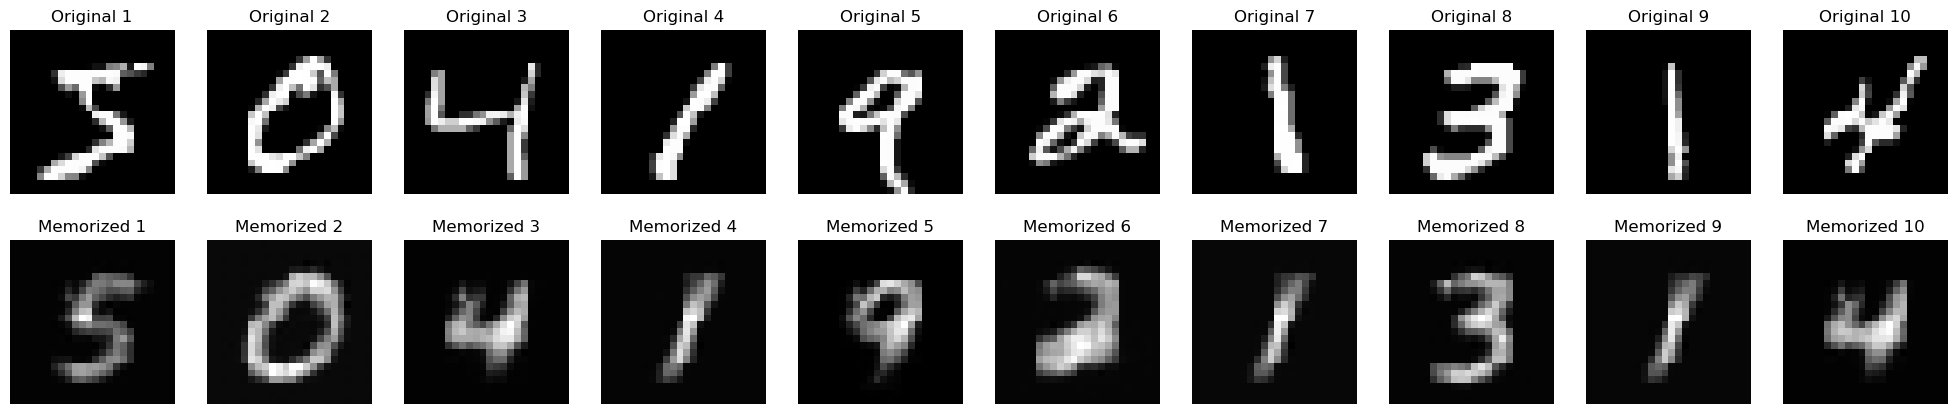

Epoch 14 | Train loss 0.000288 | Memorization loss 0.158629
Saved model and optimizer with memorization loss: 0.1586
Visualizing results at Epoch 15


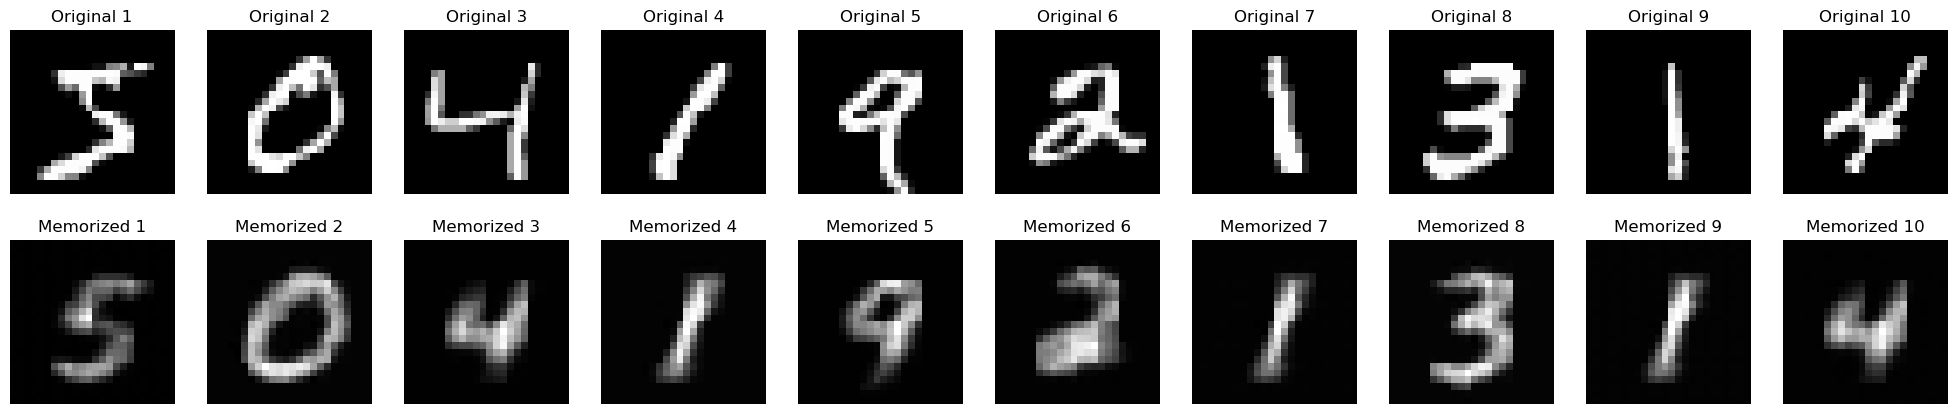

Epoch 15 | Train loss 0.000272 | Memorization loss 0.157557
Saved model and optimizer with memorization loss: 0.1576
Visualizing results at Epoch 16


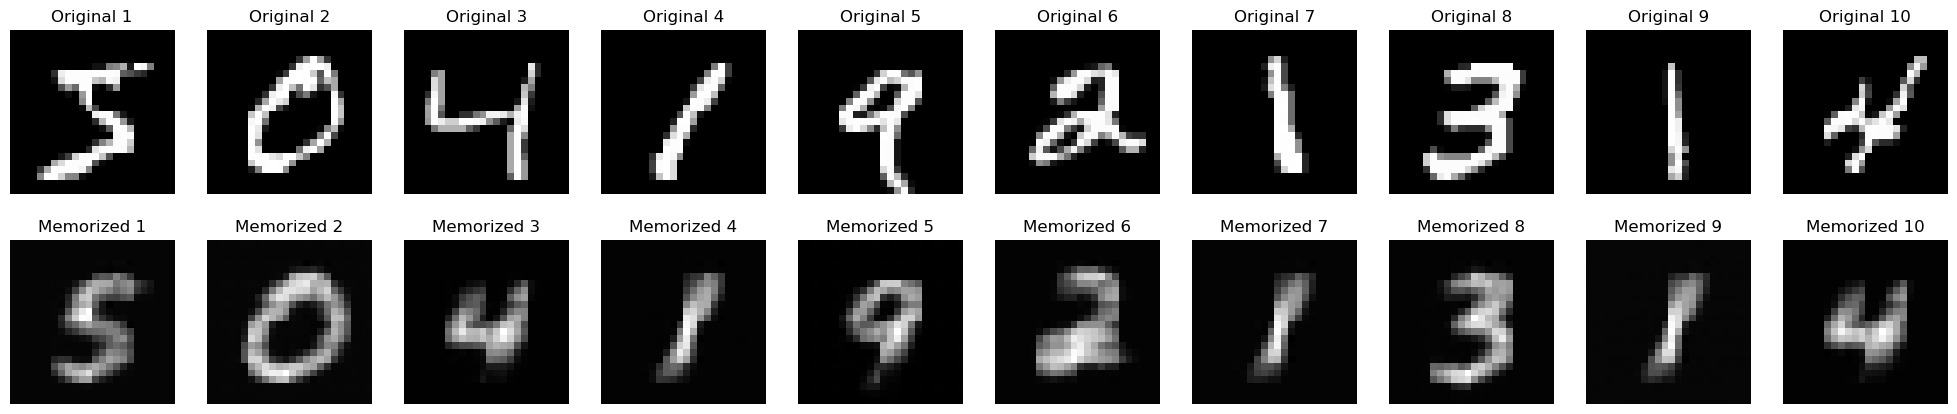

Epoch 16 | Train loss 0.000224 | Memorization loss 0.158706
Visualizing results at Epoch 17


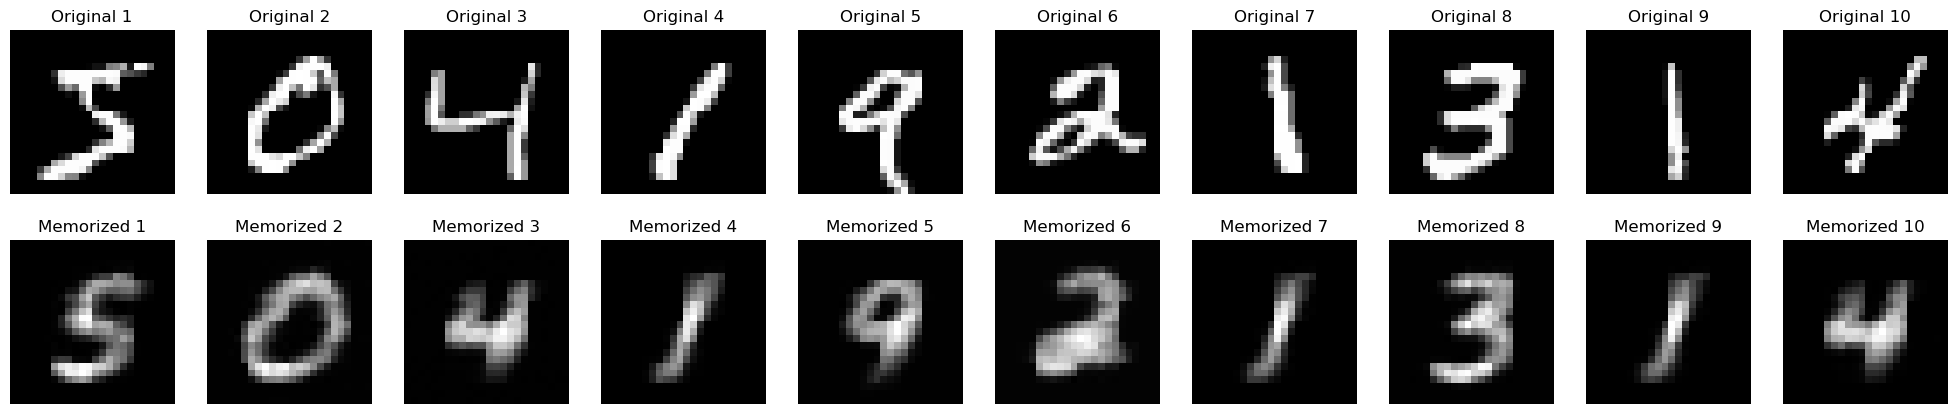

Epoch 17 | Train loss 0.000187 | Memorization loss 0.156498
Saved model and optimizer with memorization loss: 0.1565
Visualizing results at Epoch 18


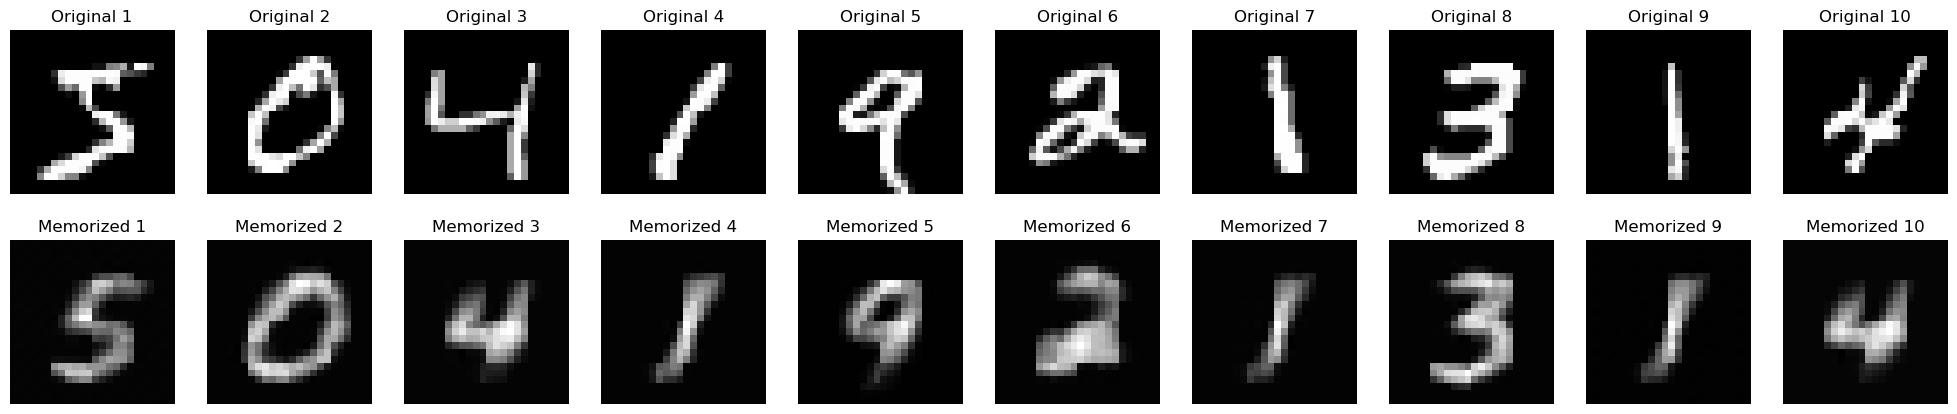

Epoch 18 | Train loss 0.000166 | Memorization loss 0.157441
Visualizing results at Epoch 19


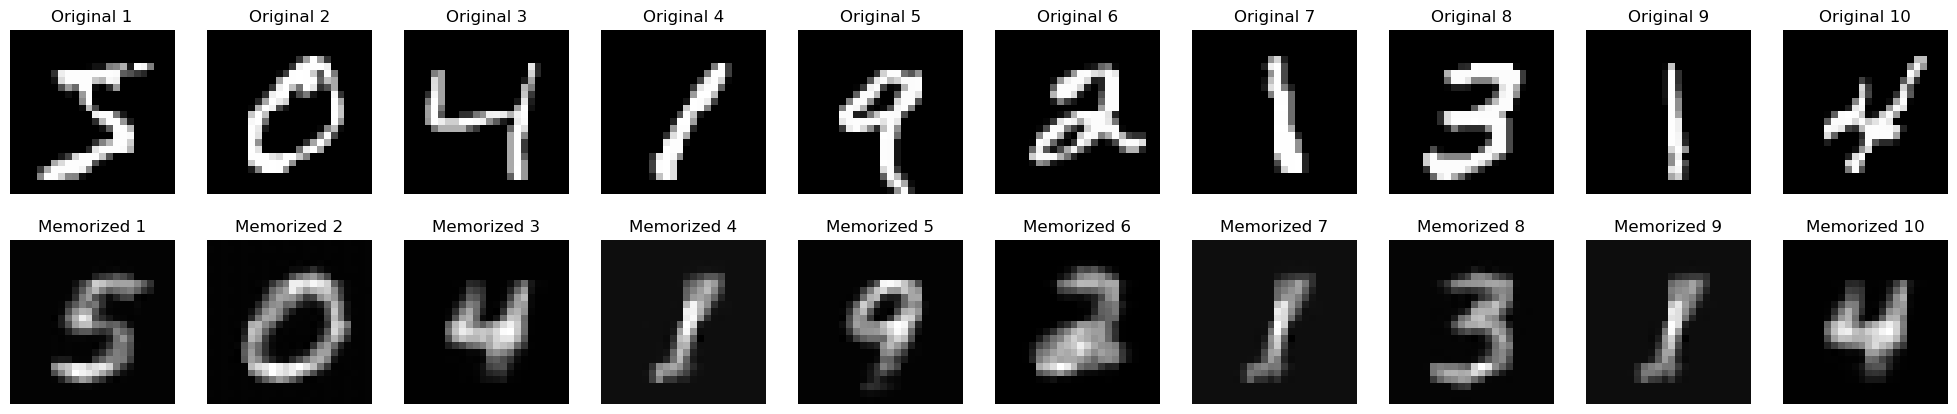

Epoch 19 | Train loss 0.000147 | Memorization loss 0.157234
Visualizing results at Epoch 20


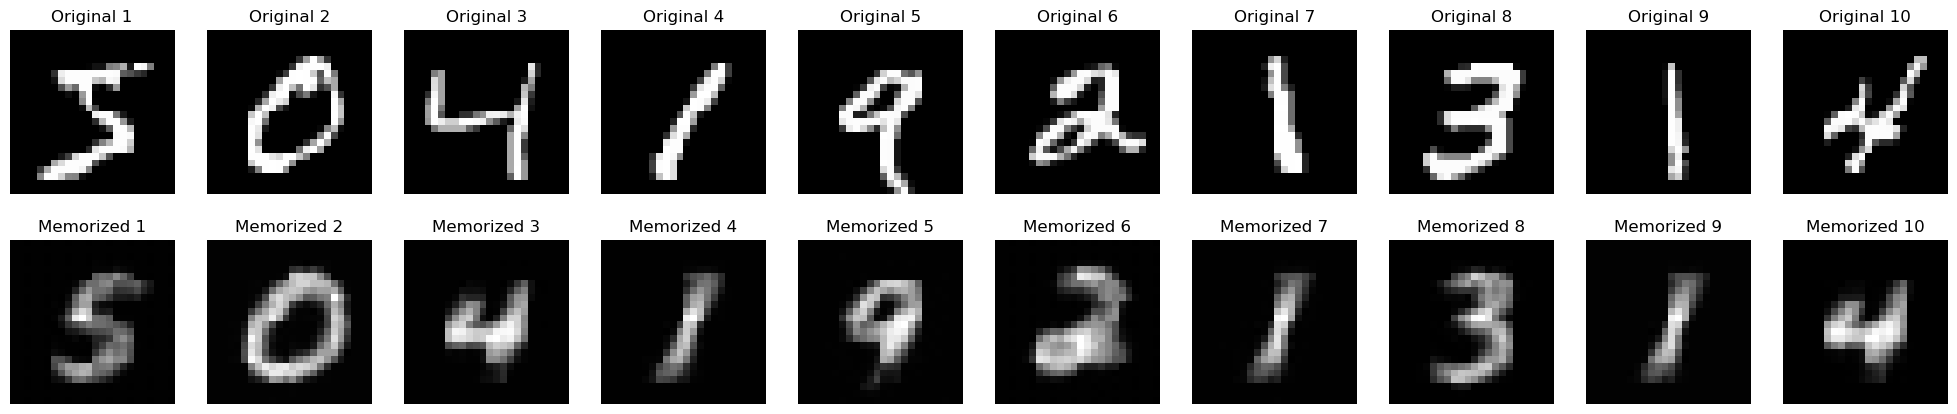

Epoch 20 | Train loss 0.000125 | Memorization loss 0.157575
Visualizing results at Epoch 21


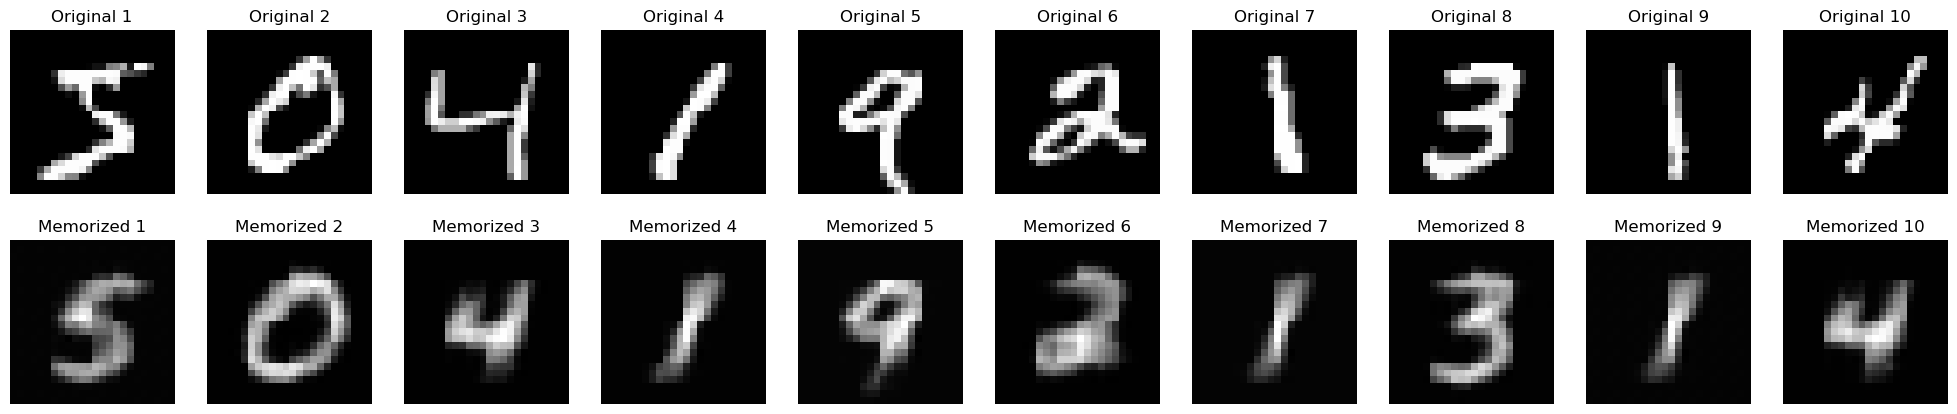

Epoch 21 | Train loss 0.000100 | Memorization loss 0.155503
Saved model and optimizer with memorization loss: 0.1555
Visualizing results at Epoch 22


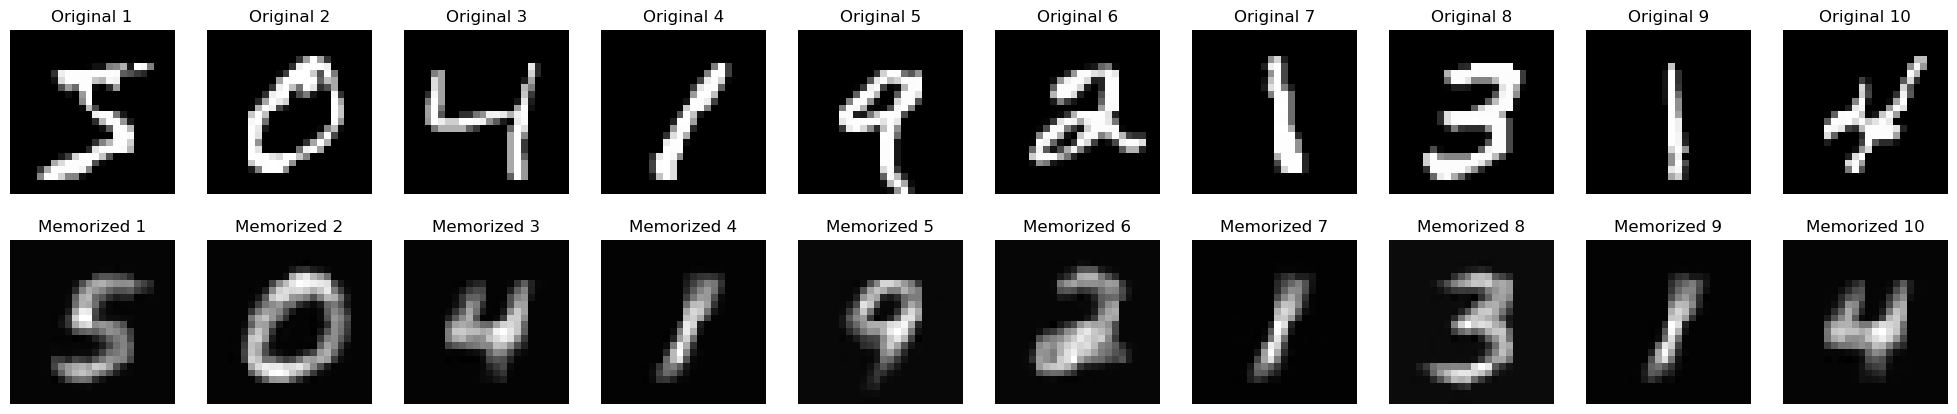

Epoch 22 | Train loss 0.000102 | Memorization loss 0.156621
Visualizing results at Epoch 23


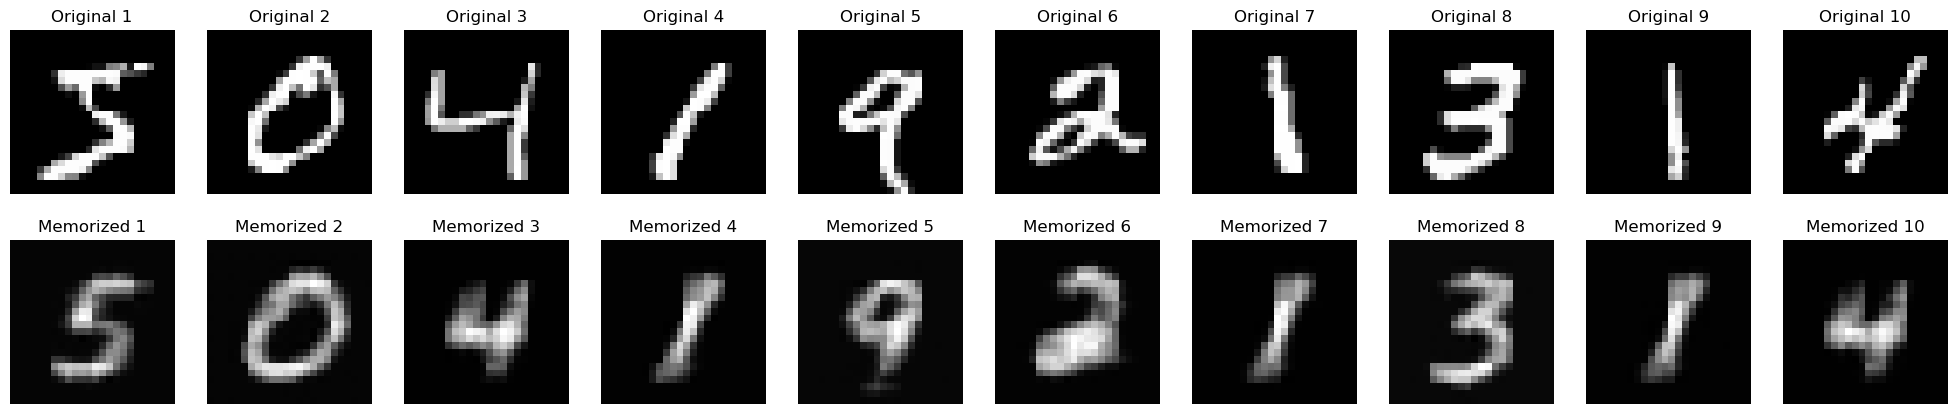

Epoch 23 | Train loss 0.000087 | Memorization loss 0.155952
Visualizing results at Epoch 24


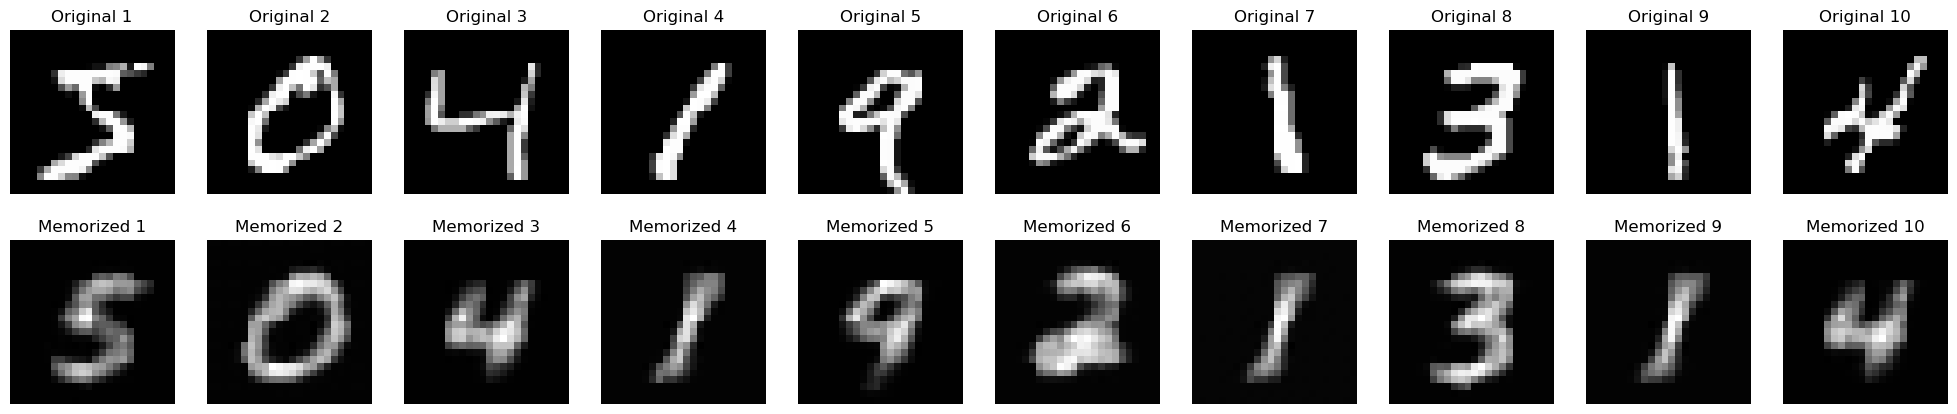

Epoch 24 | Train loss 0.000078 | Memorization loss 0.155810
Visualizing results at Epoch 25


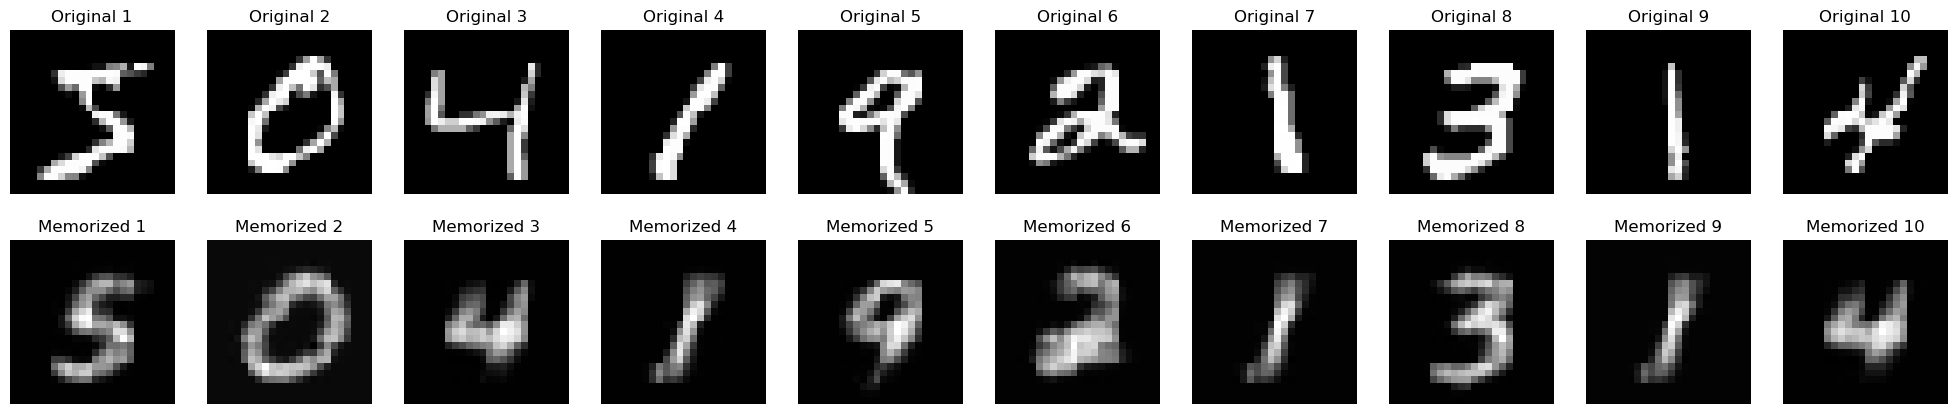

Epoch 25 | Train loss 0.000060 | Memorization loss 0.155738
Visualizing results at Epoch 26


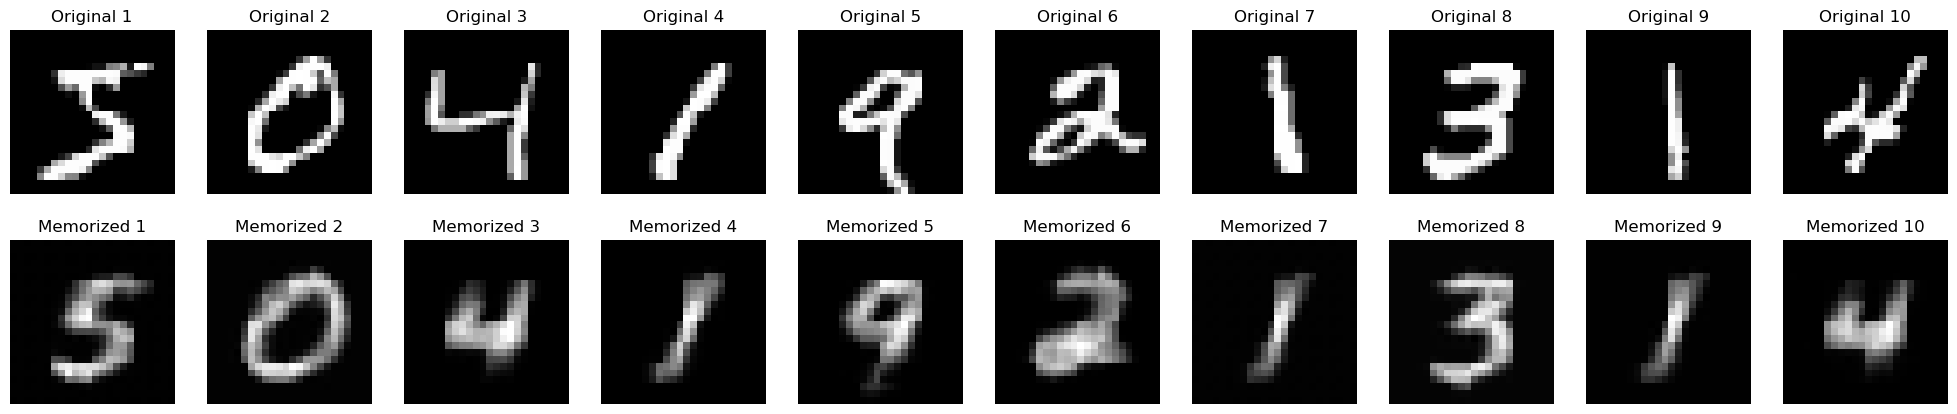

Epoch 26 | Train loss 0.000053 | Memorization loss 0.156513
Visualizing results at Epoch 27


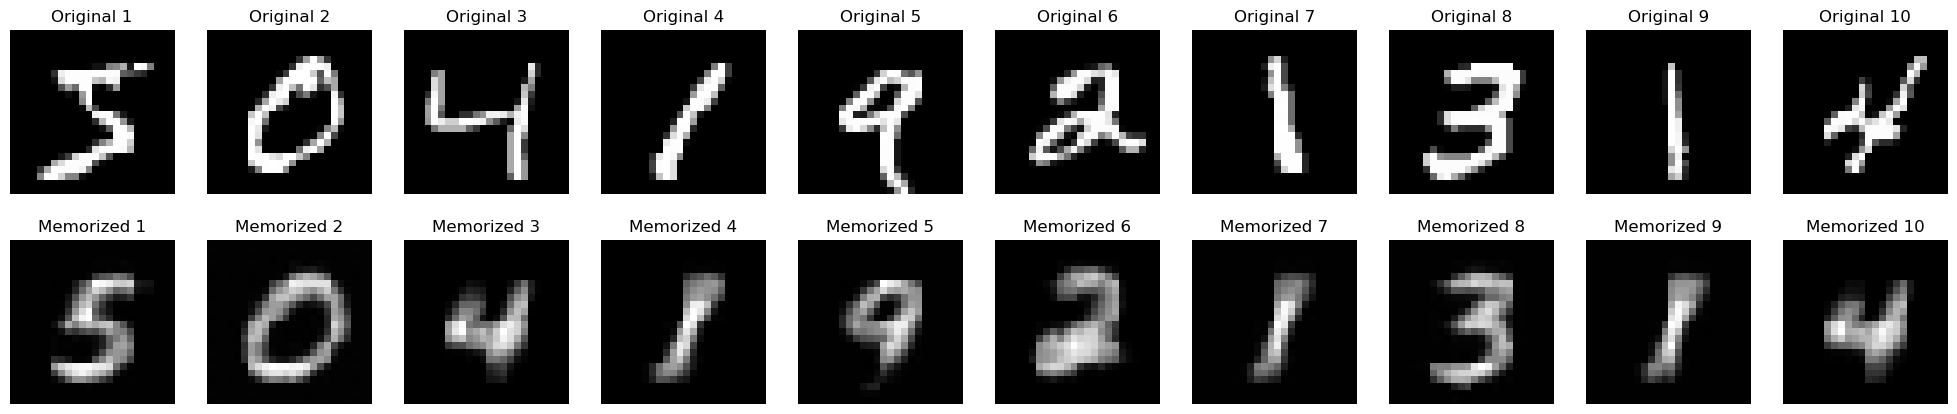

Epoch 27 | Train loss 0.000044 | Memorization loss 0.155047
Saved model and optimizer with memorization loss: 0.1550
Visualizing results at Epoch 28


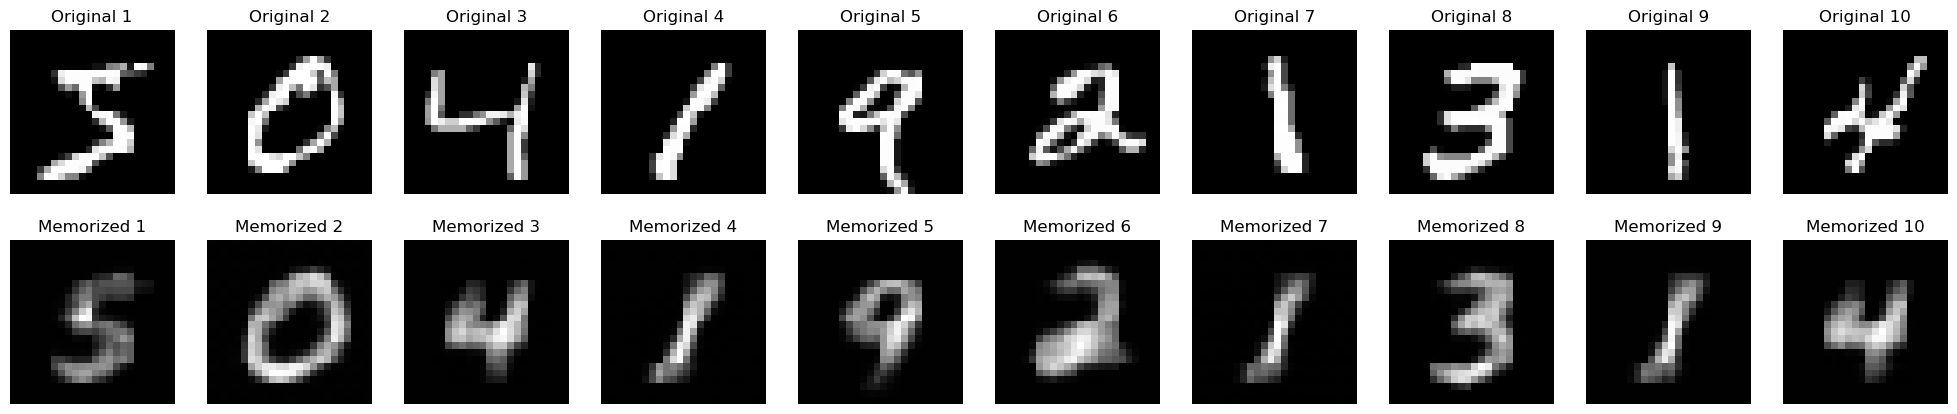

Epoch 28 | Train loss 0.000054 | Memorization loss 0.155946
Visualizing results at Epoch 29


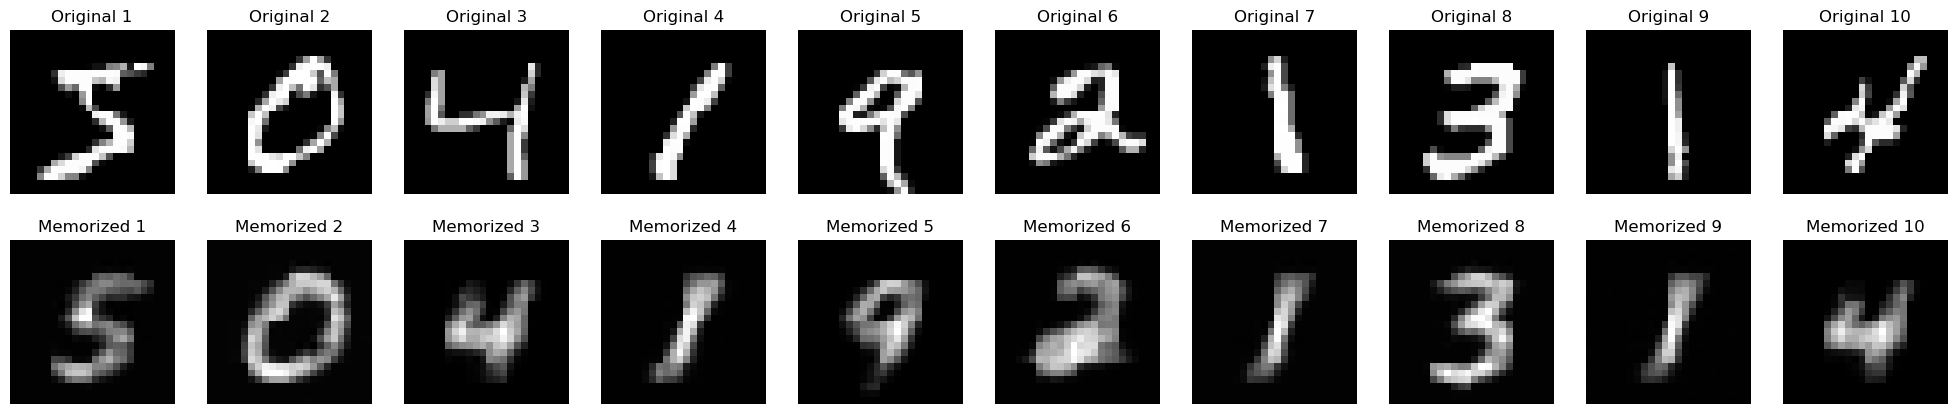

Epoch 29 | Train loss 0.000032 | Memorization loss 0.154316
Saved model and optimizer with memorization loss: 0.1543
Visualizing results at Epoch 30


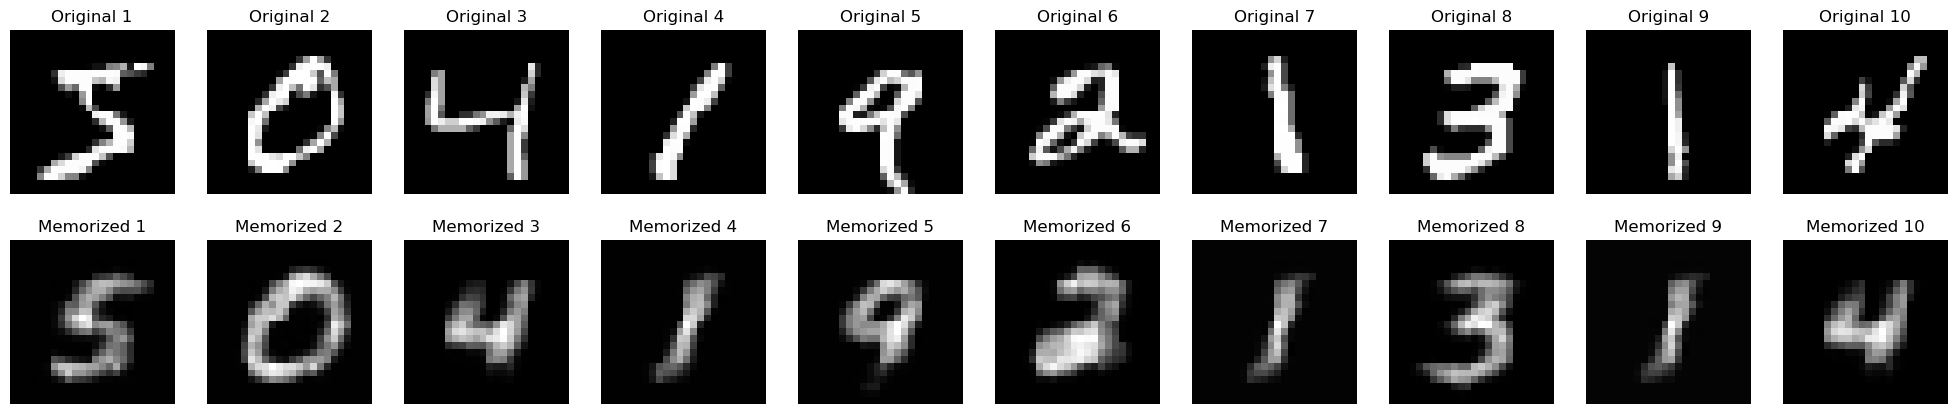

Epoch 30 | Train loss 0.000043 | Memorization loss 0.153614
Saved model and optimizer with memorization loss: 0.1536
Visualizing results at Epoch 31


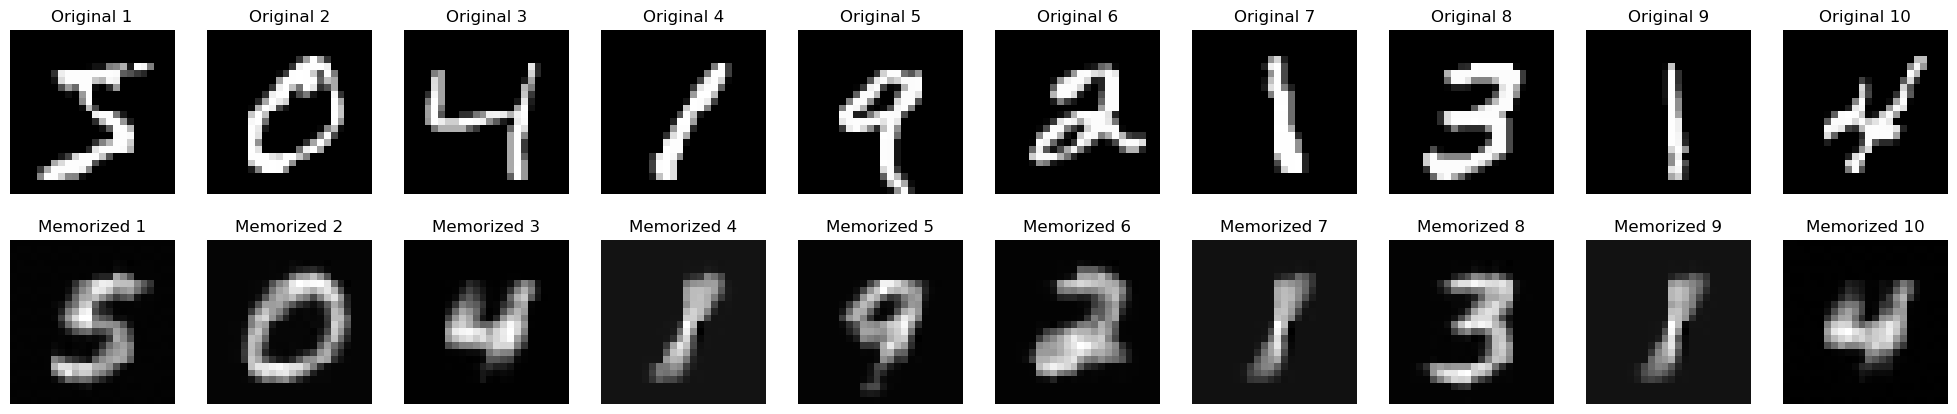

Epoch 31 | Train loss 0.000057 | Memorization loss 0.152215
Saved model and optimizer with memorization loss: 0.1522
Visualizing results at Epoch 32


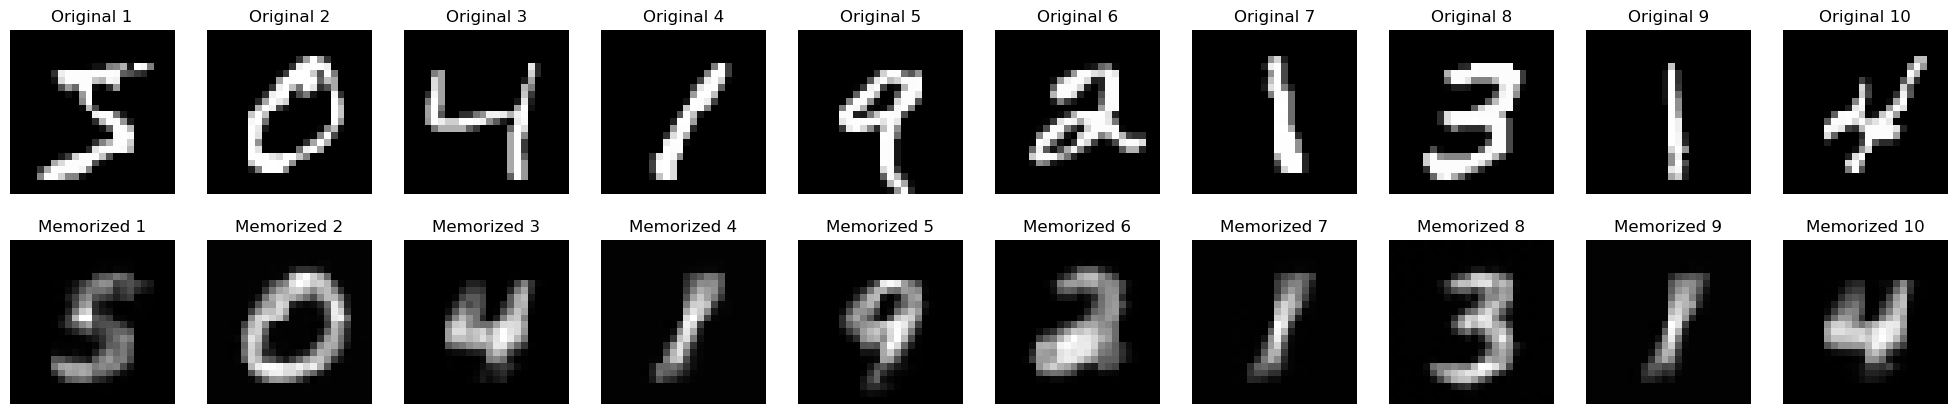

Epoch 32 | Train loss 0.000036 | Memorization loss 0.154753
Visualizing results at Epoch 33


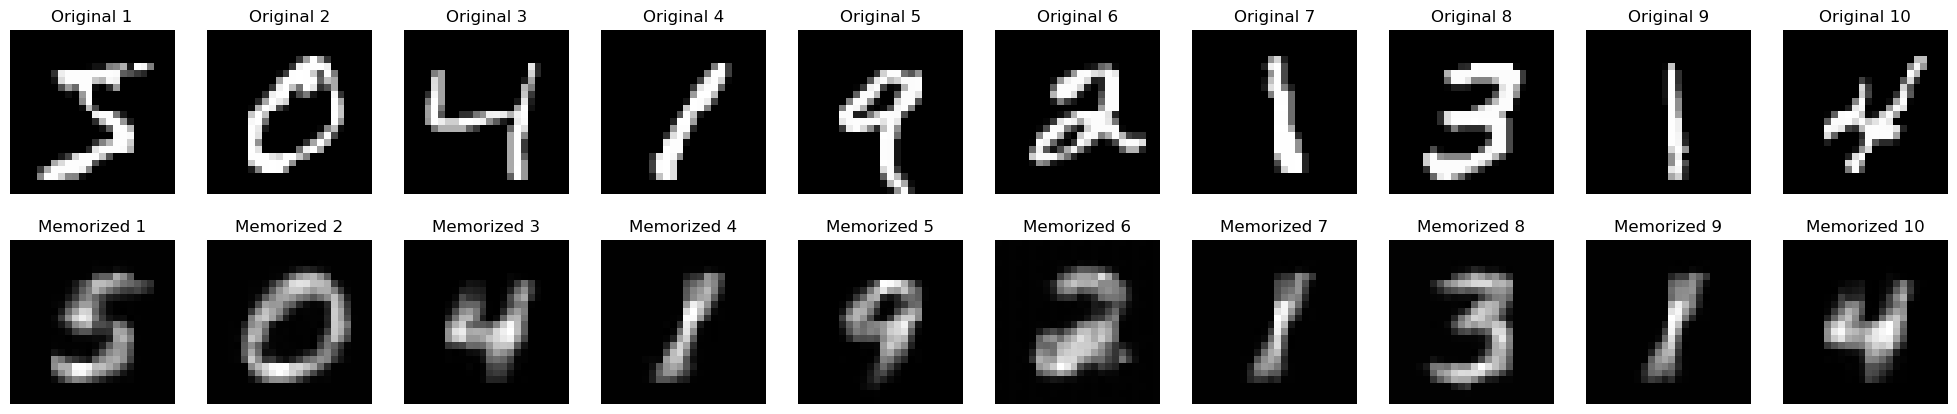

Epoch 33 | Train loss 0.000020 | Memorization loss 0.155369
Visualizing results at Epoch 34


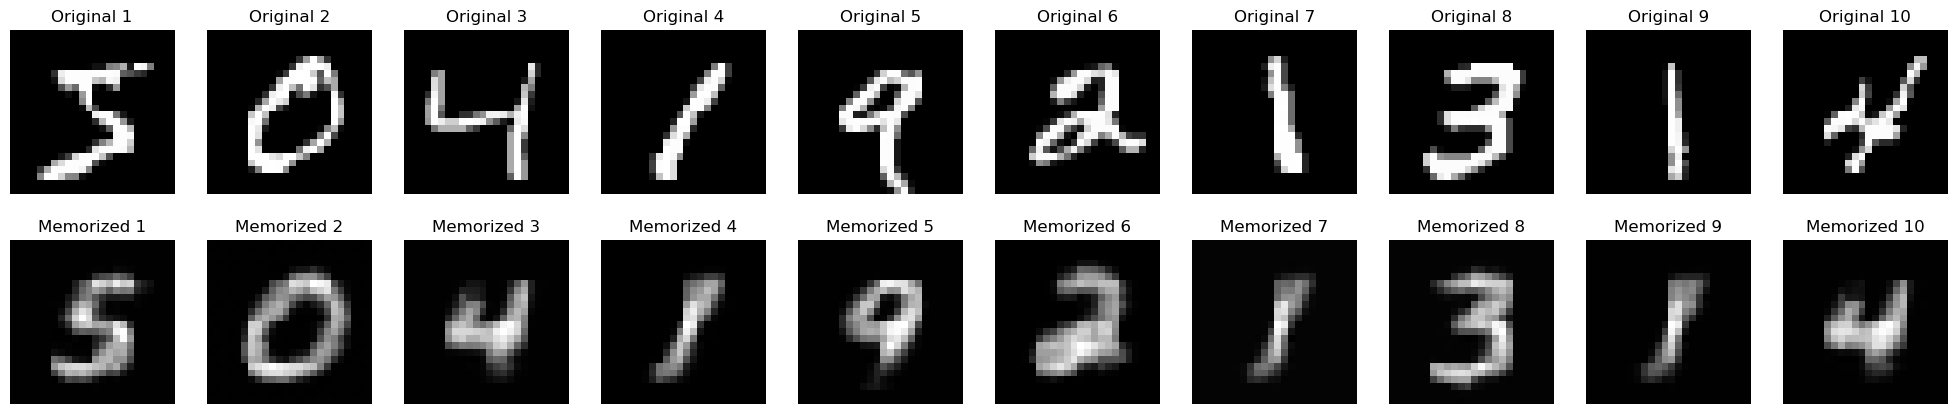

Epoch 34 | Train loss 0.000019 | Memorization loss 0.151070
Saved model and optimizer with memorization loss: 0.1511
Visualizing results at Epoch 35


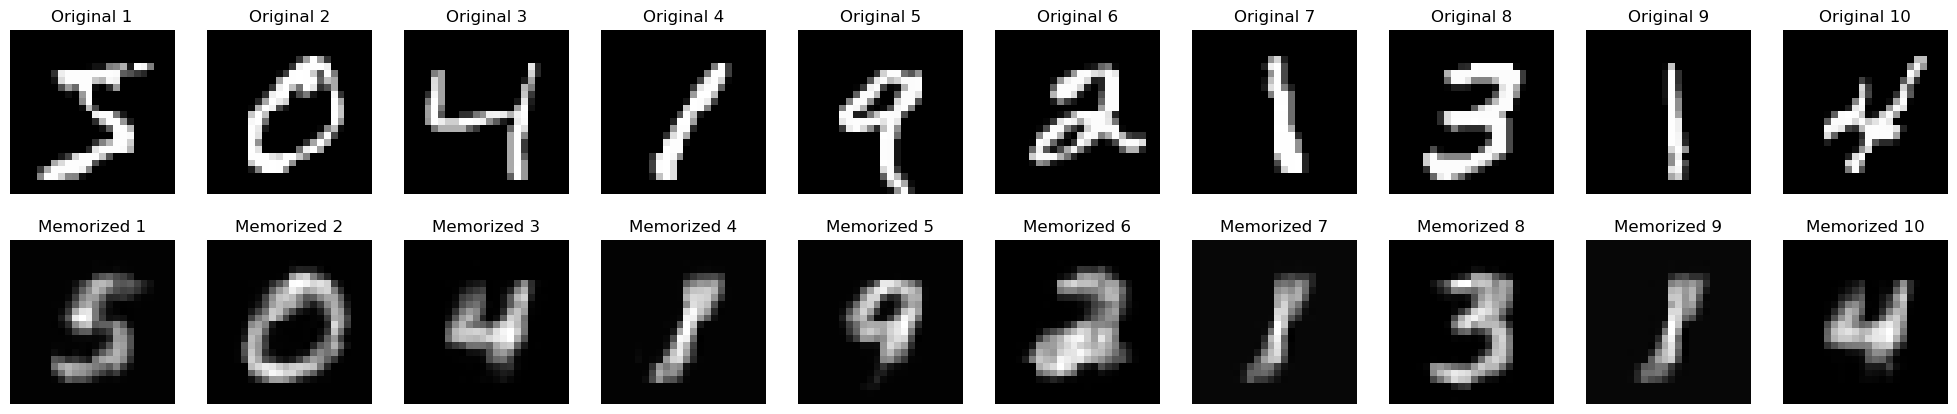

Epoch 35 | Train loss 0.000016 | Memorization loss 0.151600
Visualizing results at Epoch 36


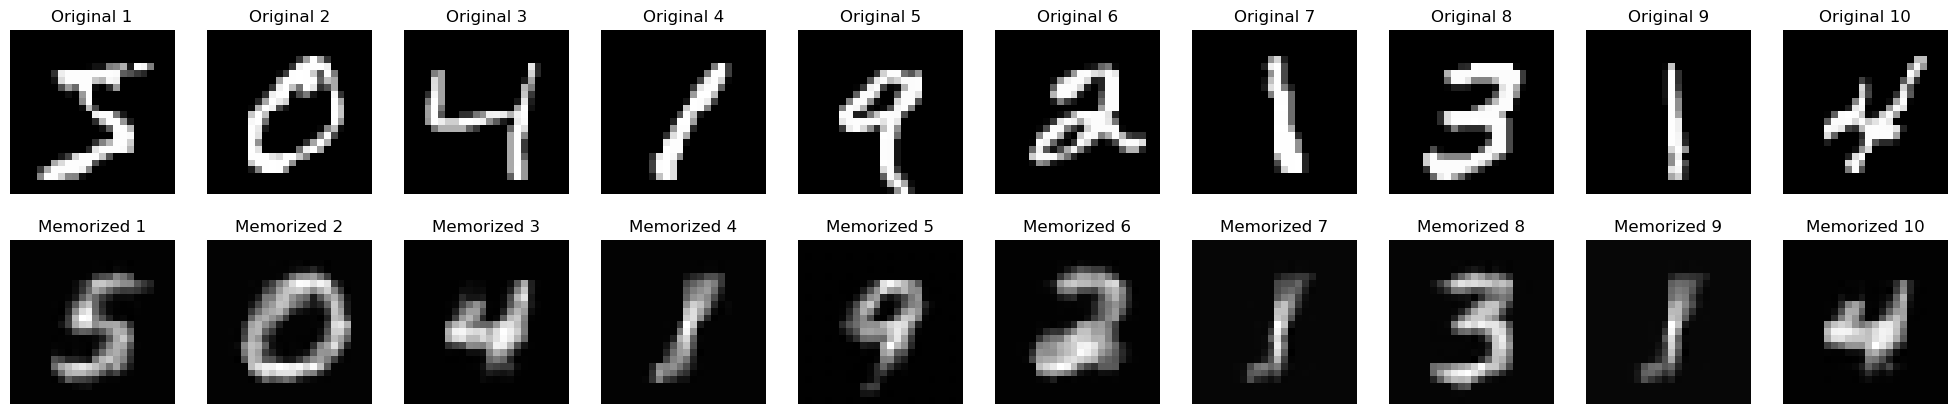

Epoch 36 | Train loss 0.000015 | Memorization loss 0.152761
Visualizing results at Epoch 37


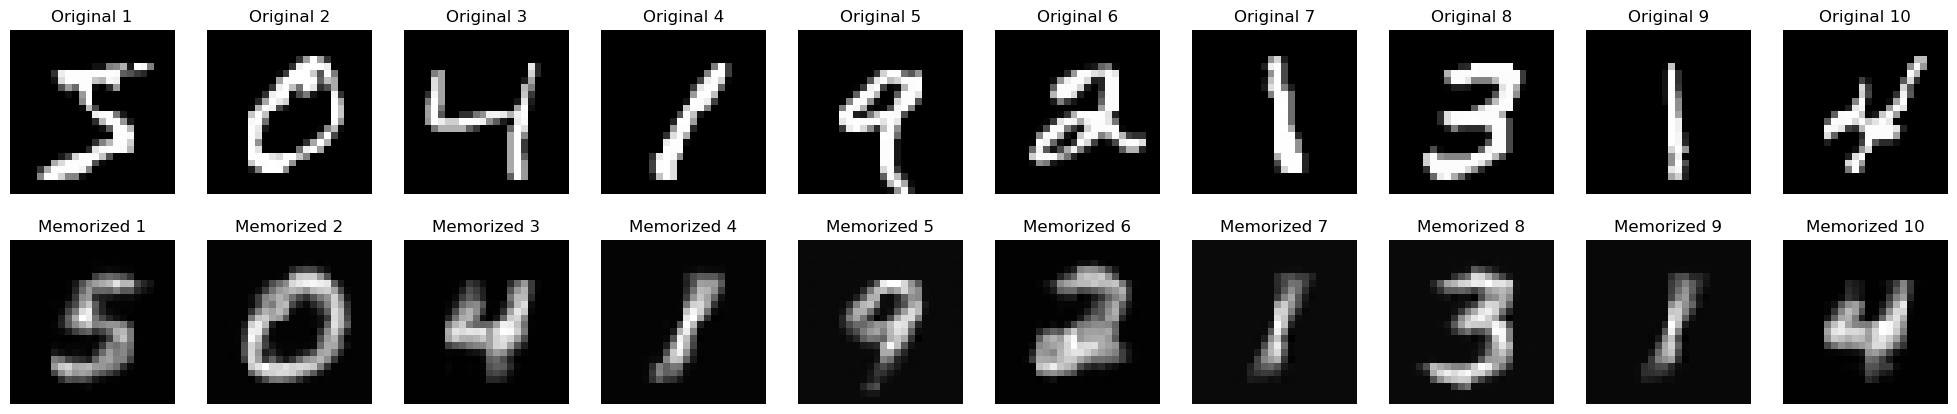

Epoch 37 | Train loss 0.000021 | Memorization loss 0.154403
Visualizing results at Epoch 38


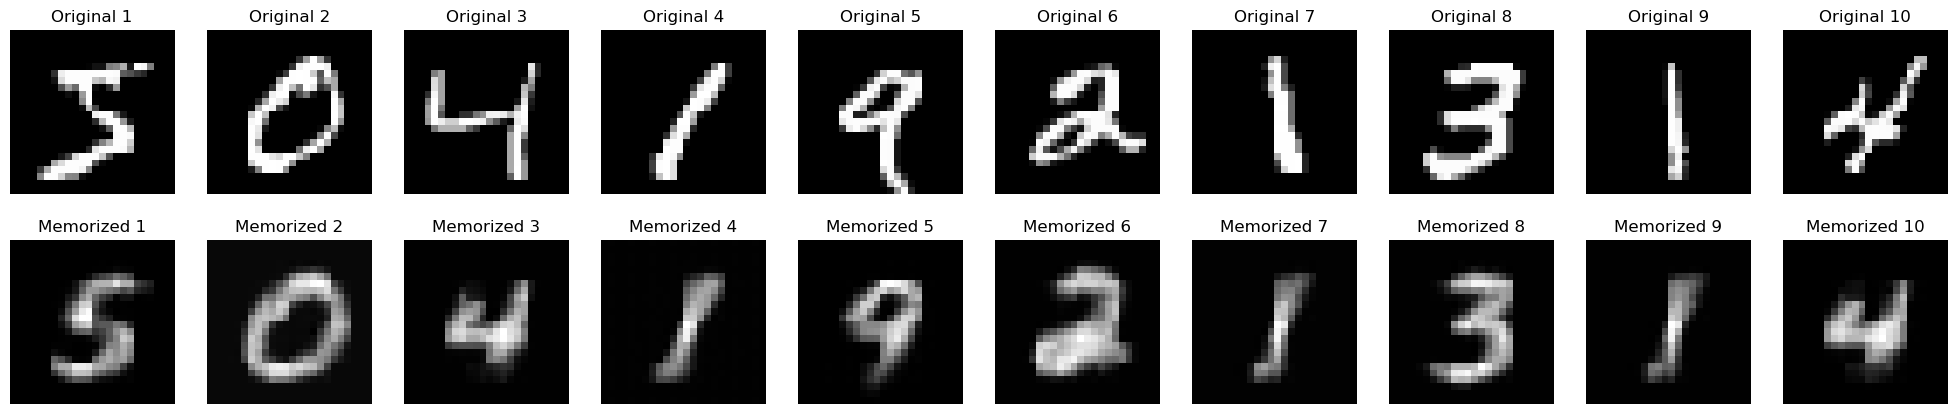

Epoch 38 | Train loss 0.000069 | Memorization loss 0.151875
Visualizing results at Epoch 39


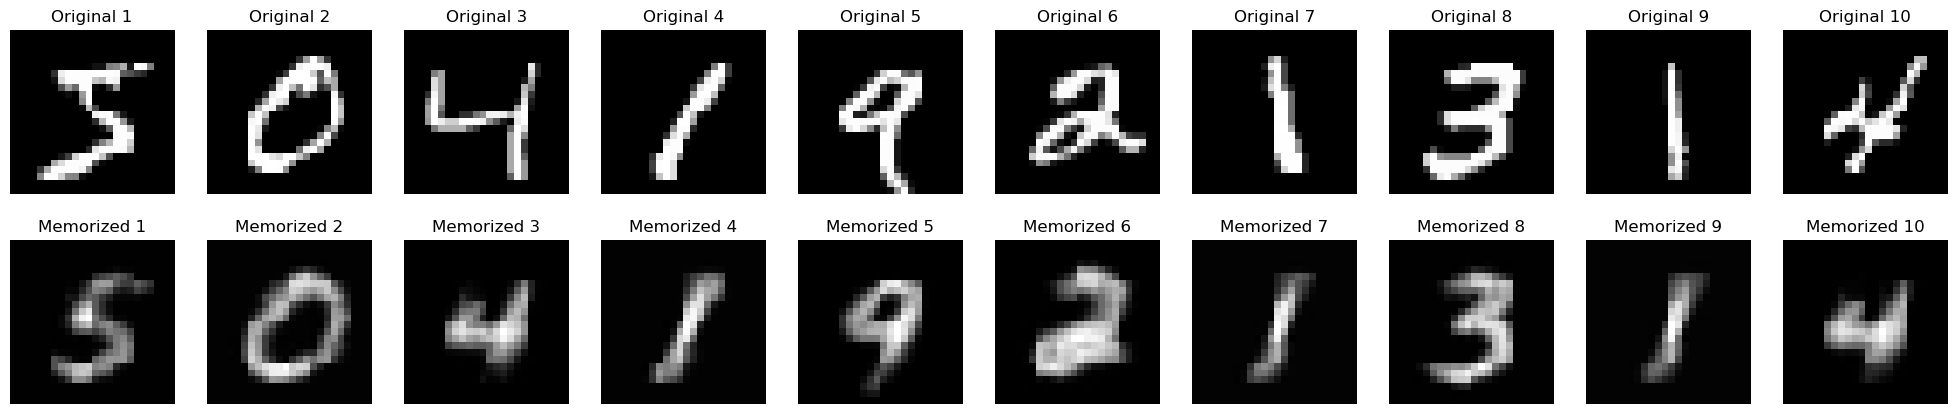

Epoch 39 | Train loss 0.000016 | Memorization loss 0.150589
Saved model and optimizer with memorization loss: 0.1506
Visualizing results at Epoch 40


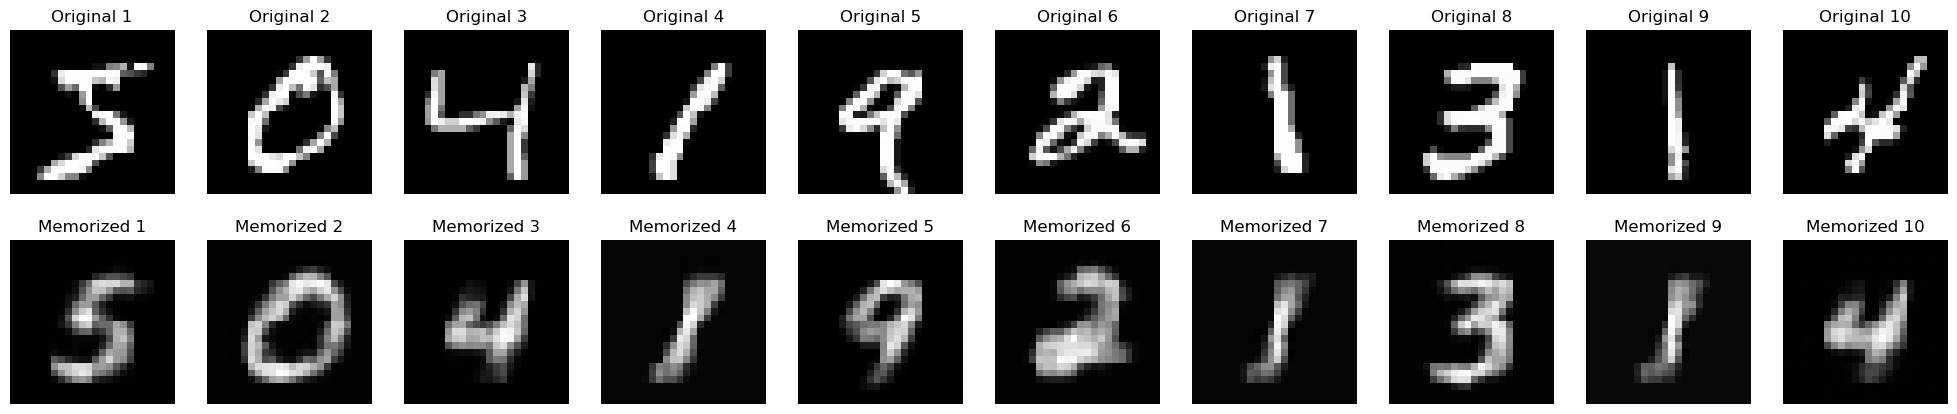

Epoch 40 | Train loss 0.000019 | Memorization loss 0.153457
Visualizing results at Epoch 41


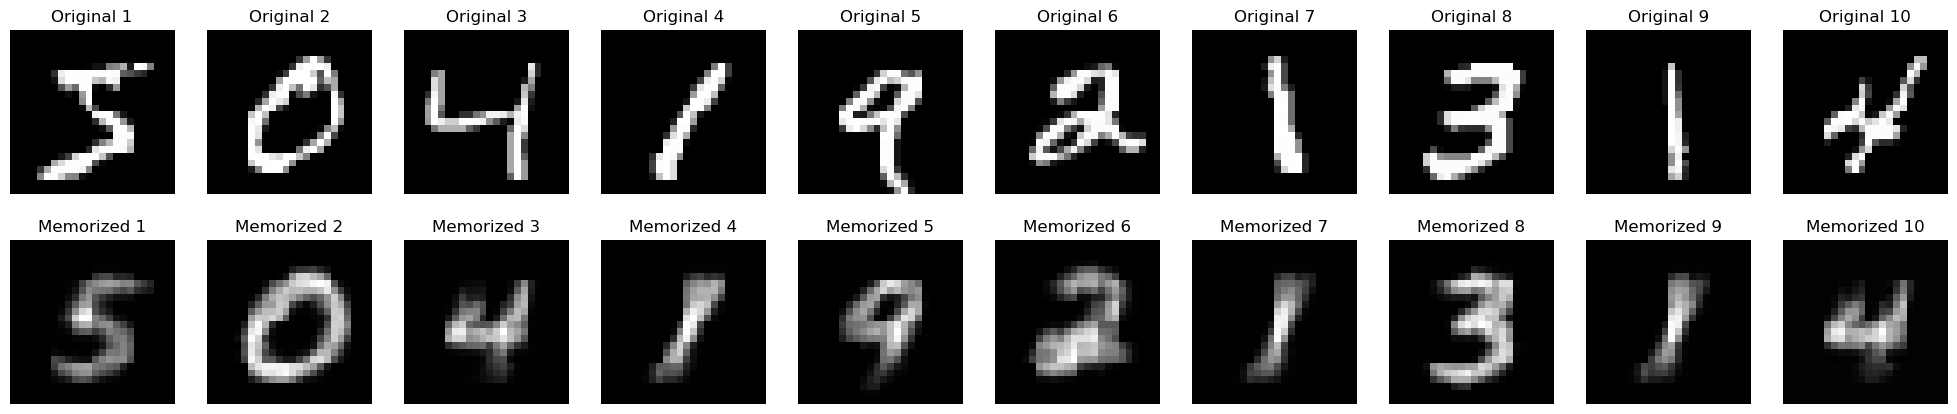

Epoch 41 | Train loss 0.000015 | Memorization loss 0.149997
Saved model and optimizer with memorization loss: 0.1500
Visualizing results at Epoch 42


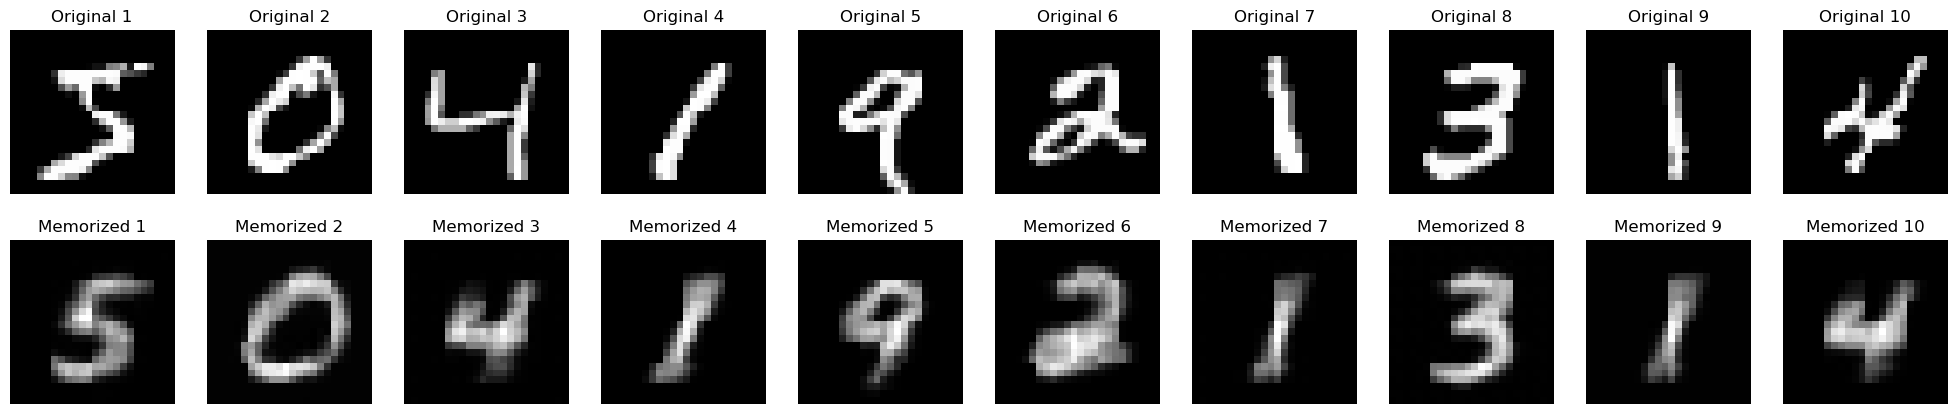

Epoch 42 | Train loss 0.000009 | Memorization loss 0.150012
Visualizing results at Epoch 43


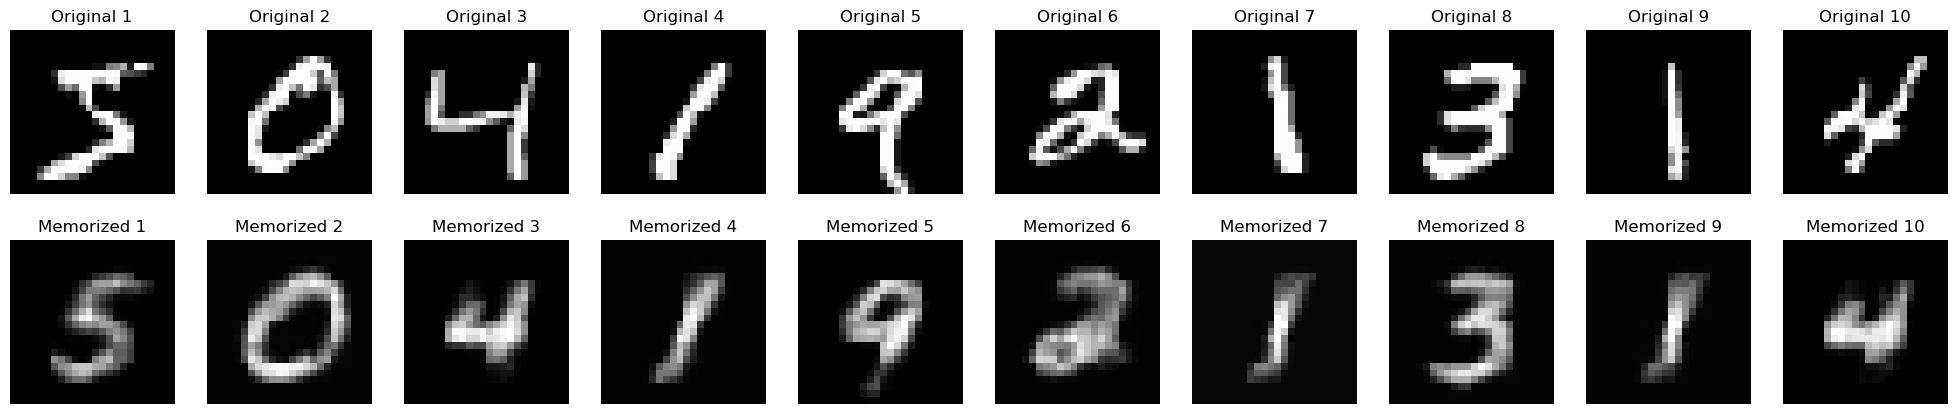

Epoch 43 | Train loss 0.000008 | Memorization loss 0.146856
Saved model and optimizer with memorization loss: 0.1469
Visualizing results at Epoch 44


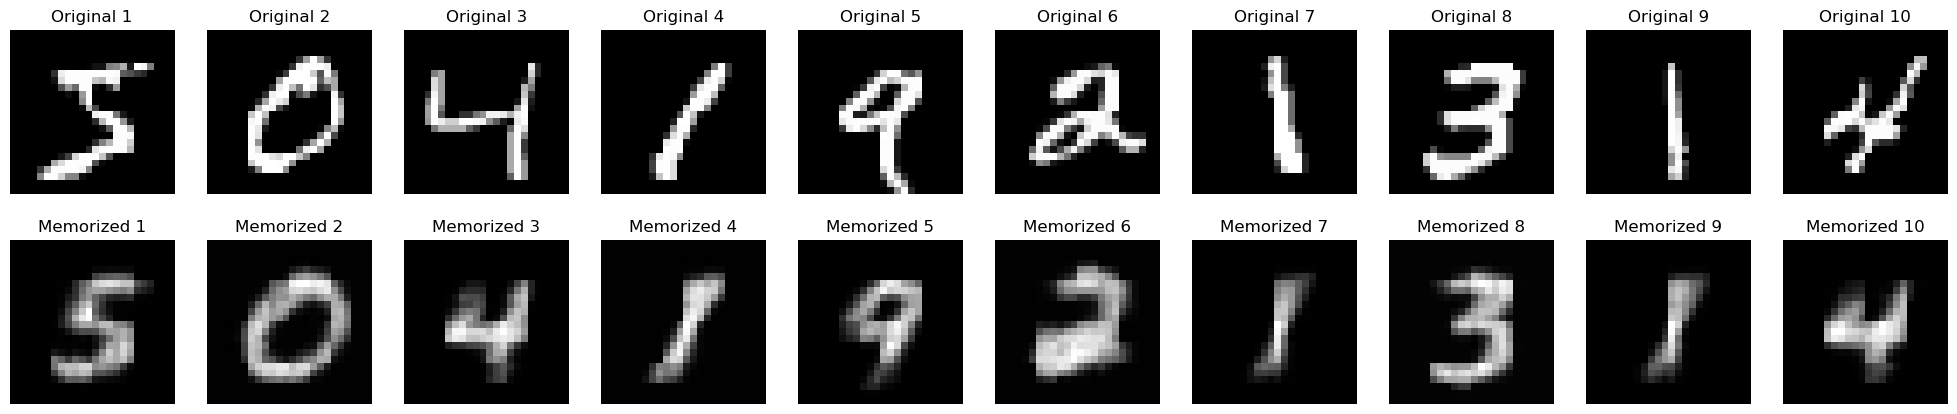

Epoch 44 | Train loss 0.000016 | Memorization loss 0.149348
Visualizing results at Epoch 45


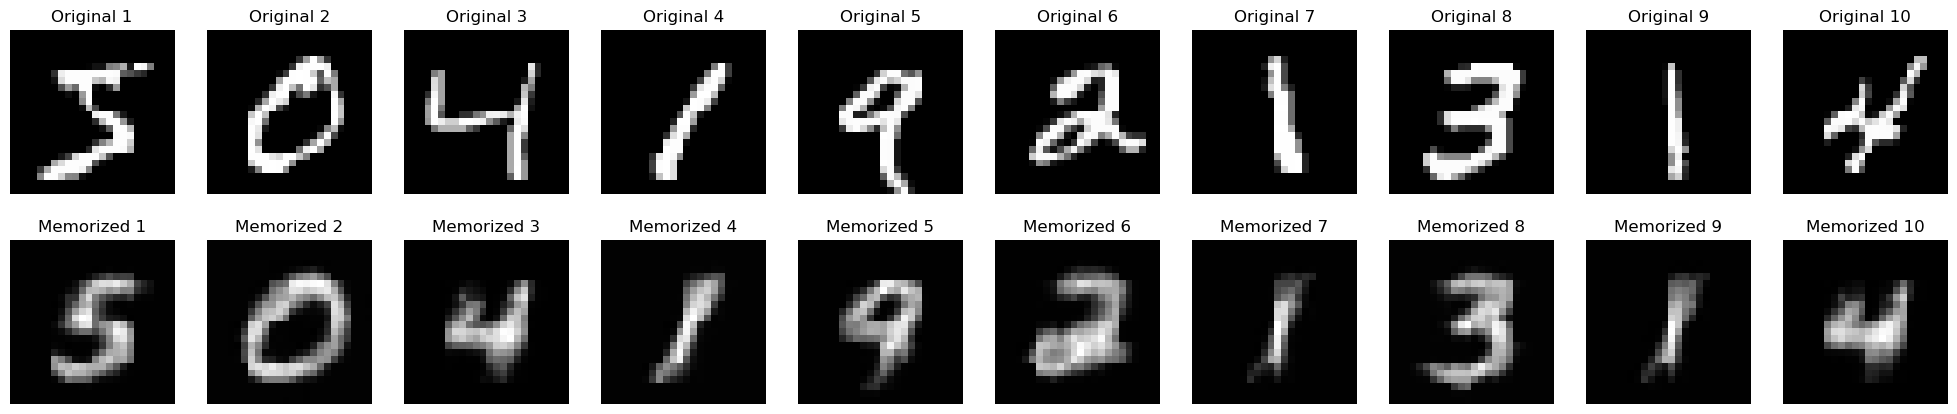

Epoch 45 | Train loss 0.000045 | Memorization loss 0.150228
Visualizing results at Epoch 46


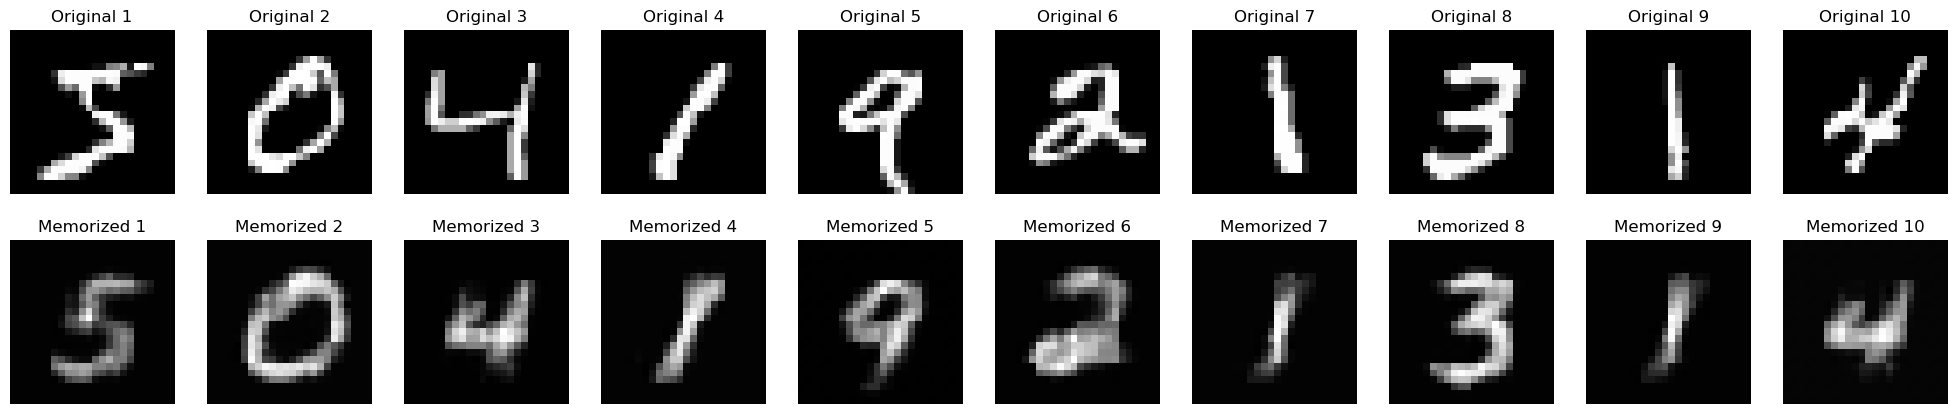

Epoch 46 | Train loss 0.000013 | Memorization loss 0.147800
Visualizing results at Epoch 47


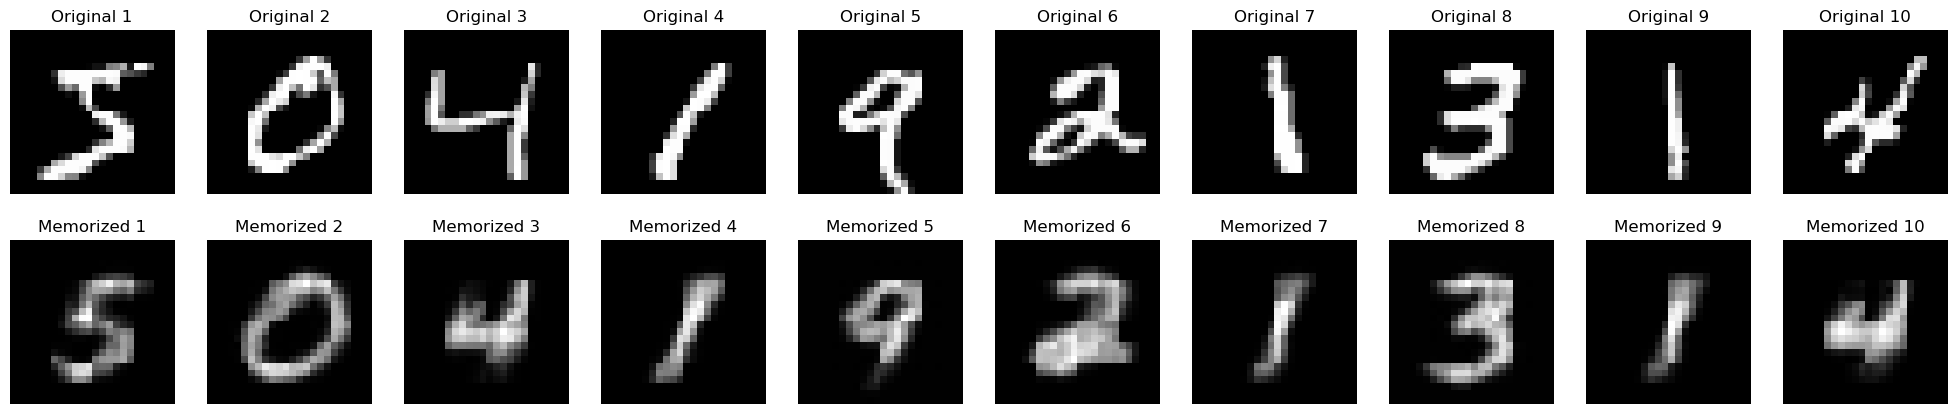

Epoch 47 | Train loss 0.000008 | Memorization loss 0.145458
Saved model and optimizer with memorization loss: 0.1455
Visualizing results at Epoch 48


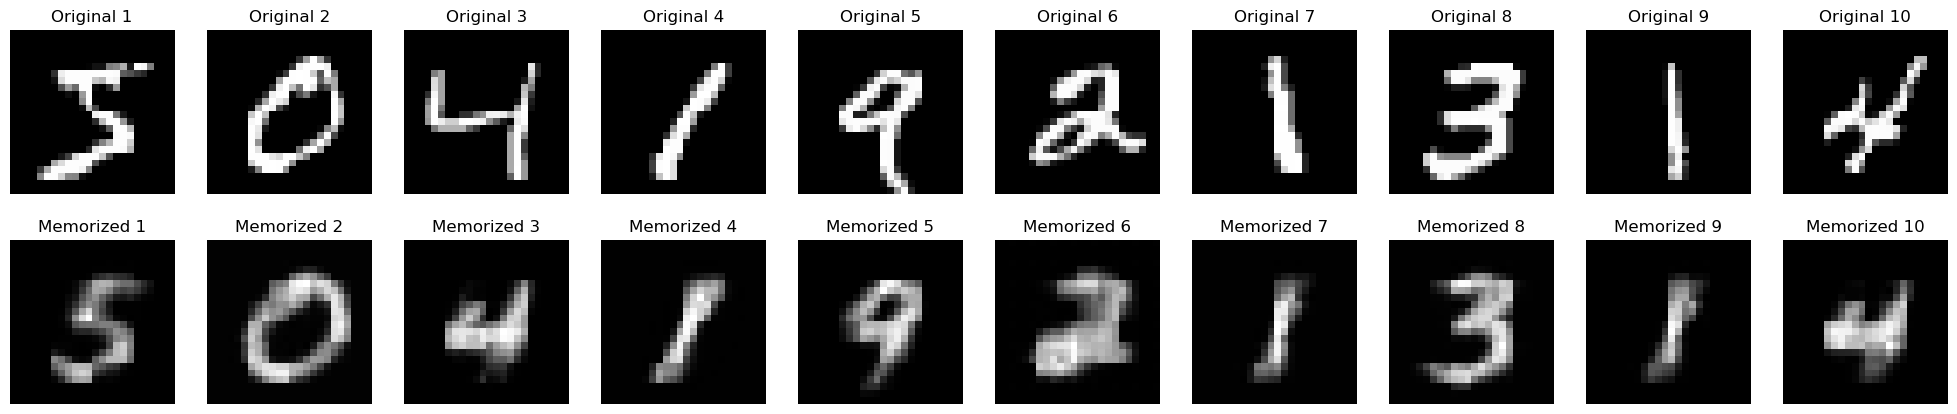

Epoch 48 | Train loss 0.000007 | Memorization loss 0.145604
Visualizing results at Epoch 49


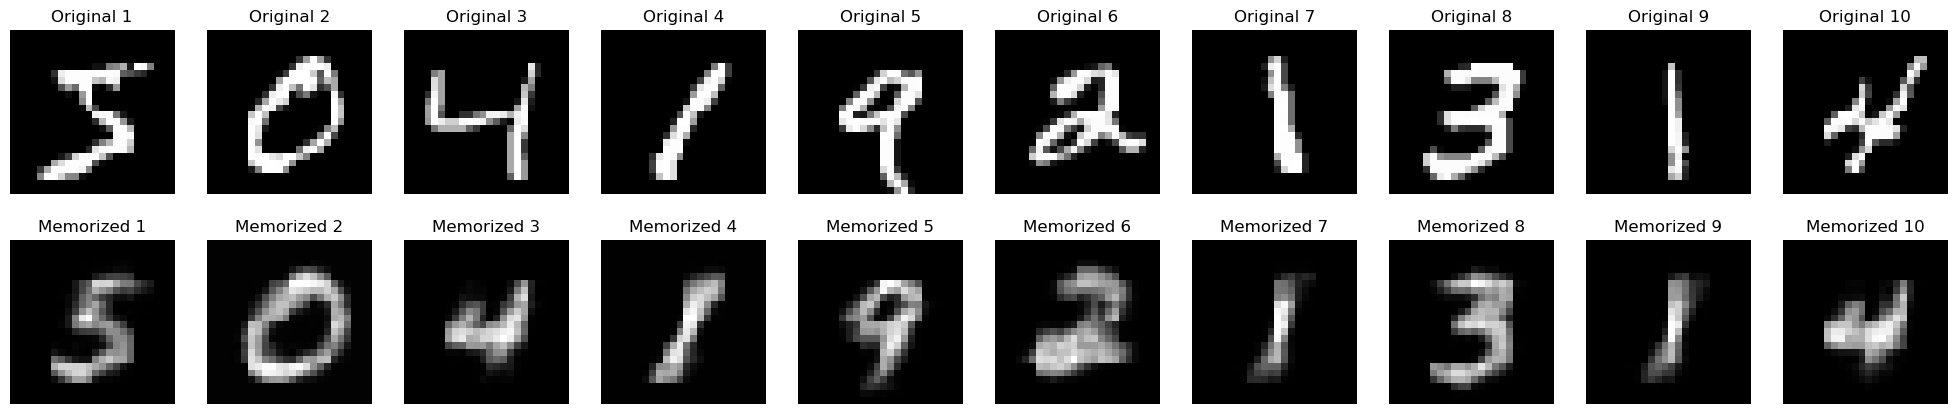

Epoch 49 | Train loss 0.000010 | Memorization loss 0.145660
Visualizing results at Epoch 50


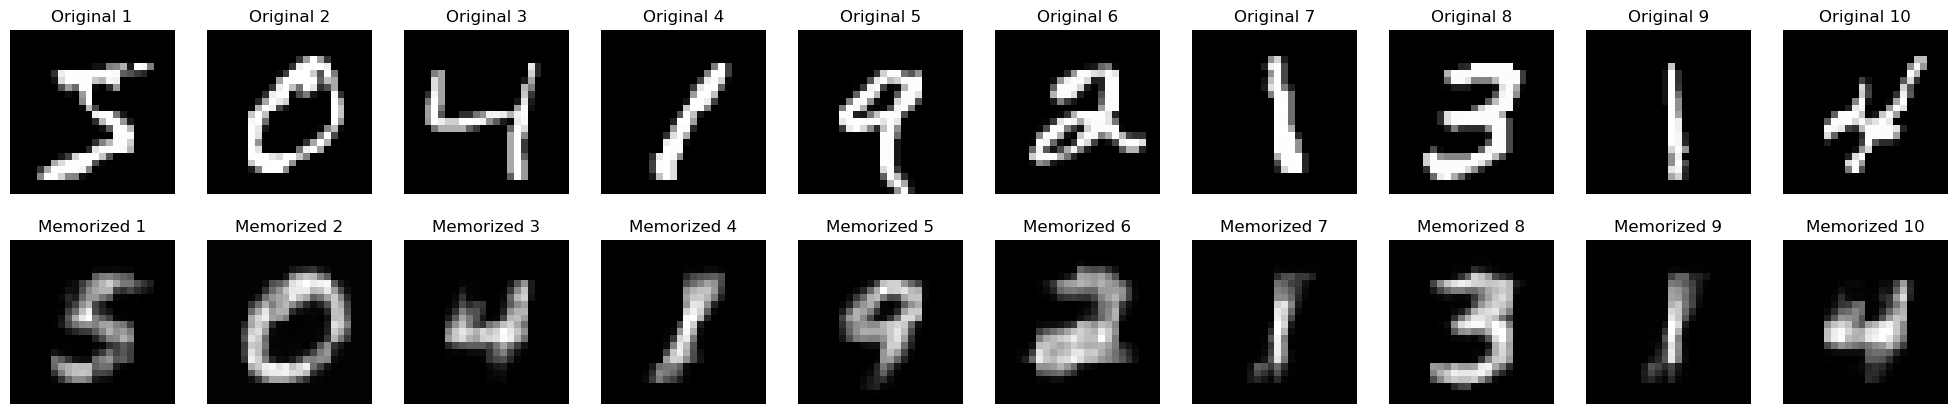

Epoch 50 | Train loss 0.000037 | Memorization loss 0.149952
Visualizing results at Epoch 51


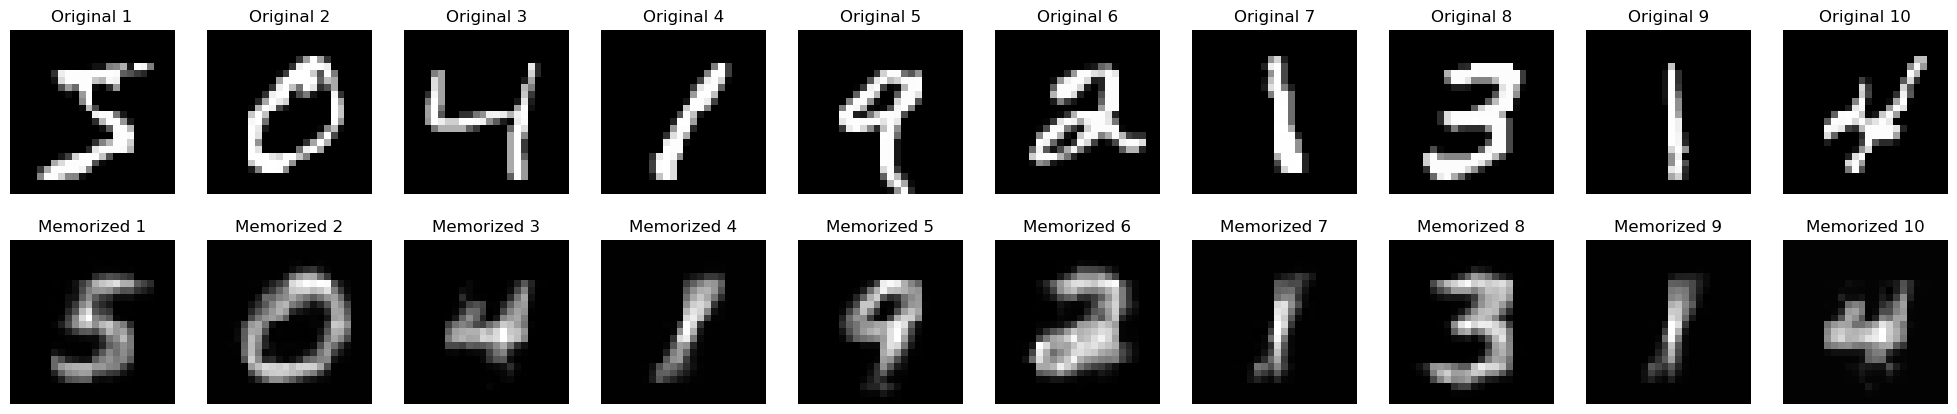

Epoch 51 | Train loss 0.000026 | Memorization loss 0.142464
Saved model and optimizer with memorization loss: 0.1425
Visualizing results at Epoch 52


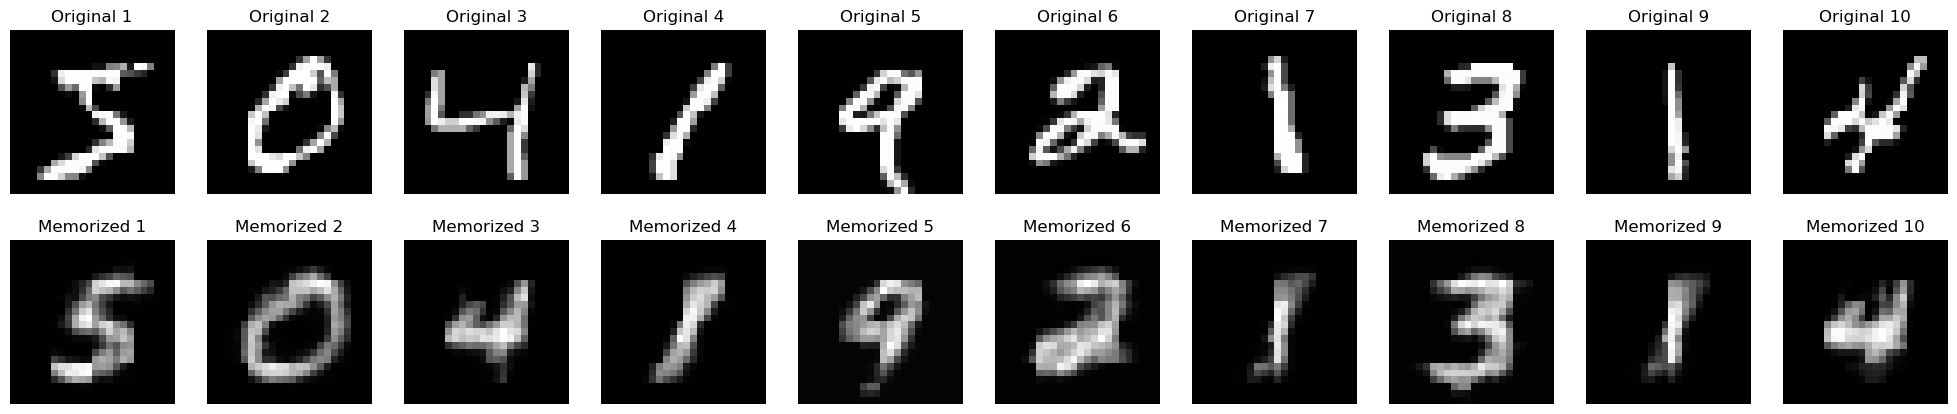

Epoch 52 | Train loss 0.000017 | Memorization loss 0.145217
Visualizing results at Epoch 53


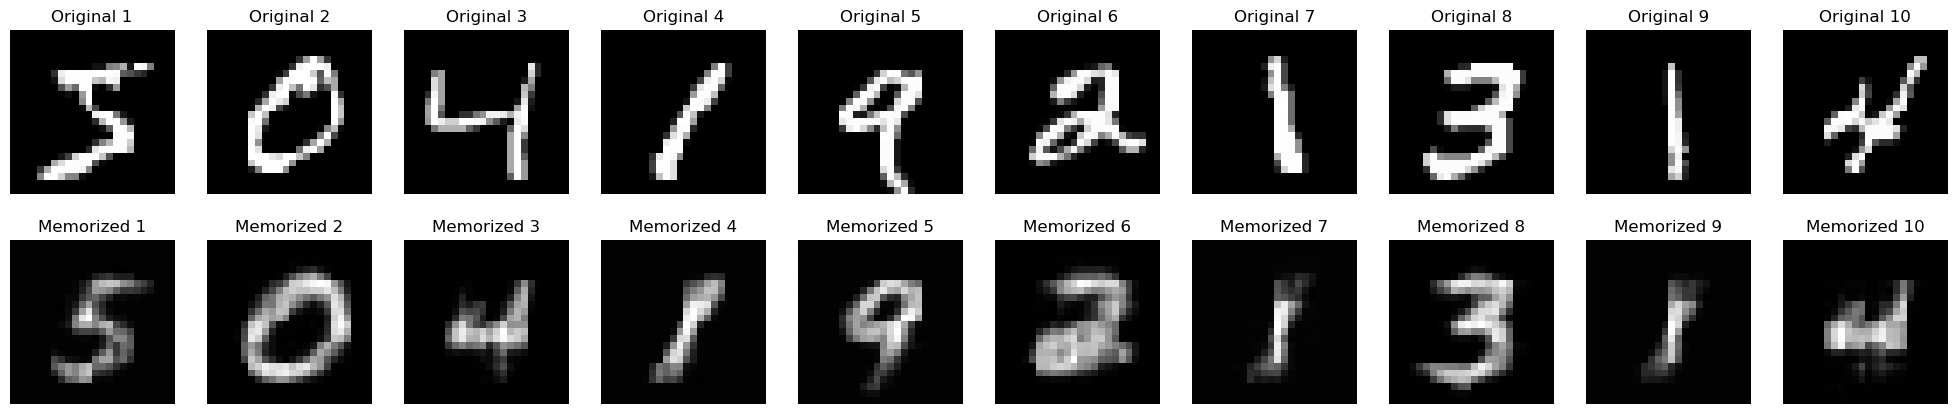

Epoch 53 | Train loss 0.000006 | Memorization loss 0.142110
Saved model and optimizer with memorization loss: 0.1421
Visualizing results at Epoch 54


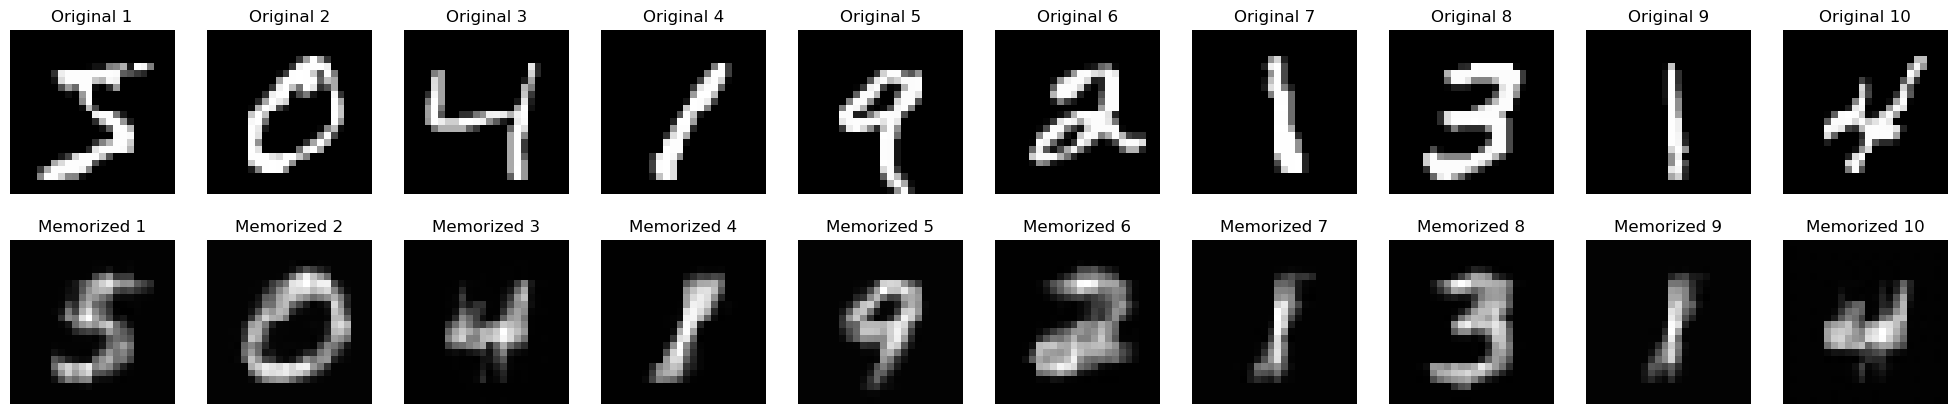

Epoch 54 | Train loss 0.000009 | Memorization loss 0.144834
Visualizing results at Epoch 55


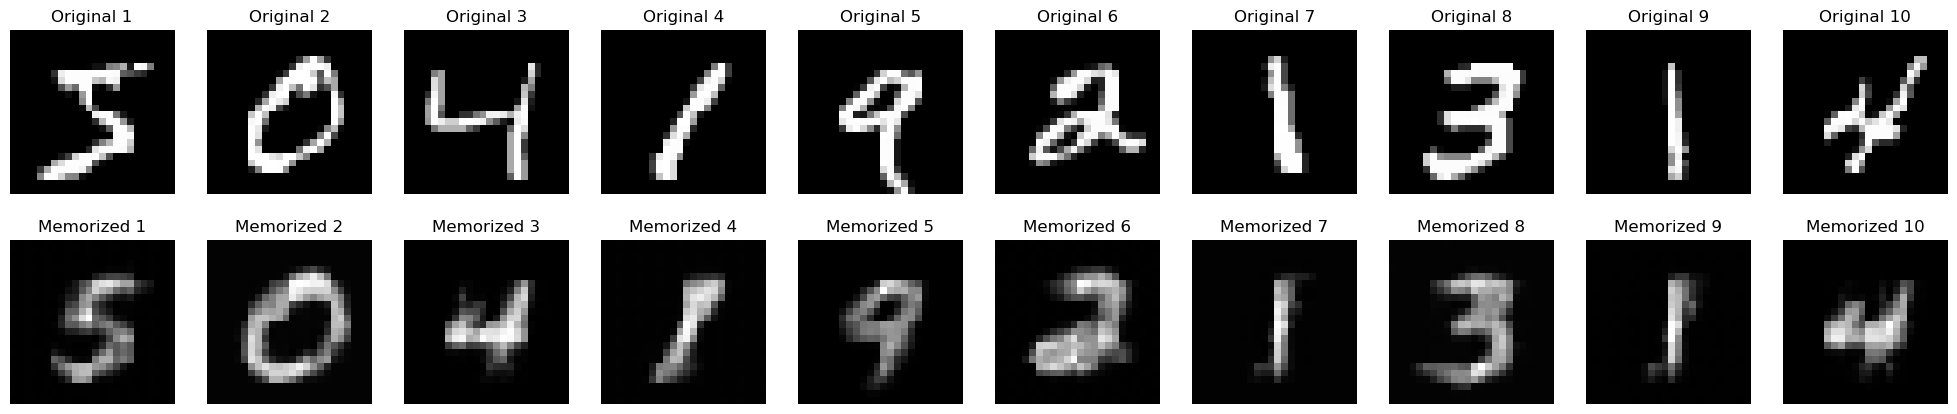

Epoch 55 | Train loss 0.000006 | Memorization loss 0.142342
Visualizing results at Epoch 56


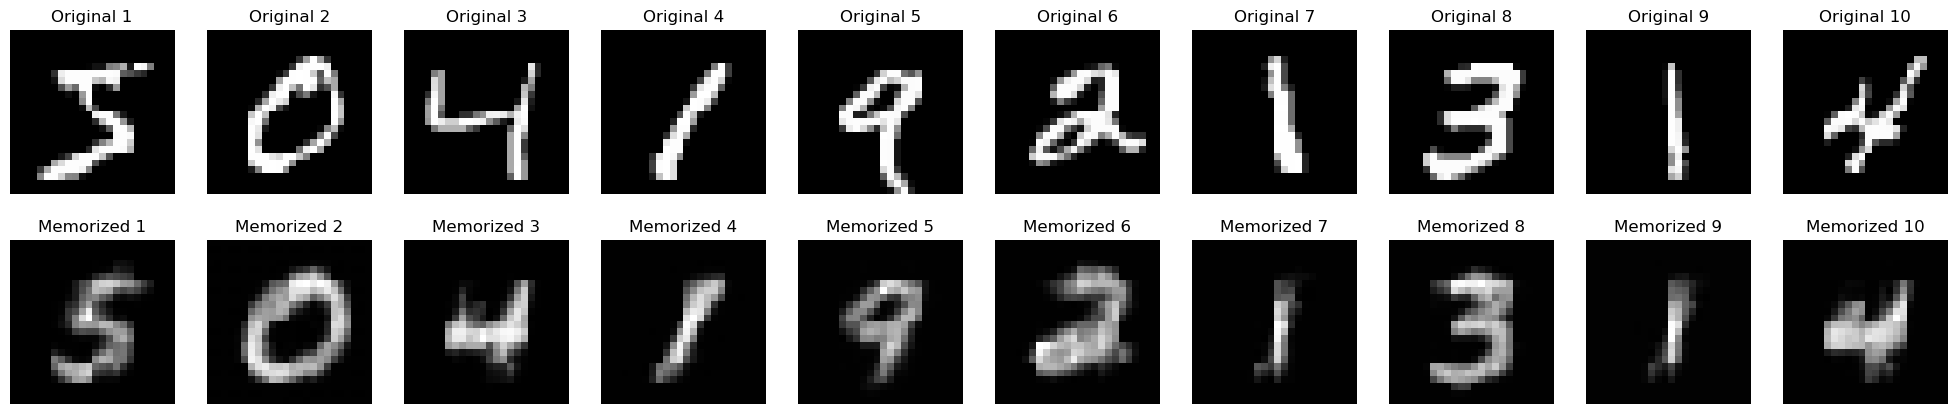

Epoch 56 | Train loss 0.000005 | Memorization loss 0.139836
Saved model and optimizer with memorization loss: 0.1398
Visualizing results at Epoch 57


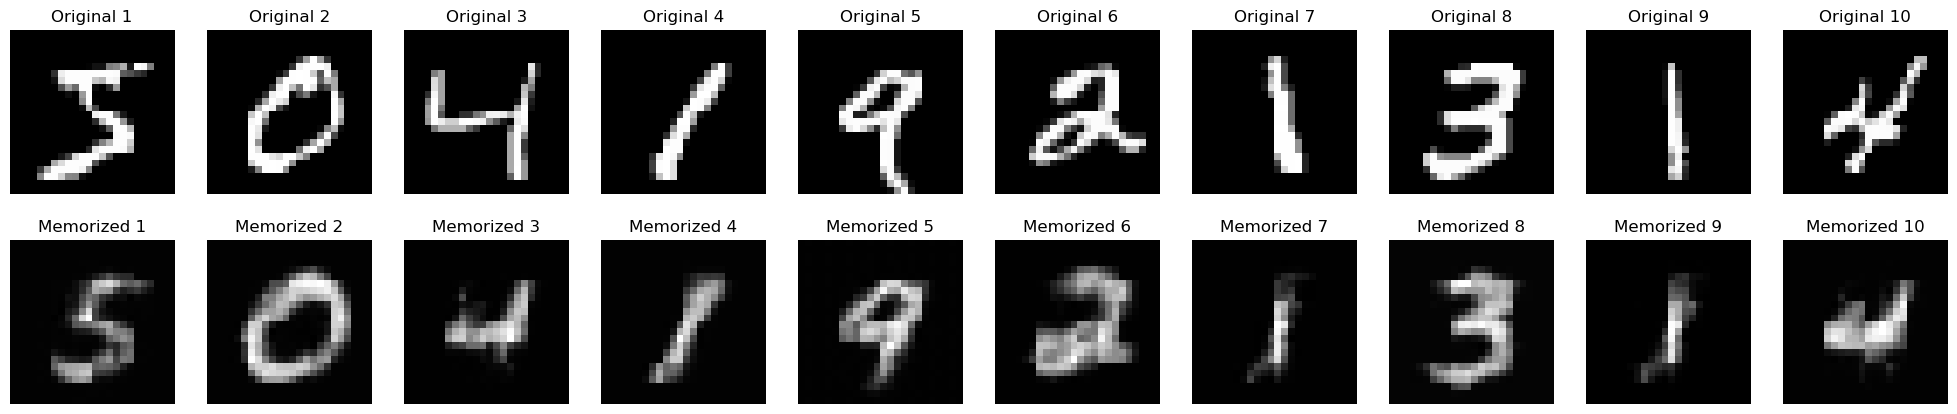

Epoch 57 | Train loss 0.000026 | Memorization loss 0.140050
Visualizing results at Epoch 58


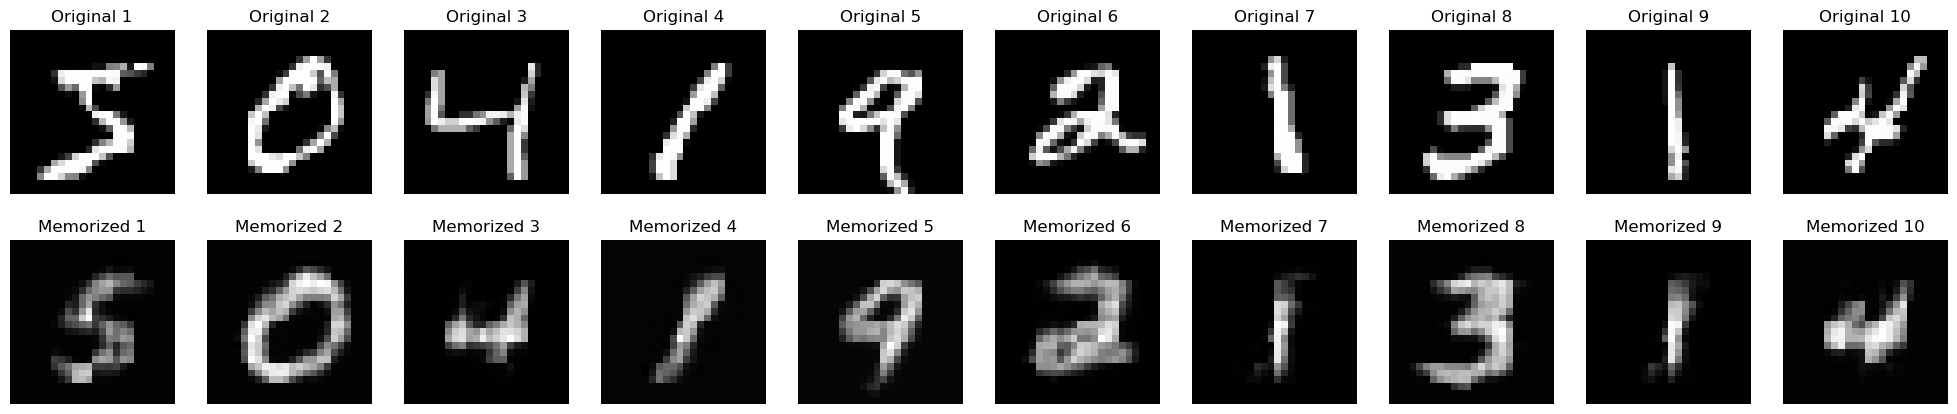

Epoch 58 | Train loss 0.000007 | Memorization loss 0.142228
Visualizing results at Epoch 59


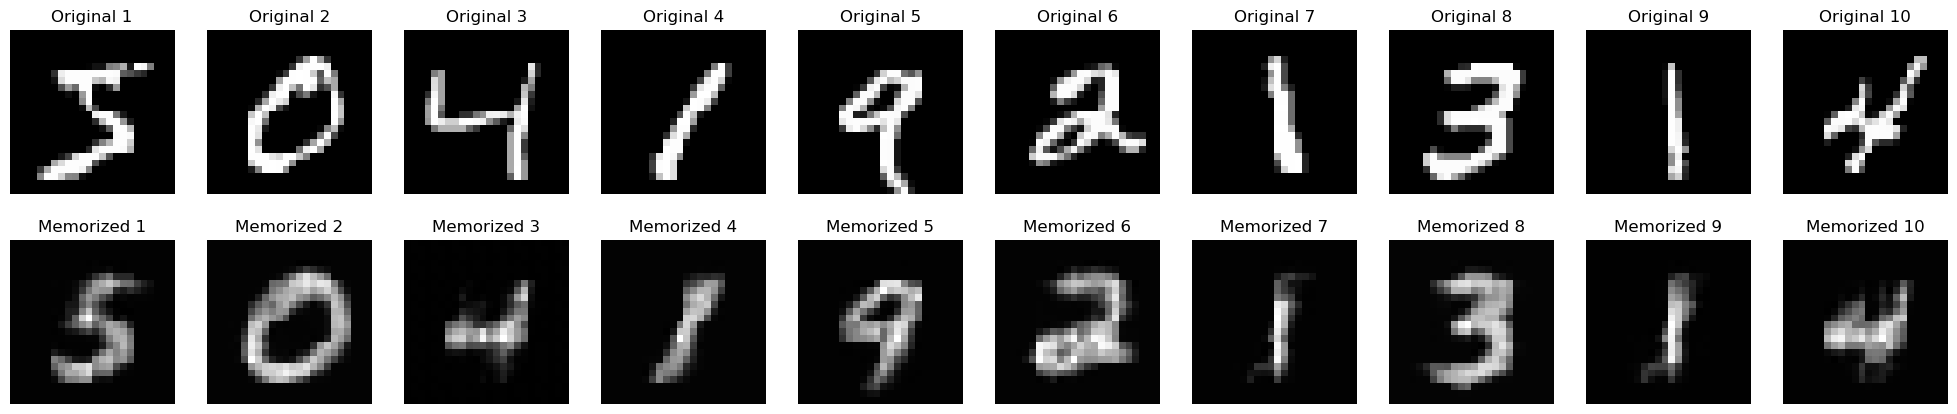

Epoch 59 | Train loss 0.000006 | Memorization loss 0.140332
Visualizing results at Epoch 60


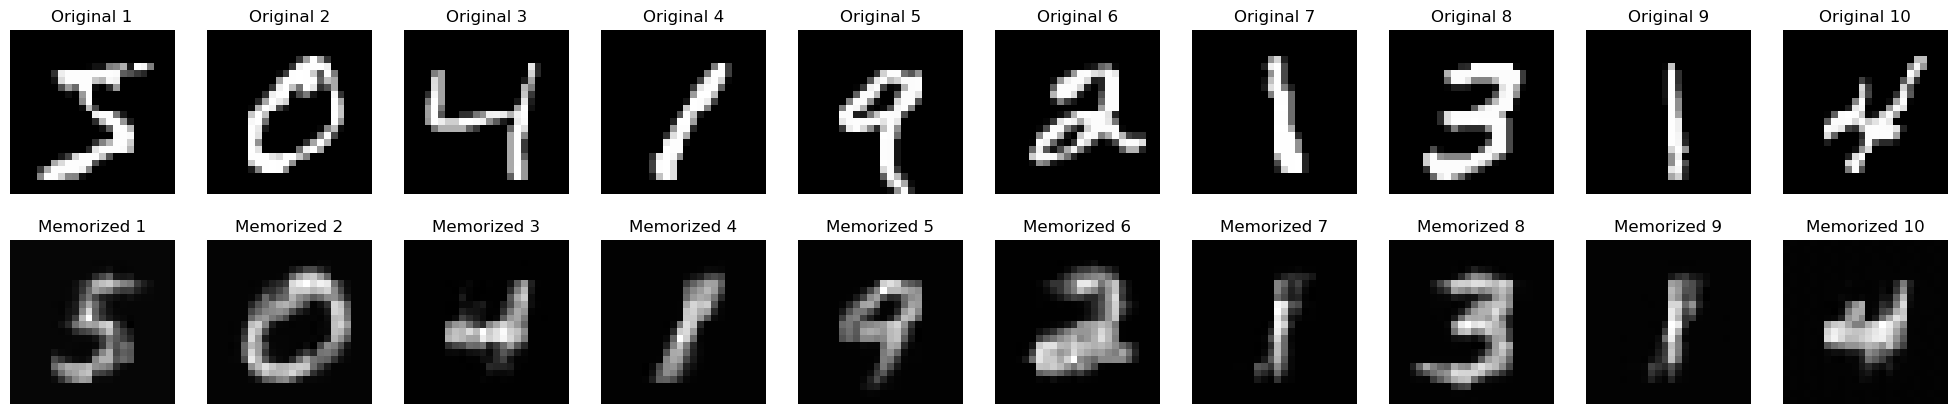

Epoch 60 | Train loss 0.000028 | Memorization loss 0.136106
Saved model and optimizer with memorization loss: 0.1361
Visualizing results at Epoch 61


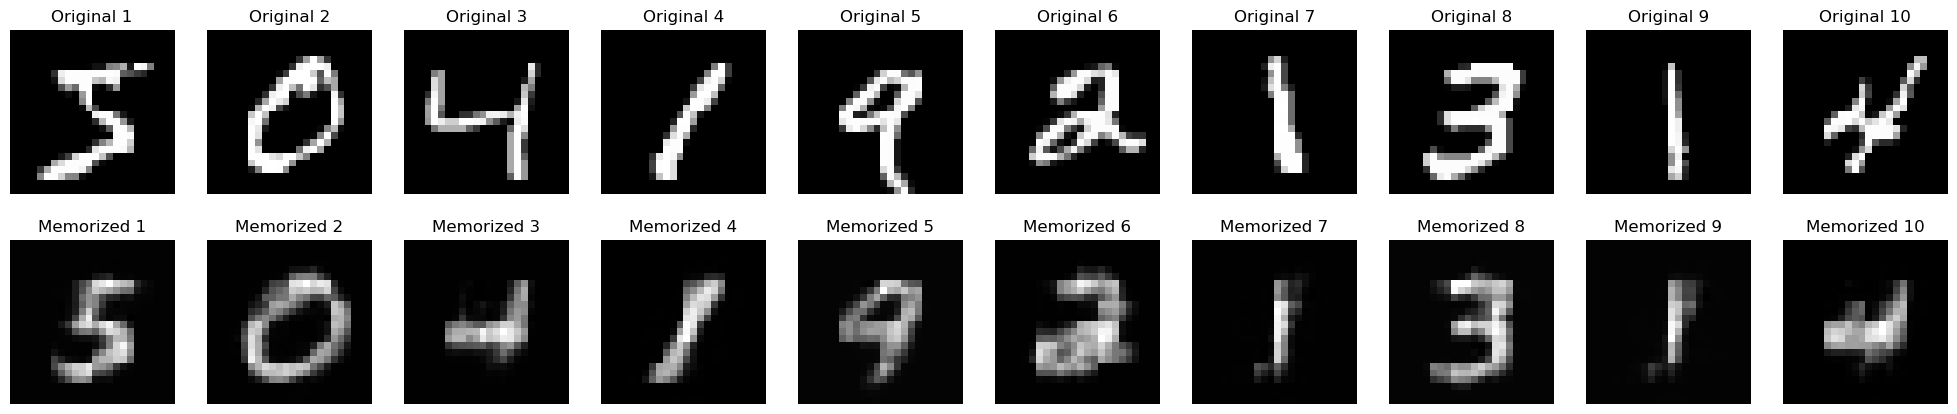

Epoch 61 | Train loss 0.000025 | Memorization loss 0.135936
Saved model and optimizer with memorization loss: 0.1359
Visualizing results at Epoch 62


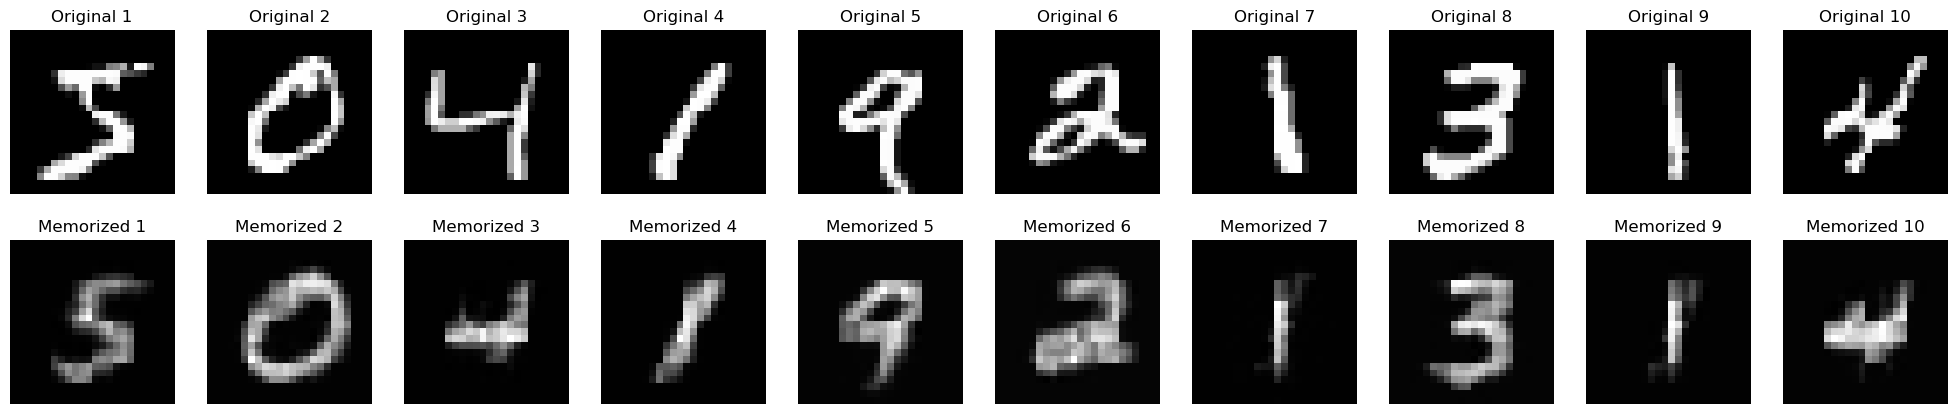

Epoch 62 | Train loss 0.000008 | Memorization loss 0.138712
Visualizing results at Epoch 63


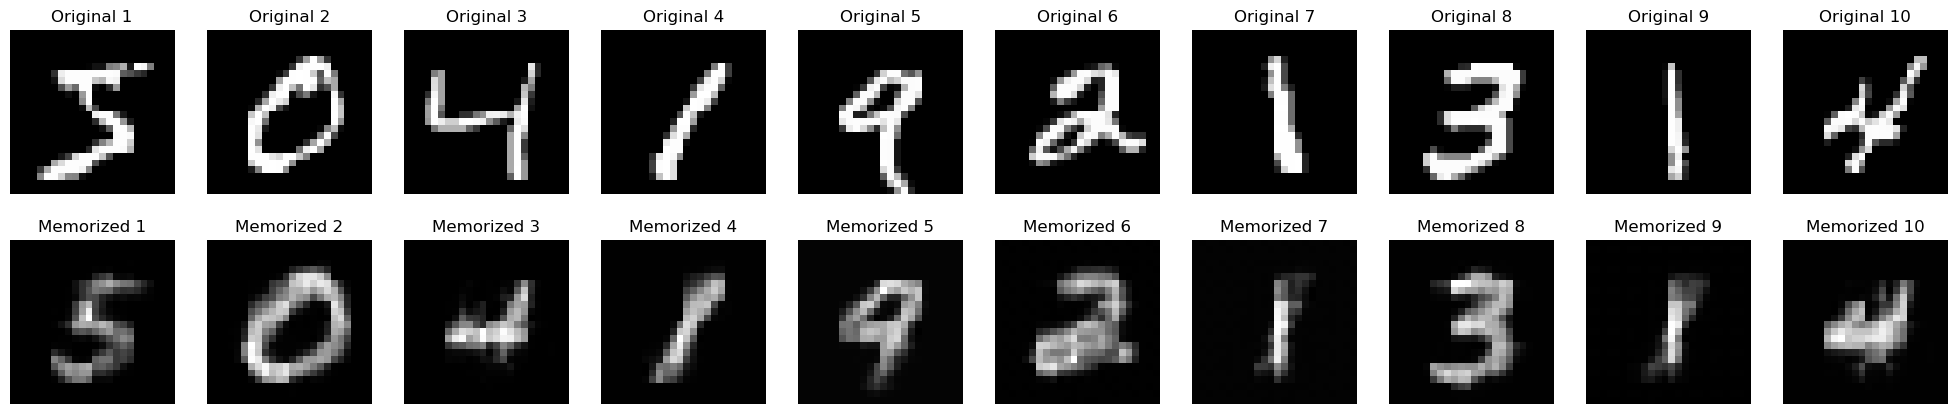

Epoch 63 | Train loss 0.000004 | Memorization loss 0.139095
Visualizing results at Epoch 64


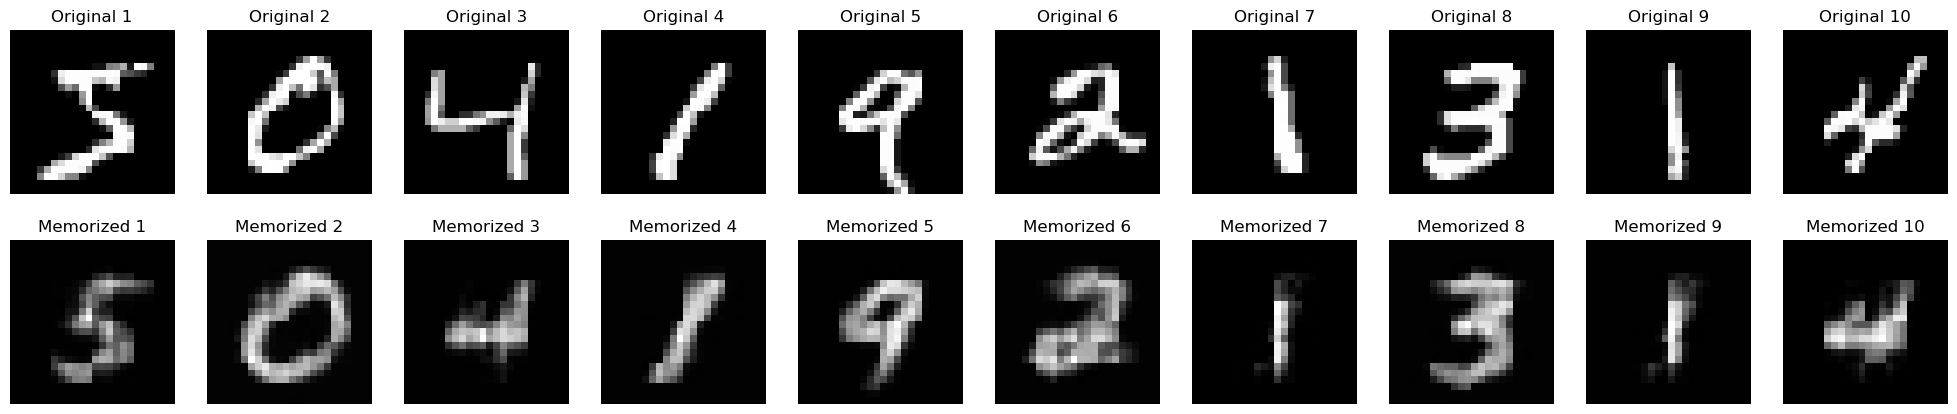

Epoch 64 | Train loss 0.000004 | Memorization loss 0.128813
Saved model and optimizer with memorization loss: 0.1288
Visualizing results at Epoch 65


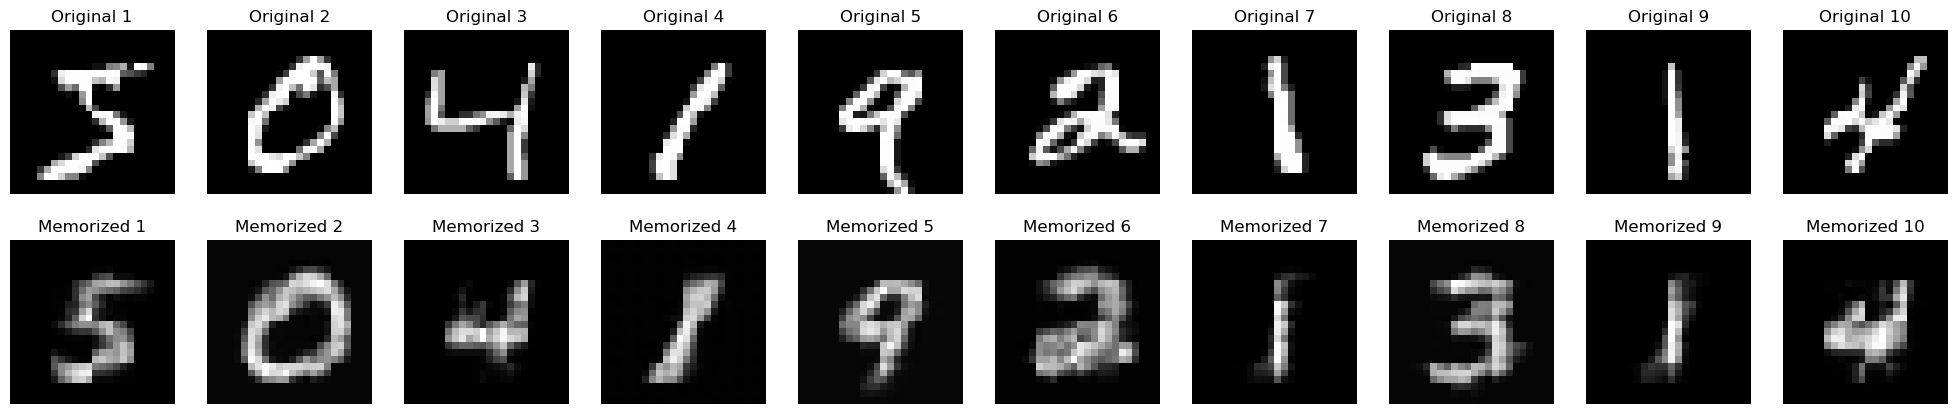

Epoch 65 | Train loss 0.000008 | Memorization loss 0.134602
Visualizing results at Epoch 66


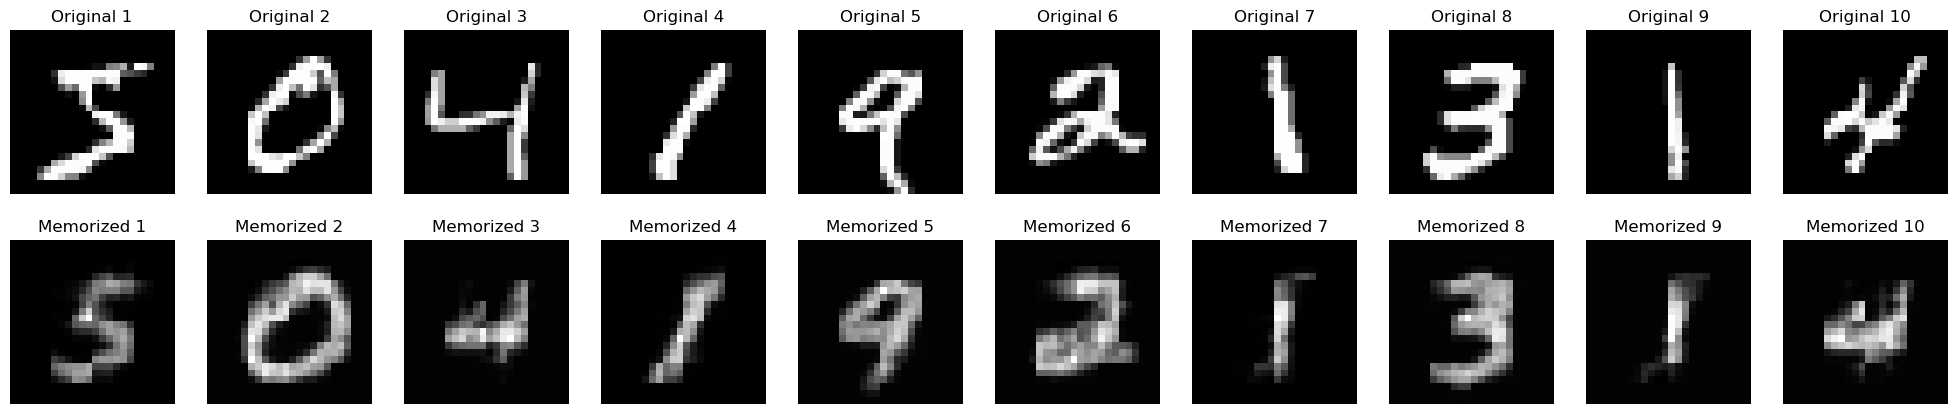

Epoch 66 | Train loss 0.000009 | Memorization loss 0.134721
Visualizing results at Epoch 67


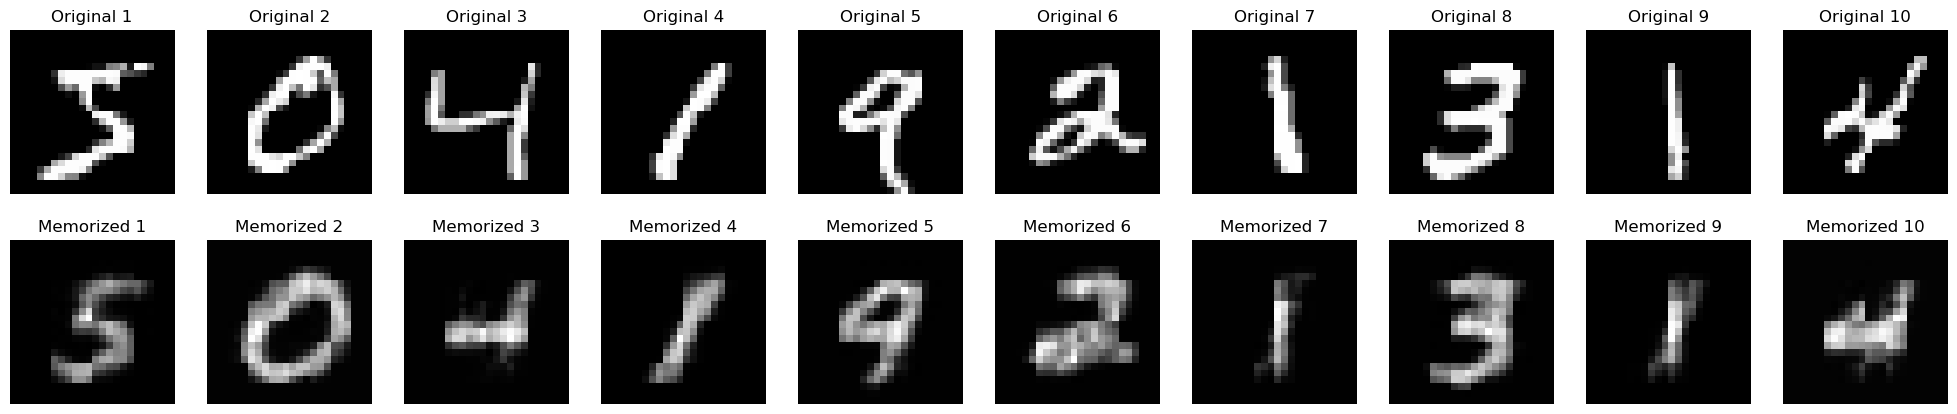

Epoch 67 | Train loss 0.000005 | Memorization loss 0.134643
Visualizing results at Epoch 68


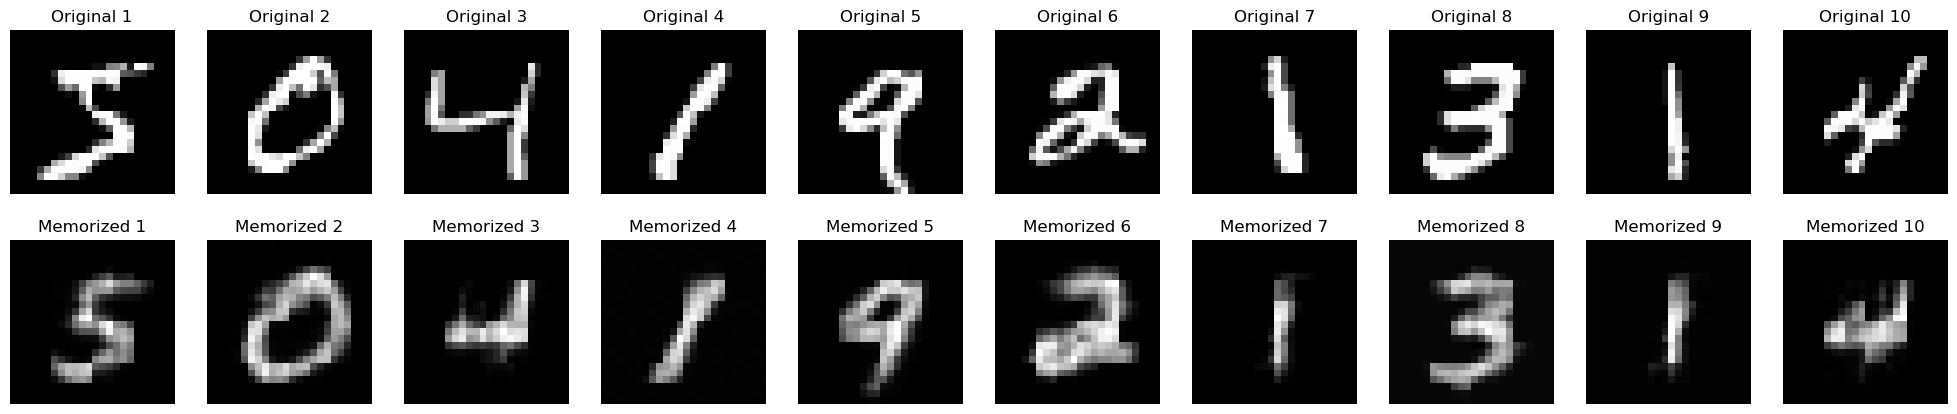

Epoch 68 | Train loss 0.000003 | Memorization loss 0.128024
Saved model and optimizer with memorization loss: 0.1280
Visualizing results at Epoch 69


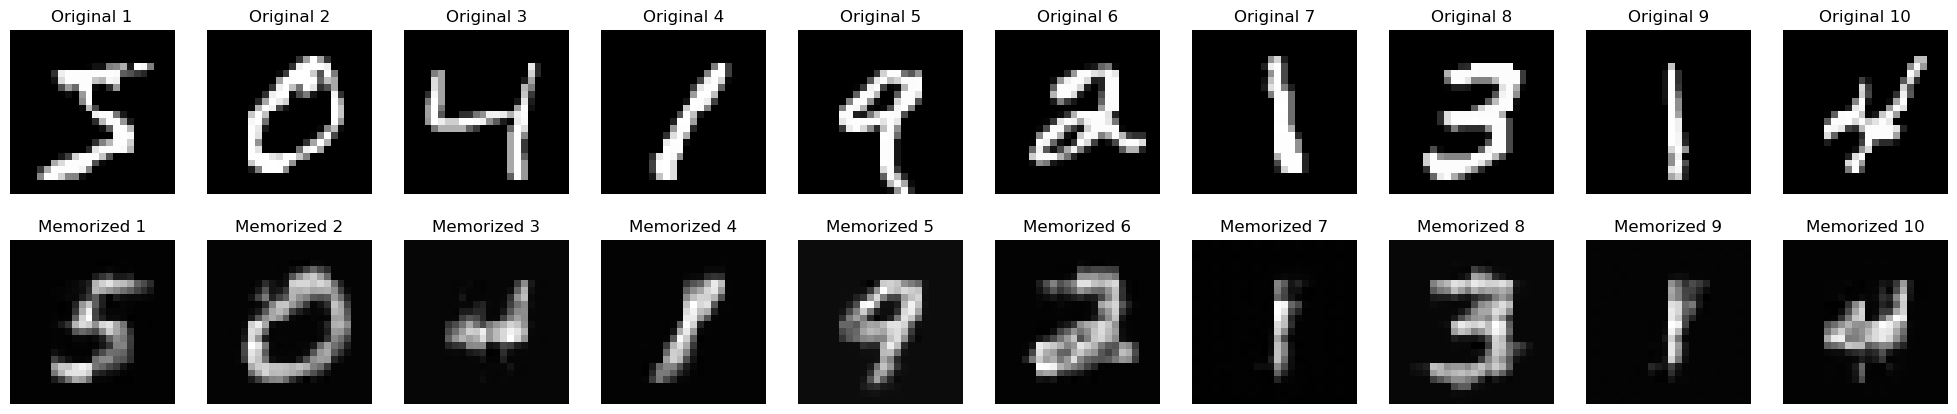

Epoch 69 | Train loss 0.000004 | Memorization loss 0.127307
Saved model and optimizer with memorization loss: 0.1273
Visualizing results at Epoch 70


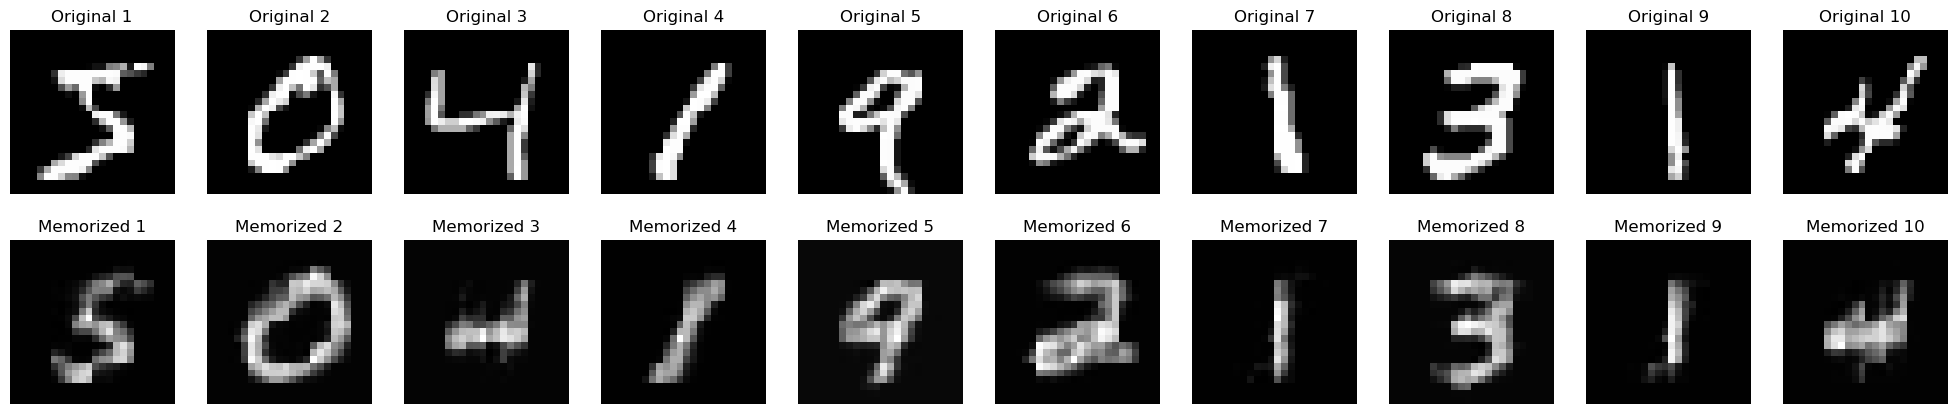

Epoch 70 | Train loss 0.000012 | Memorization loss 0.130874
Visualizing results at Epoch 71


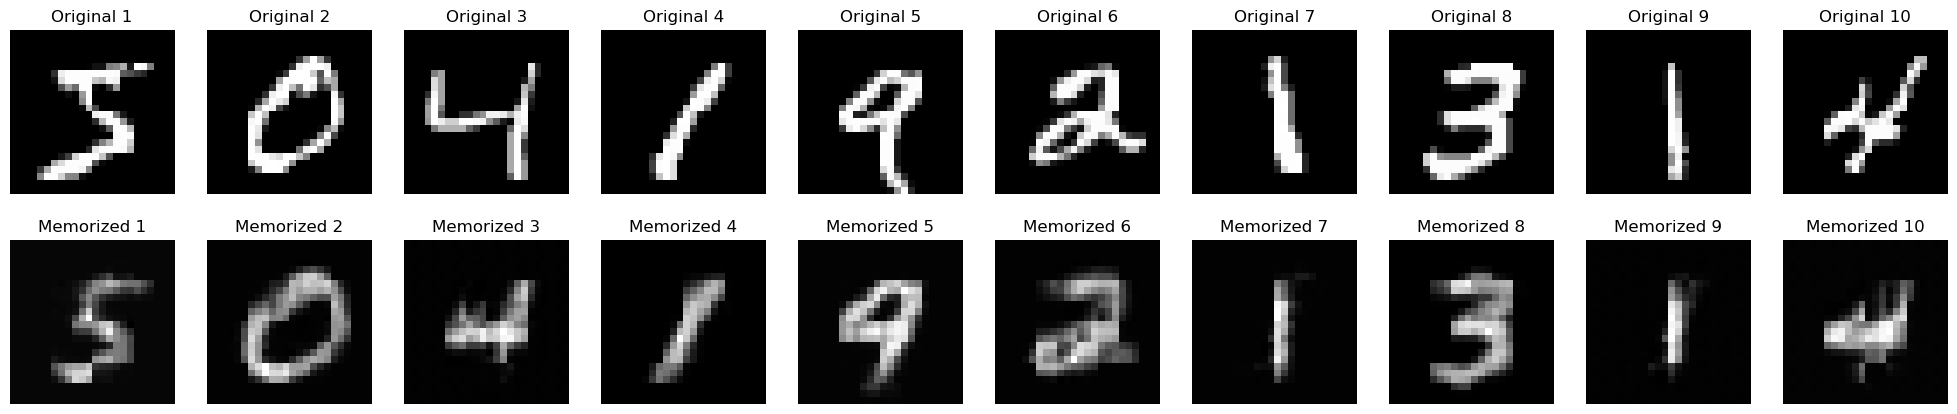

Epoch 71 | Train loss 0.000022 | Memorization loss 0.130869
Visualizing results at Epoch 72


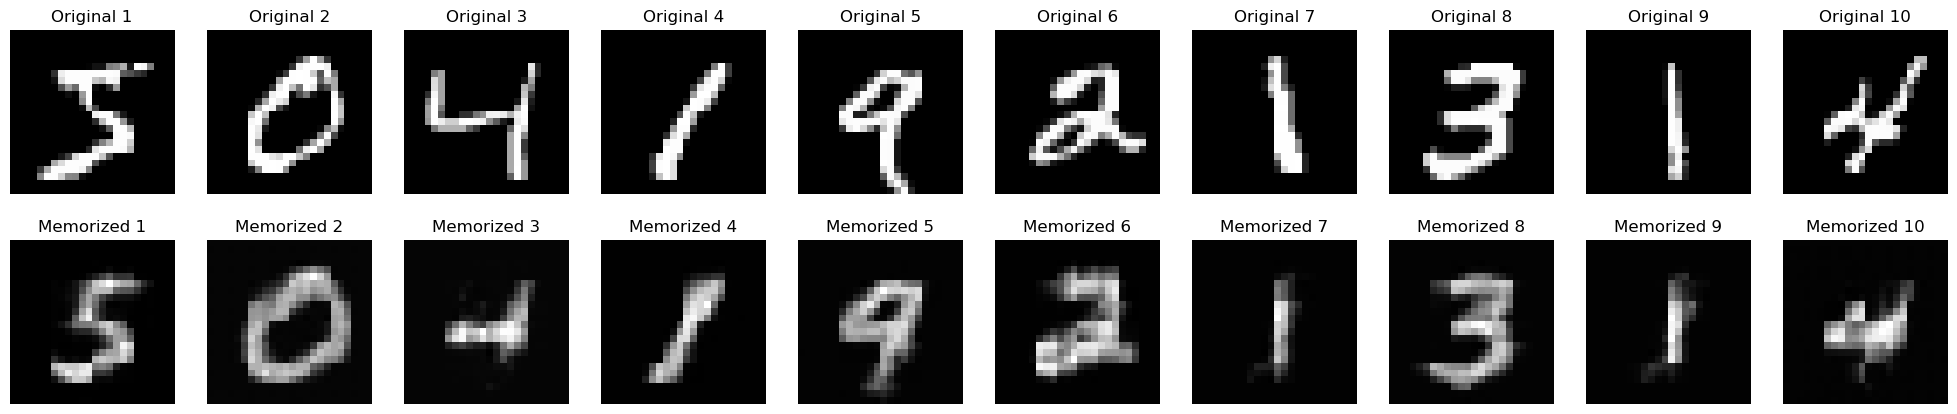

Epoch 72 | Train loss 0.000005 | Memorization loss 0.126613
Saved model and optimizer with memorization loss: 0.1266
Visualizing results at Epoch 73


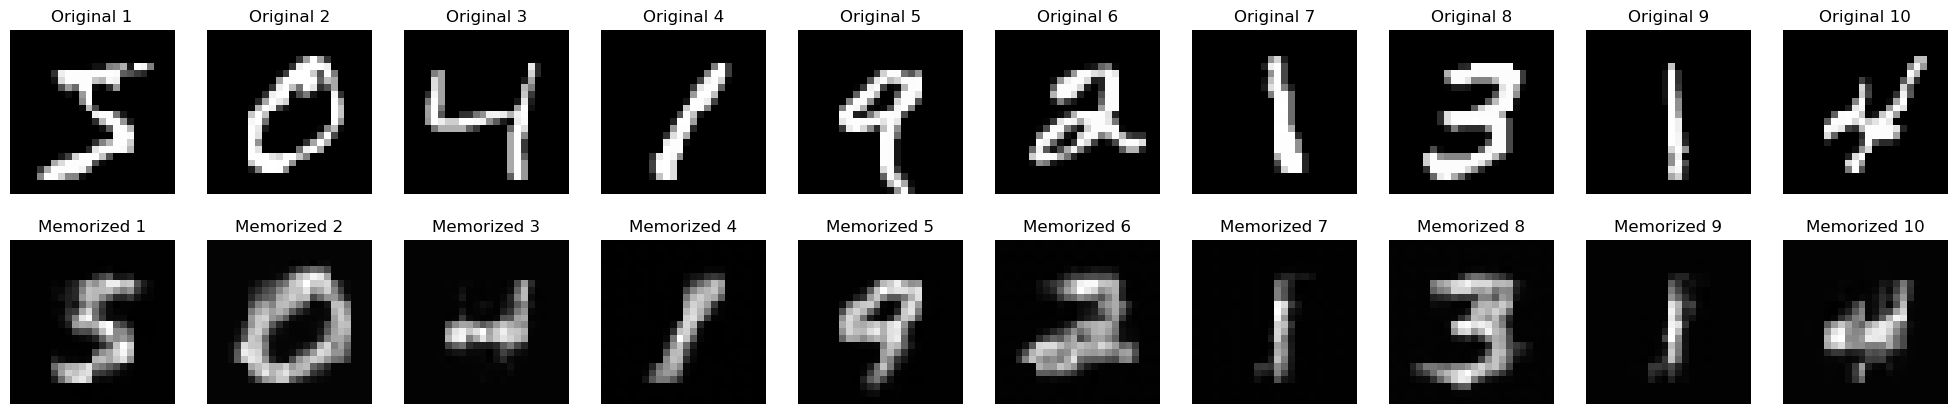

Epoch 73 | Train loss 0.000004 | Memorization loss 0.122316
Saved model and optimizer with memorization loss: 0.1223
Visualizing results at Epoch 74


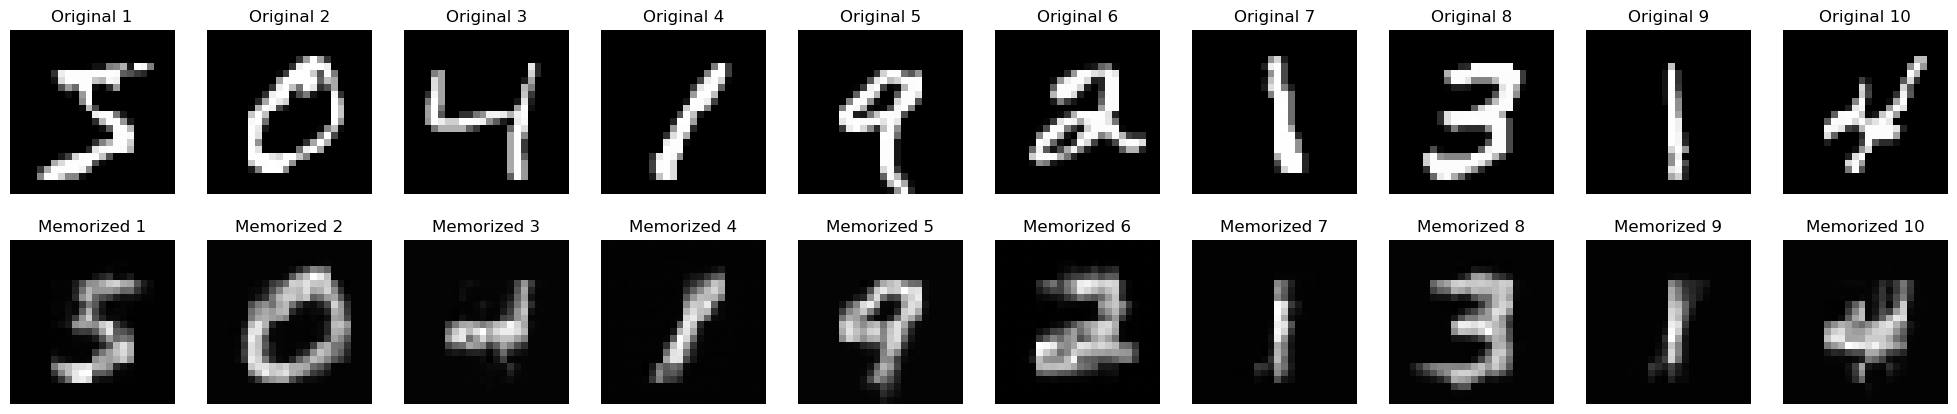

Epoch 74 | Train loss 0.000017 | Memorization loss 0.123901
Visualizing results at Epoch 75


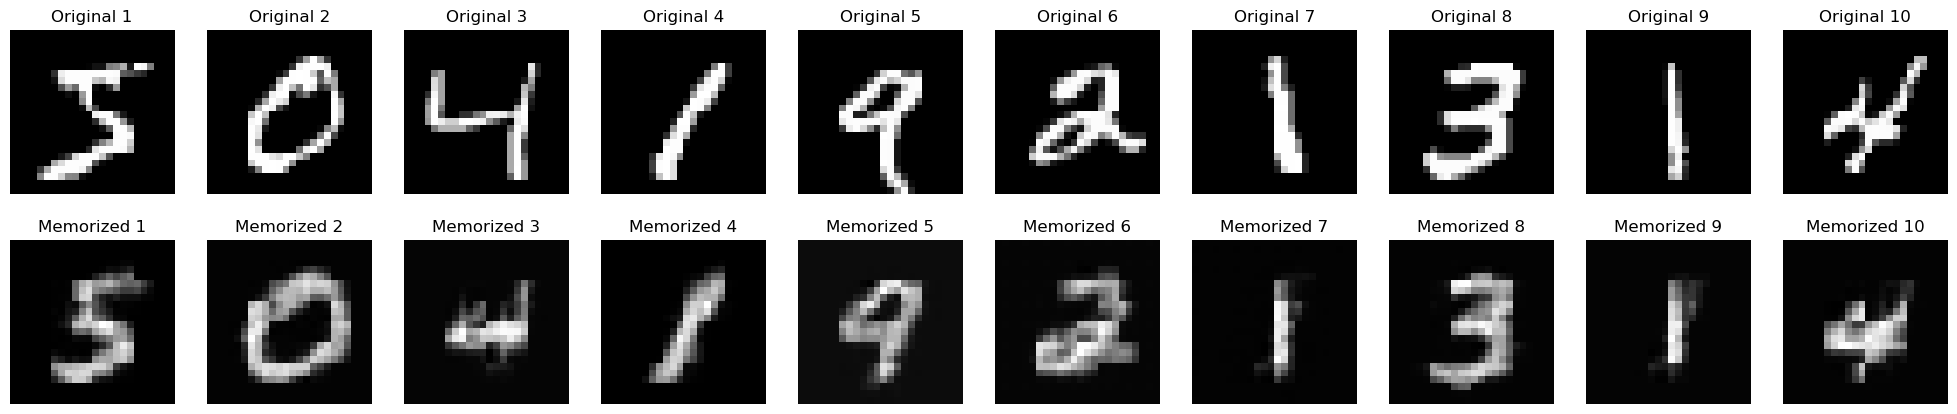

Epoch 75 | Train loss 0.000004 | Memorization loss 0.126682
Visualizing results at Epoch 76


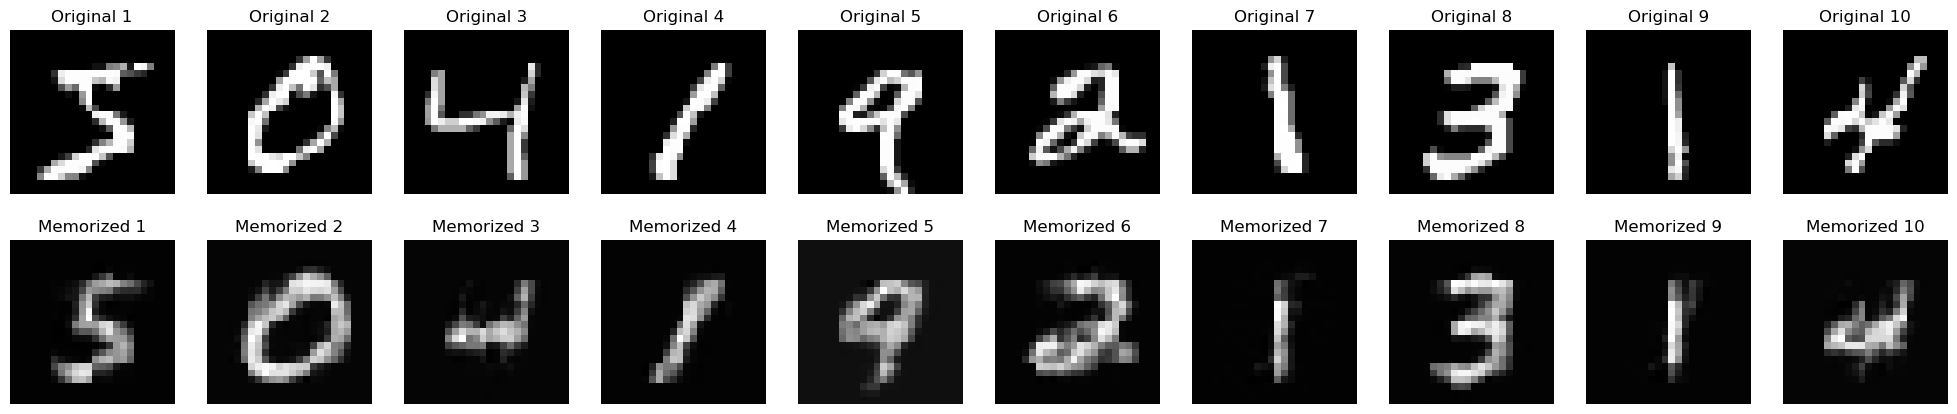

Epoch 76 | Train loss 0.000004 | Memorization loss 0.123639
Visualizing results at Epoch 77


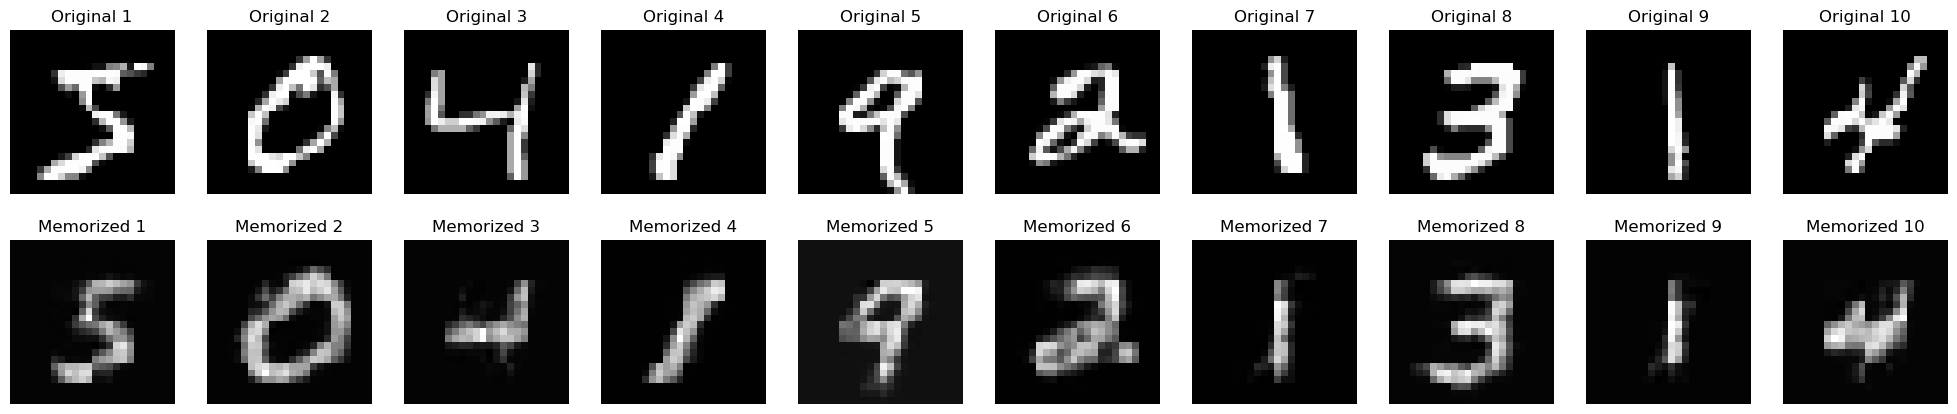

Epoch 77 | Train loss 0.000002 | Memorization loss 0.116807
Saved model and optimizer with memorization loss: 0.1168
Visualizing results at Epoch 78


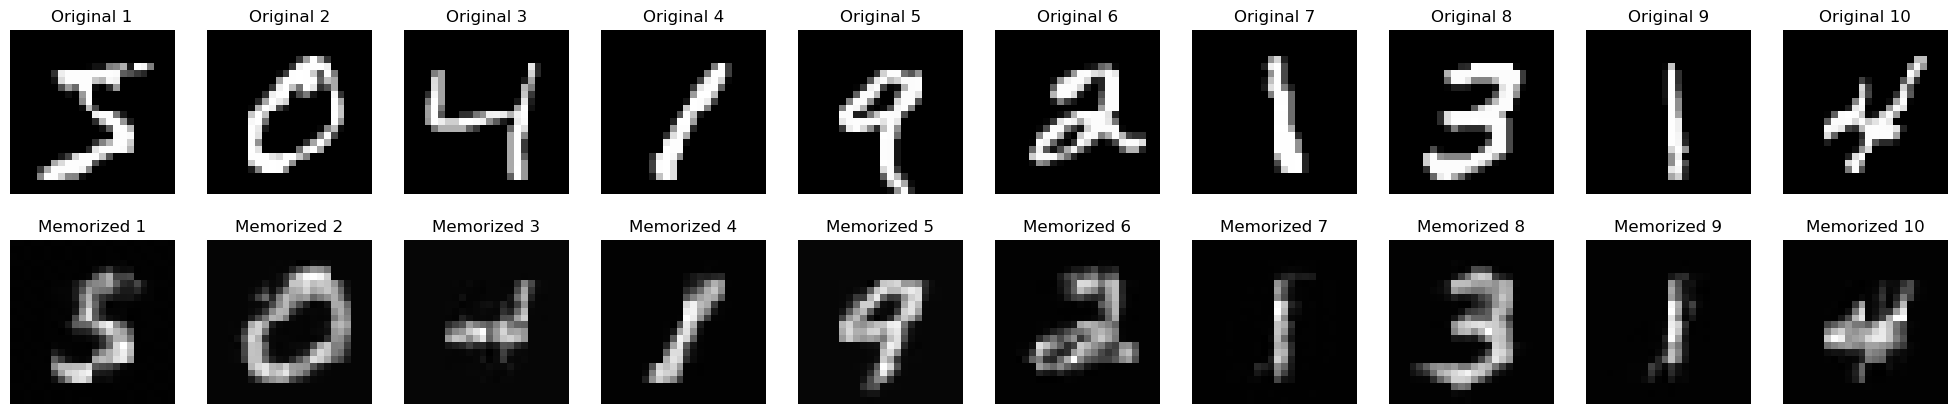

Epoch 78 | Train loss 0.000003 | Memorization loss 0.119280
Visualizing results at Epoch 79


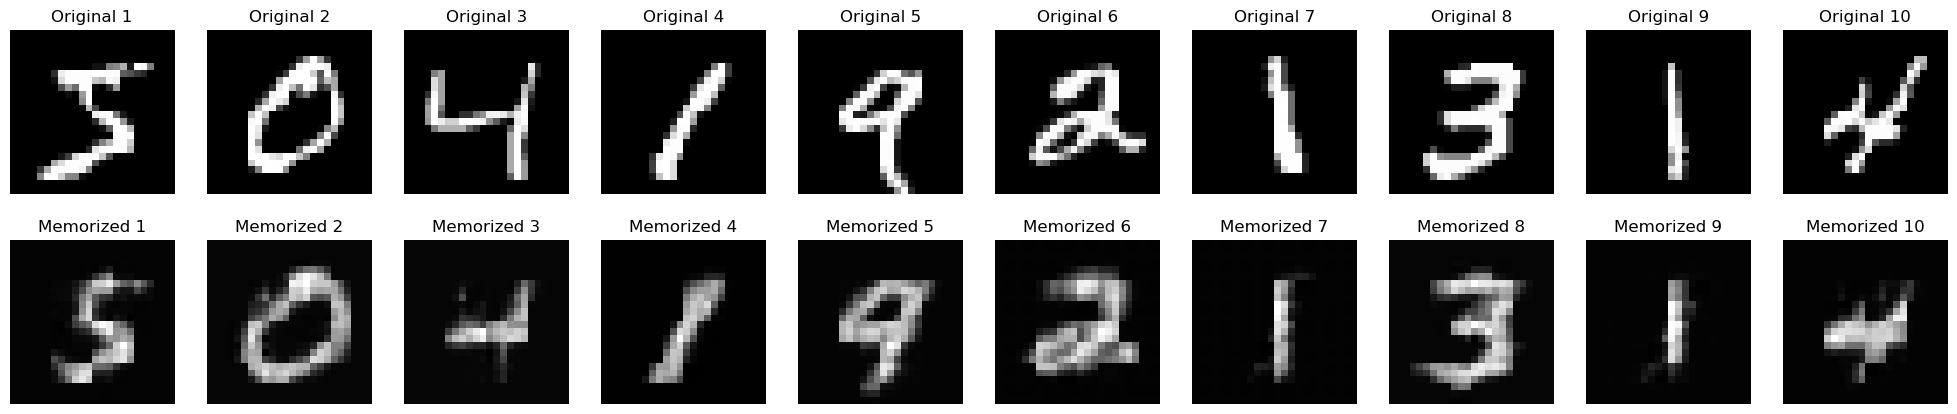

Epoch 79 | Train loss 0.000032 | Memorization loss 0.121438
Visualizing results at Epoch 80


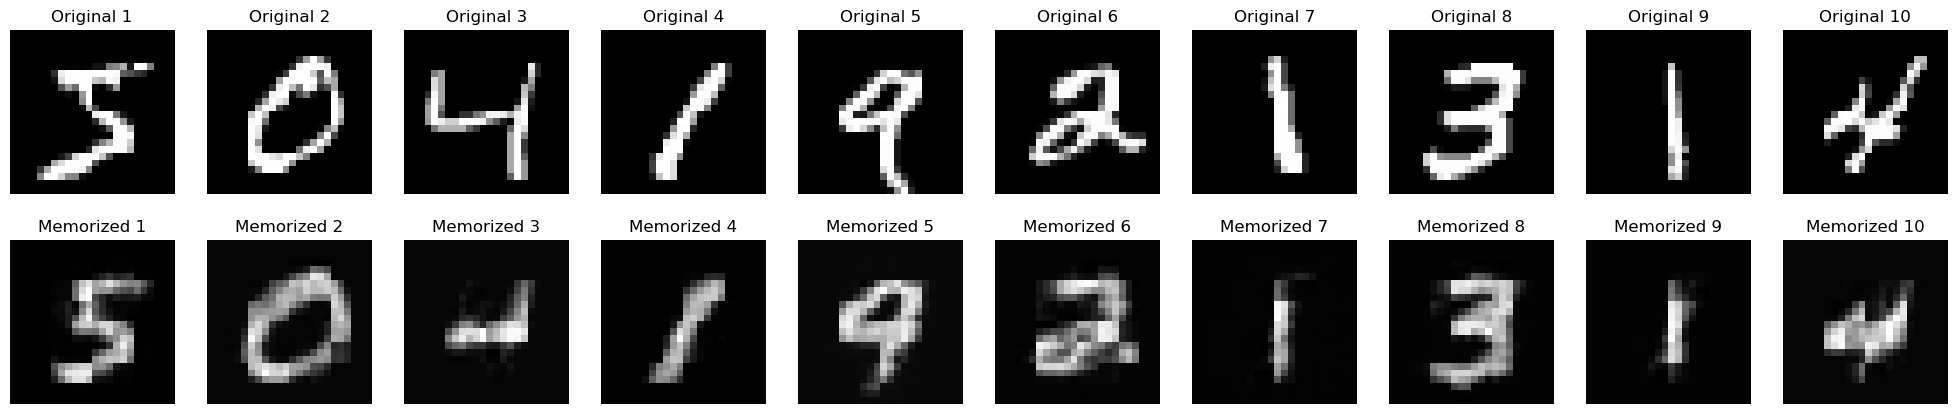

Epoch 80 | Train loss 0.000007 | Memorization loss 0.122982
Visualizing results at Epoch 81


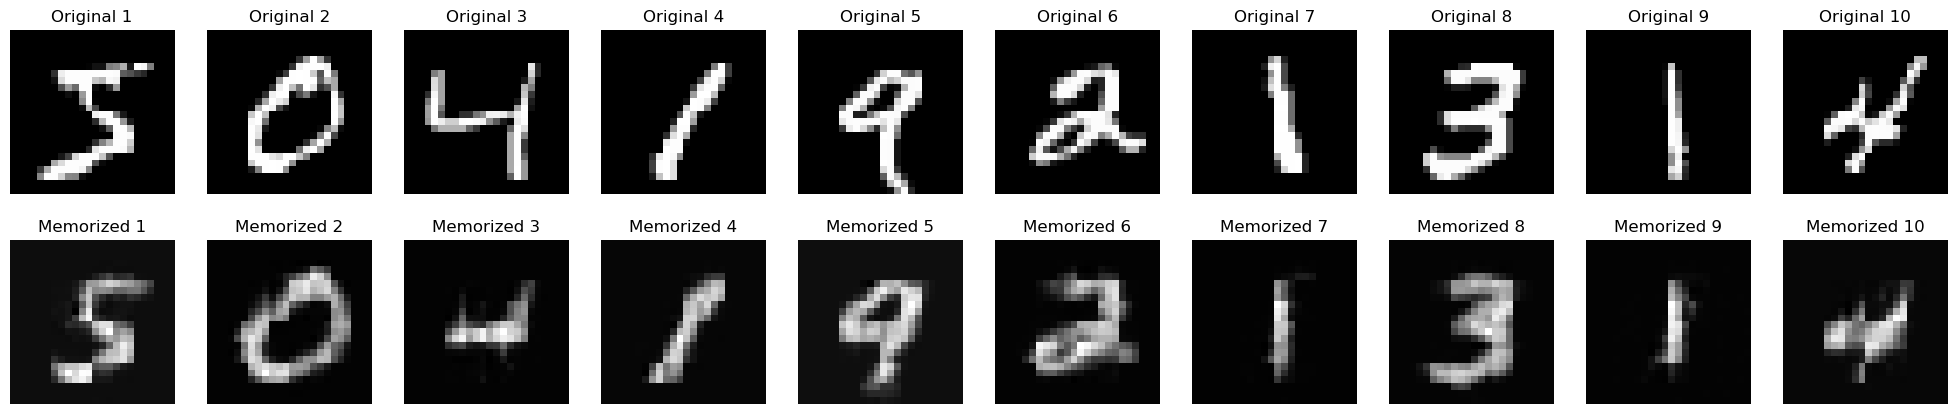

Epoch 81 | Train loss 0.000003 | Memorization loss 0.111975
Saved model and optimizer with memorization loss: 0.1120
Visualizing results at Epoch 82


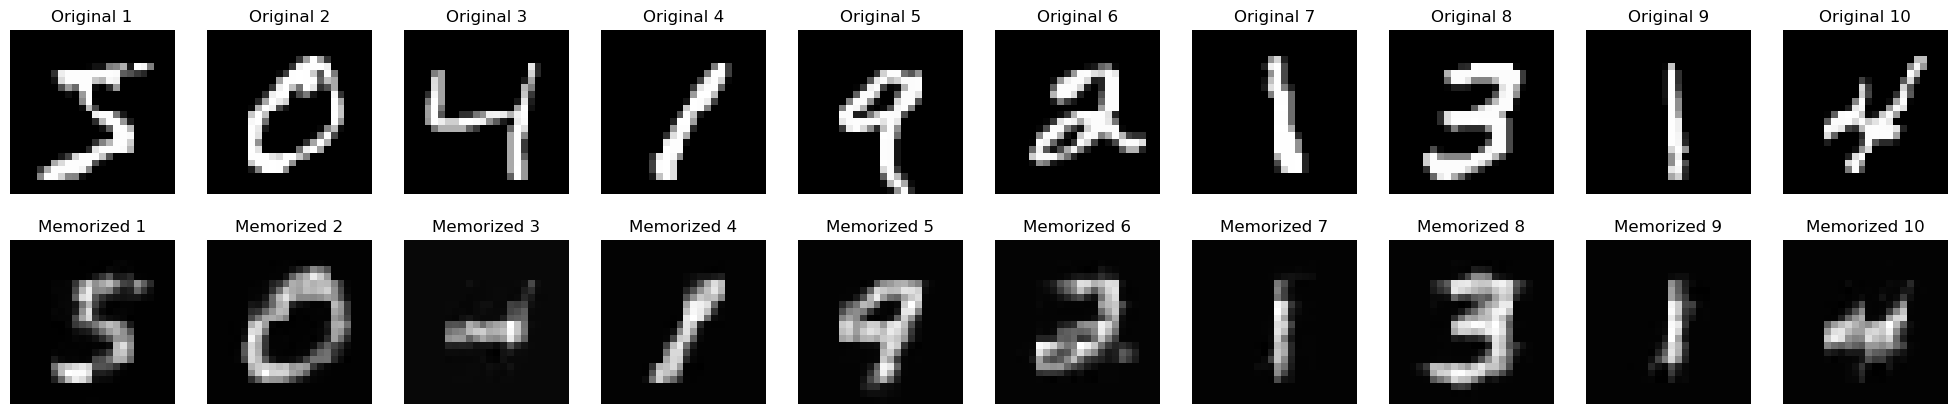

Epoch 82 | Train loss 0.000003 | Memorization loss 0.115061
Visualizing results at Epoch 83


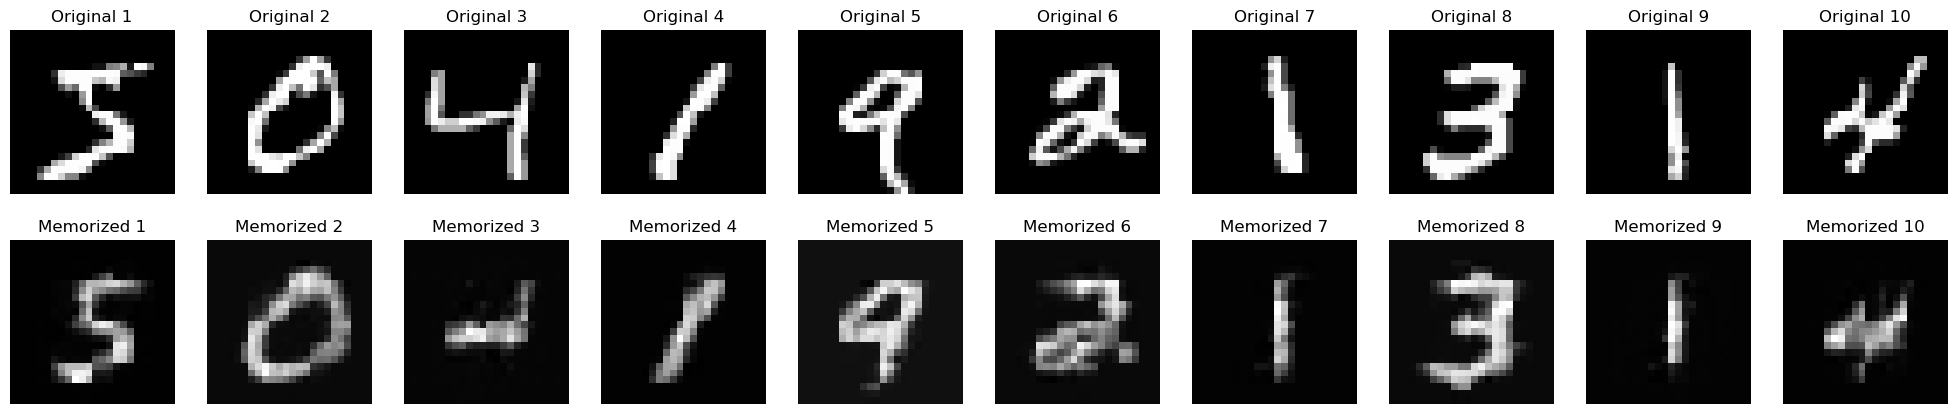

Epoch 83 | Train loss 0.000008 | Memorization loss 0.117785
Visualizing results at Epoch 84


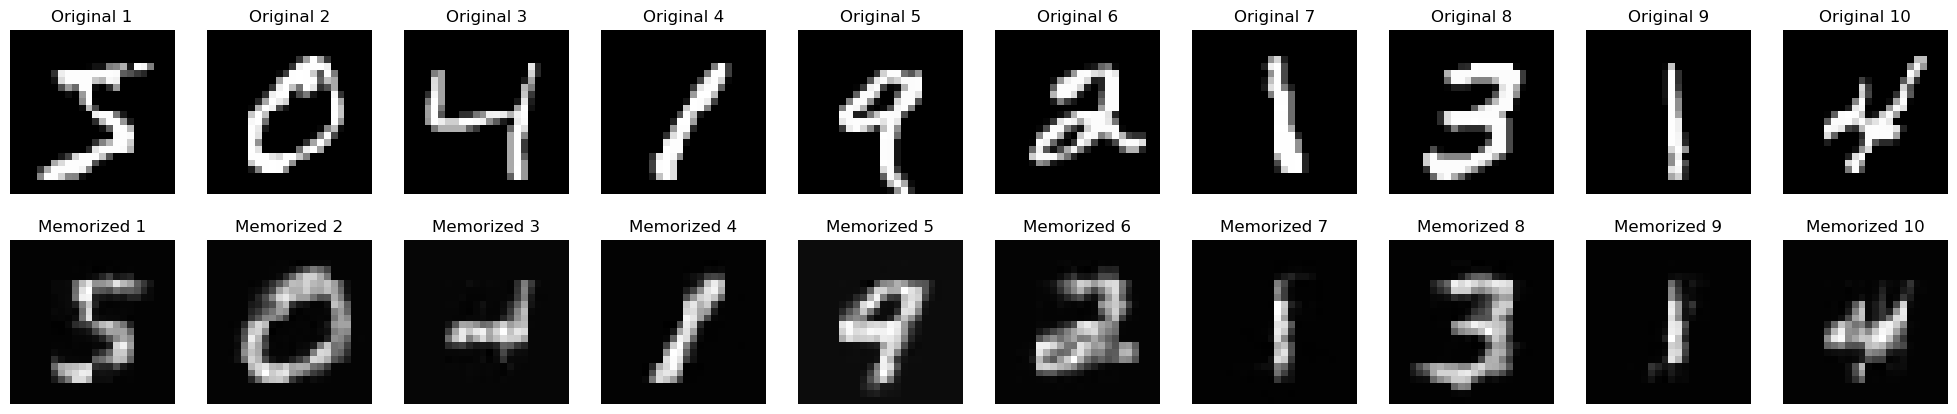

Epoch 84 | Train loss 0.000005 | Memorization loss 0.114612
Visualizing results at Epoch 85


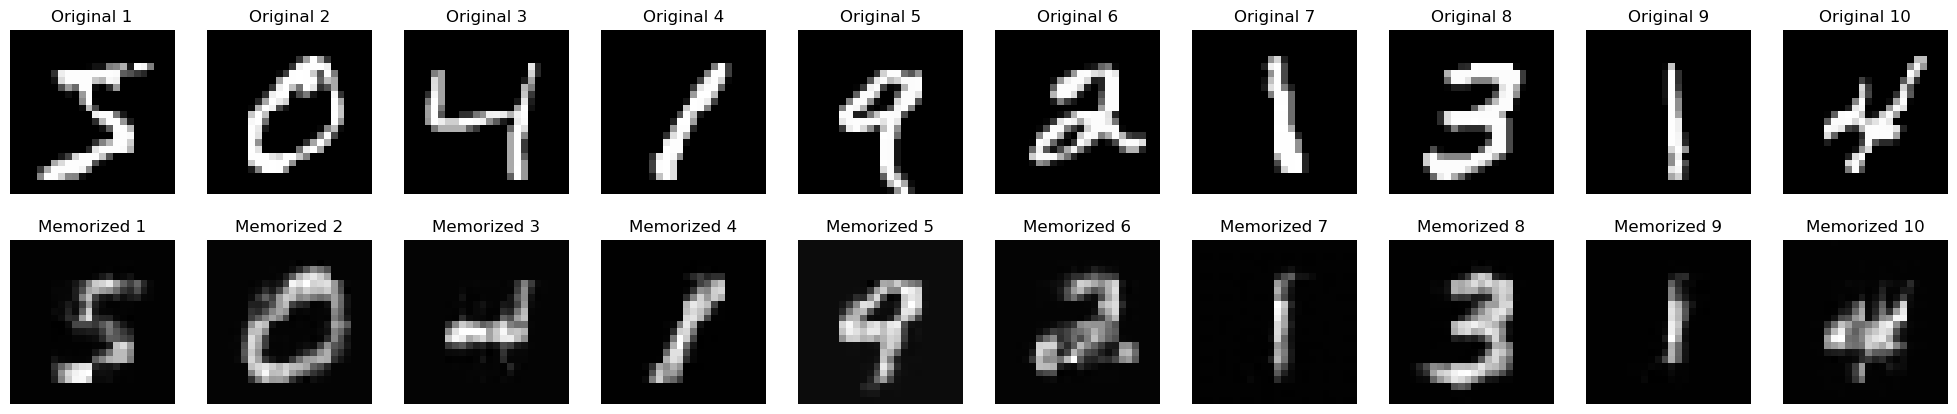

Epoch 85 | Train loss 0.000003 | Memorization loss 0.109241
Saved model and optimizer with memorization loss: 0.1092
Visualizing results at Epoch 86


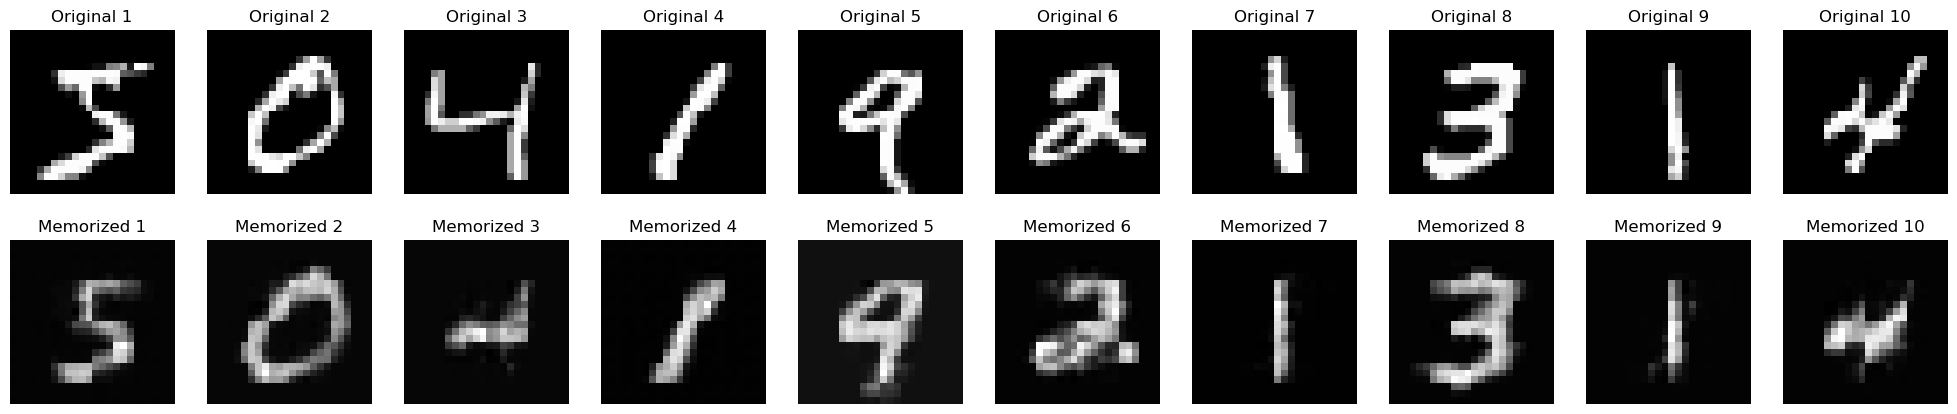

Epoch 86 | Train loss 0.000044 | Memorization loss 0.108284
Saved model and optimizer with memorization loss: 0.1083
Visualizing results at Epoch 87


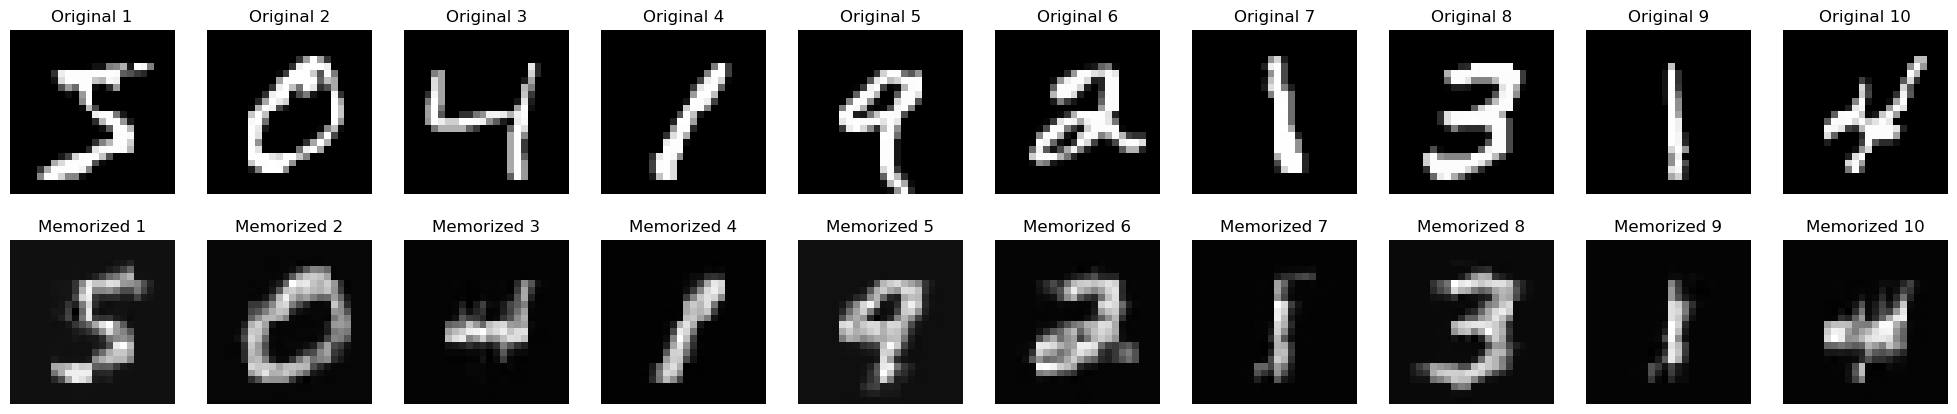

Epoch 87 | Train loss 0.000008 | Memorization loss 0.111673
Visualizing results at Epoch 88


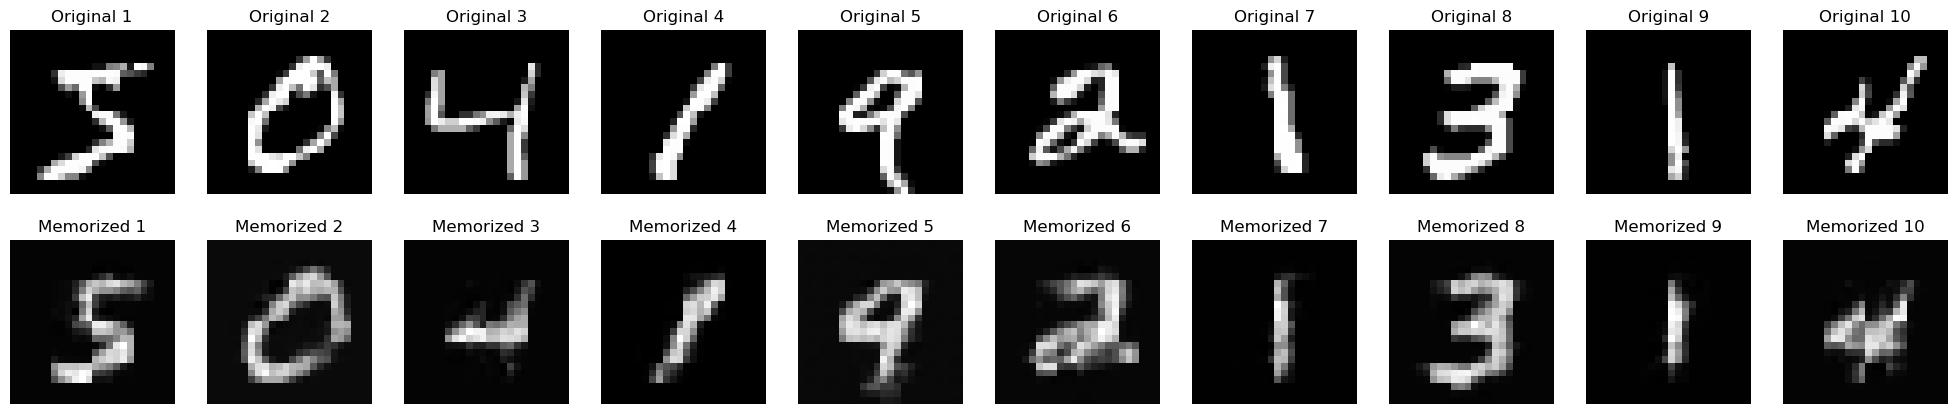

Epoch 88 | Train loss 0.000007 | Memorization loss 0.112881
Visualizing results at Epoch 89


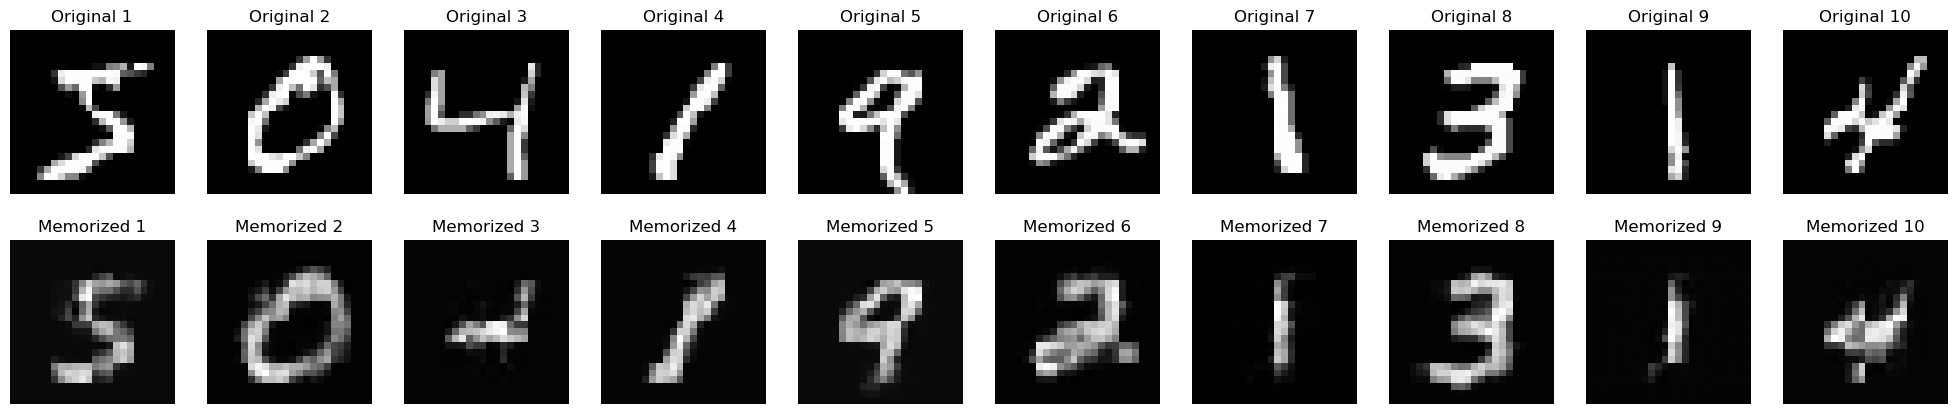

Epoch 89 | Train loss 0.000003 | Memorization loss 0.107847
Saved model and optimizer with memorization loss: 0.1078
Visualizing results at Epoch 90


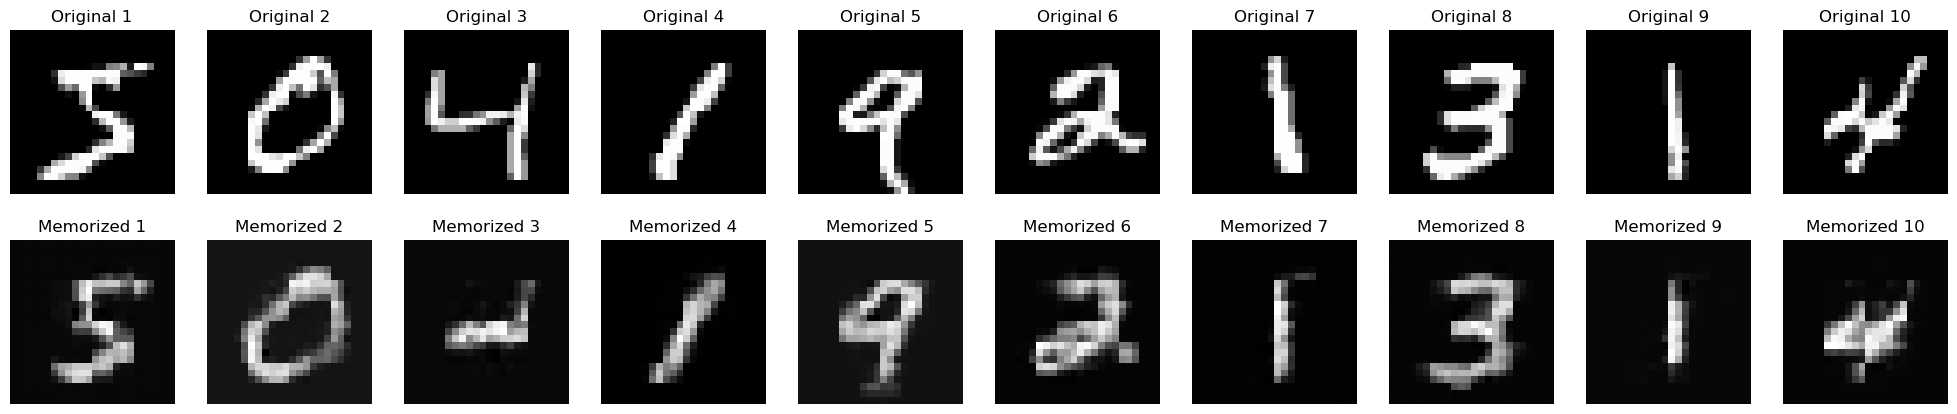

Epoch 90 | Train loss 0.000004 | Memorization loss 0.103186
Saved model and optimizer with memorization loss: 0.1032
Visualizing results at Epoch 91


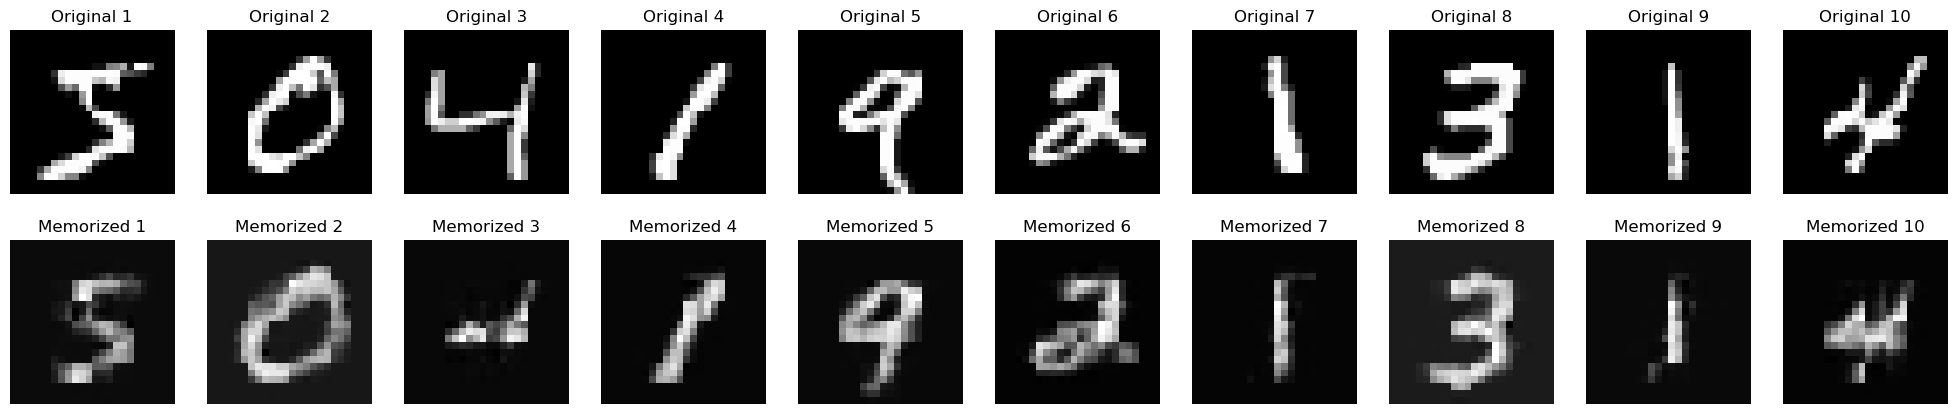

Epoch 91 | Train loss 0.000006 | Memorization loss 0.105726
Visualizing results at Epoch 92


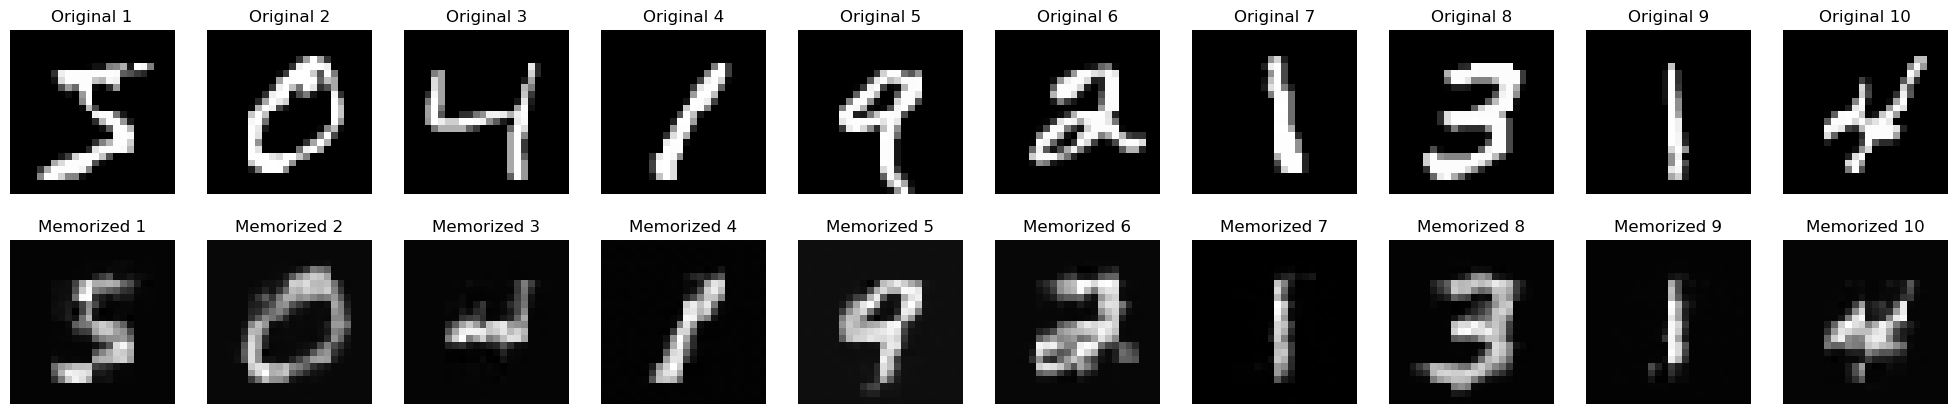

Epoch 92 | Train loss 0.000006 | Memorization loss 0.107200
Visualizing results at Epoch 93


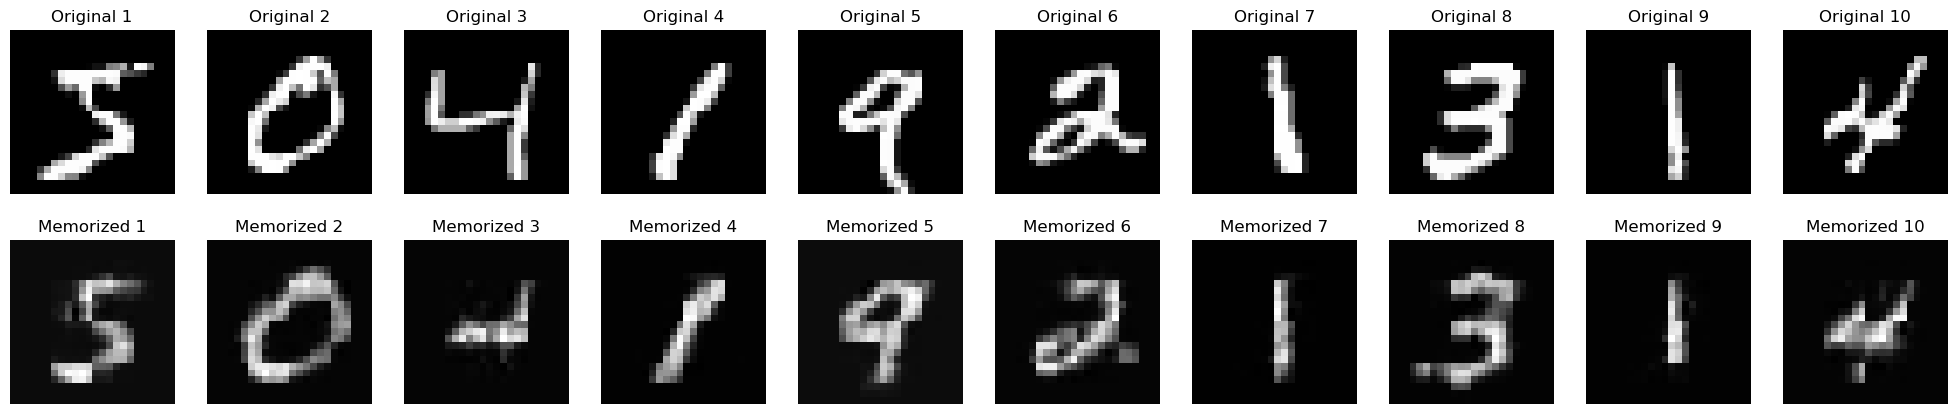

Epoch 93 | Train loss 0.000007 | Memorization loss 0.106124
Visualizing results at Epoch 94


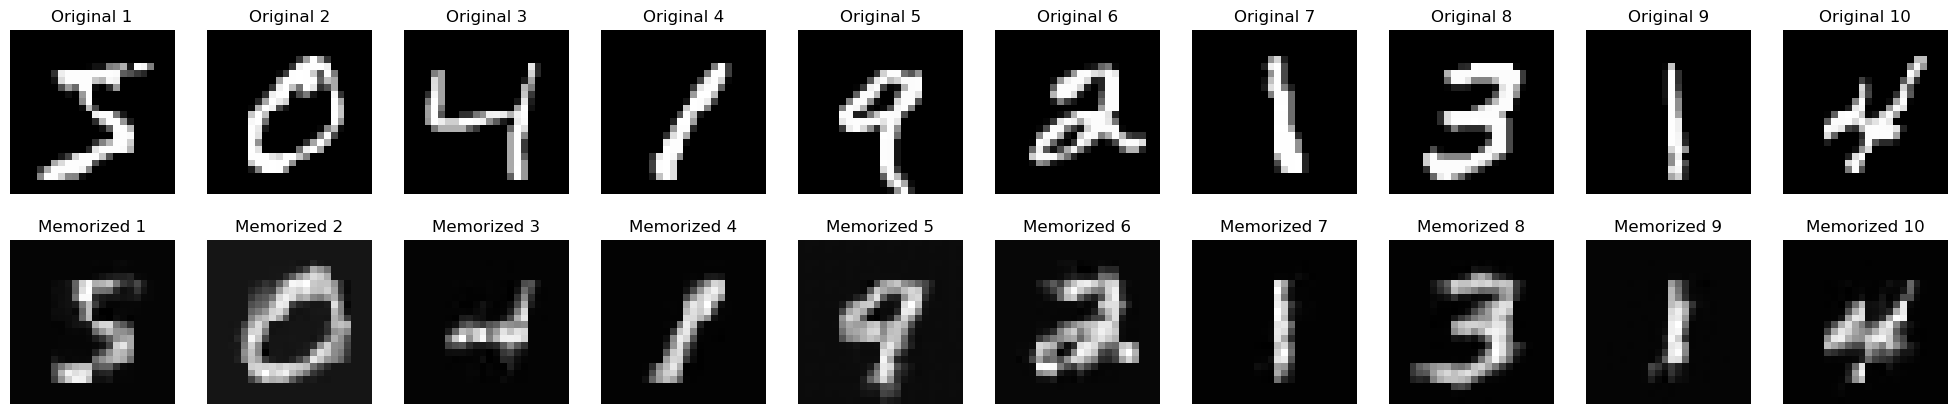

Epoch 94 | Train loss 0.000012 | Memorization loss 0.099040
Saved model and optimizer with memorization loss: 0.0990
Visualizing results at Epoch 95


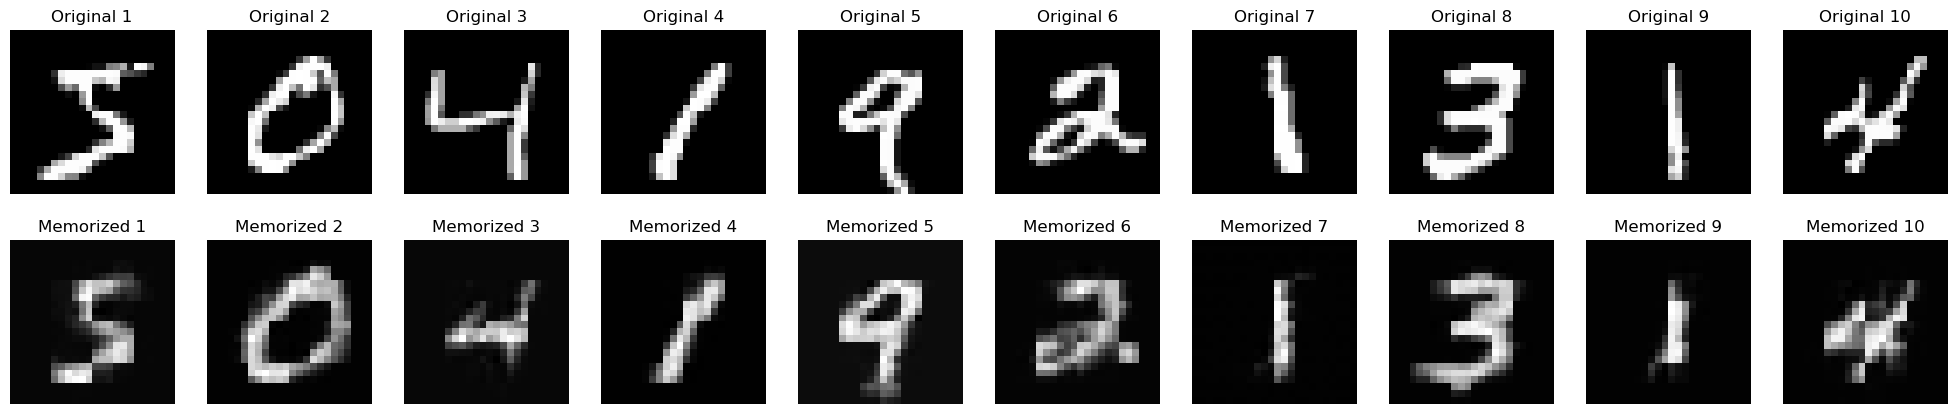

Epoch 95 | Train loss 0.000005 | Memorization loss 0.100769
Visualizing results at Epoch 96


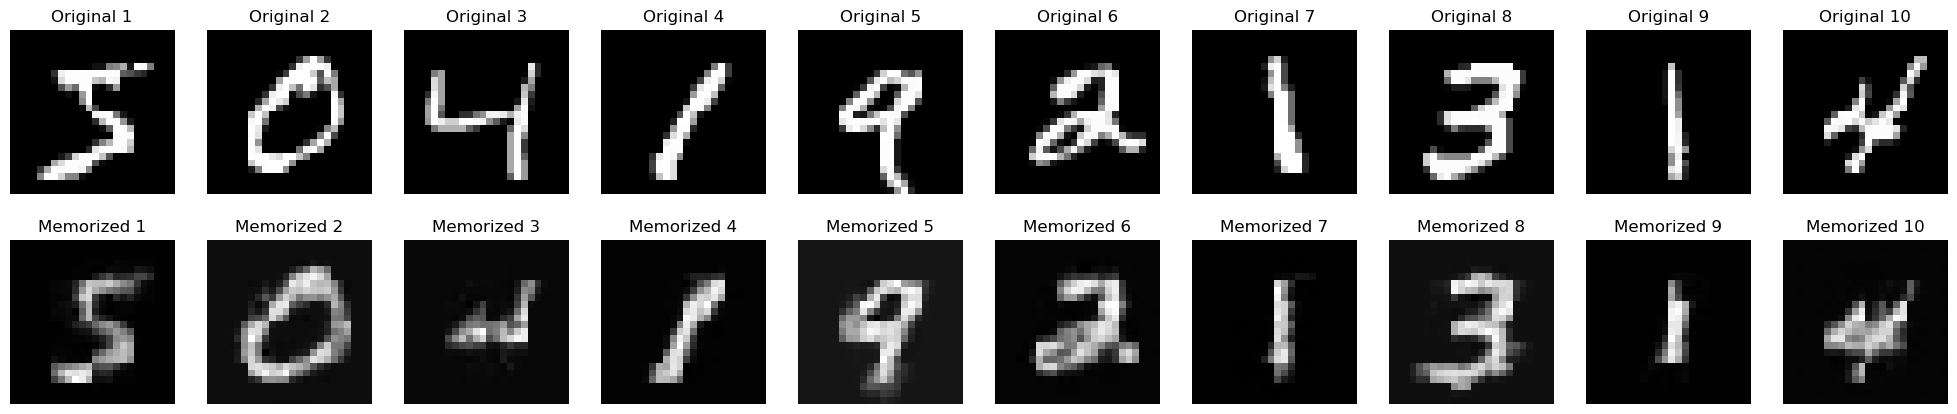

Epoch 96 | Train loss 0.000003 | Memorization loss 0.102093
Visualizing results at Epoch 97


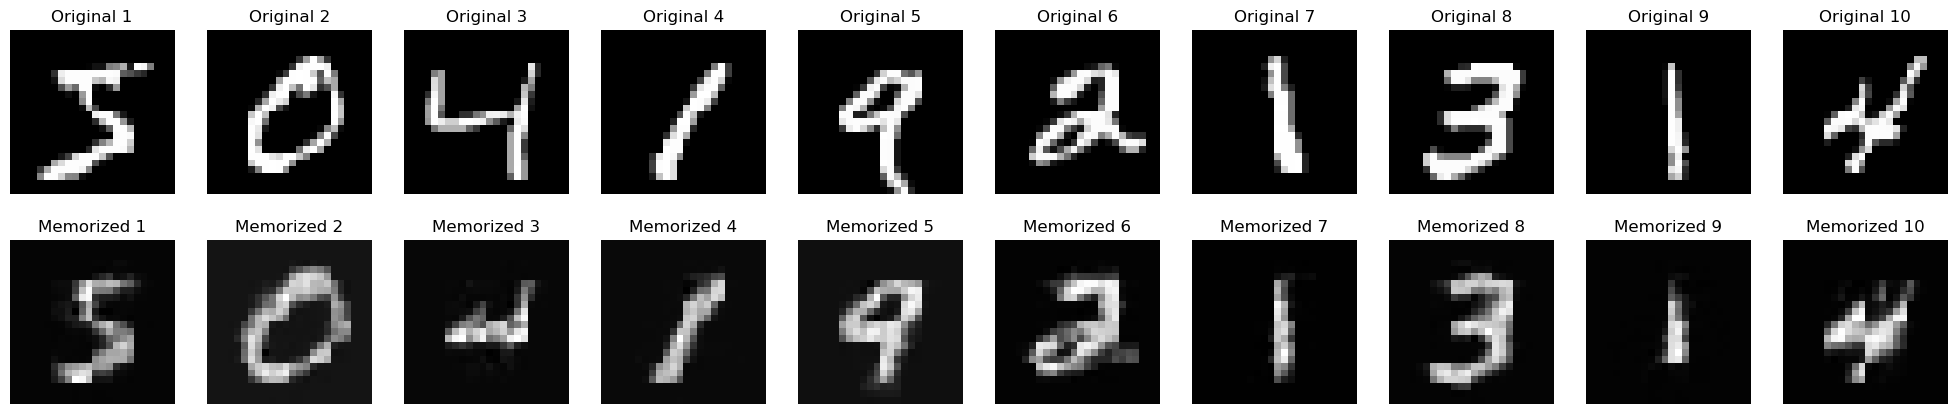

Epoch 97 | Train loss 0.000003 | Memorization loss 0.103470
Visualizing results at Epoch 98


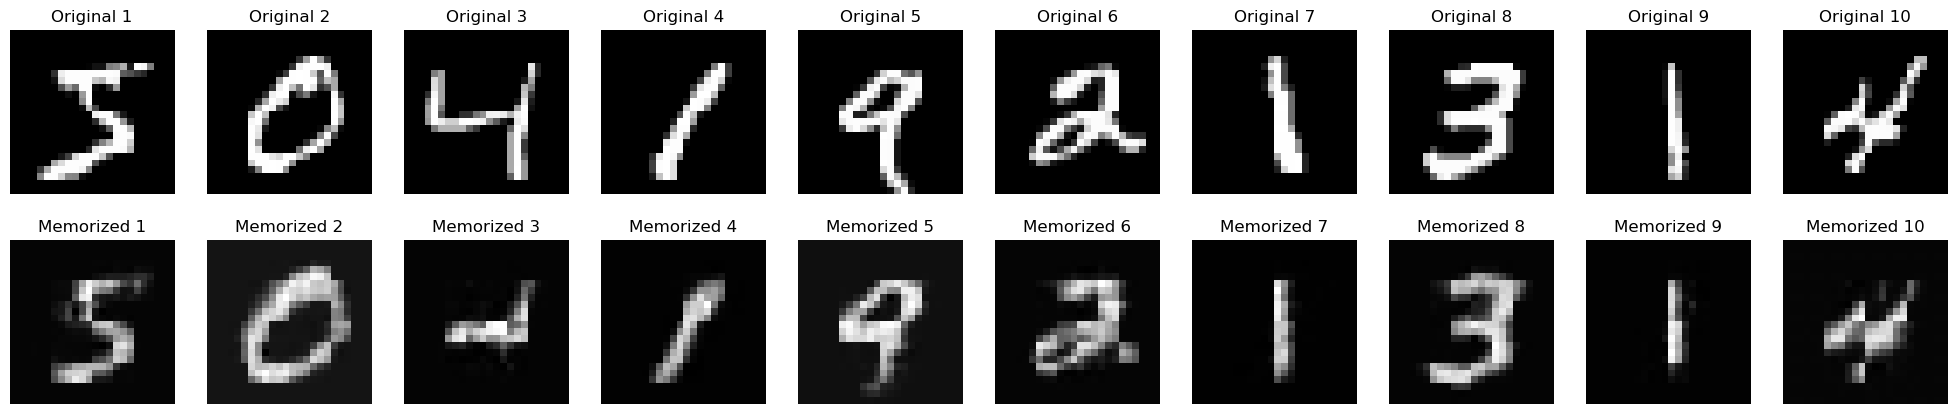

Epoch 98 | Train loss 0.000022 | Memorization loss 0.093622
Saved model and optimizer with memorization loss: 0.0936
Visualizing results at Epoch 99


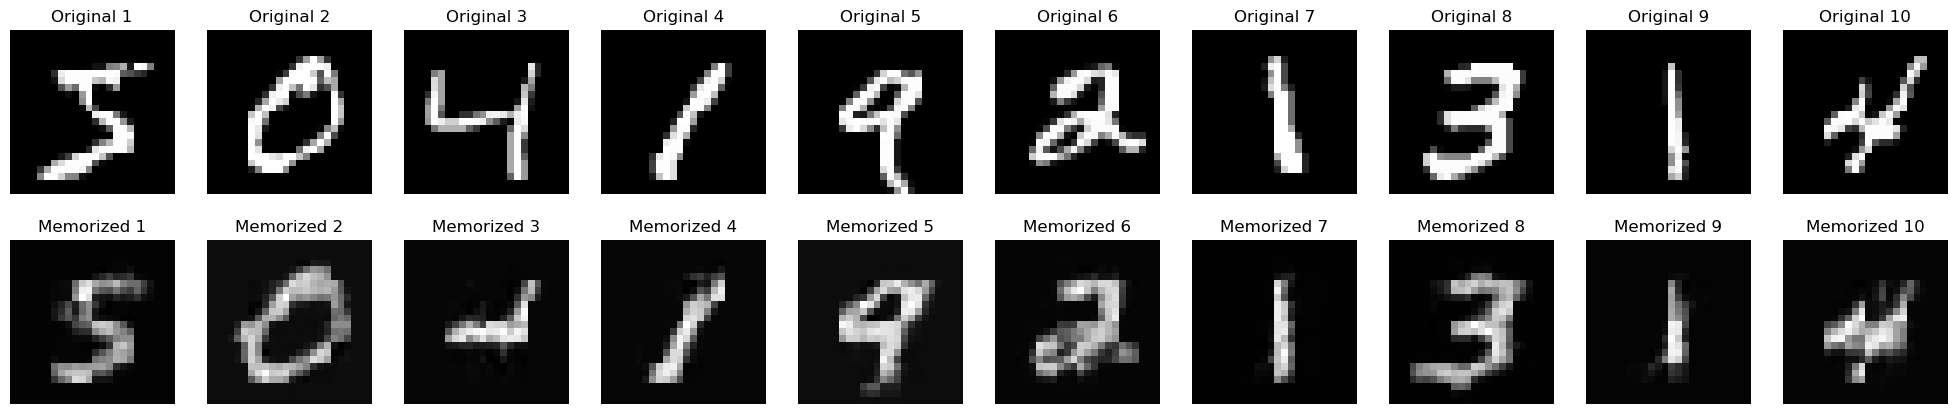

Epoch 99 | Train loss 0.000013 | Memorization loss 0.096012
Visualizing results at Epoch 100


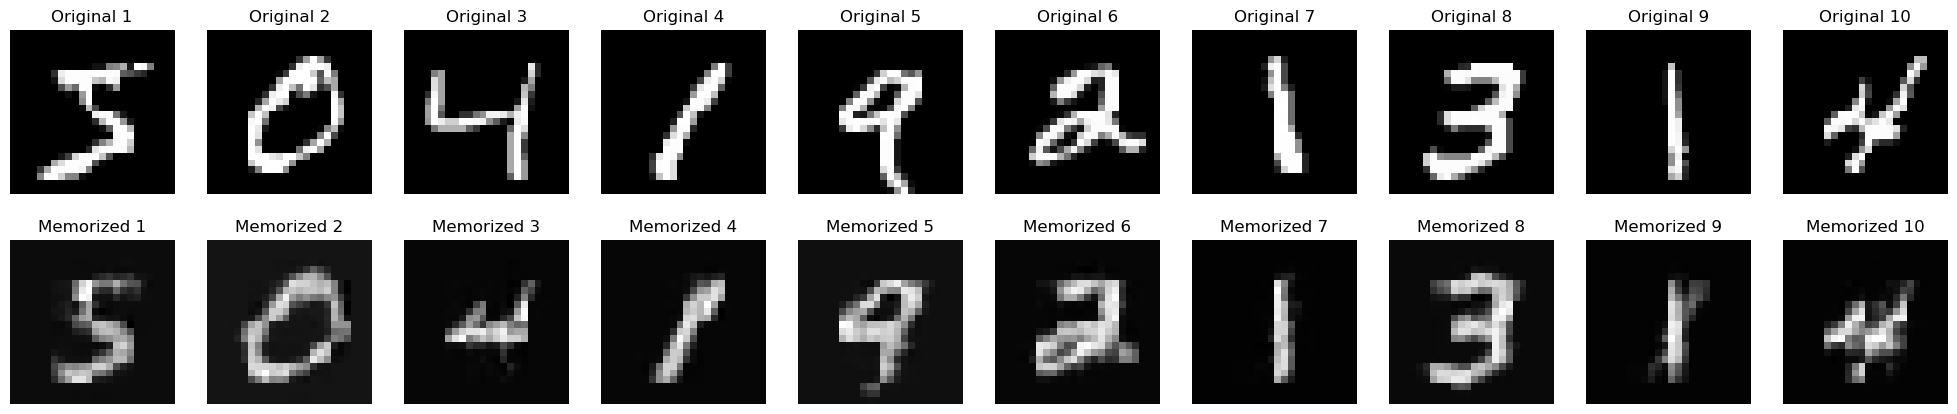

Epoch 100 | Train loss 0.000016 | Memorization loss 0.097468
Visualizing results at Epoch 101


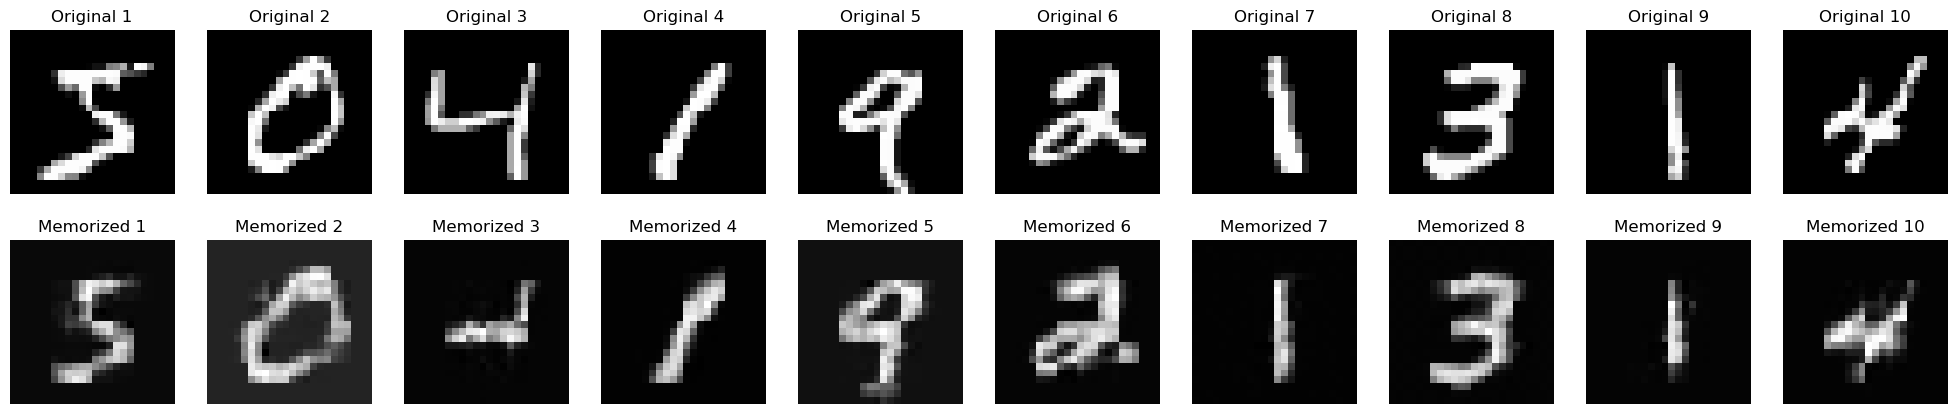

Epoch 101 | Train loss 0.000003 | Memorization loss 0.100506
Visualizing results at Epoch 102


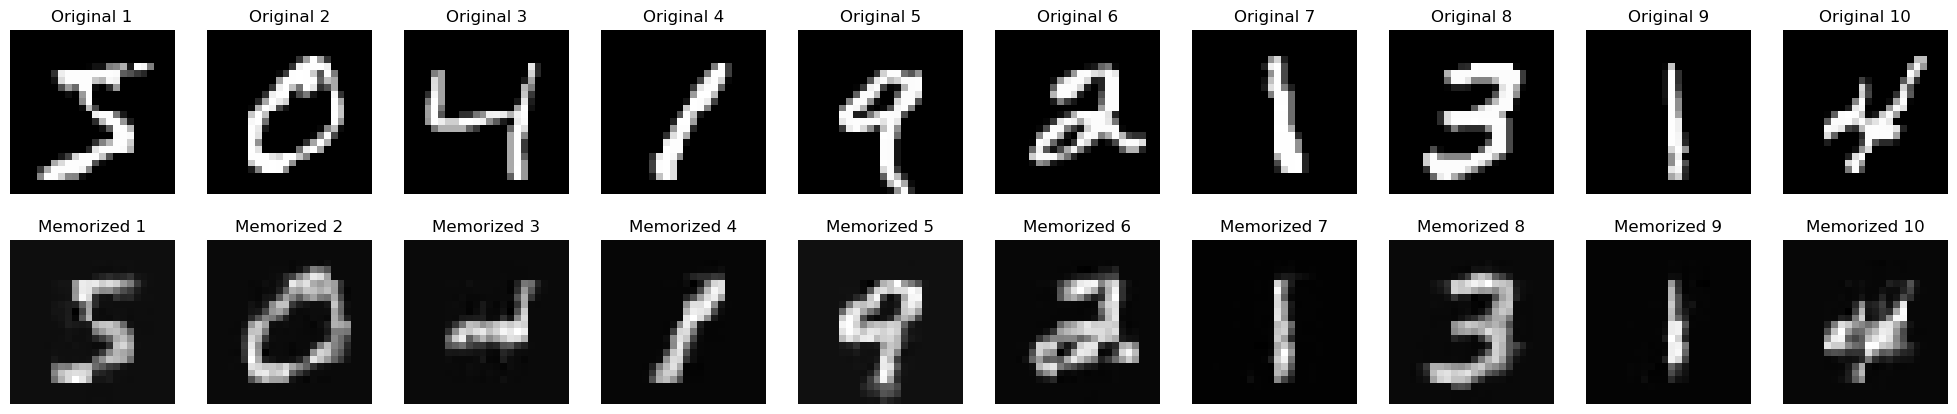

Epoch 102 | Train loss 0.000004 | Memorization loss 0.093154
Saved model and optimizer with memorization loss: 0.0932
Visualizing results at Epoch 103


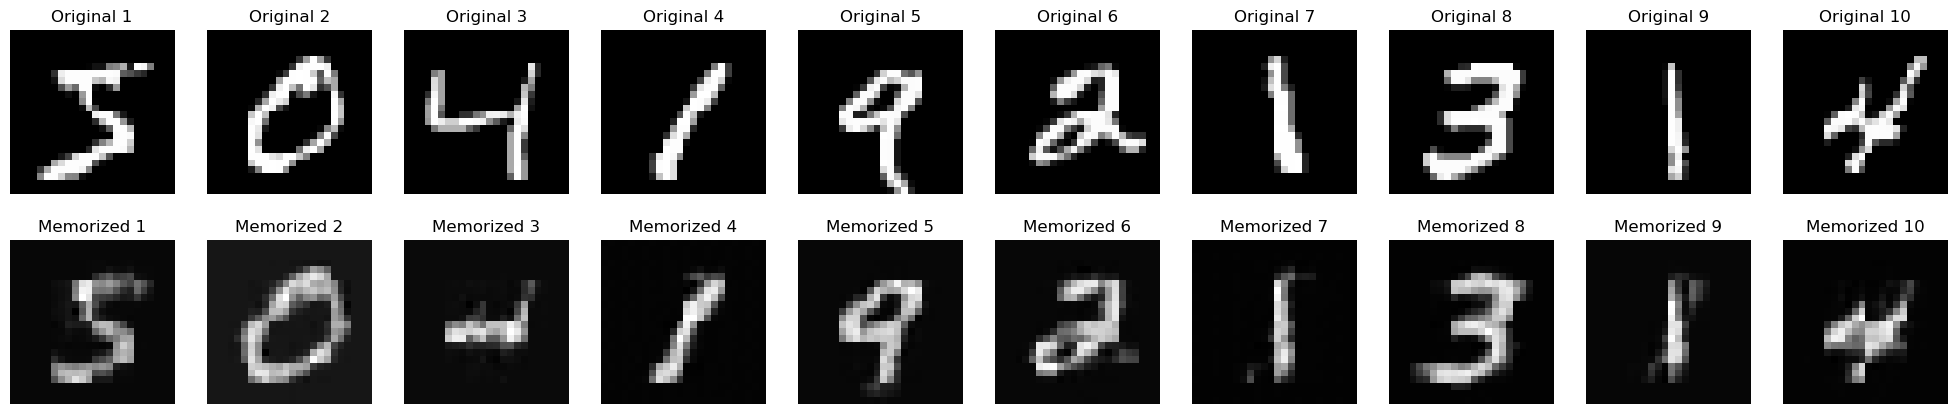

Epoch 103 | Train loss 0.000002 | Memorization loss 0.091296
Saved model and optimizer with memorization loss: 0.0913
Visualizing results at Epoch 104


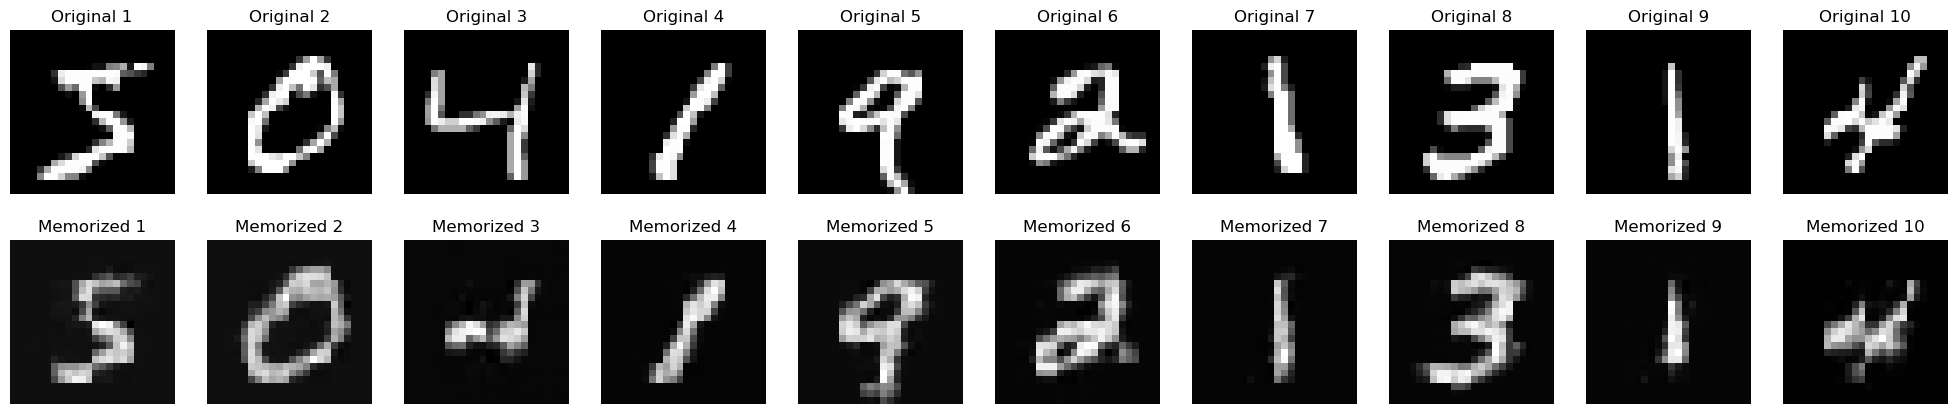

Epoch 104 | Train loss 0.000002 | Memorization loss 0.094176
Visualizing results at Epoch 105


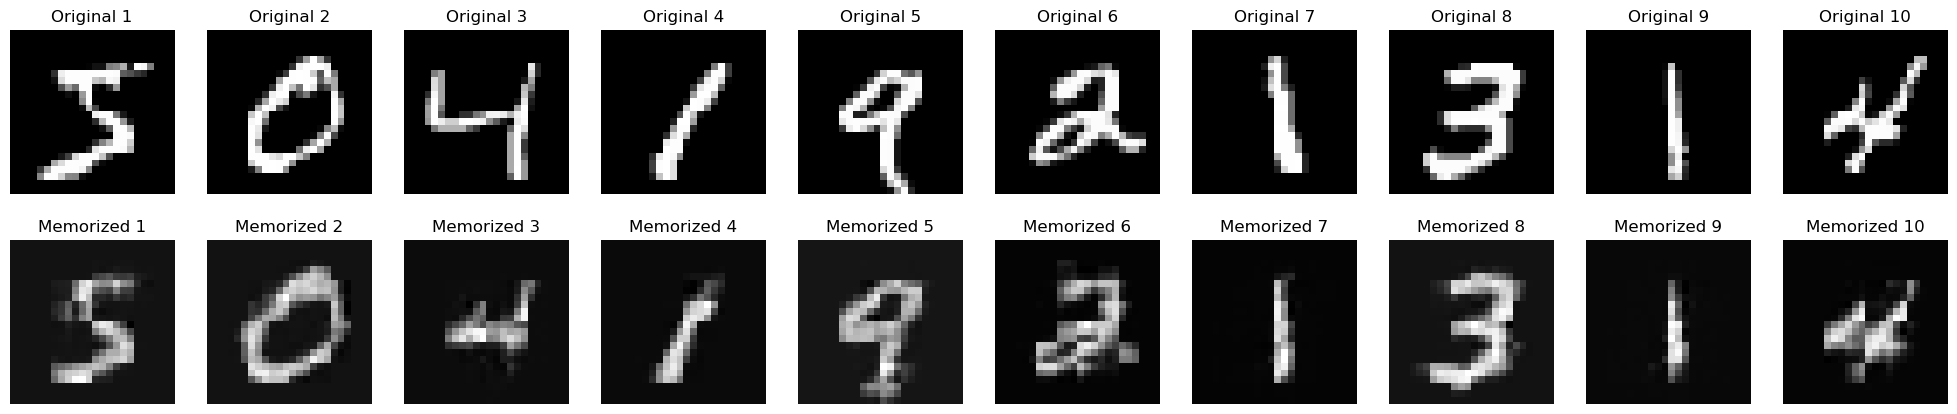

Epoch 105 | Train loss 0.000002 | Memorization loss 0.094594
Visualizing results at Epoch 106


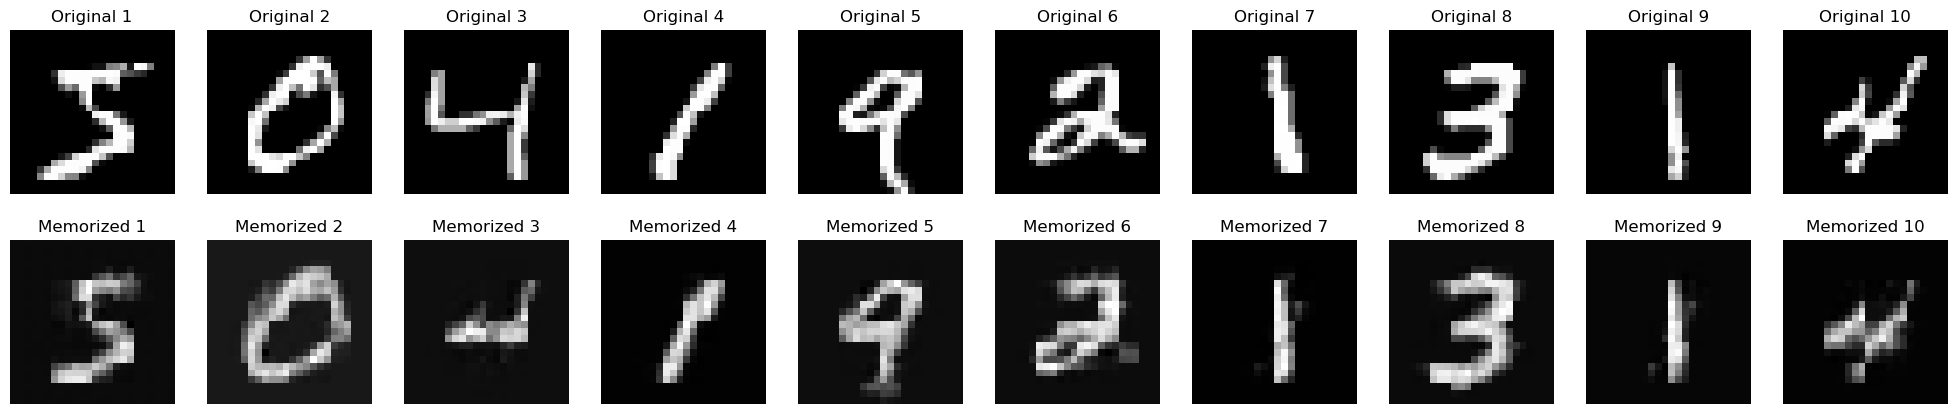

Epoch 106 | Train loss 0.000025 | Memorization loss 0.092627
Visualizing results at Epoch 107


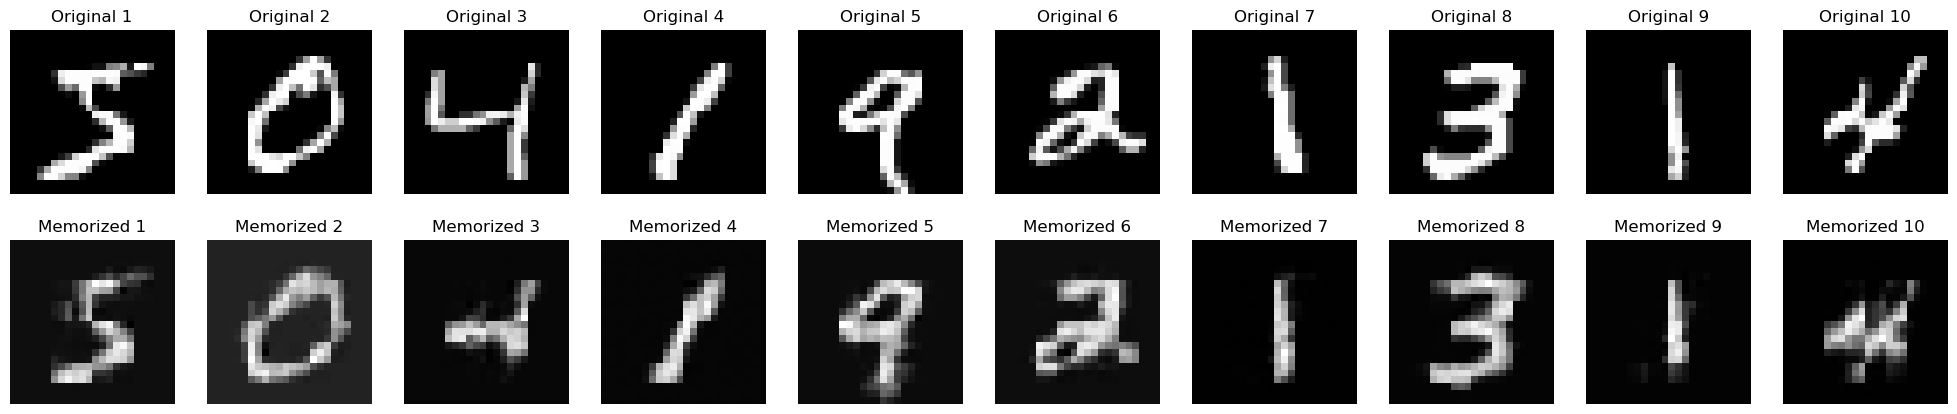

Epoch 107 | Train loss 0.000005 | Memorization loss 0.086178
Saved model and optimizer with memorization loss: 0.0862
Visualizing results at Epoch 108


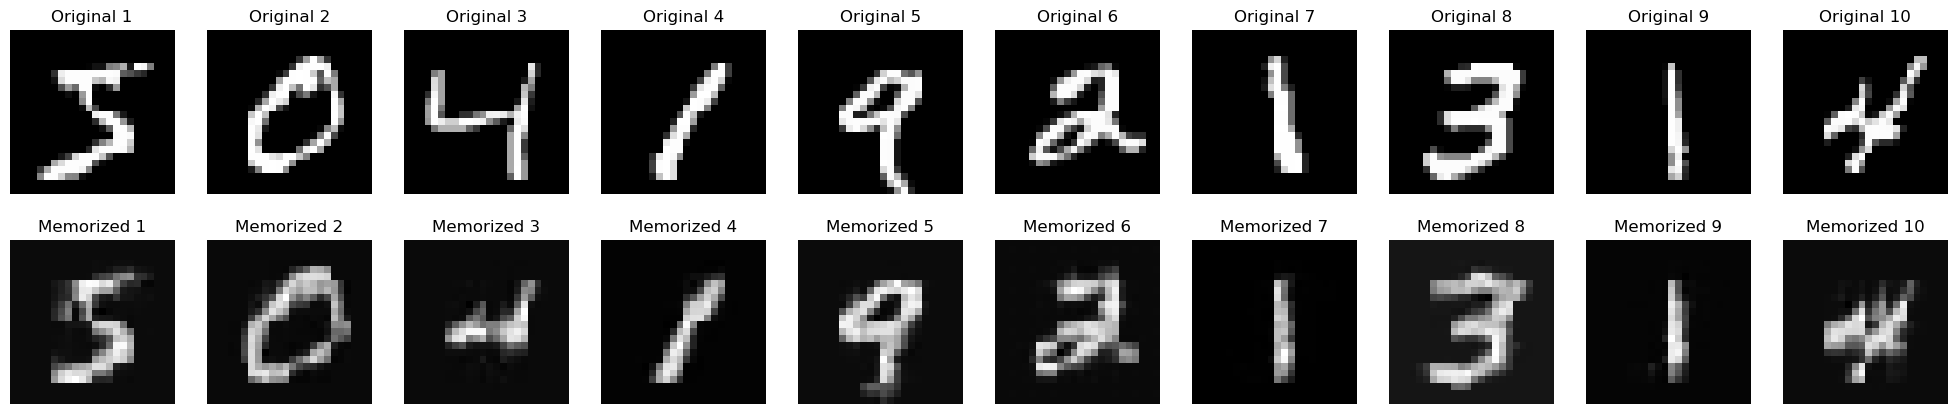

Epoch 108 | Train loss 0.000002 | Memorization loss 0.089436
Visualizing results at Epoch 109


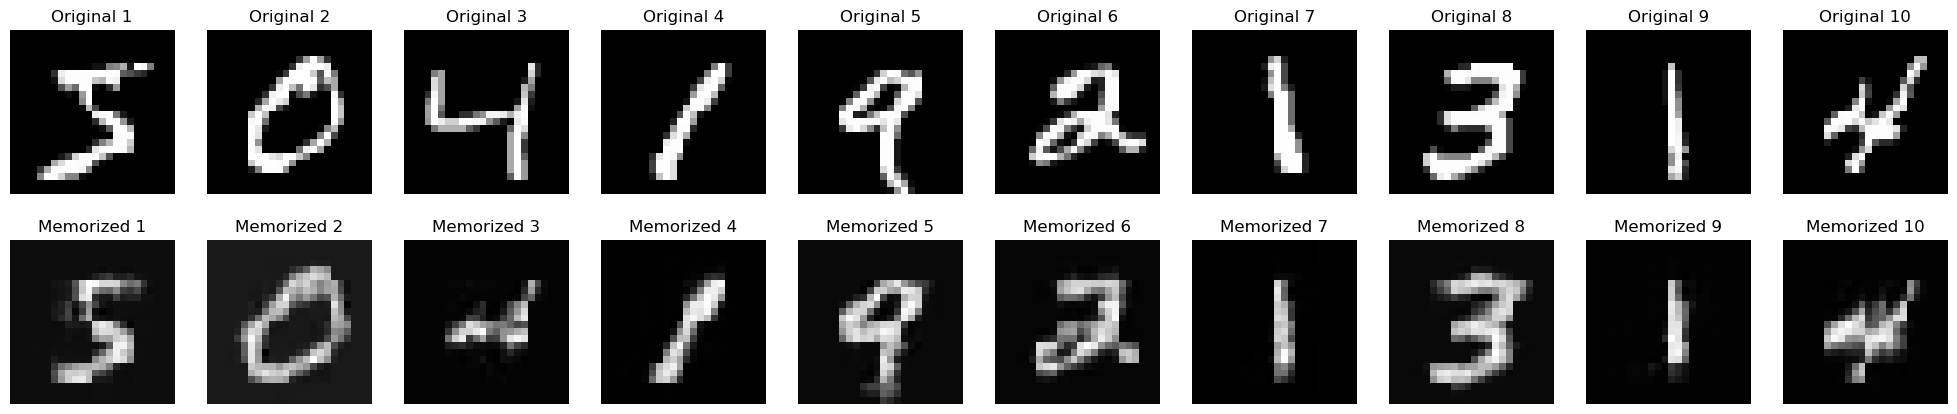

Epoch 109 | Train loss 0.000019 | Memorization loss 0.091183
Visualizing results at Epoch 110


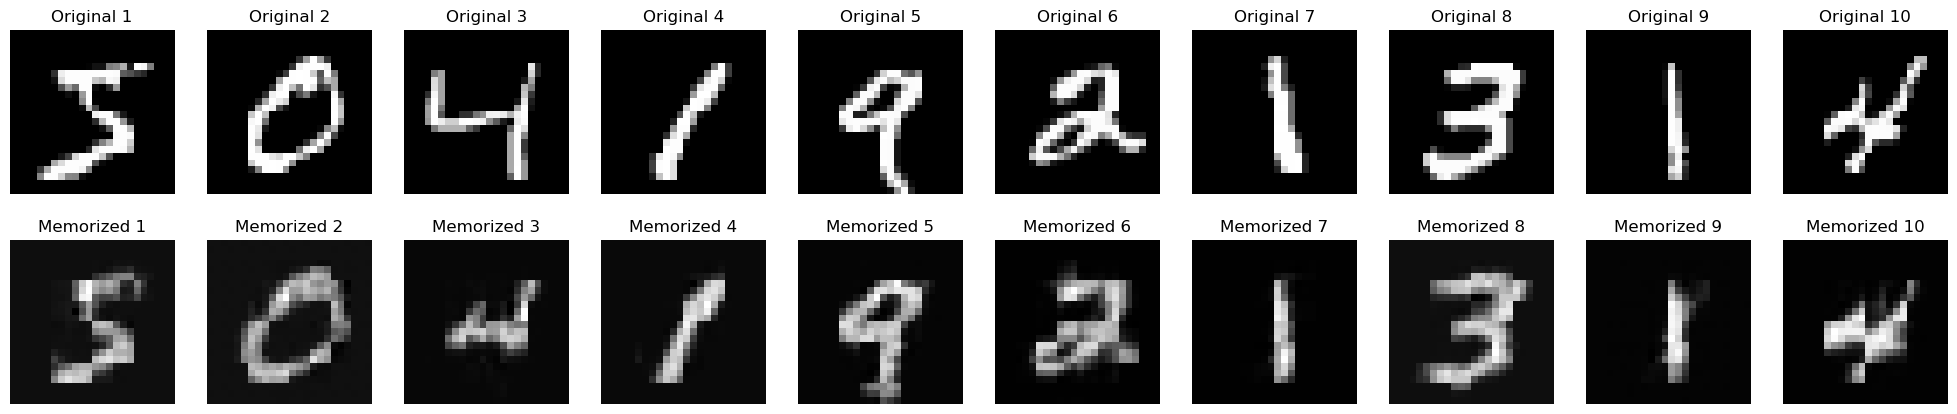

Epoch 110 | Train loss 0.000003 | Memorization loss 0.090248
Visualizing results at Epoch 111


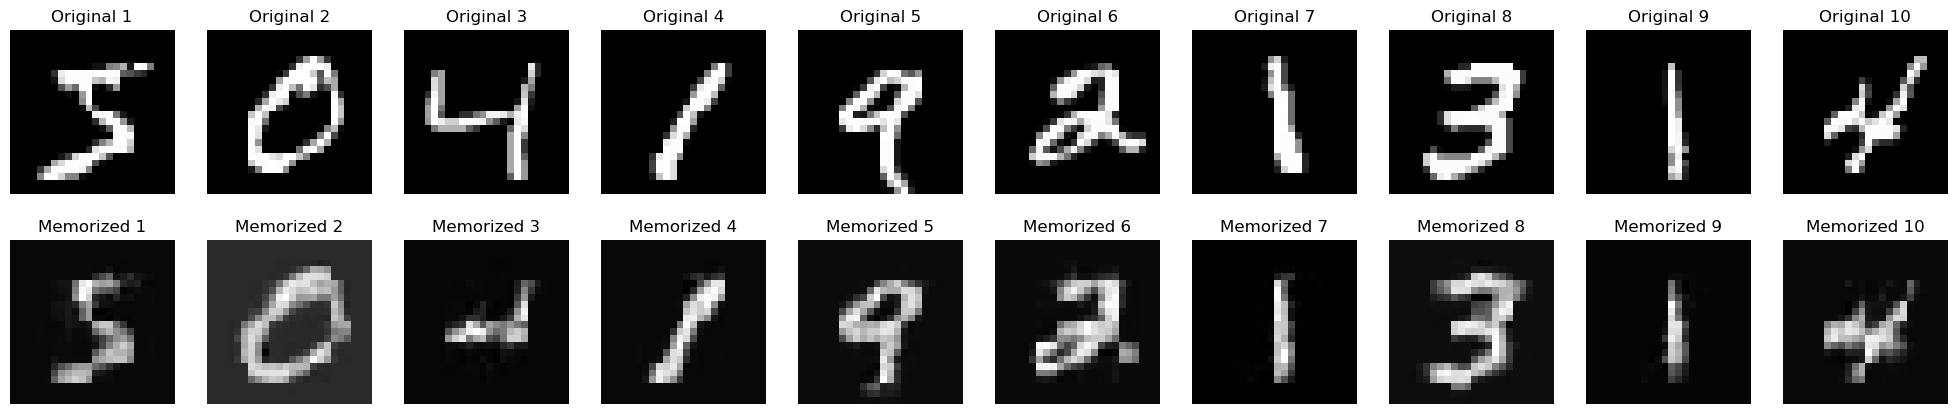

Epoch 111 | Train loss 0.000003 | Memorization loss 0.083254
Saved model and optimizer with memorization loss: 0.0833
Visualizing results at Epoch 112


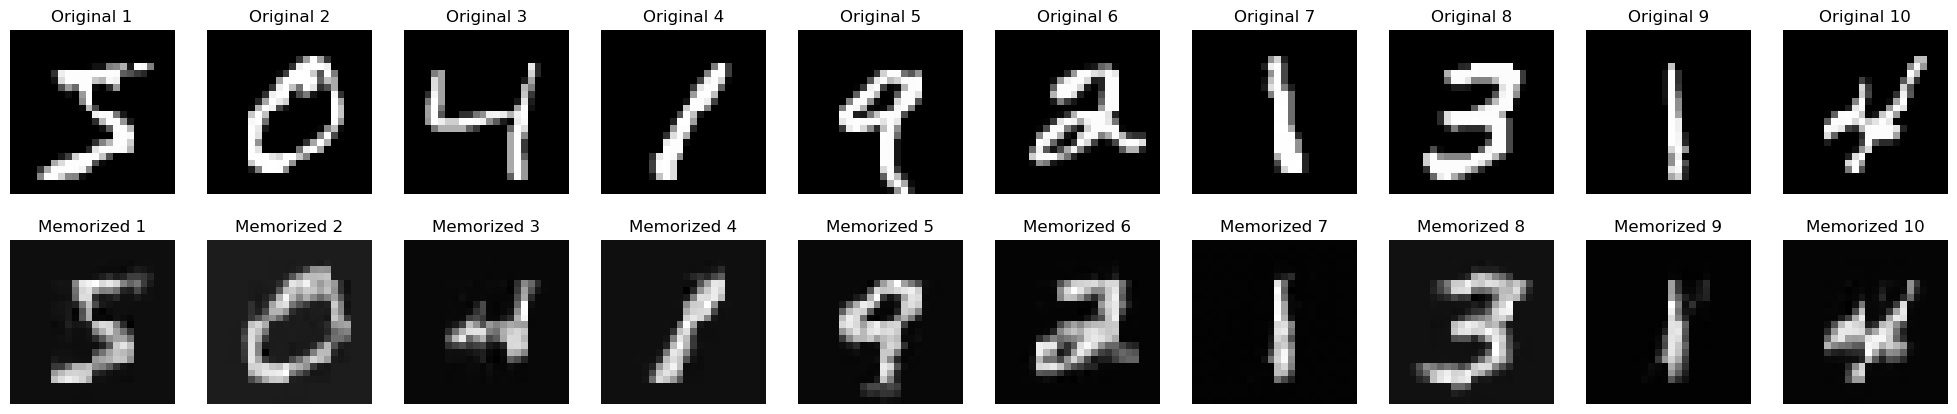

Epoch 112 | Train loss 0.000002 | Memorization loss 0.084932
Visualizing results at Epoch 113


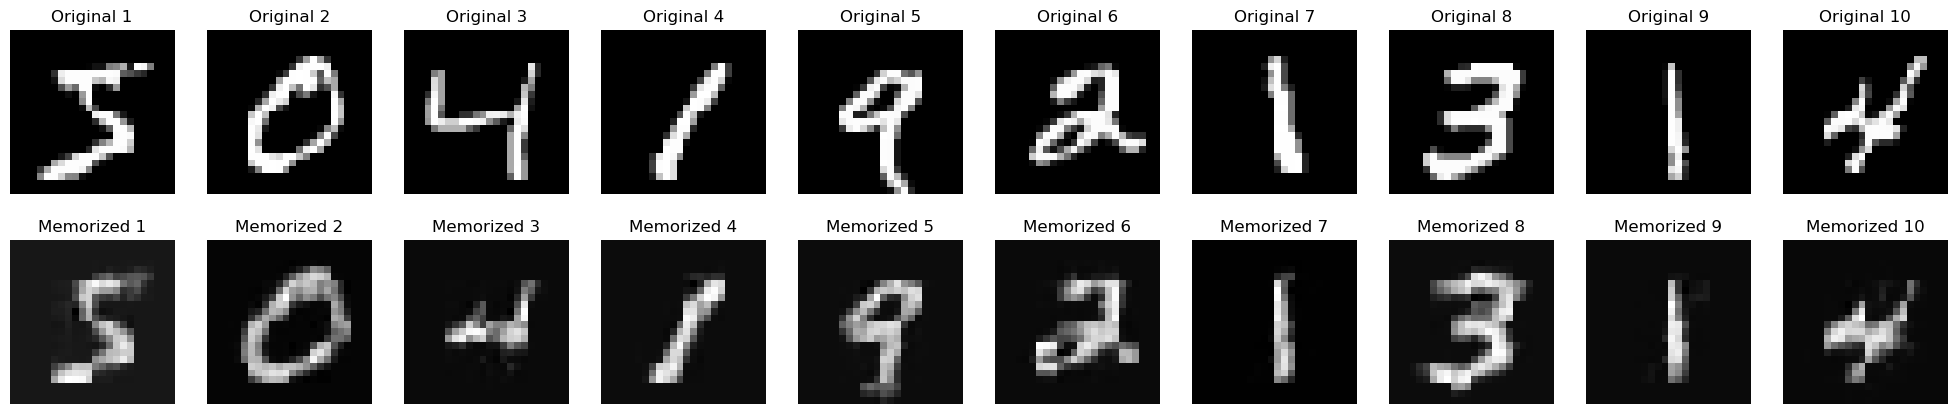

Epoch 113 | Train loss 0.000001 | Memorization loss 0.087051
Visualizing results at Epoch 114


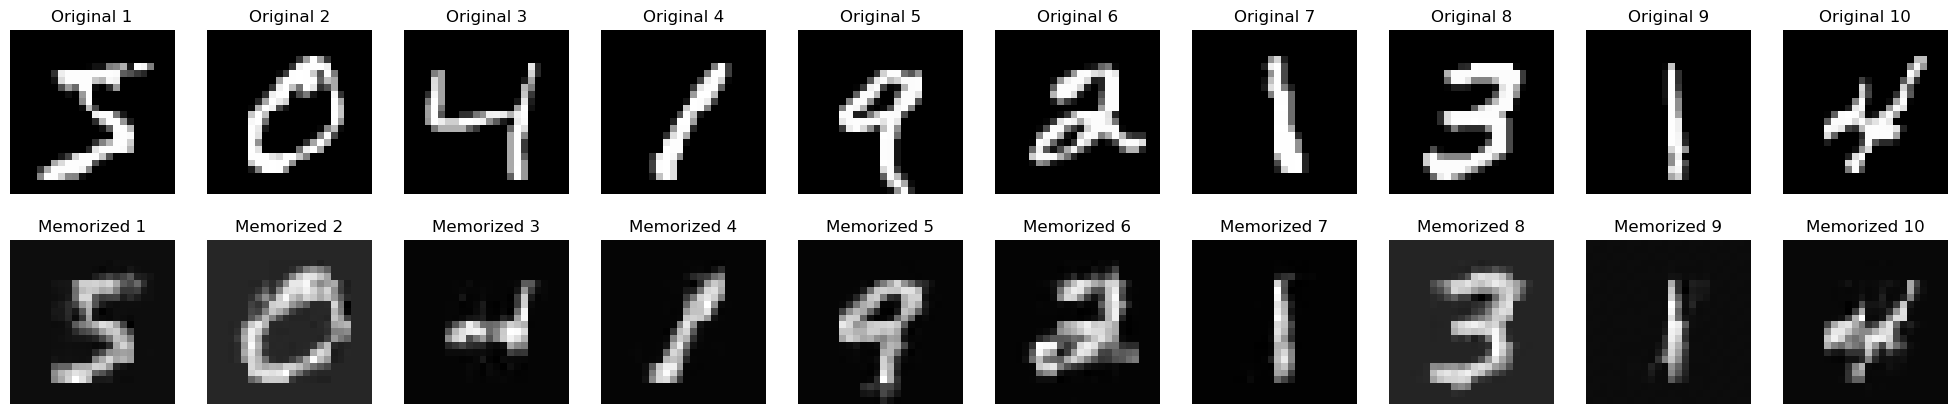

Epoch 114 | Train loss 0.000002 | Memorization loss 0.088090
Visualizing results at Epoch 115


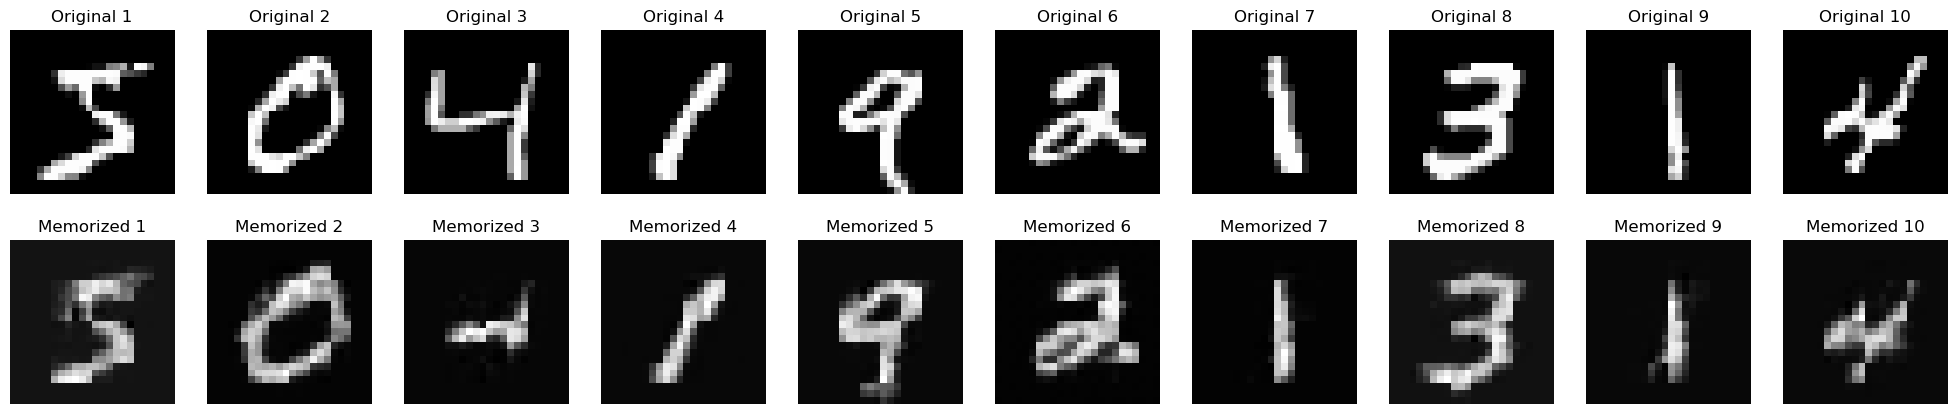

Epoch 115 | Train loss 0.000016 | Memorization loss 0.081703
Saved model and optimizer with memorization loss: 0.0817
Visualizing results at Epoch 116


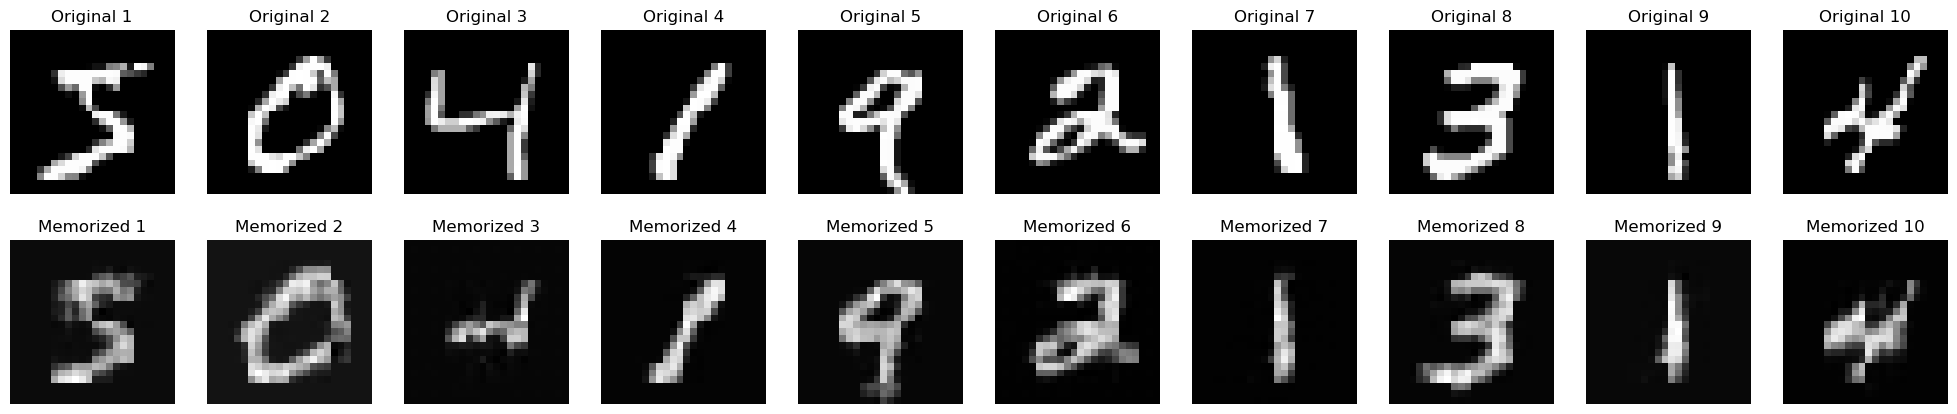

Epoch 116 | Train loss 0.000003 | Memorization loss 0.080656
Saved model and optimizer with memorization loss: 0.0807
Visualizing results at Epoch 117


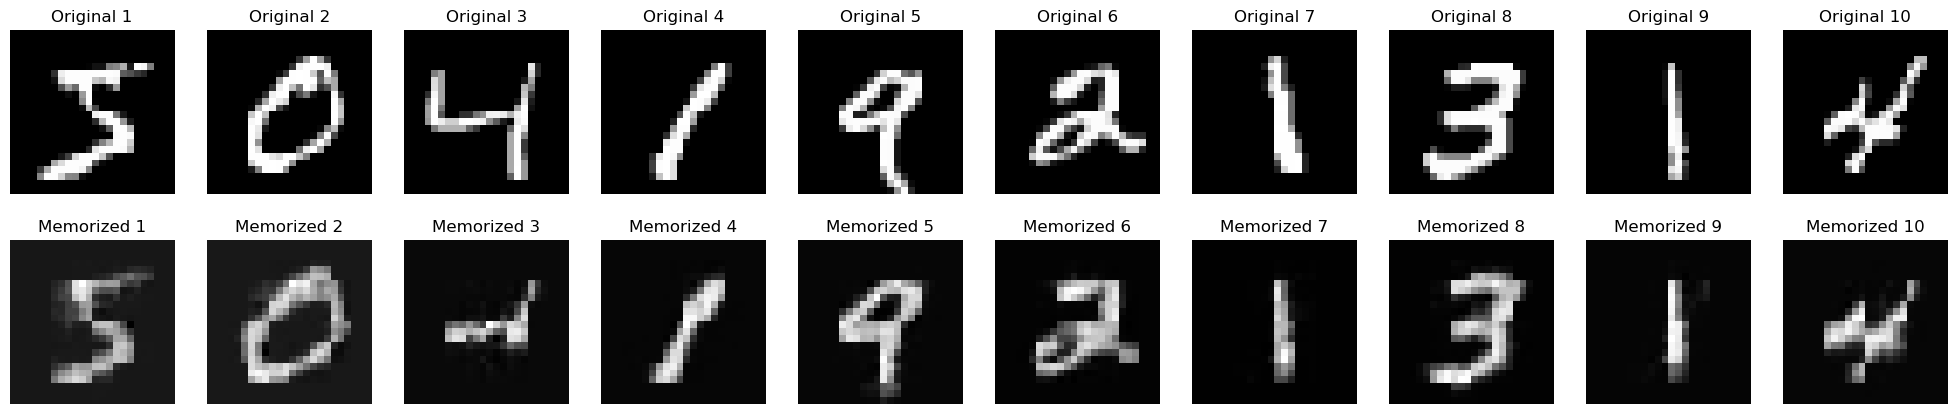

Epoch 117 | Train loss 0.000002 | Memorization loss 0.083133
Visualizing results at Epoch 118


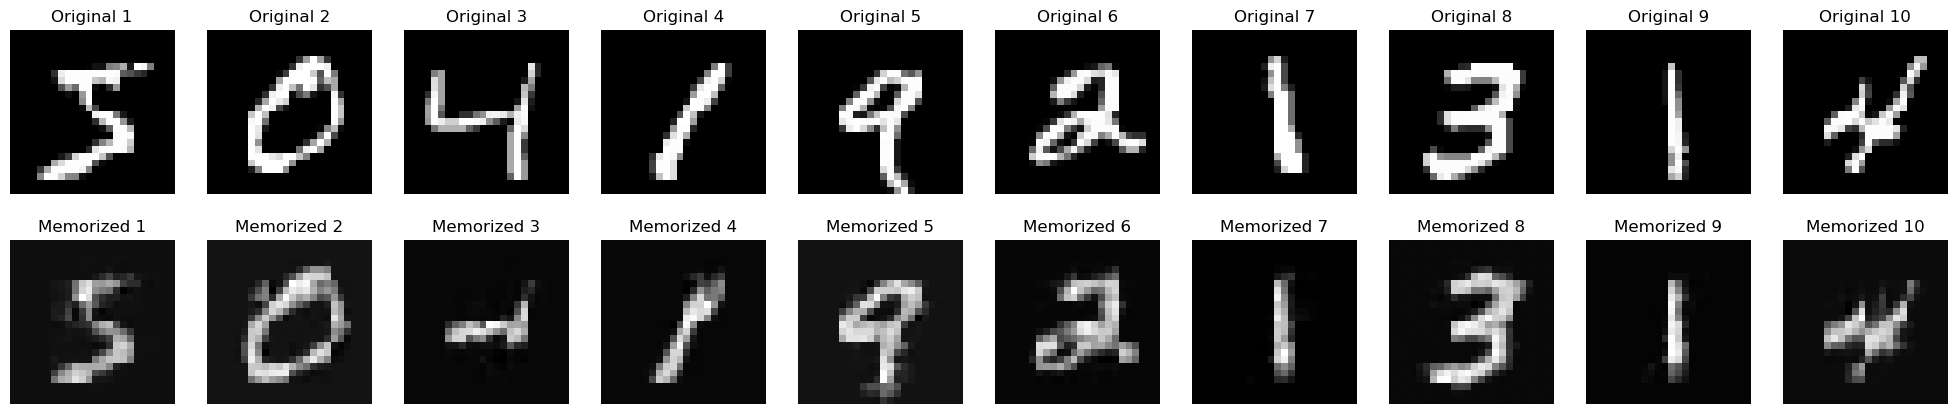

Epoch 118 | Train loss 0.000002 | Memorization loss 0.086438
Visualizing results at Epoch 119


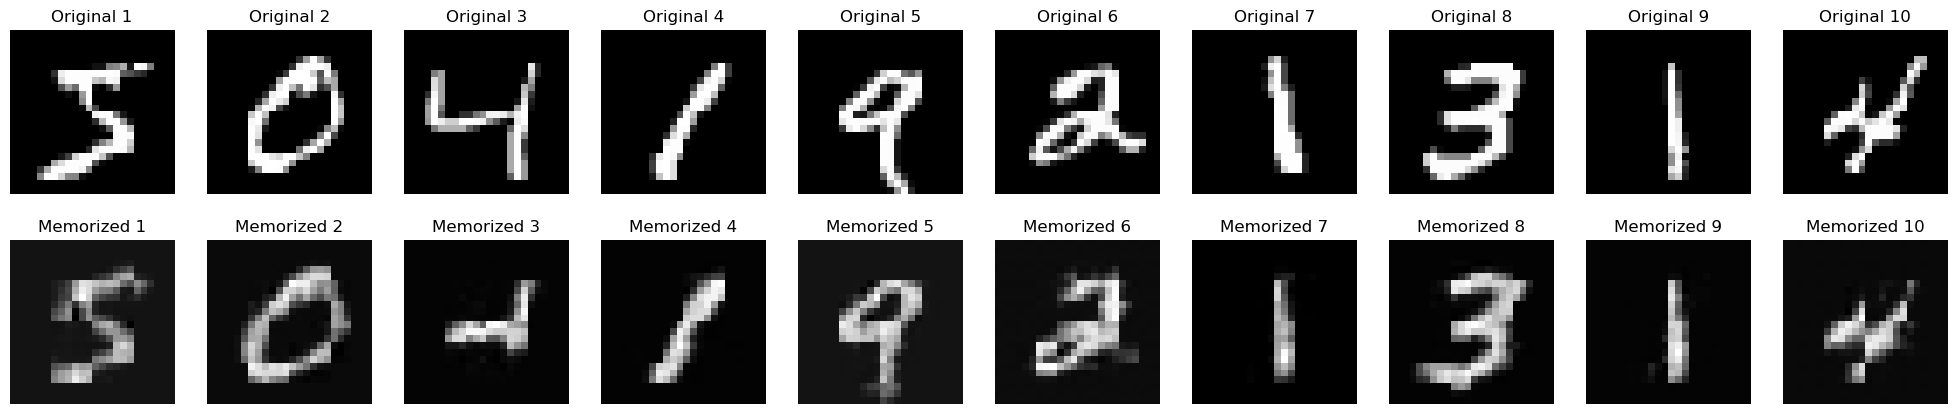

Epoch 119 | Train loss 0.000001 | Memorization loss 0.079848
Saved model and optimizer with memorization loss: 0.0798
Visualizing results at Epoch 120


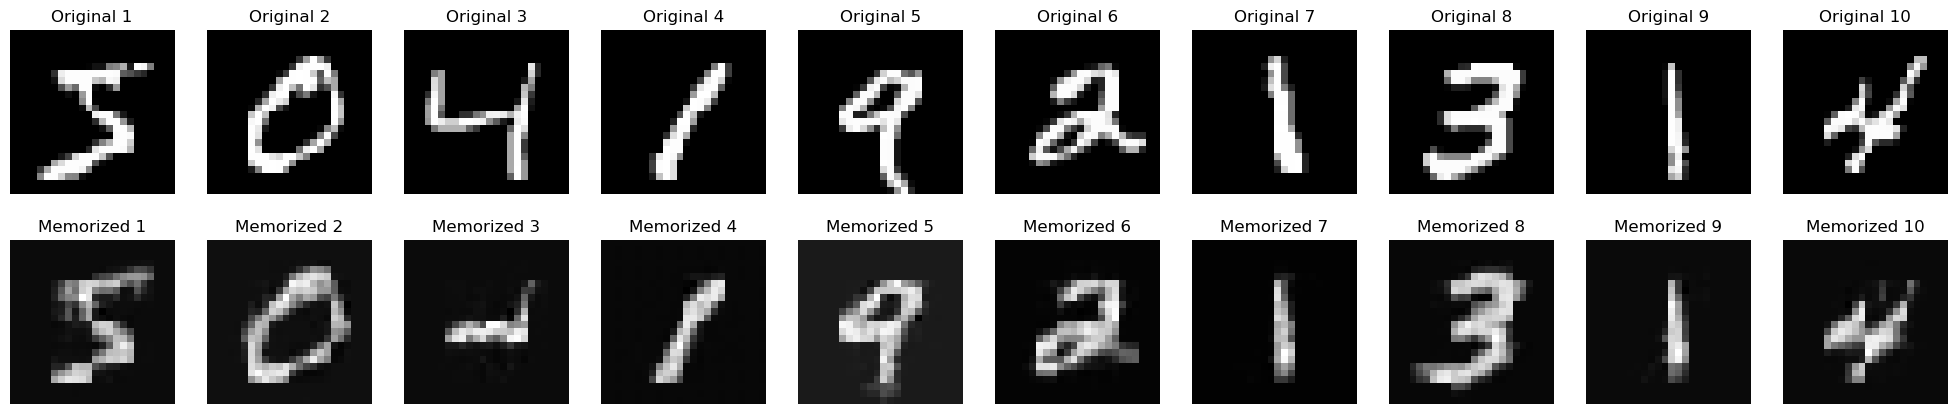

Epoch 120 | Train loss 0.000001 | Memorization loss 0.076682
Saved model and optimizer with memorization loss: 0.0767
Visualizing results at Epoch 121


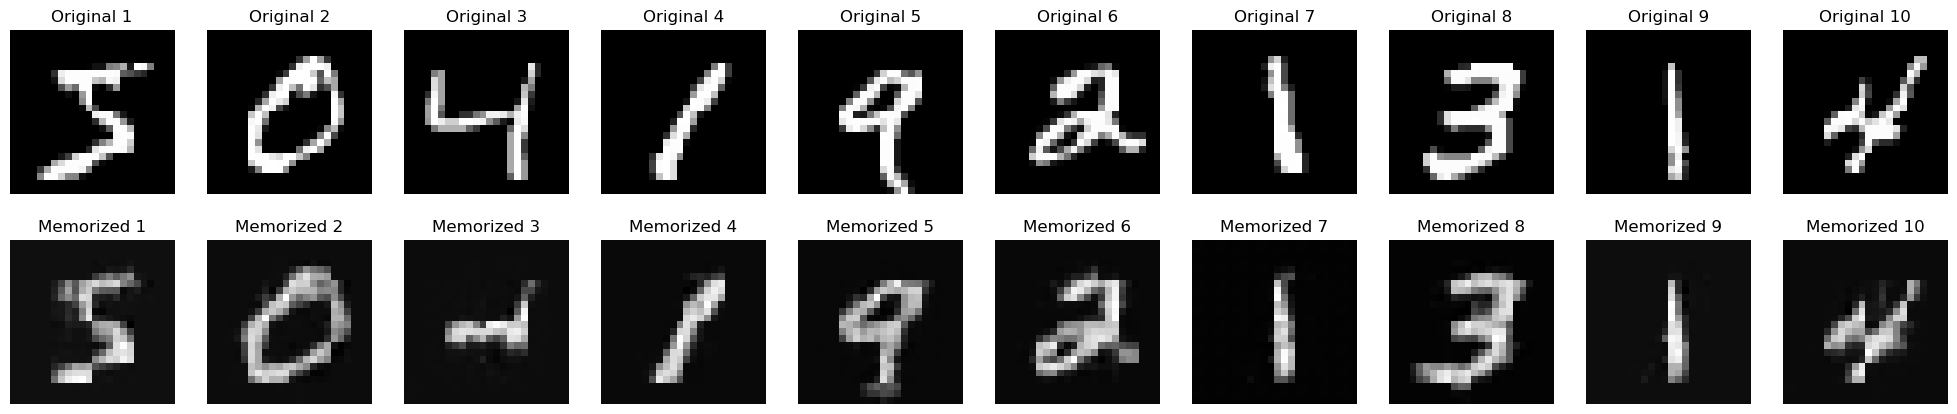

Epoch 121 | Train loss 0.000001 | Memorization loss 0.080306
Visualizing results at Epoch 122


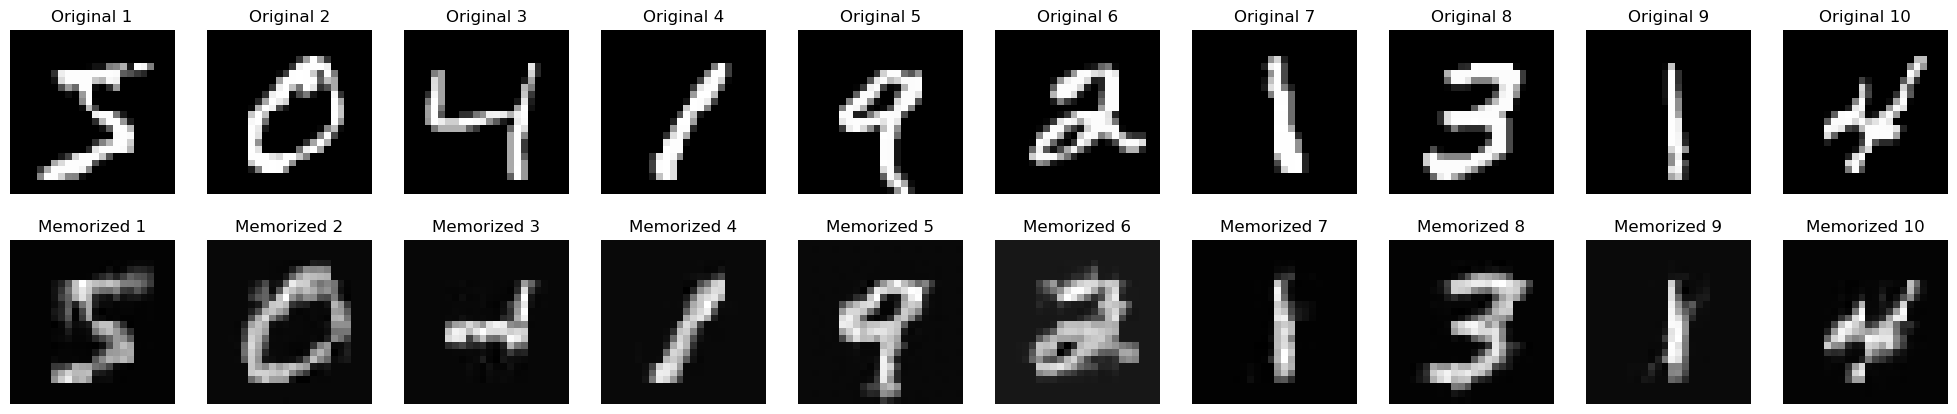

Epoch 122 | Train loss 0.000020 | Memorization loss 0.082606
Visualizing results at Epoch 123


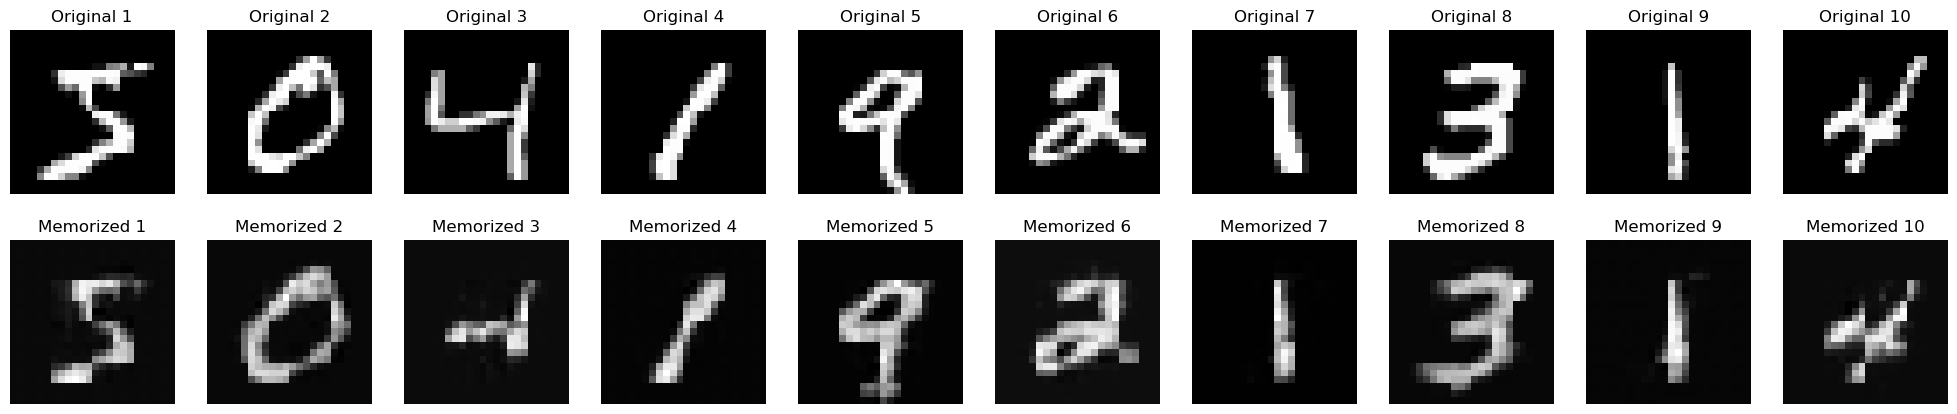

Epoch 123 | Train loss 0.000010 | Memorization loss 0.079777
Visualizing results at Epoch 124


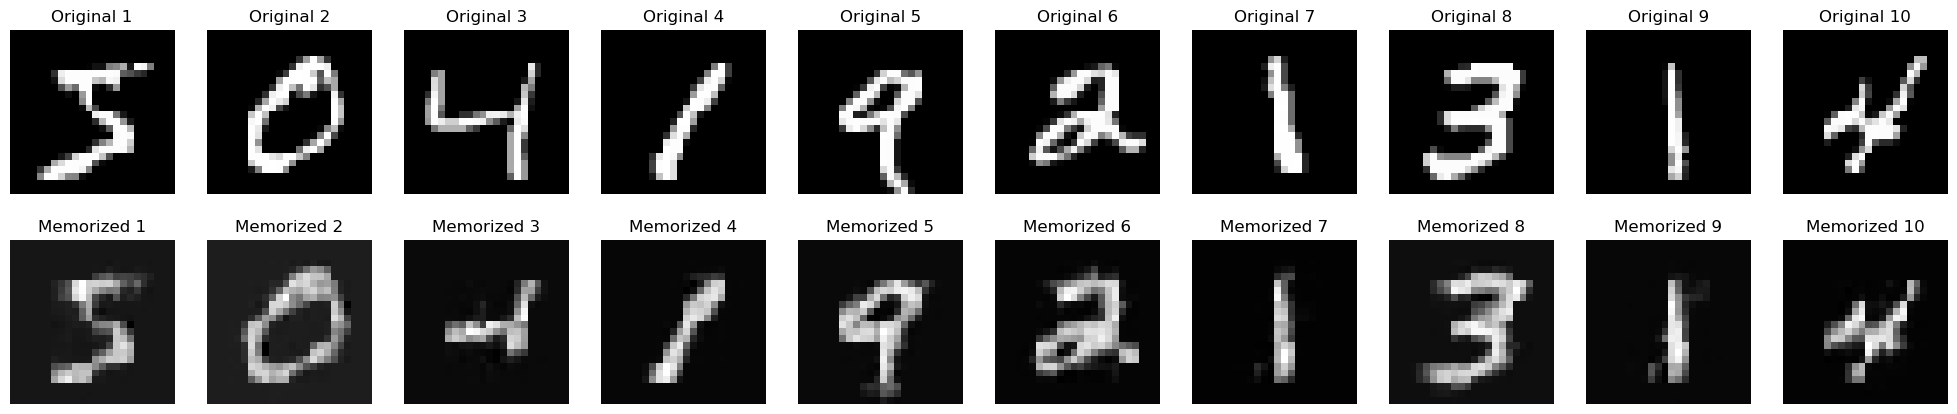

Epoch 124 | Train loss 0.000009 | Memorization loss 0.074863
Saved model and optimizer with memorization loss: 0.0749
Visualizing results at Epoch 125


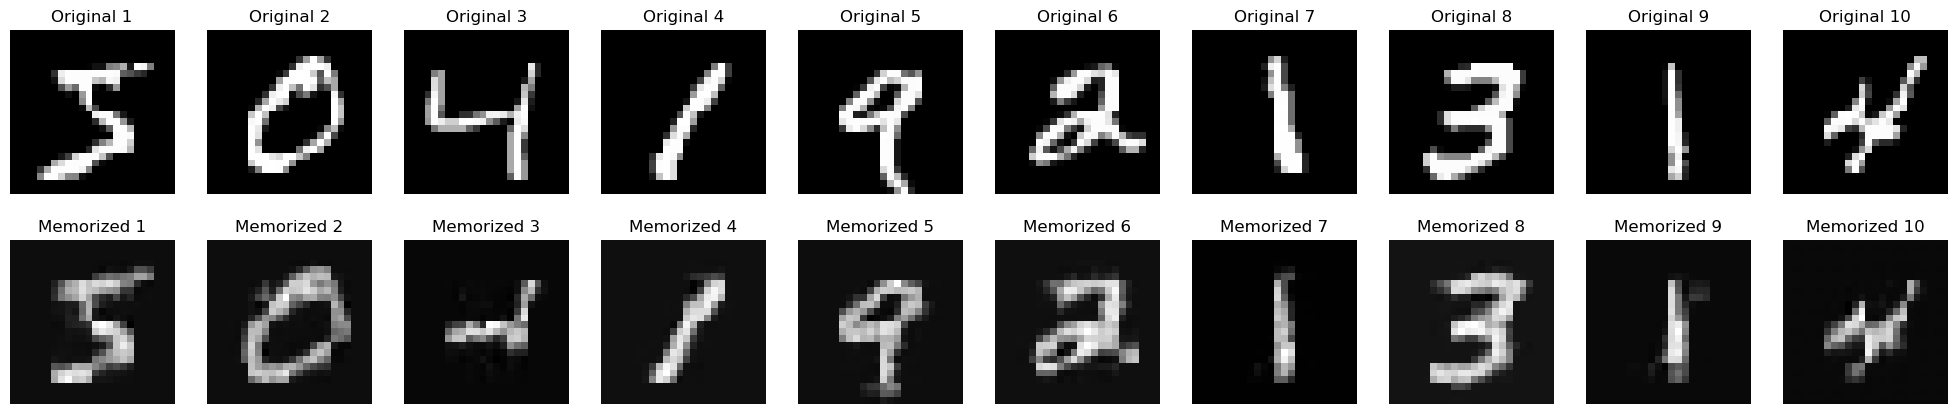

Epoch 125 | Train loss 0.000009 | Memorization loss 0.076512
Visualizing results at Epoch 126


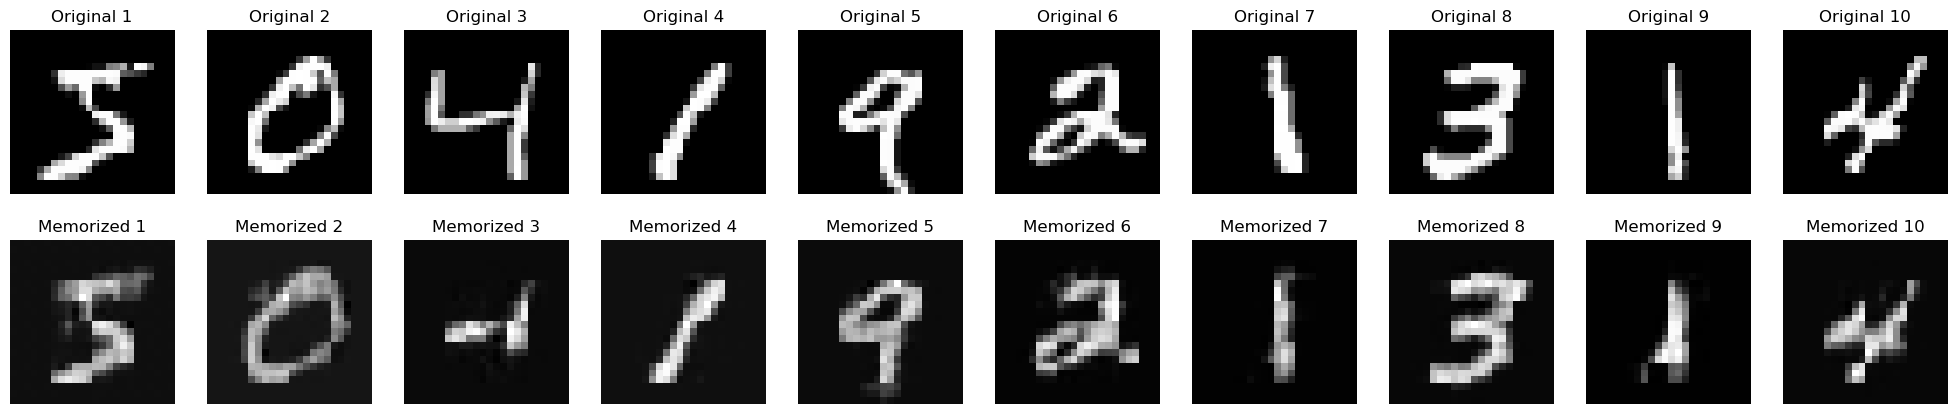

Epoch 126 | Train loss 0.000005 | Memorization loss 0.077866
Visualizing results at Epoch 127


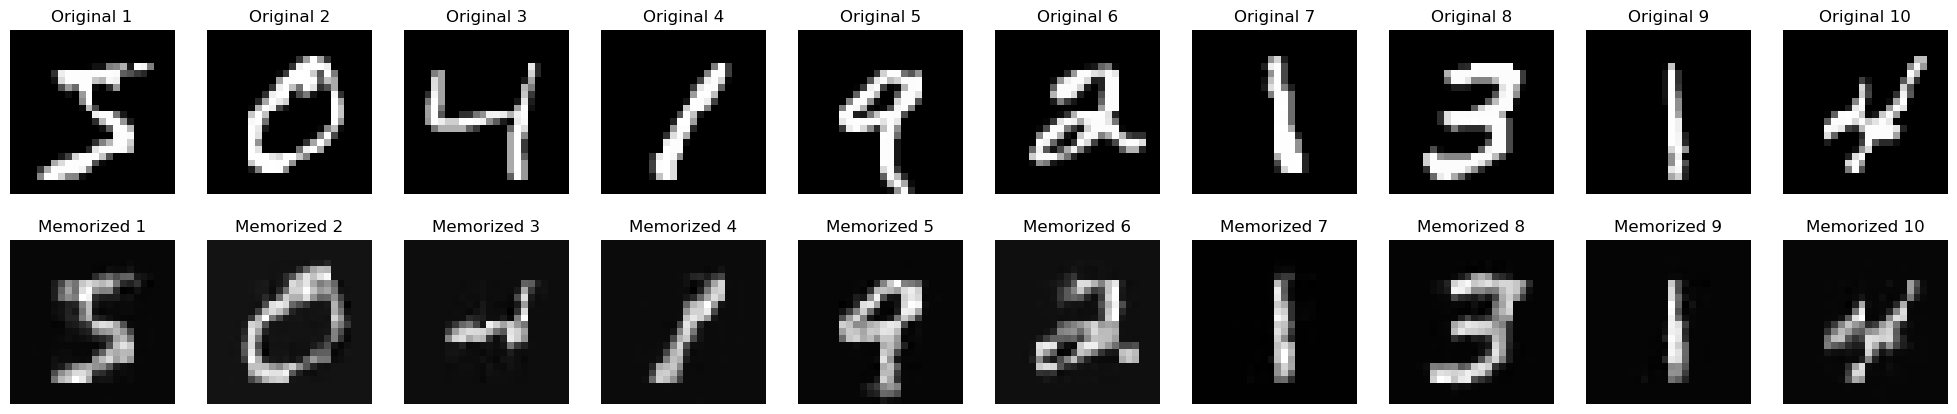

Epoch 127 | Train loss 0.000002 | Memorization loss 0.079781
Visualizing results at Epoch 128


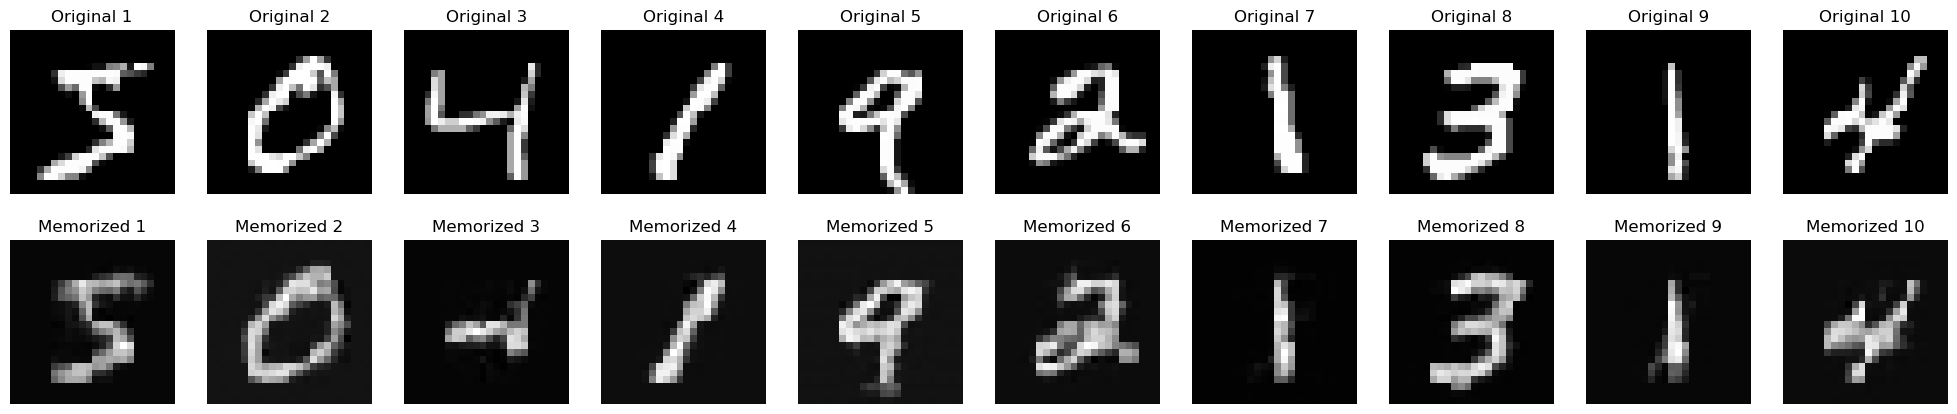

Epoch 128 | Train loss 0.000002 | Memorization loss 0.070241
Saved model and optimizer with memorization loss: 0.0702
Visualizing results at Epoch 129


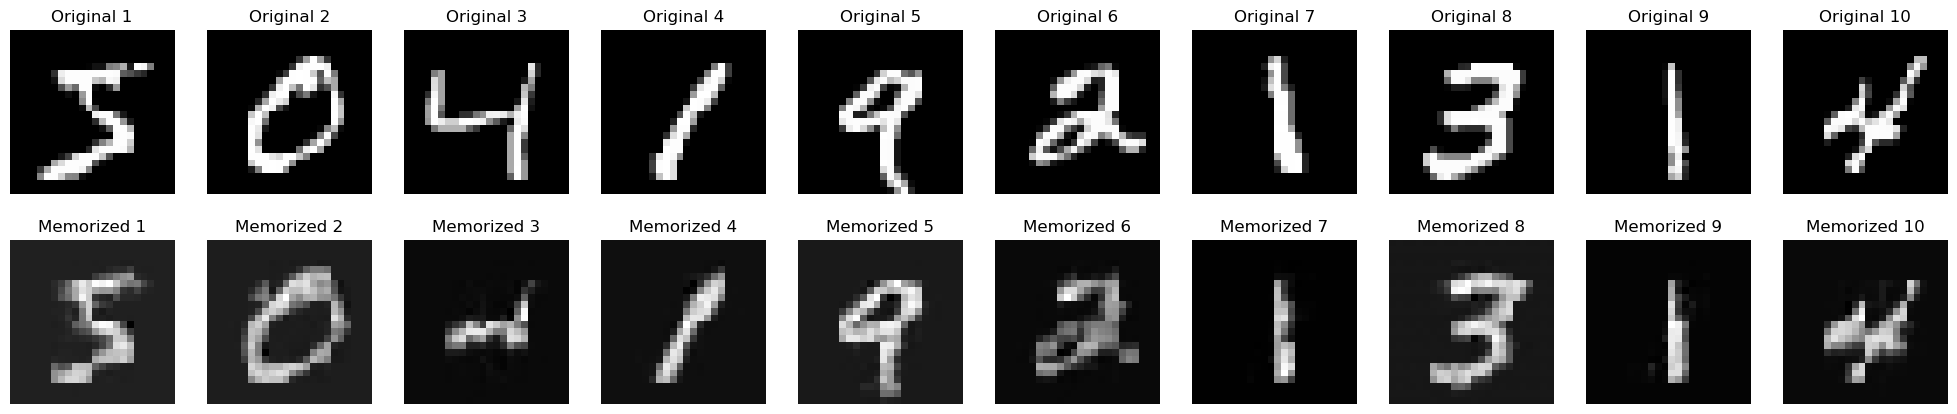

Epoch 129 | Train loss 0.000007 | Memorization loss 0.074676
Visualizing results at Epoch 130


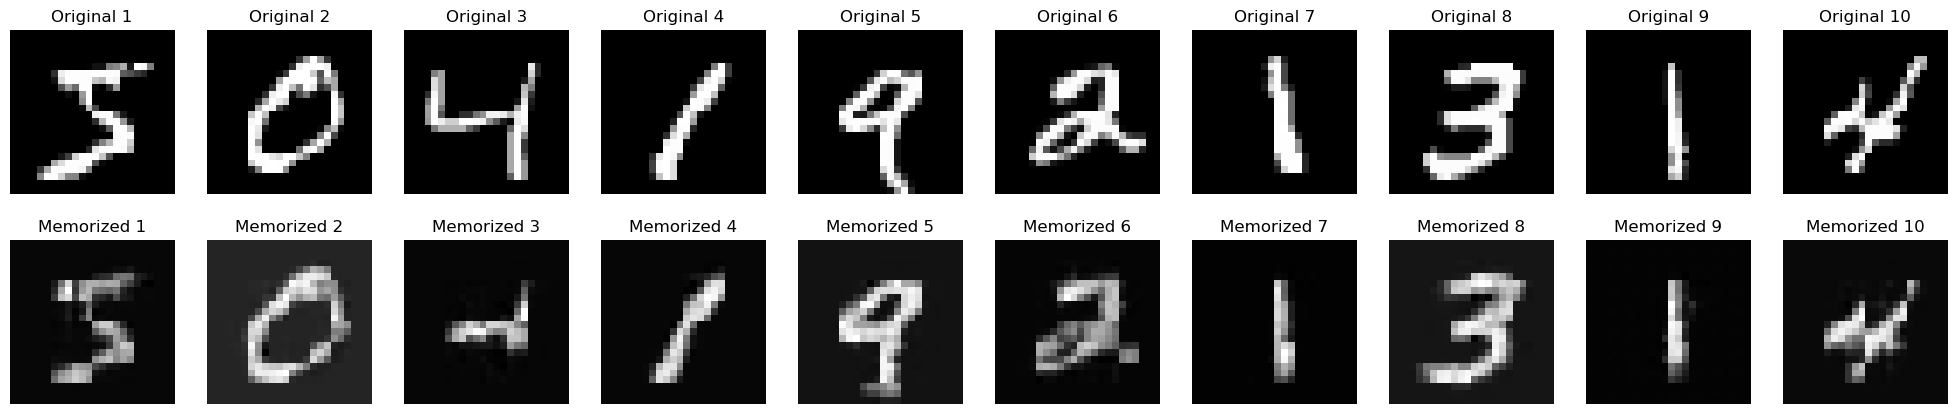

Epoch 130 | Train loss 0.000001 | Memorization loss 0.075029
Visualizing results at Epoch 131


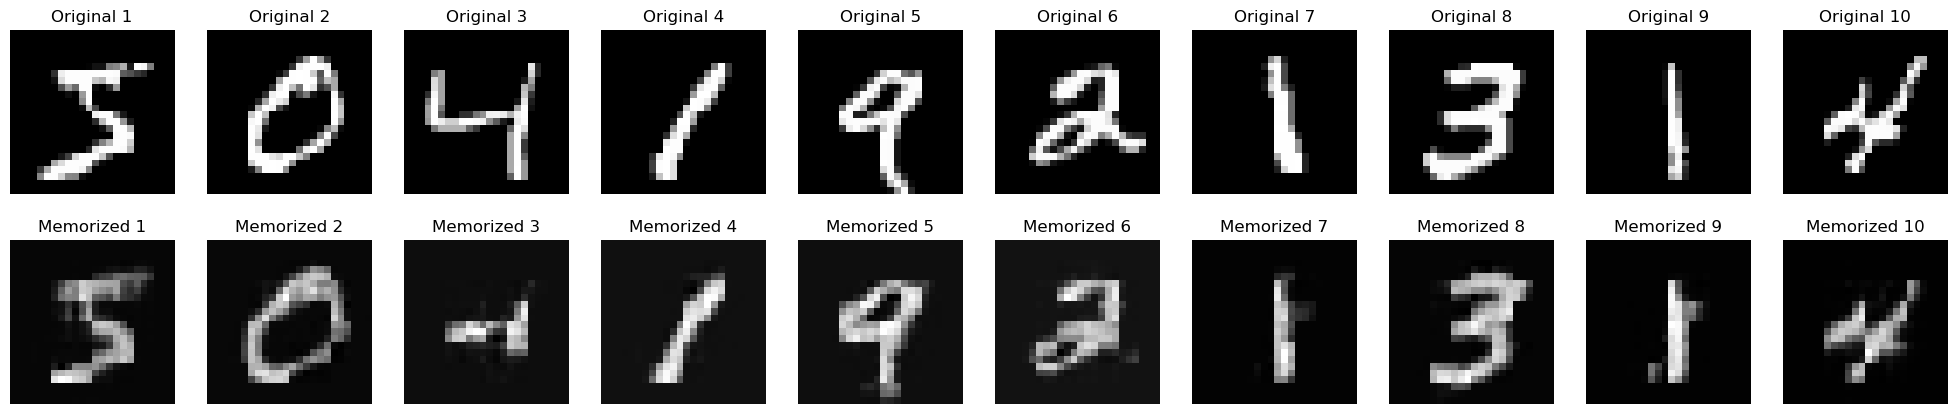

Epoch 131 | Train loss 0.000003 | Memorization loss 0.077385
Visualizing results at Epoch 132


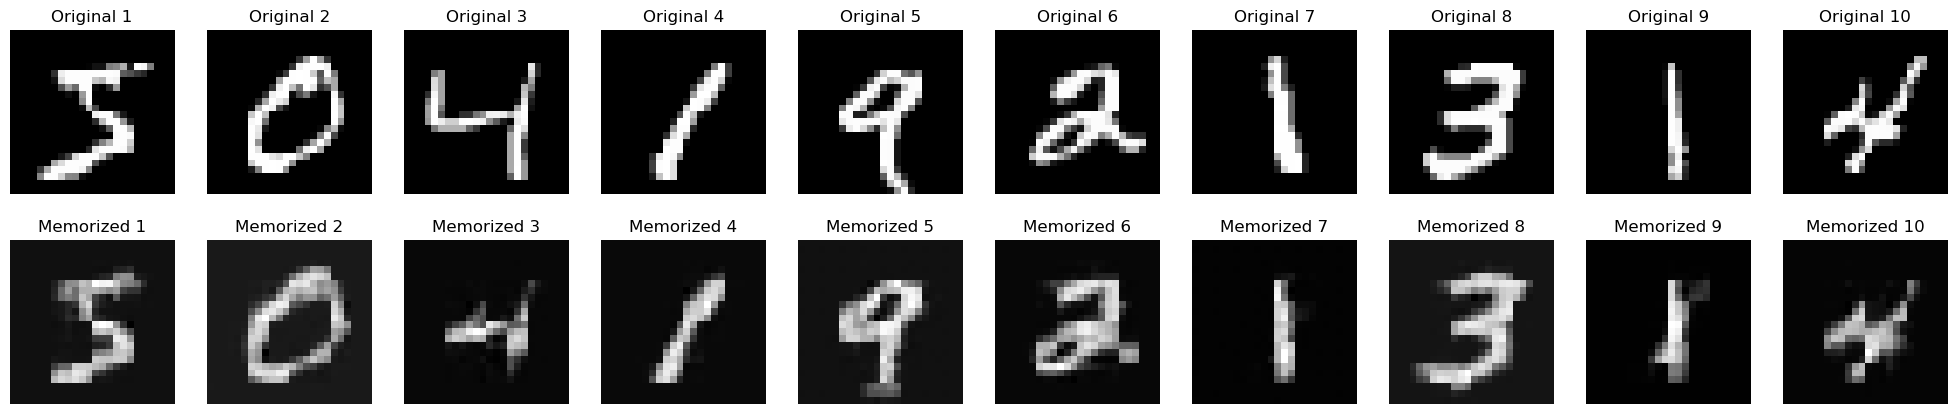

Epoch 132 | Train loss 0.000023 | Memorization loss 0.070898
Visualizing results at Epoch 133


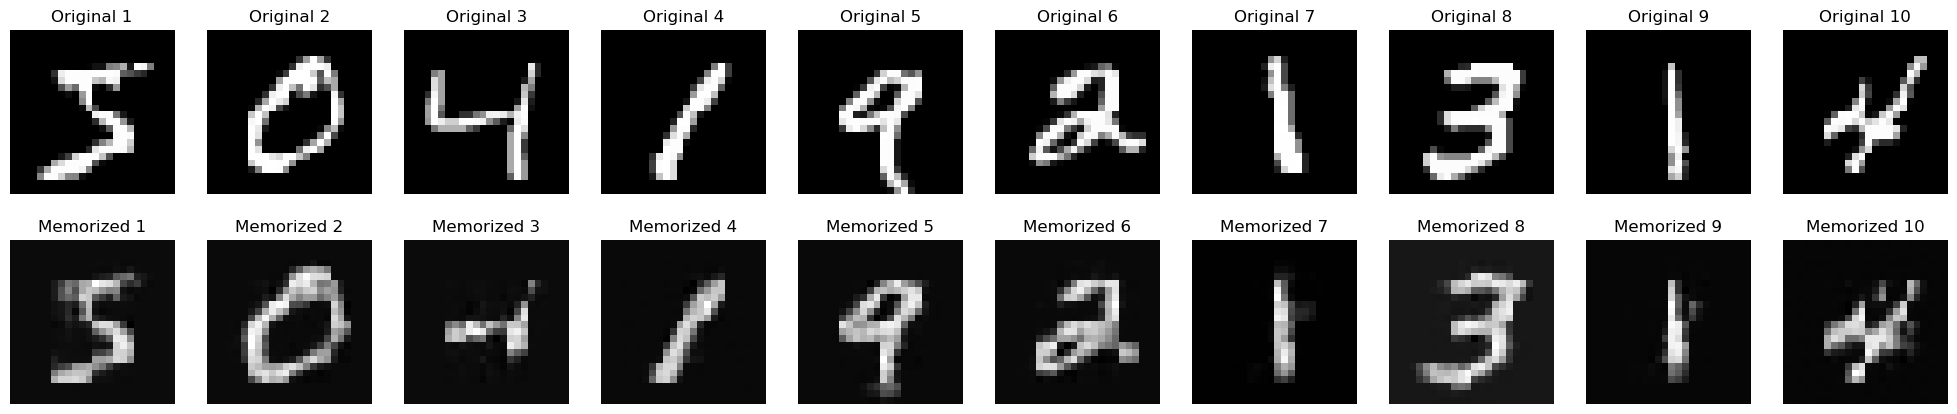

Epoch 133 | Train loss 0.000024 | Memorization loss 0.071247
Visualizing results at Epoch 134


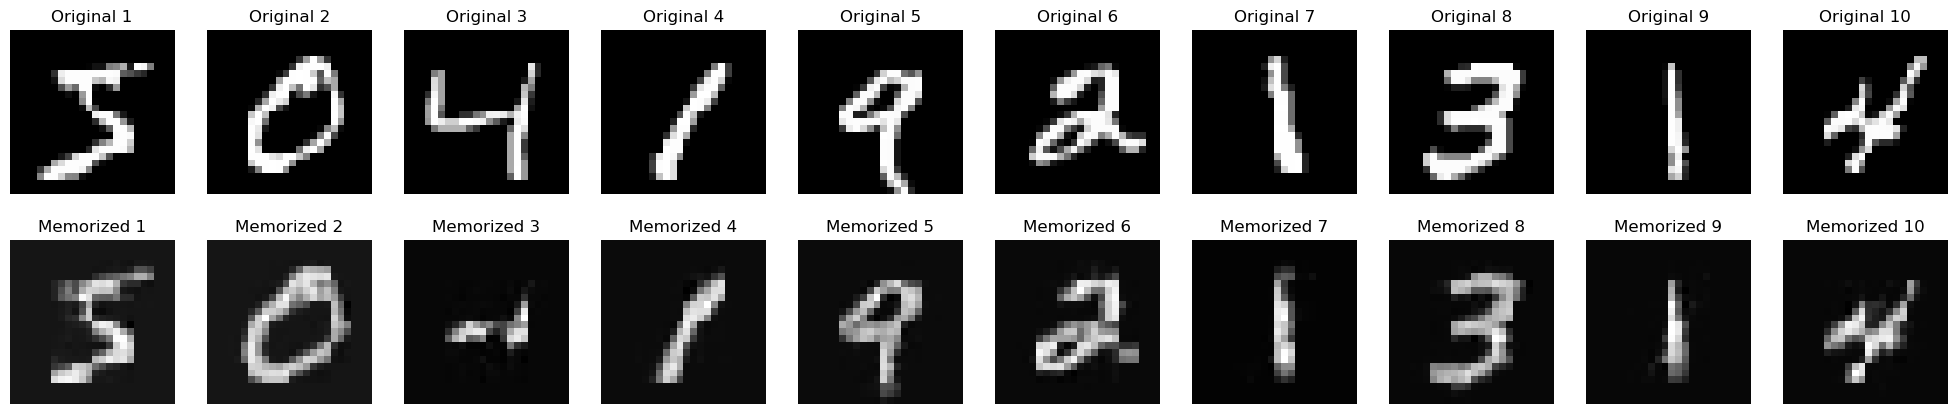

Epoch 134 | Train loss 0.000004 | Memorization loss 0.071743
Visualizing results at Epoch 135


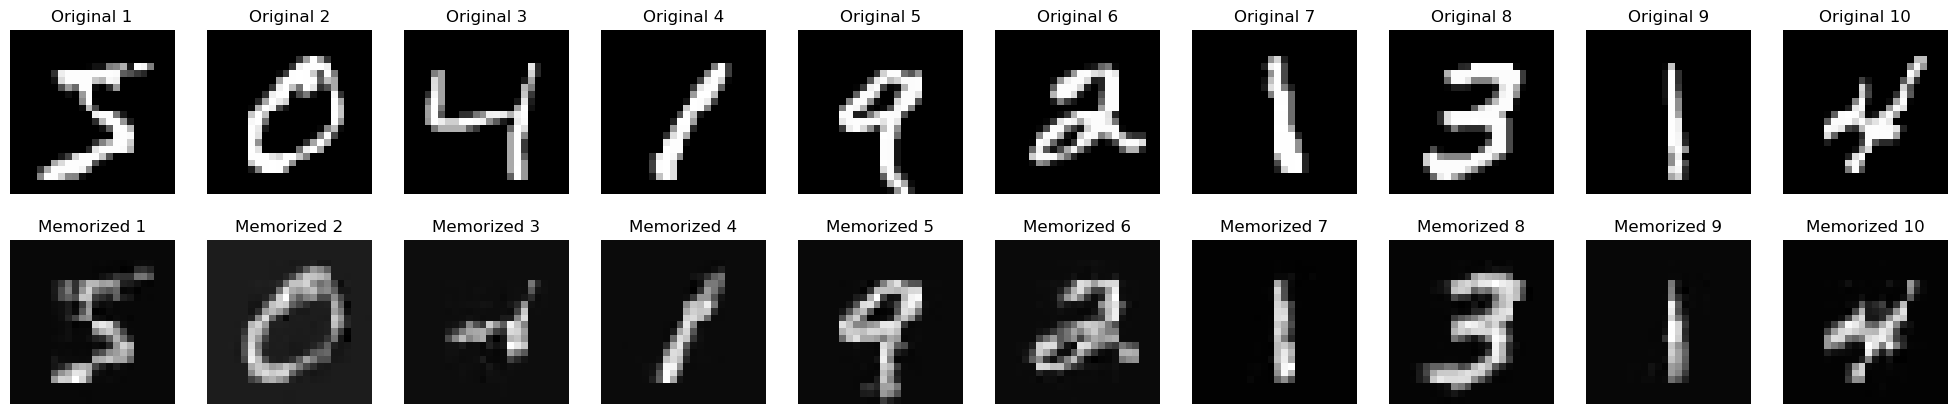

Epoch 135 | Train loss 0.000003 | Memorization loss 0.074285
Visualizing results at Epoch 136


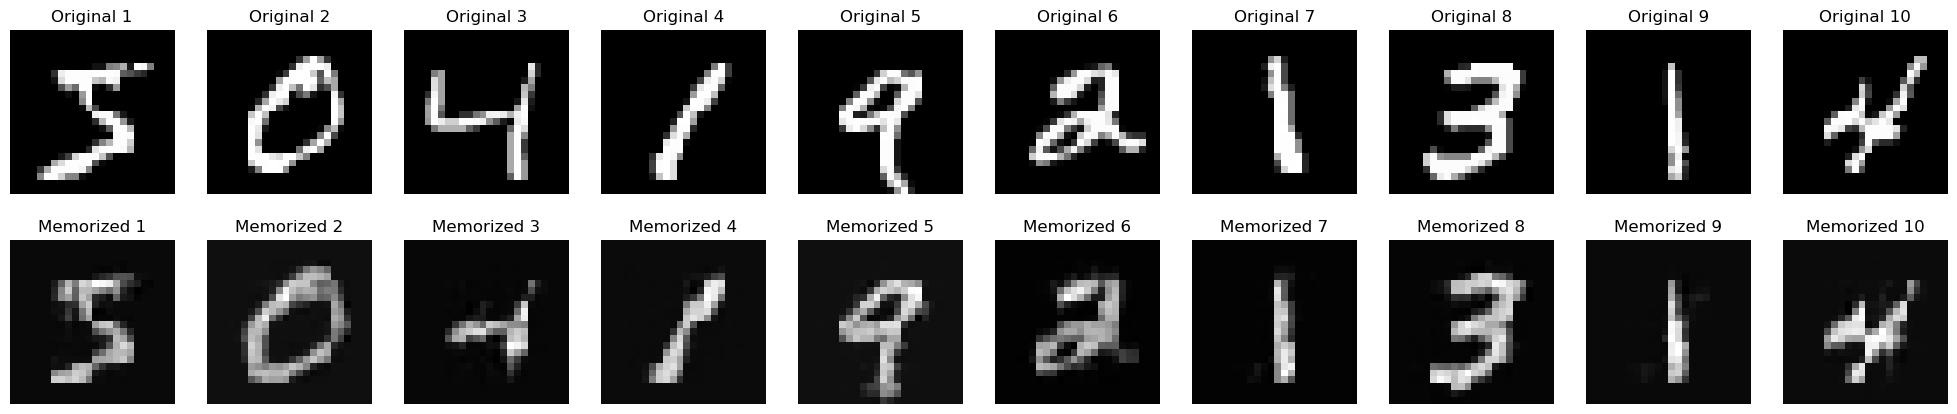

Epoch 136 | Train loss 0.000005 | Memorization loss 0.070816
Visualizing results at Epoch 137


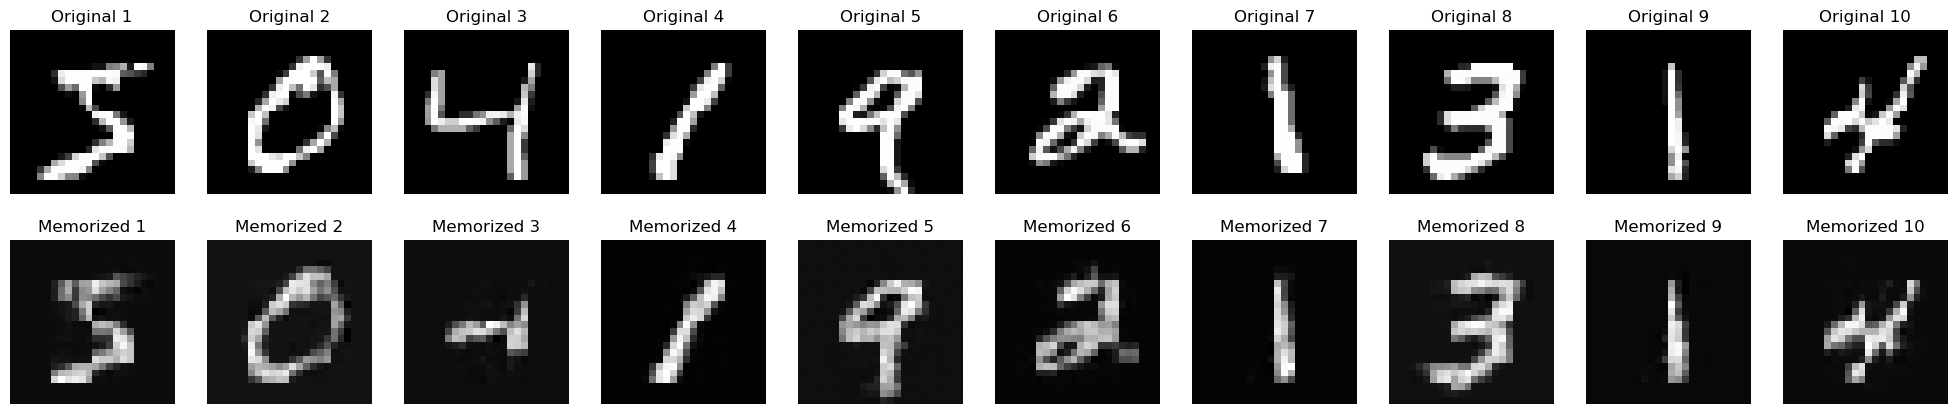

Epoch 137 | Train loss 0.000002 | Memorization loss 0.068234
Saved model and optimizer with memorization loss: 0.0682
Visualizing results at Epoch 138


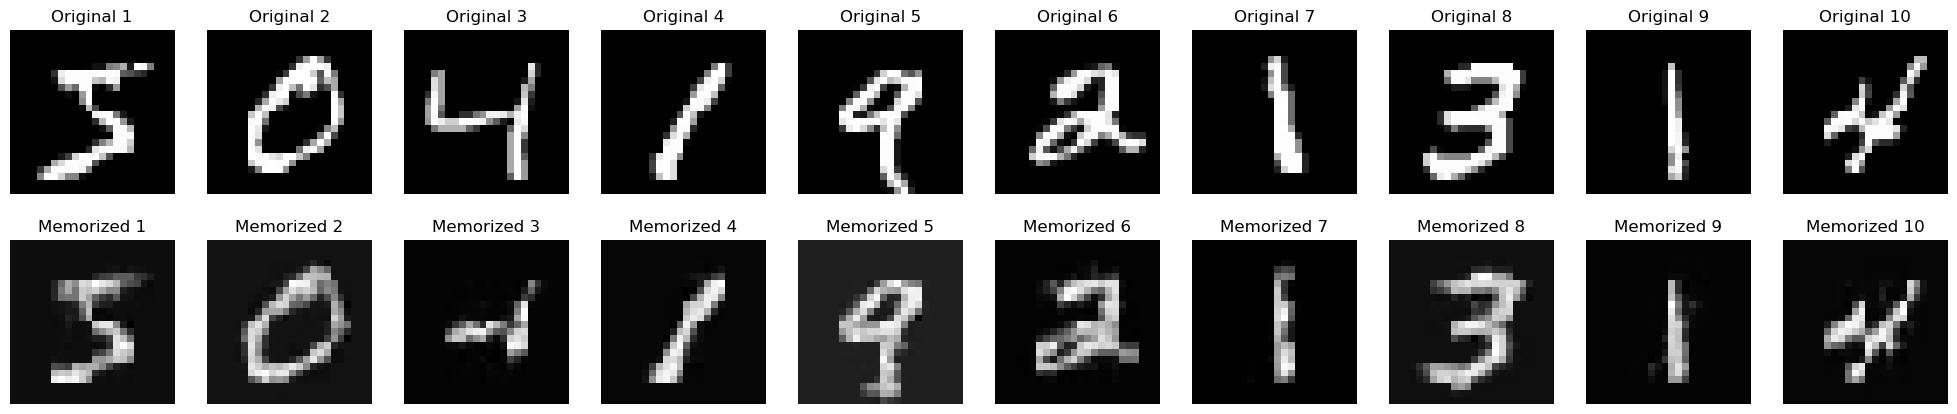

Epoch 138 | Train loss 0.000001 | Memorization loss 0.069188
Visualizing results at Epoch 139


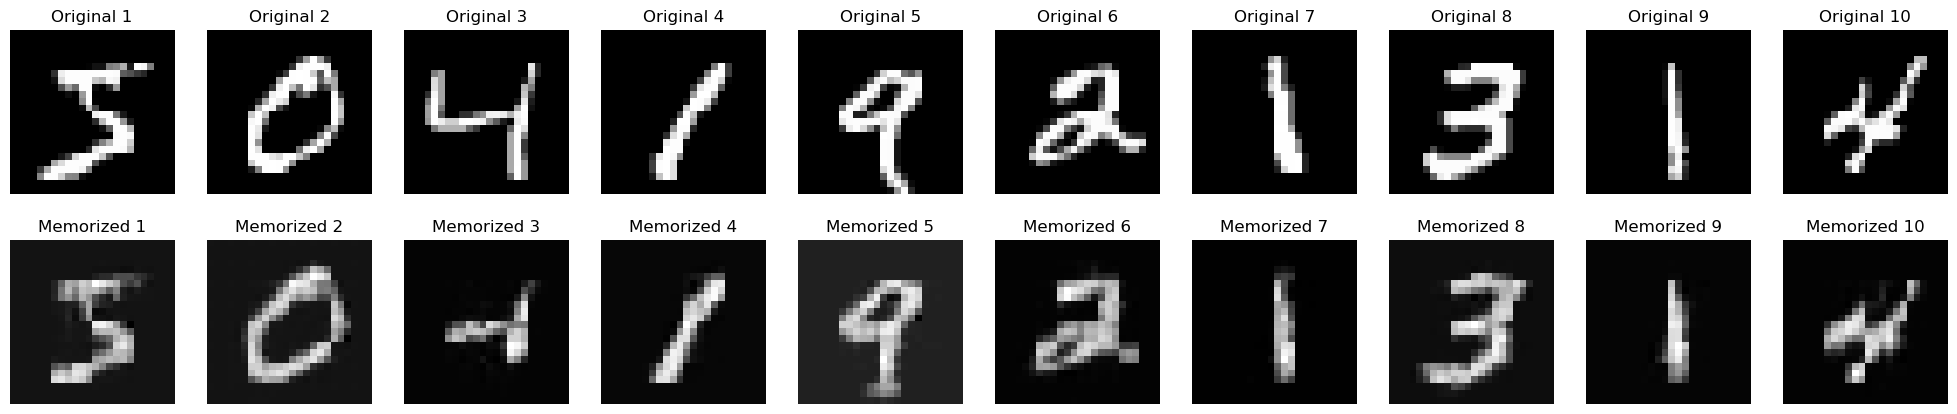

Epoch 139 | Train loss 0.000002 | Memorization loss 0.071600
Visualizing results at Epoch 140


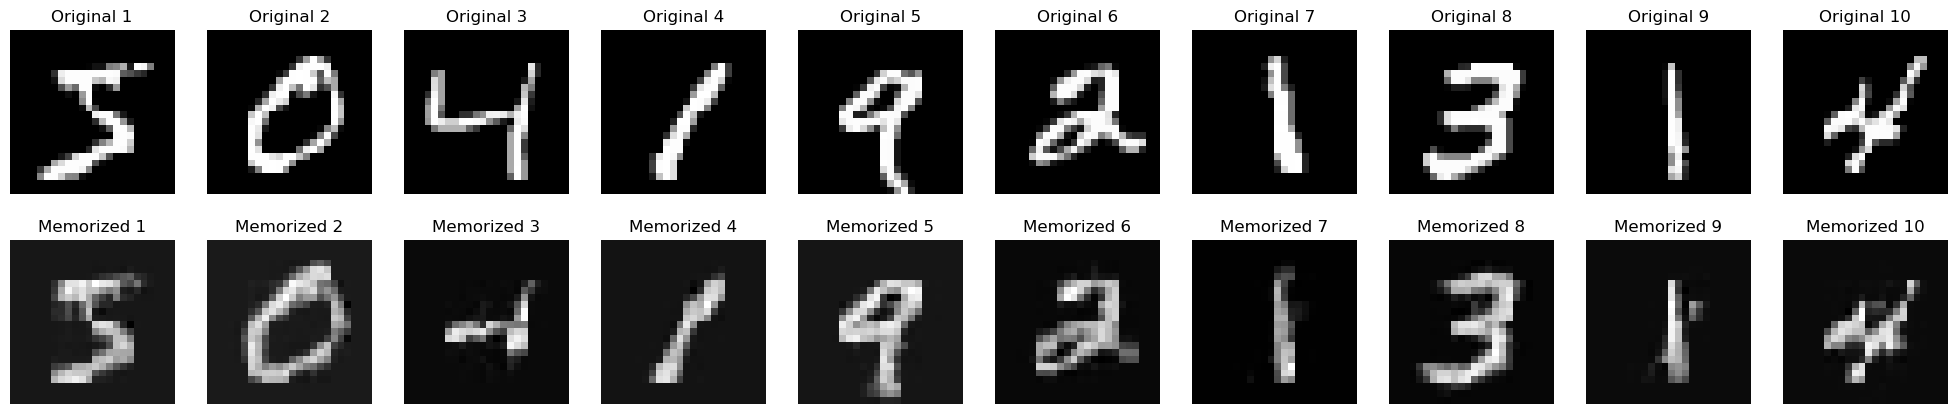

Epoch 140 | Train loss 0.000003 | Memorization loss 0.069537
Visualizing results at Epoch 141


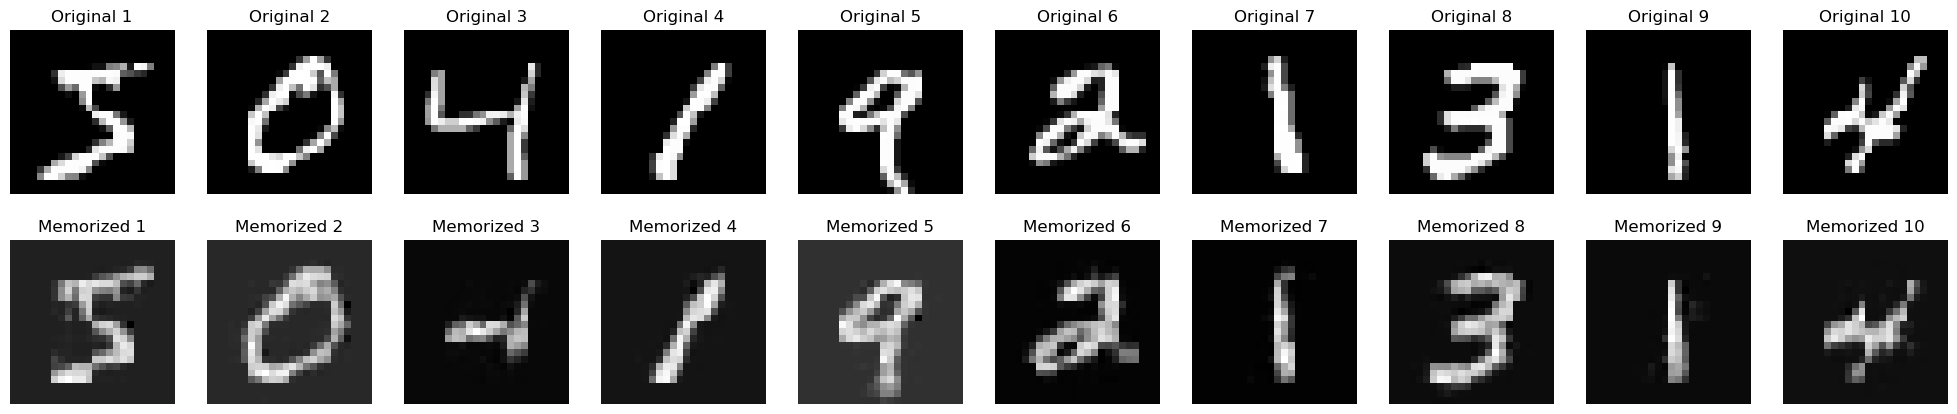

Epoch 141 | Train loss 0.000001 | Memorization loss 0.065987
Saved model and optimizer with memorization loss: 0.0660
Visualizing results at Epoch 142


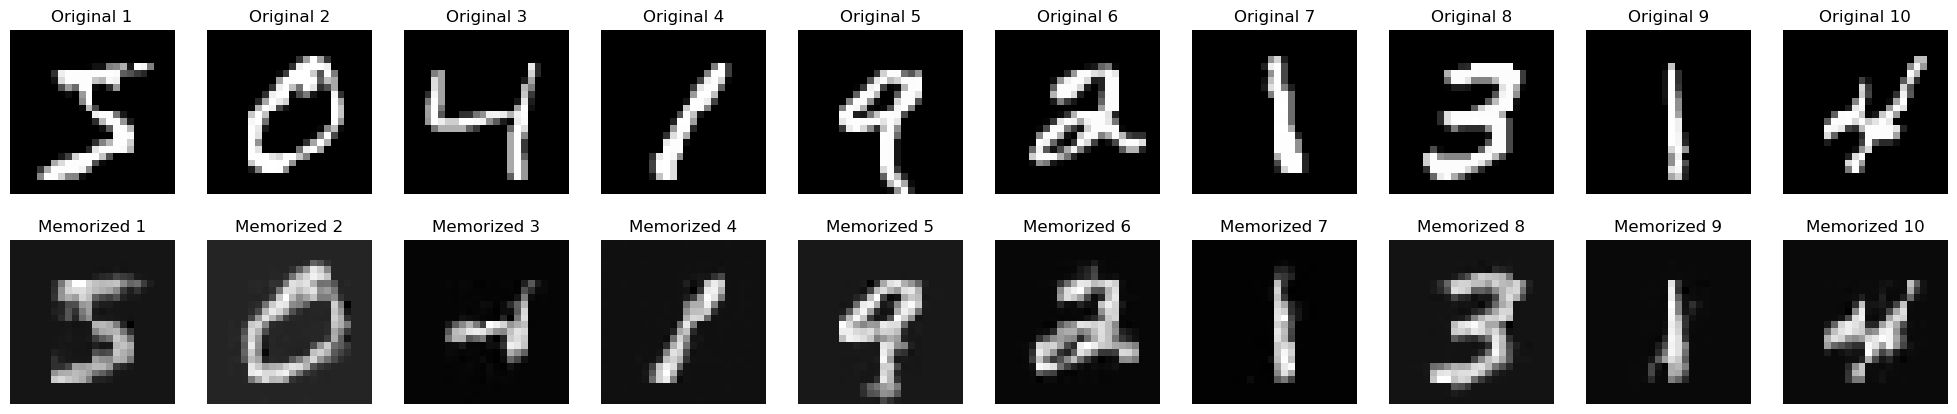

Epoch 142 | Train loss 0.000001 | Memorization loss 0.066689
Visualizing results at Epoch 143


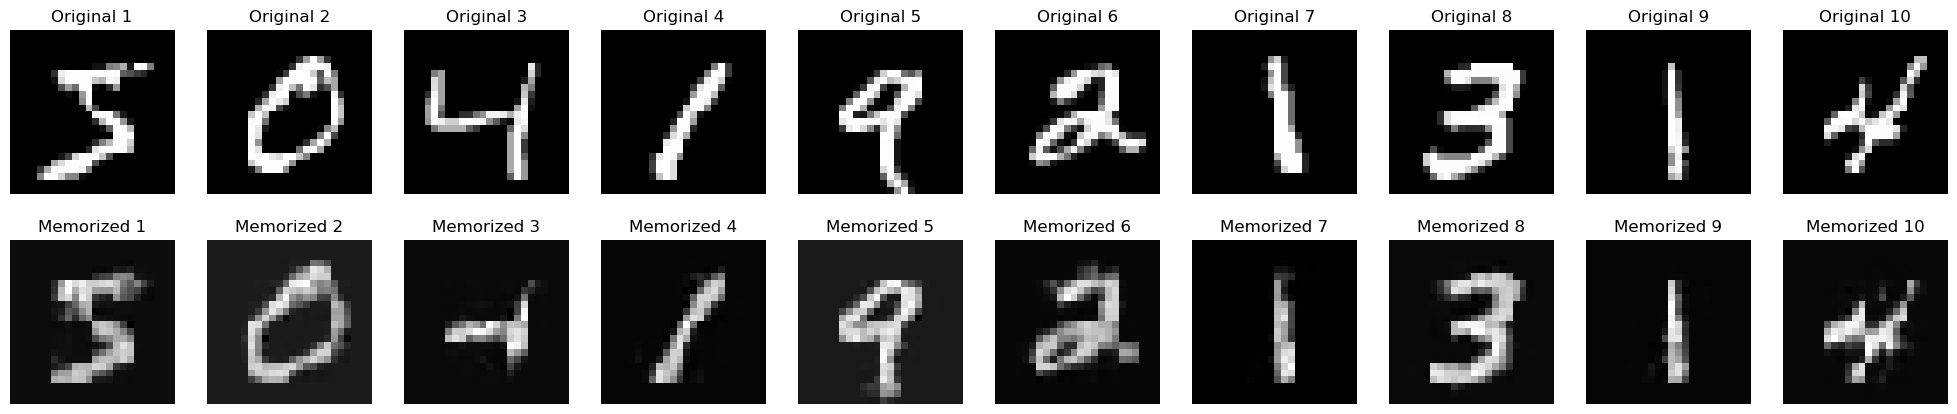

Epoch 143 | Train loss 0.000001 | Memorization loss 0.068655
Visualizing results at Epoch 144


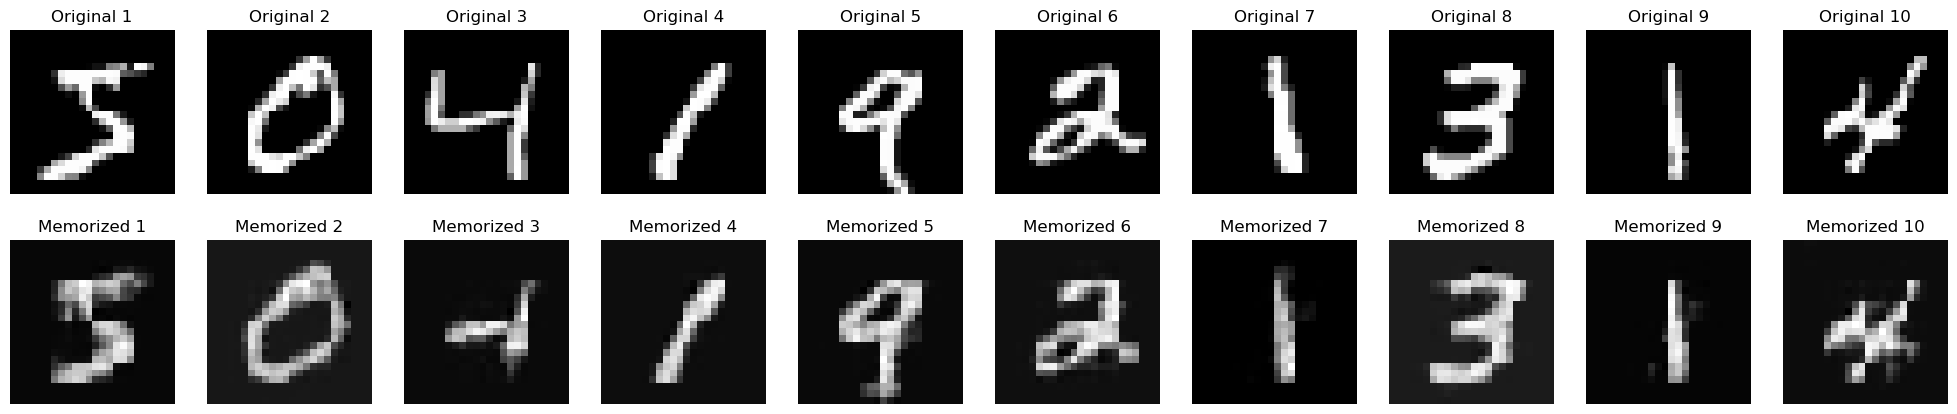

Epoch 144 | Train loss 0.000014 | Memorization loss 0.070363
Visualizing results at Epoch 145


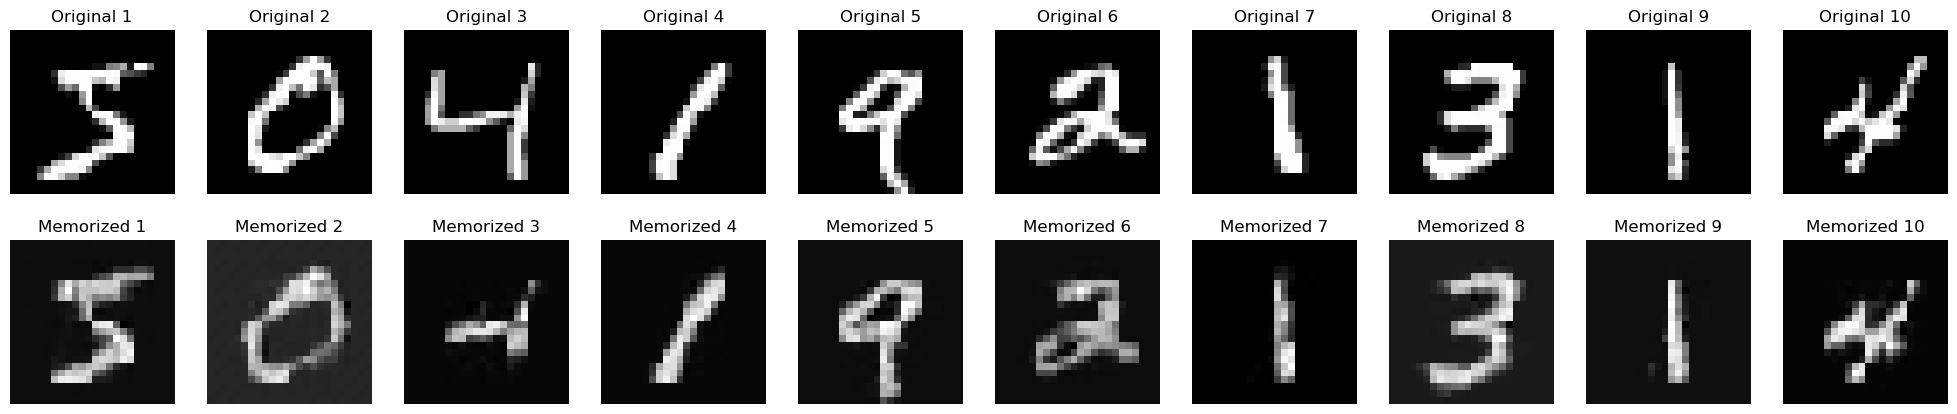

Epoch 145 | Train loss 0.000020 | Memorization loss 0.063366
Saved model and optimizer with memorization loss: 0.0634
Visualizing results at Epoch 146


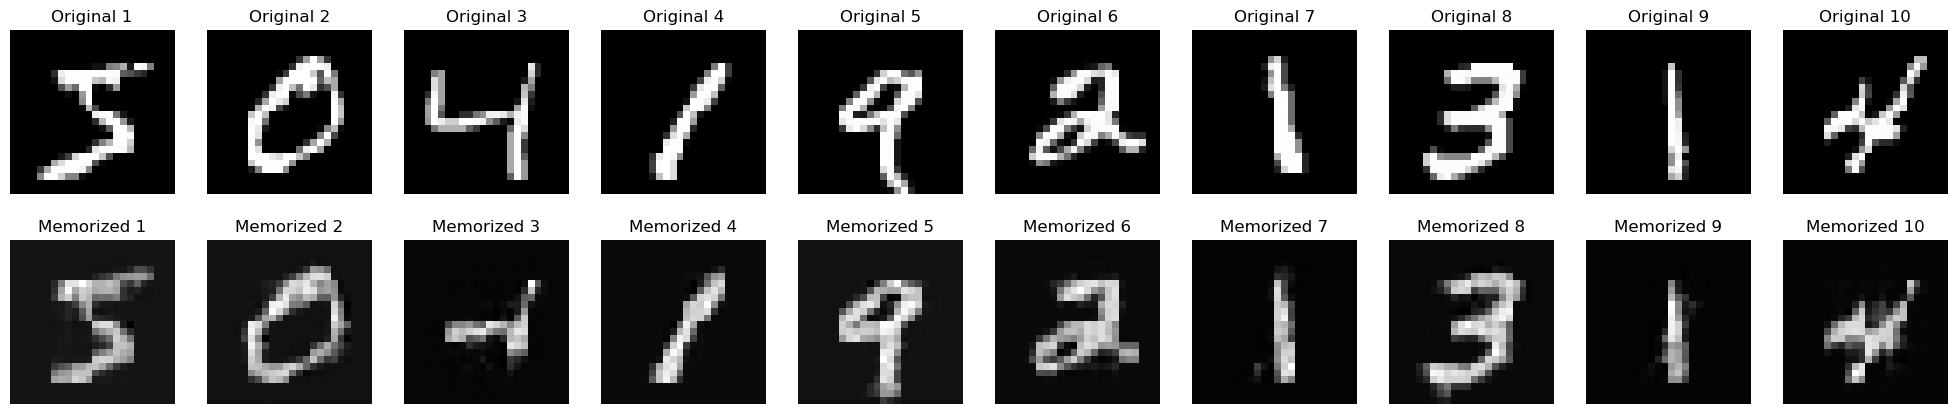

Epoch 146 | Train loss 0.000006 | Memorization loss 0.063963
Visualizing results at Epoch 147


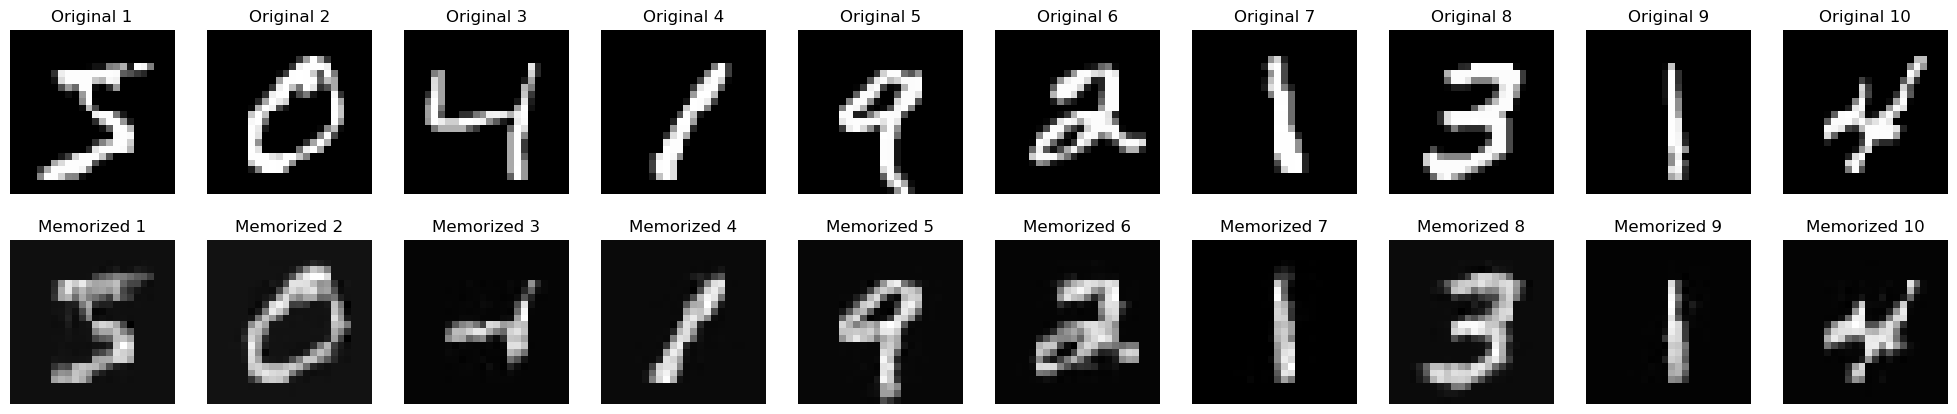

Epoch 147 | Train loss 0.000004 | Memorization loss 0.066256
Visualizing results at Epoch 148


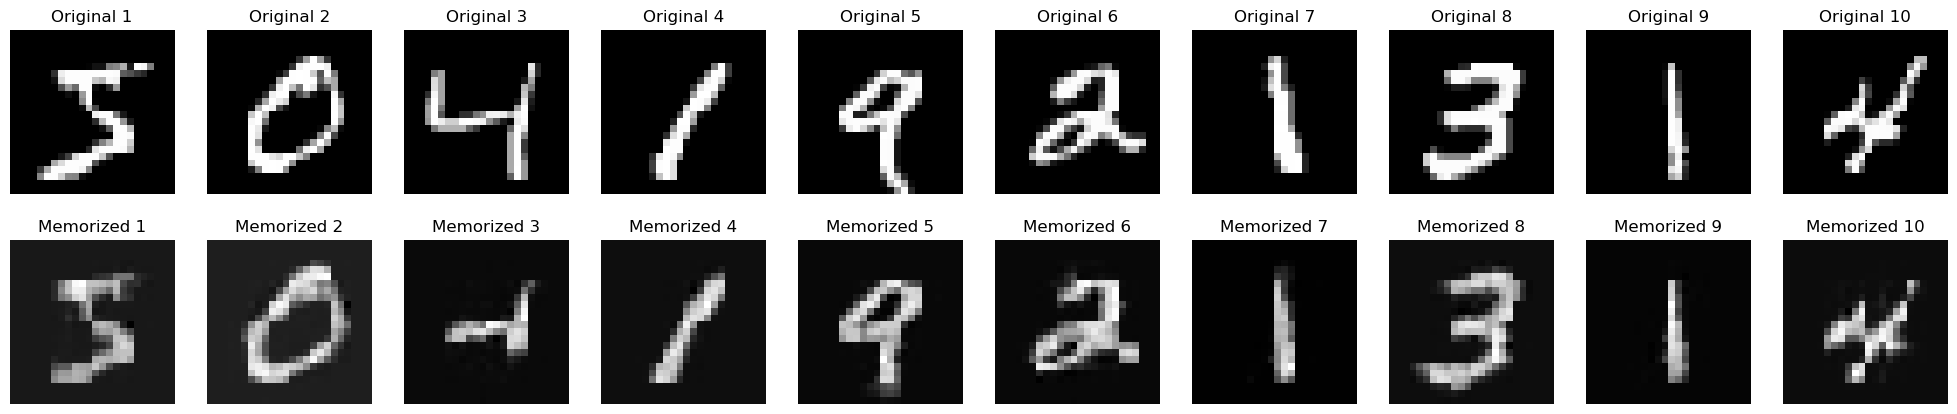

Epoch 148 | Train loss 0.000006 | Memorization loss 0.068901
Visualizing results at Epoch 149


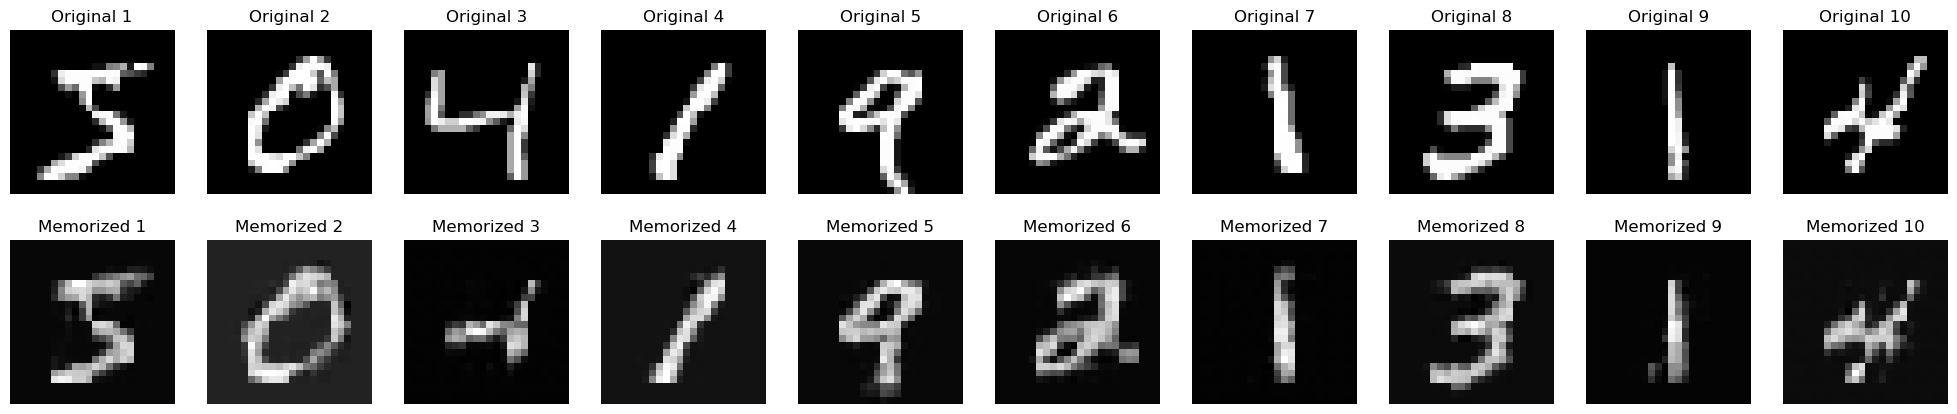

Epoch 149 | Train loss 0.000002 | Memorization loss 0.064528
Visualizing results at Epoch 150


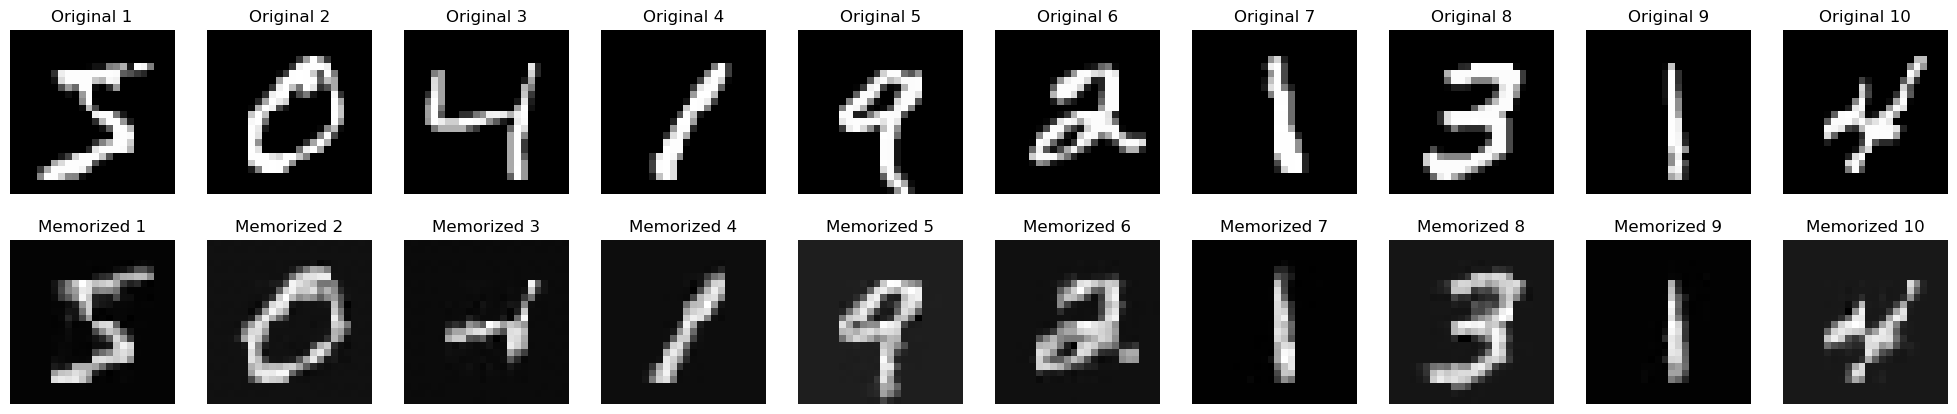

Epoch 150 | Train loss 0.000001 | Memorization loss 0.063642
Visualizing results at Epoch 151


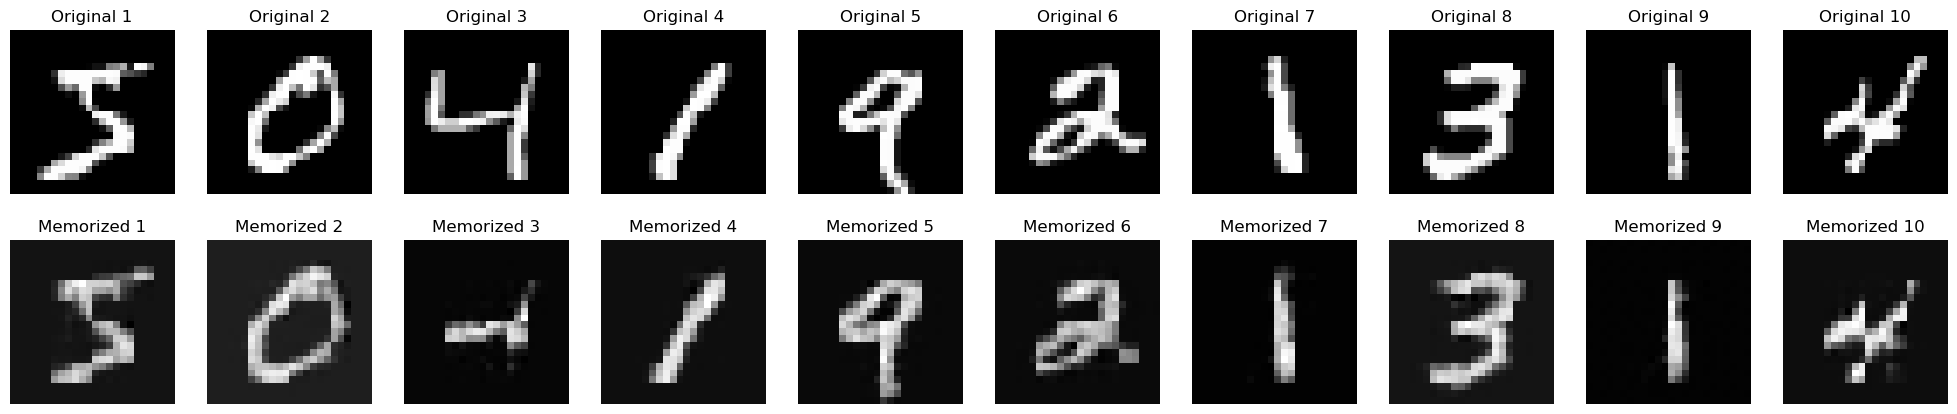

Epoch 151 | Train loss 0.000001 | Memorization loss 0.063339
Saved model and optimizer with memorization loss: 0.0633
Visualizing results at Epoch 152


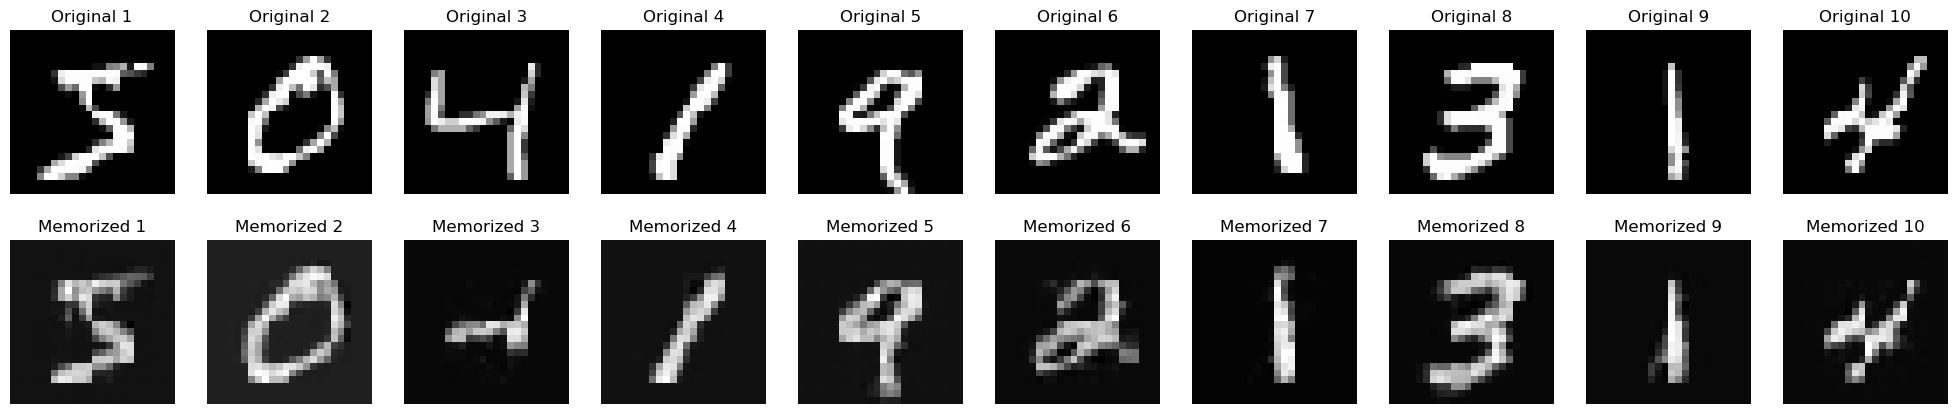

Epoch 152 | Train loss 0.000001 | Memorization loss 0.064799
Visualizing results at Epoch 153


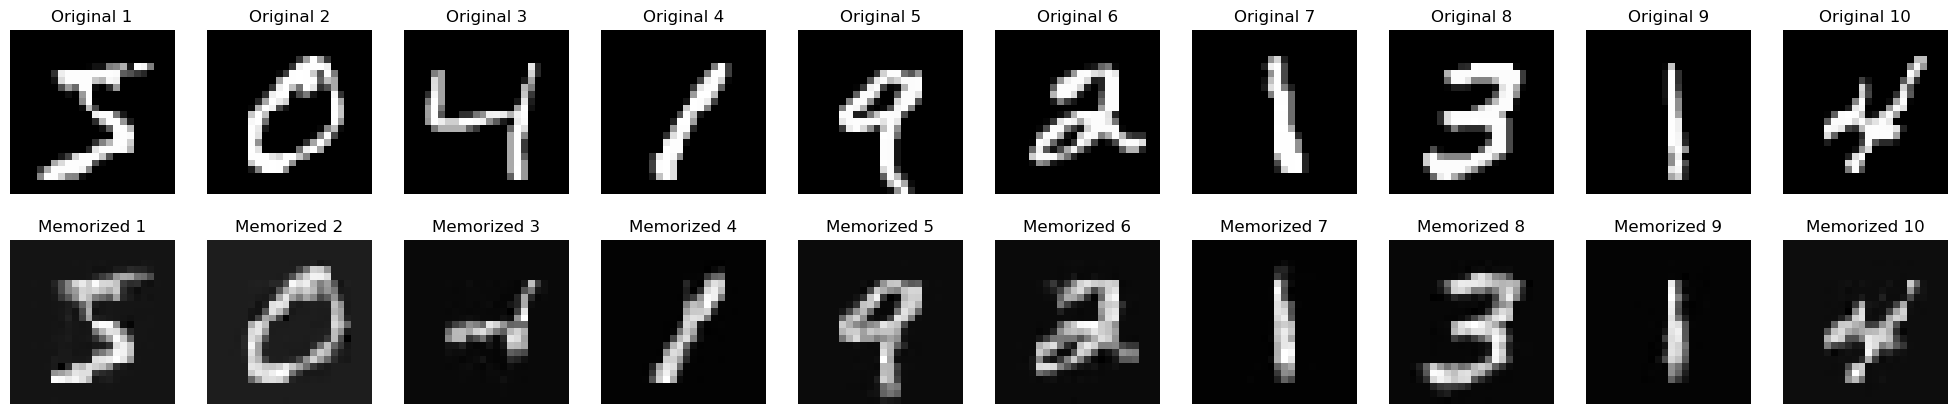

Epoch 153 | Train loss 0.000001 | Memorization loss 0.062897
Saved model and optimizer with memorization loss: 0.0629
Visualizing results at Epoch 154


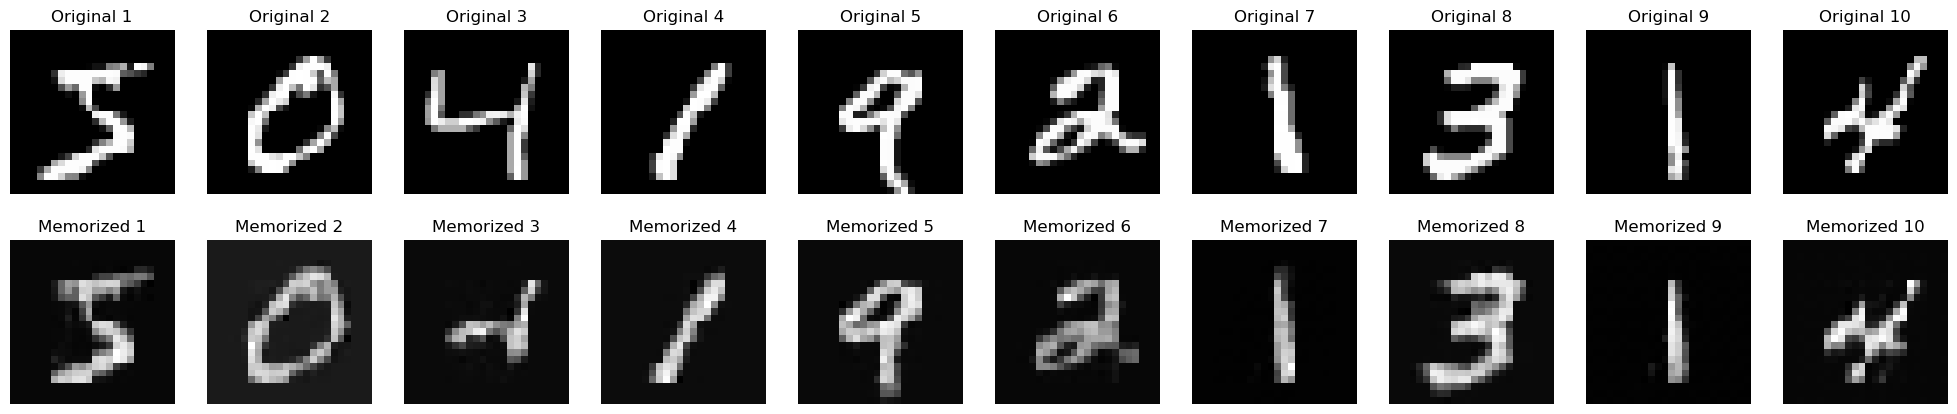

Epoch 154 | Train loss 0.000001 | Memorization loss 0.060519
Saved model and optimizer with memorization loss: 0.0605
Visualizing results at Epoch 155


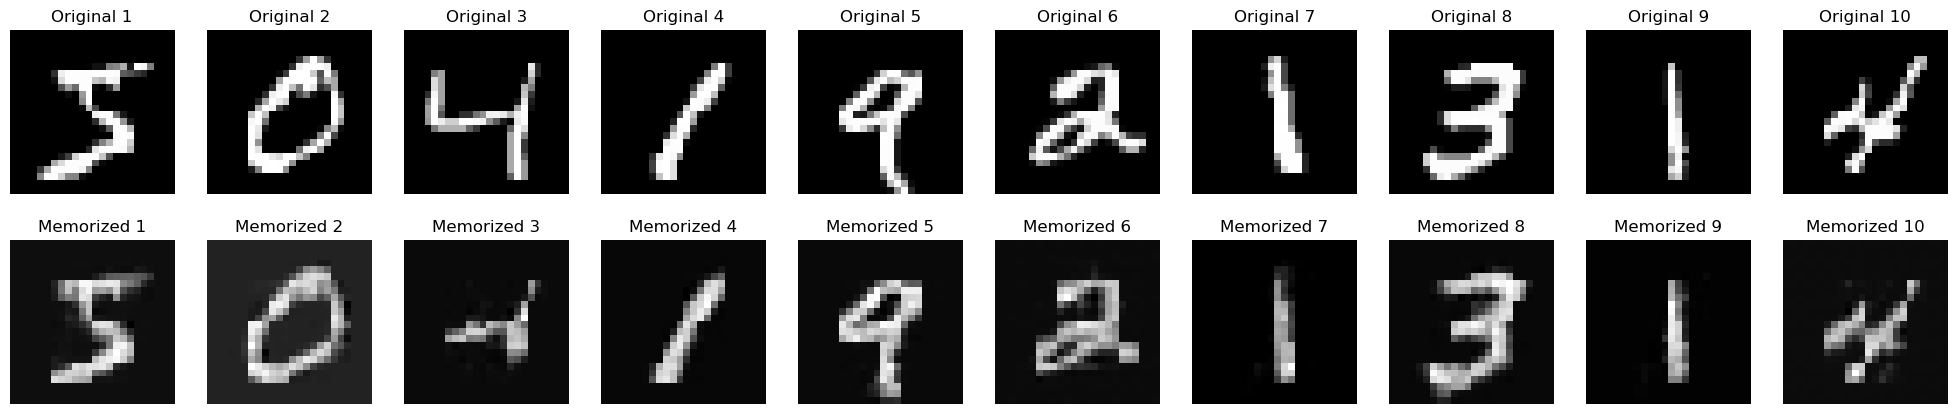

Epoch 155 | Train loss 0.000001 | Memorization loss 0.062910
Visualizing results at Epoch 156


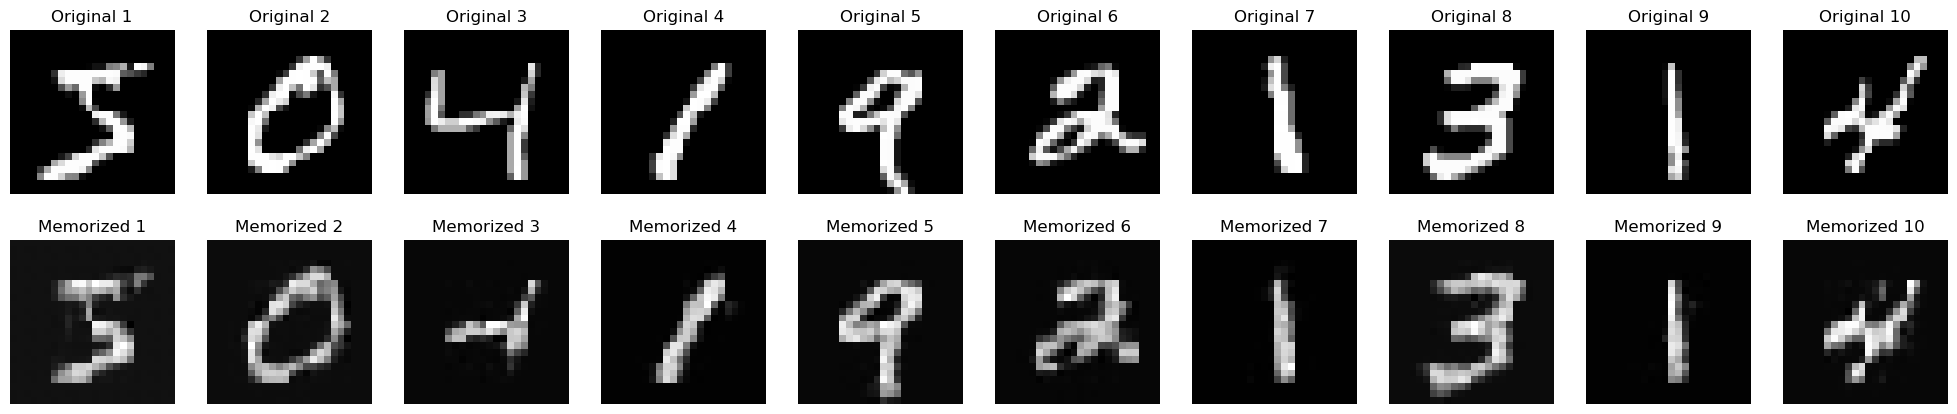

Epoch 156 | Train loss 0.000010 | Memorization loss 0.062350
Visualizing results at Epoch 157


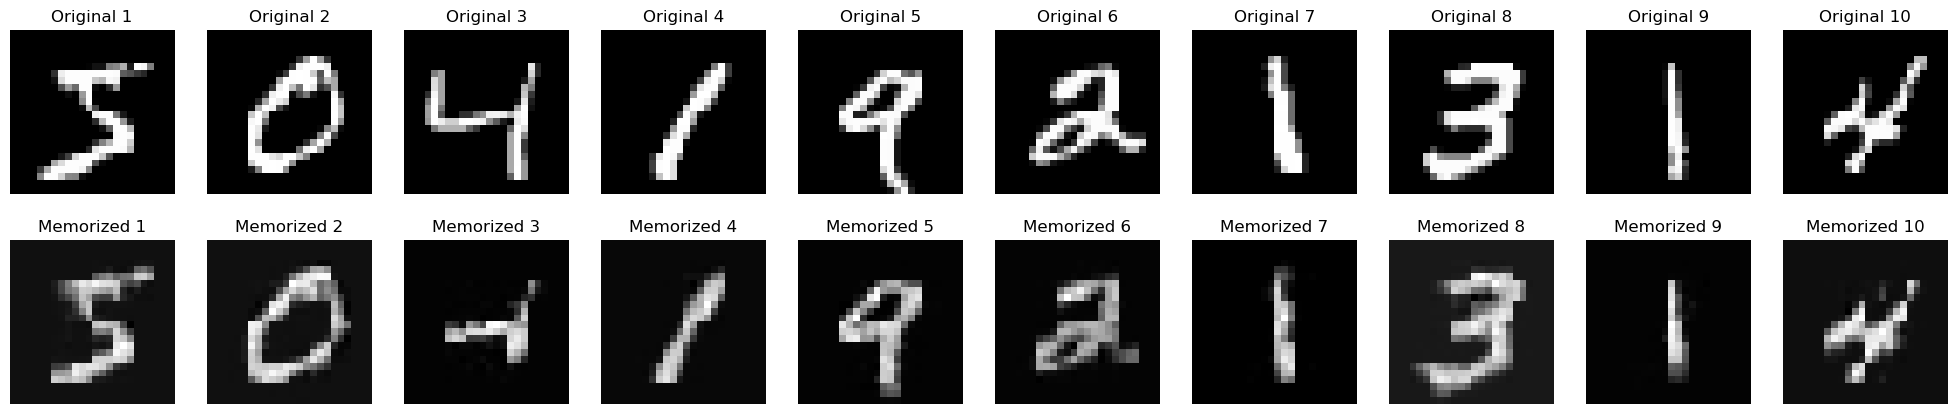

Epoch 157 | Train loss 0.000042 | Memorization loss 0.062468
Visualizing results at Epoch 158


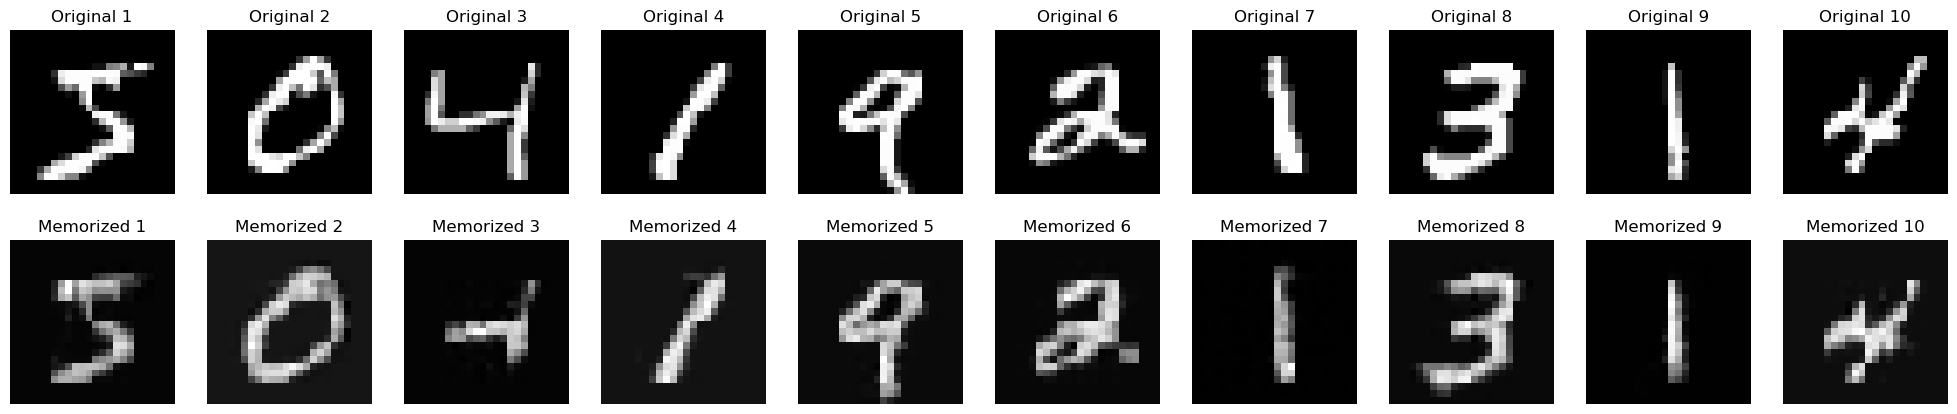

Epoch 158 | Train loss 0.000010 | Memorization loss 0.059607
Saved model and optimizer with memorization loss: 0.0596
Visualizing results at Epoch 159


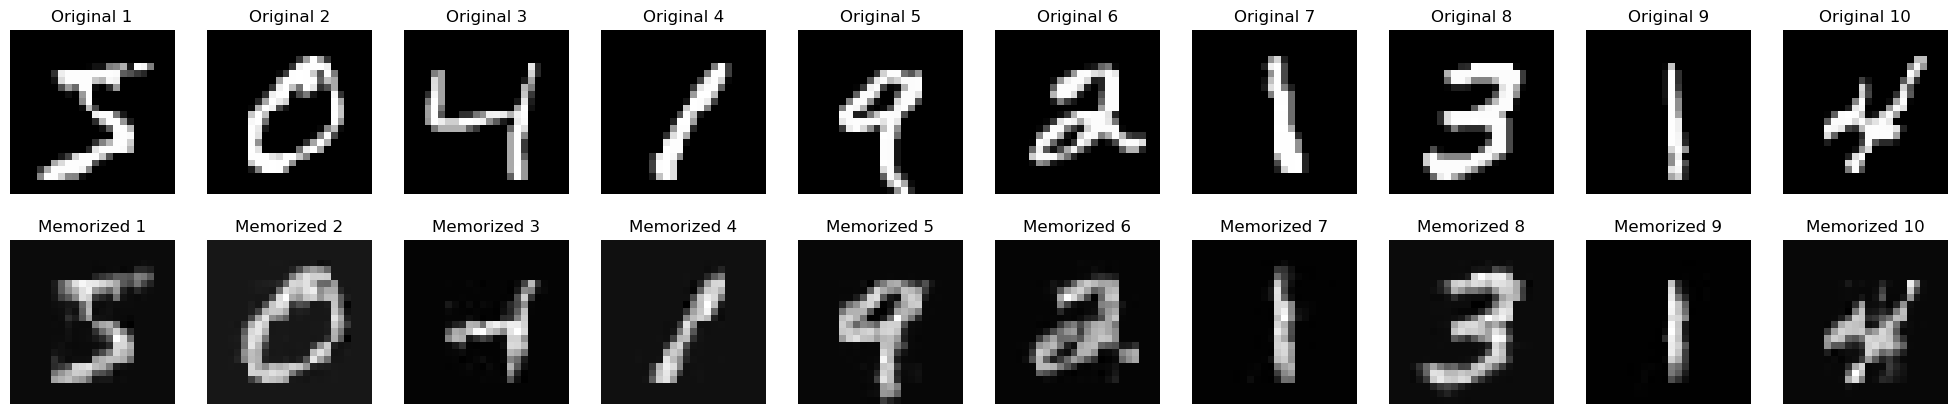

Epoch 159 | Train loss 0.000003 | Memorization loss 0.059562
Saved model and optimizer with memorization loss: 0.0596
Visualizing results at Epoch 160


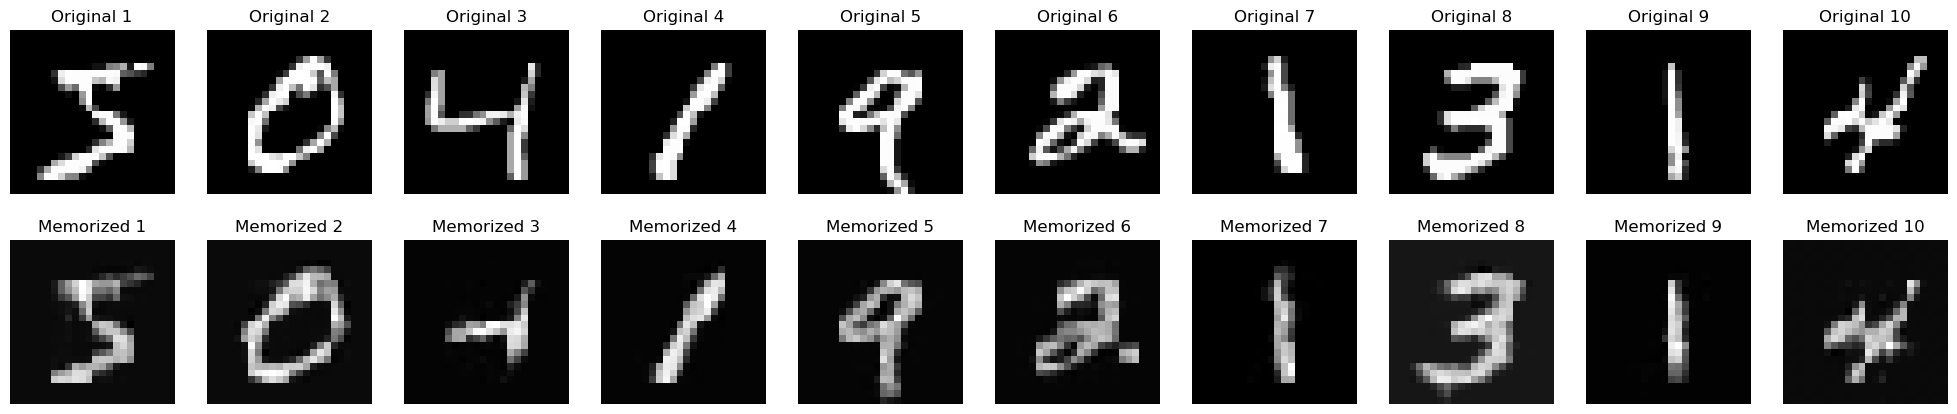

Epoch 160 | Train loss 0.000002 | Memorization loss 0.061581
Visualizing results at Epoch 161


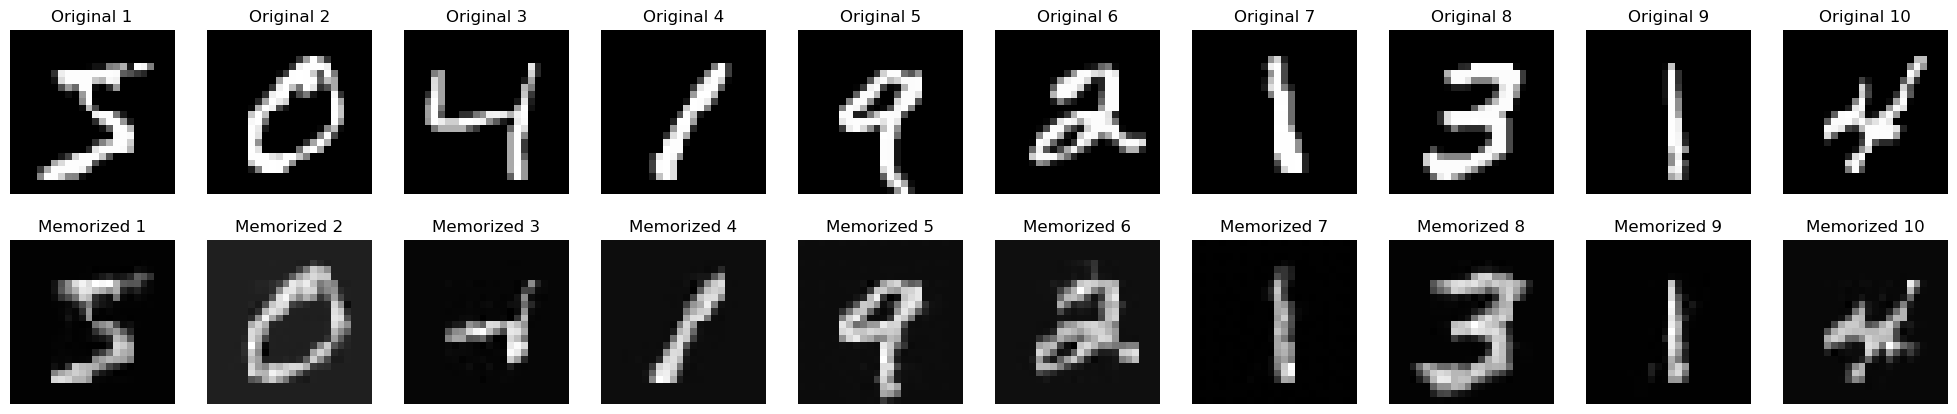

Epoch 161 | Train loss 0.000002 | Memorization loss 0.062627
Visualizing results at Epoch 162


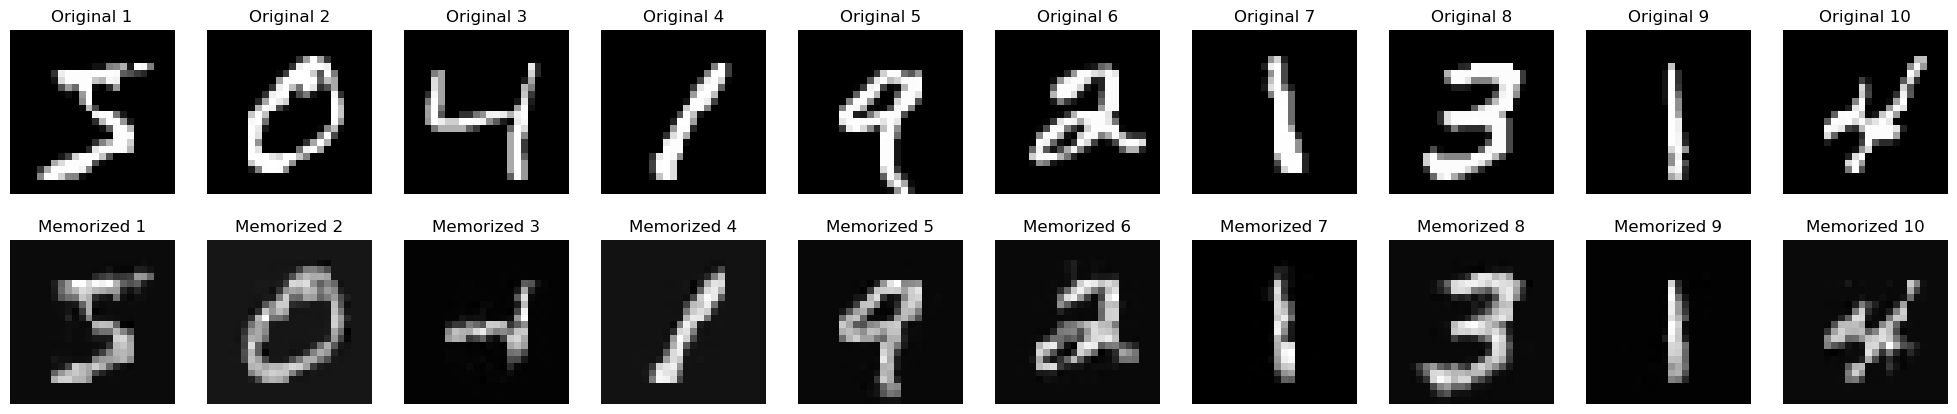

Epoch 162 | Train loss 0.000002 | Memorization loss 0.057655
Saved model and optimizer with memorization loss: 0.0577
Visualizing results at Epoch 163


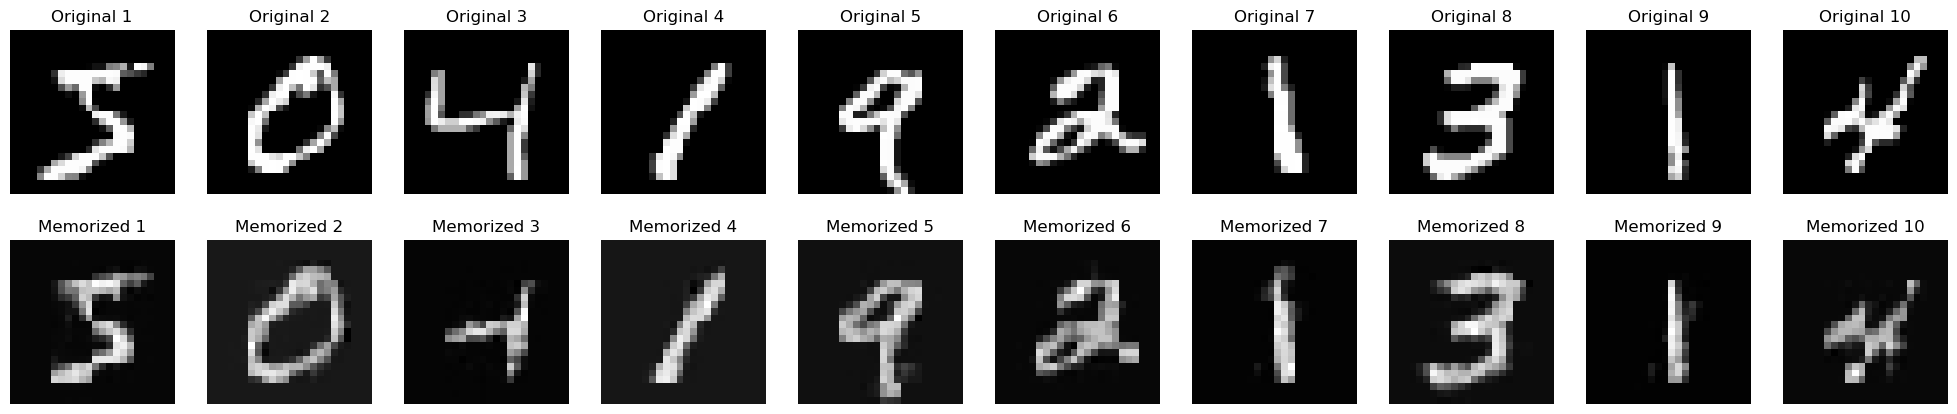

Epoch 163 | Train loss 0.000001 | Memorization loss 0.057785
Visualizing results at Epoch 164


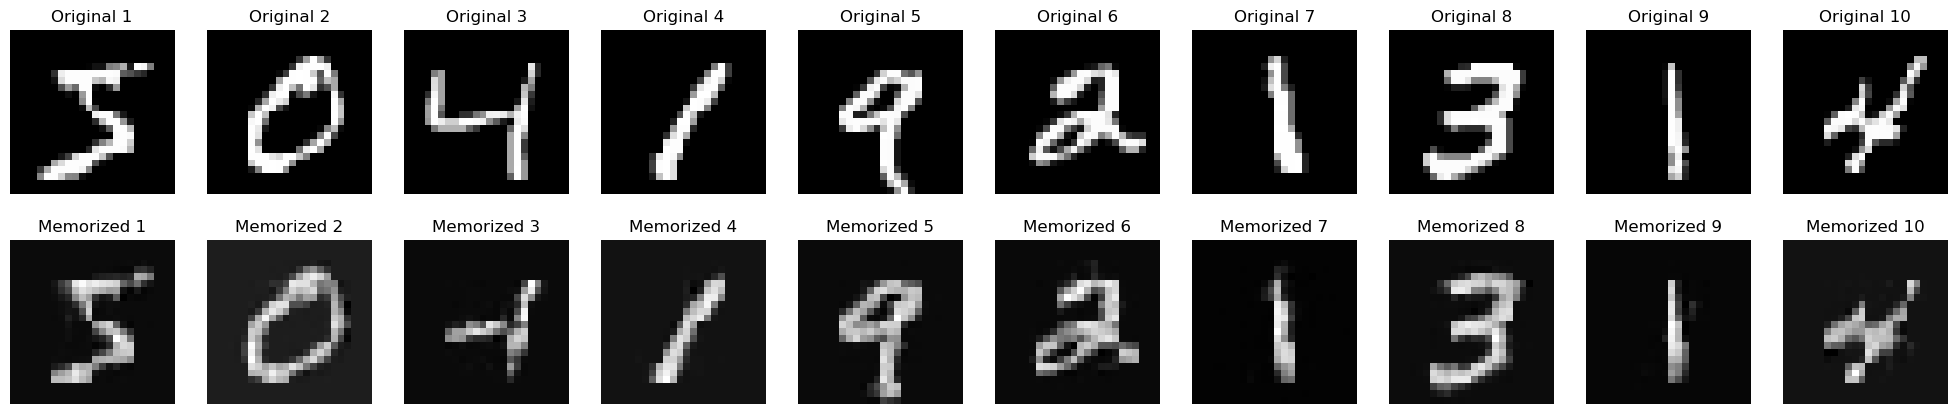

Epoch 164 | Train loss 0.000001 | Memorization loss 0.059836
Visualizing results at Epoch 165


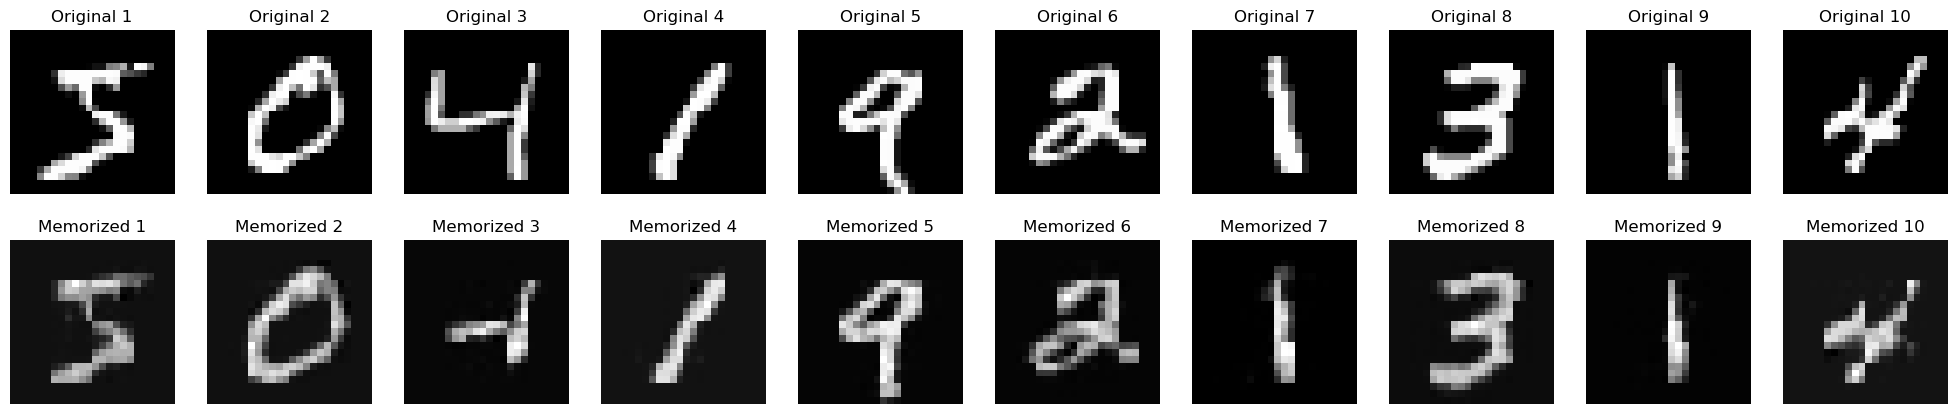

Epoch 165 | Train loss 0.000001 | Memorization loss 0.060503
Visualizing results at Epoch 166


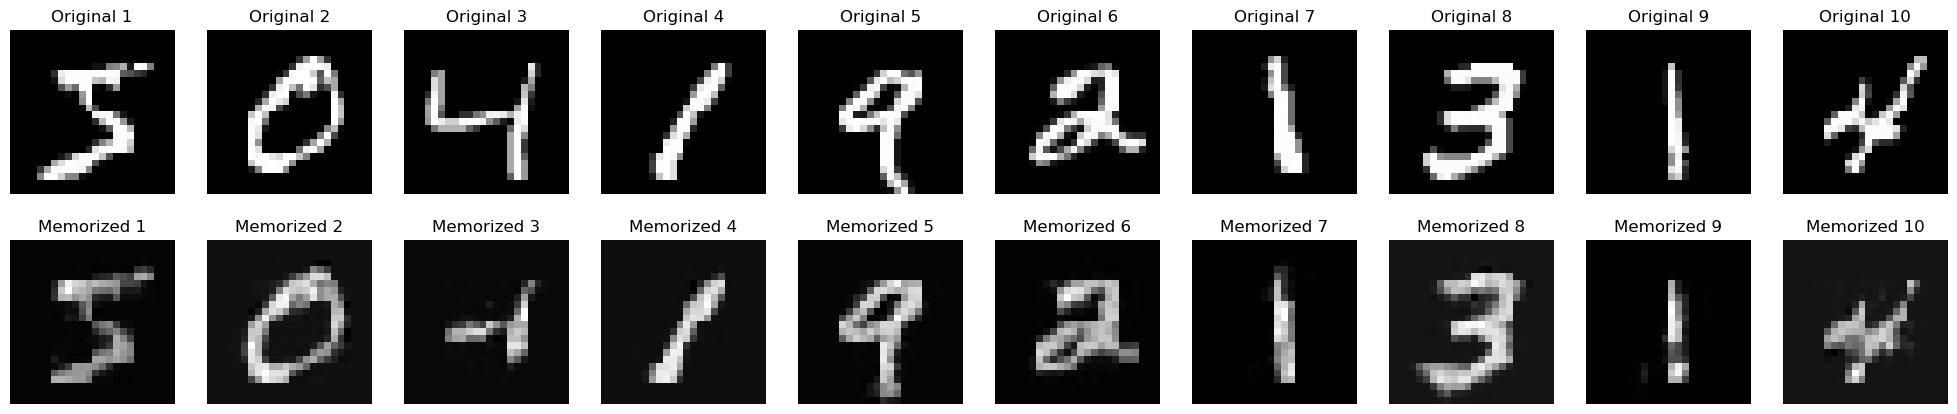

Epoch 166 | Train loss 0.000004 | Memorization loss 0.056730
Saved model and optimizer with memorization loss: 0.0567
Visualizing results at Epoch 167


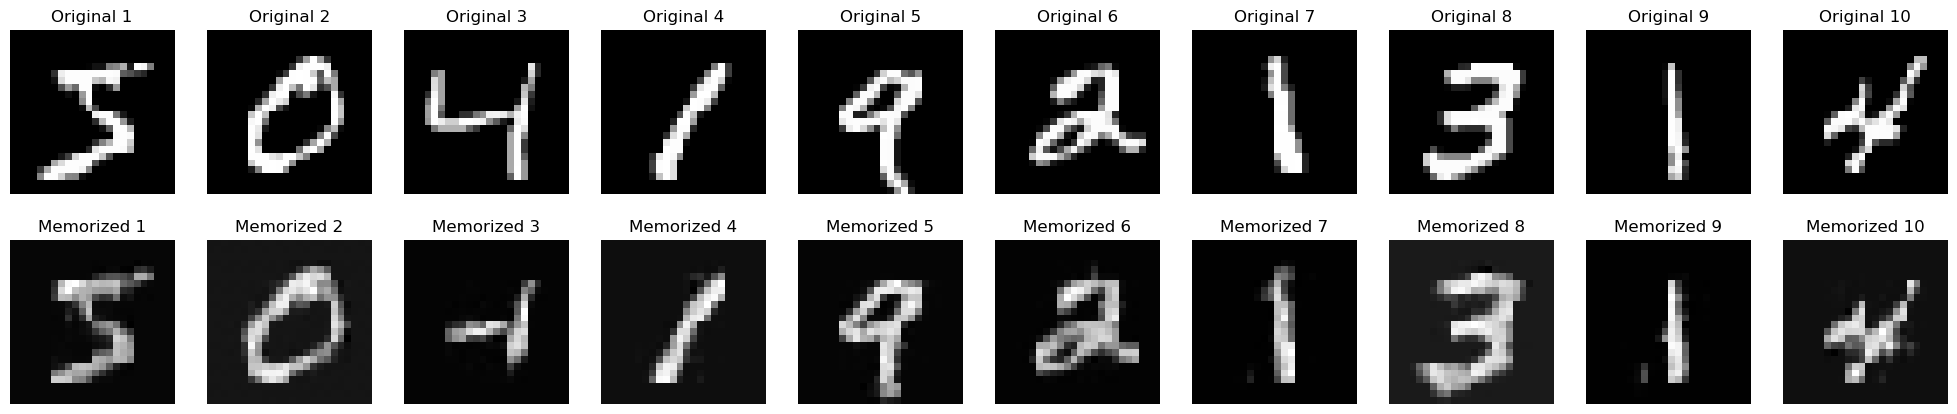

Epoch 167 | Train loss 0.000021 | Memorization loss 0.056627
Saved model and optimizer with memorization loss: 0.0566
Visualizing results at Epoch 168


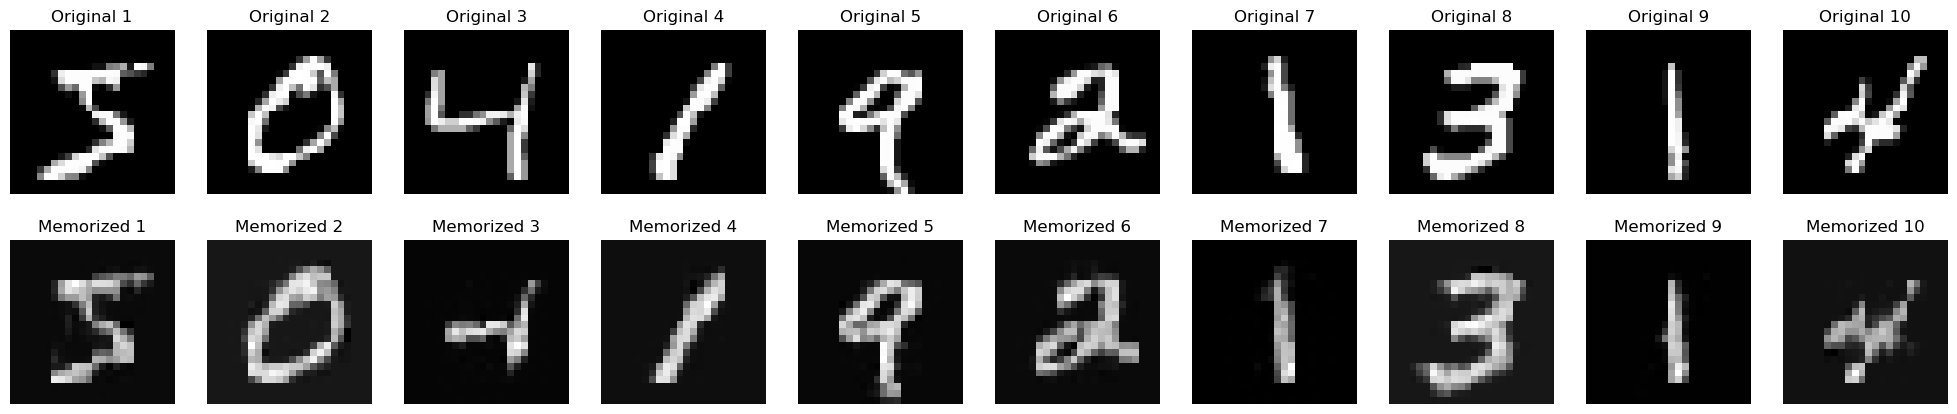

Epoch 168 | Train loss 0.000012 | Memorization loss 0.058032
Visualizing results at Epoch 169


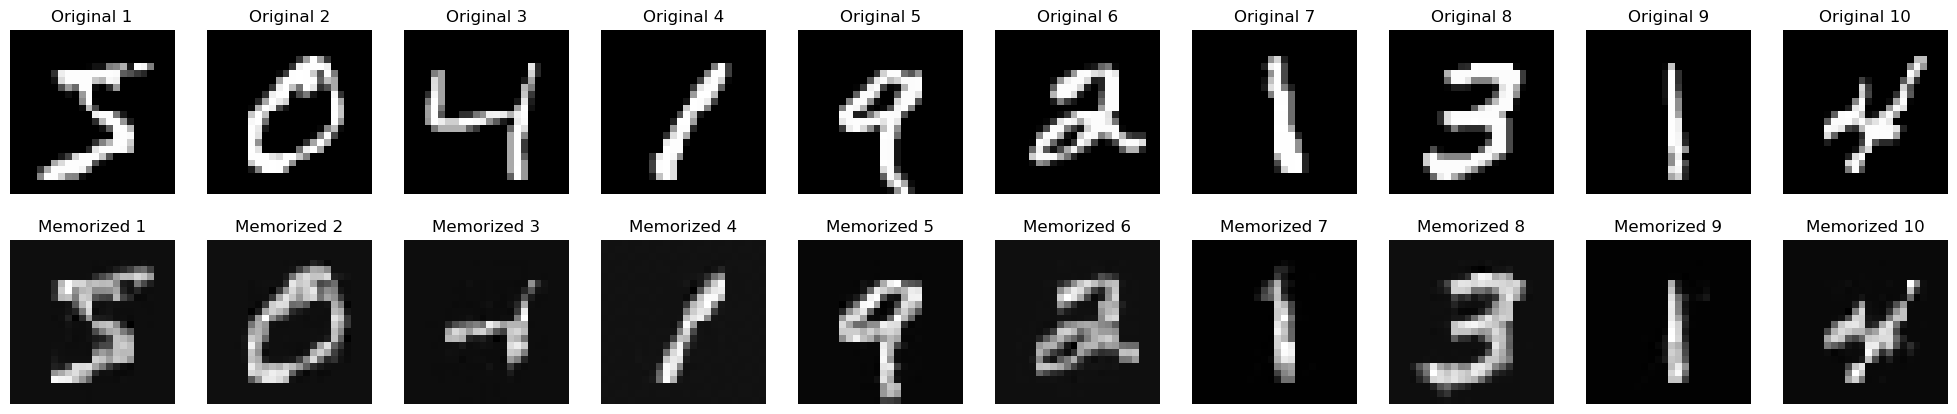

Epoch 169 | Train loss 0.000009 | Memorization loss 0.057880
Visualizing results at Epoch 170


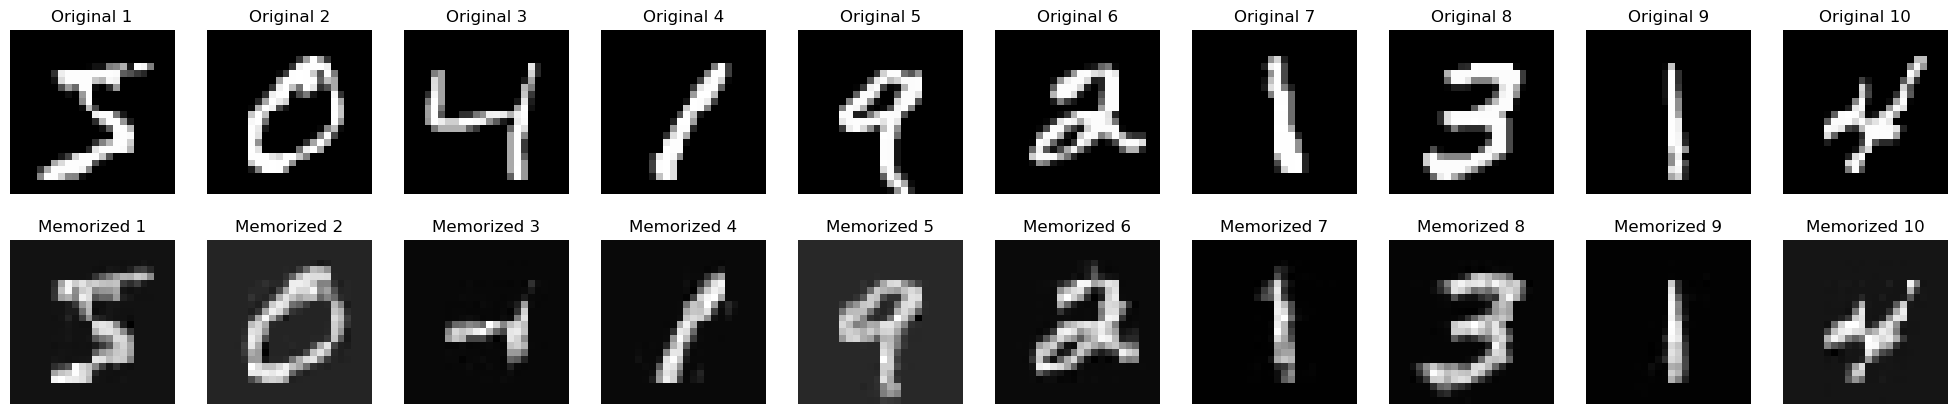

Epoch 170 | Train loss 0.000002 | Memorization loss 0.057500
Visualizing results at Epoch 171


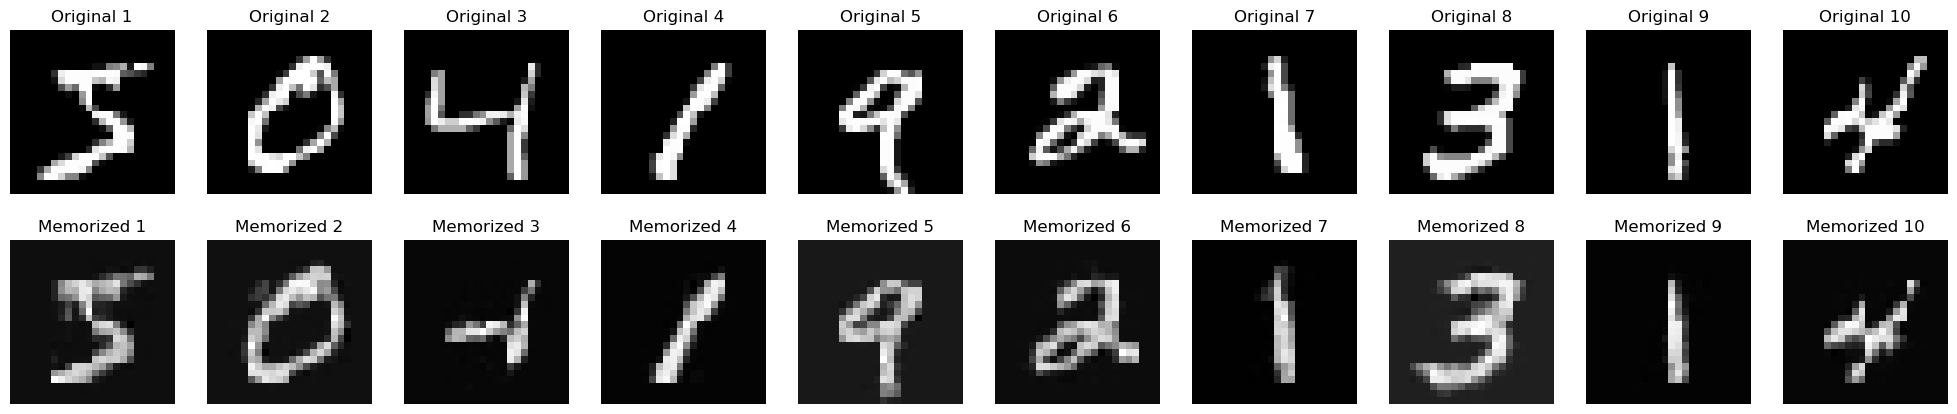

Epoch 171 | Train loss 0.000001 | Memorization loss 0.055863
Saved model and optimizer with memorization loss: 0.0559
Visualizing results at Epoch 172


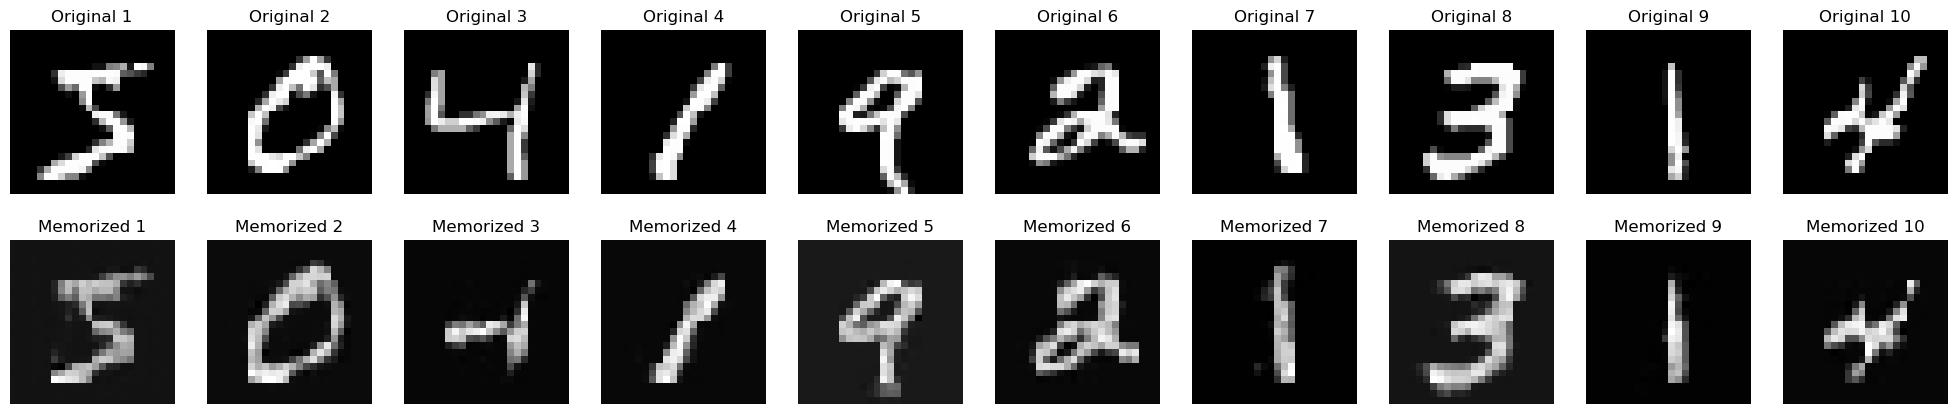

Epoch 172 | Train loss 0.000001 | Memorization loss 0.056110
Visualizing results at Epoch 173


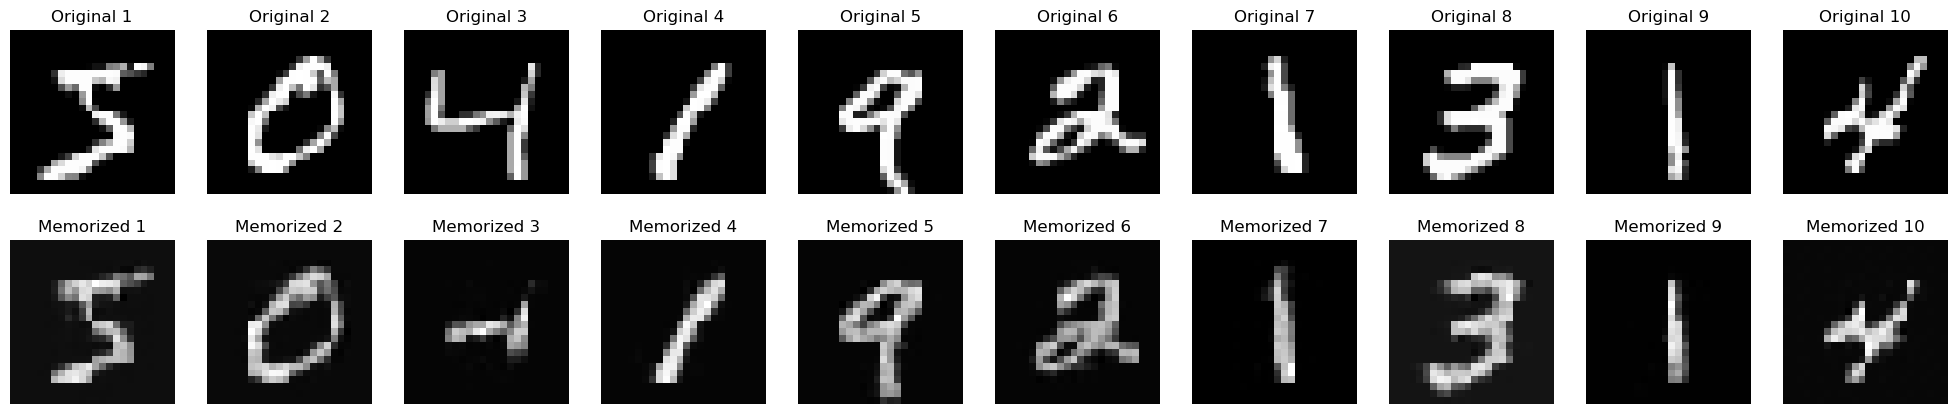

Epoch 173 | Train loss 0.000001 | Memorization loss 0.056270
Visualizing results at Epoch 174


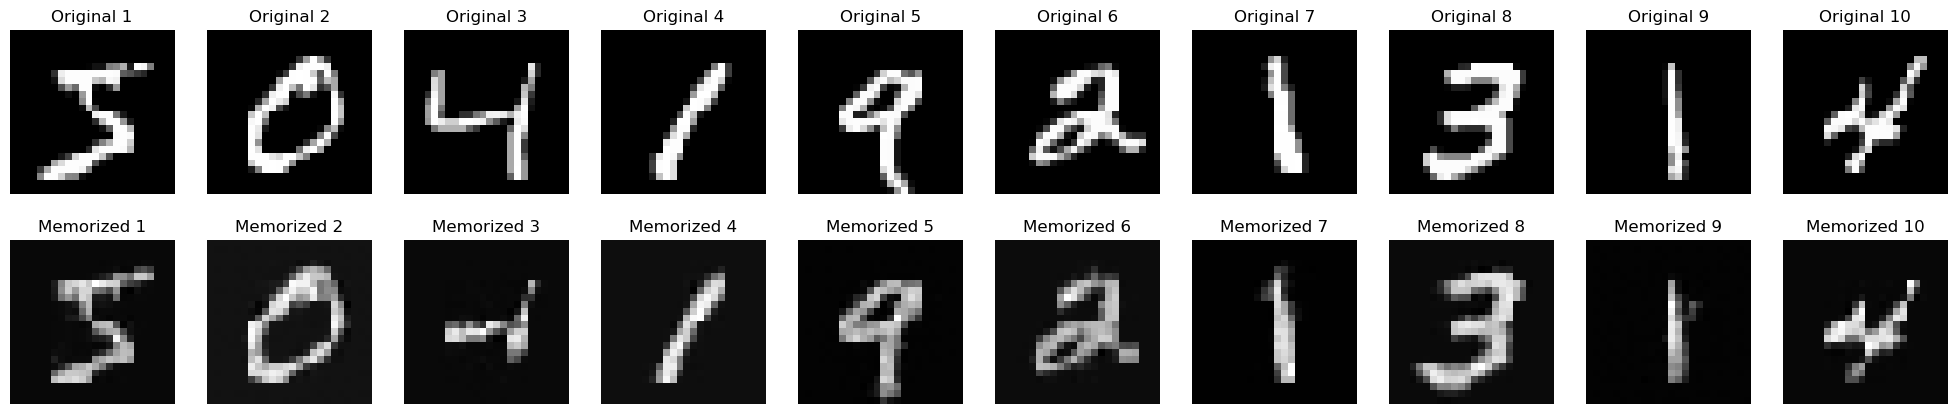

Epoch 174 | Train loss 0.000001 | Memorization loss 0.057308
Visualizing results at Epoch 175


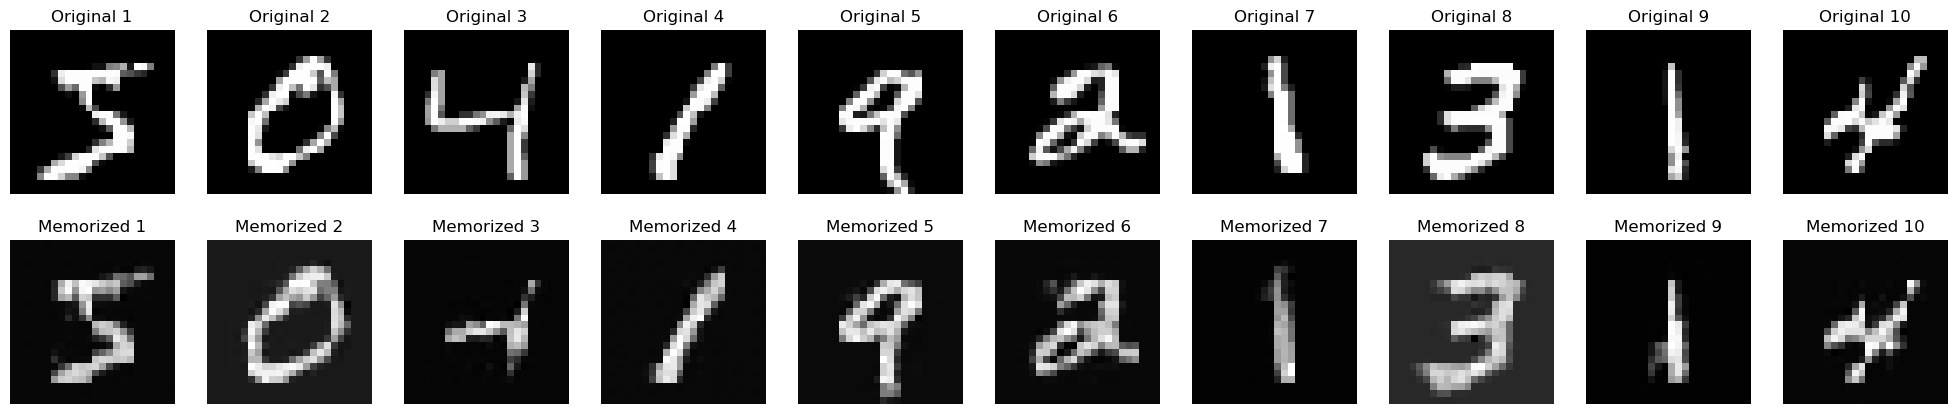

Epoch 175 | Train loss 0.000001 | Memorization loss 0.053756
Saved model and optimizer with memorization loss: 0.0538
Visualizing results at Epoch 176


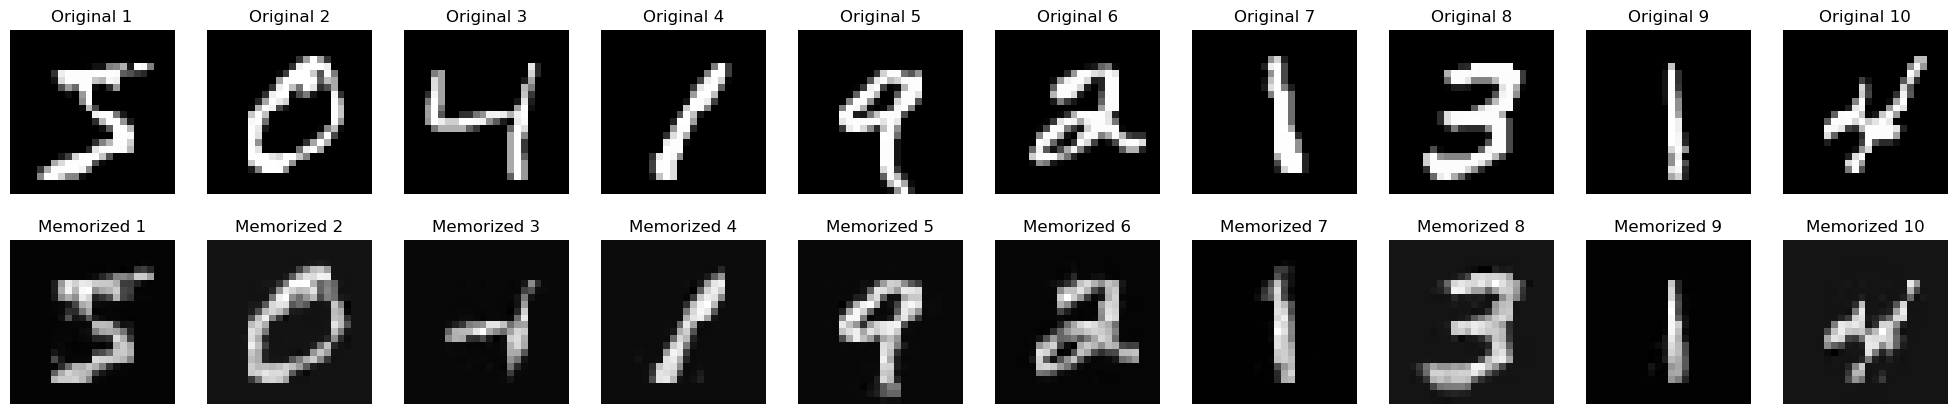

Epoch 176 | Train loss 0.000001 | Memorization loss 0.054577
Visualizing results at Epoch 177


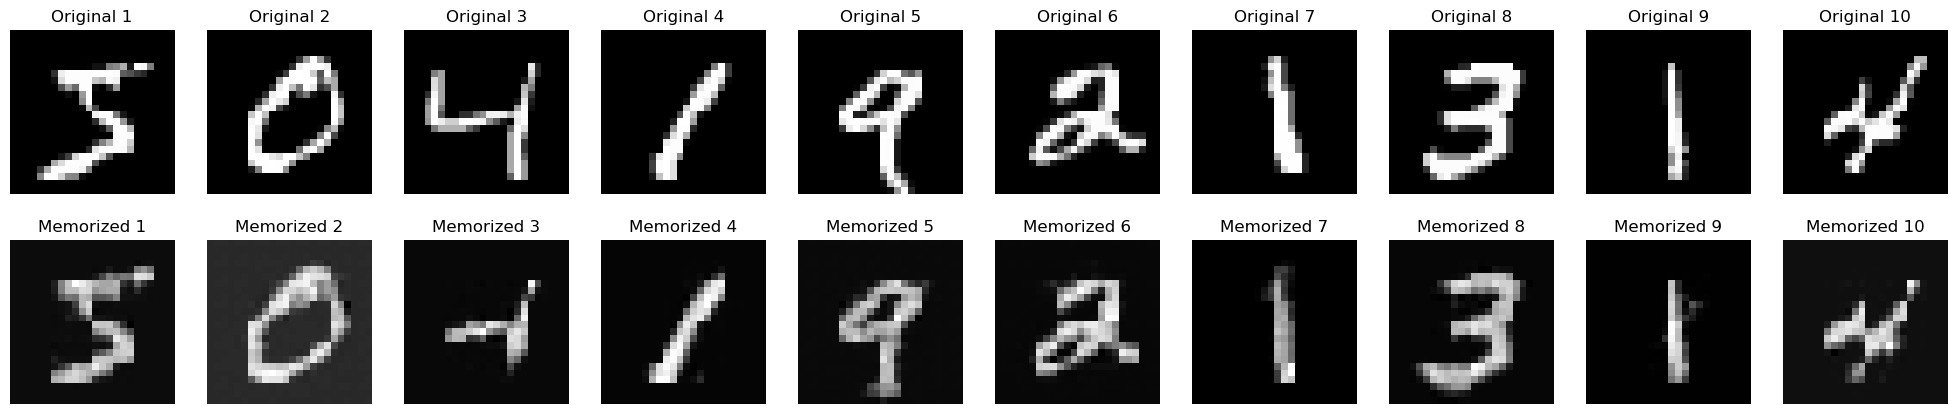

Epoch 177 | Train loss 0.000002 | Memorization loss 0.055497
Visualizing results at Epoch 178


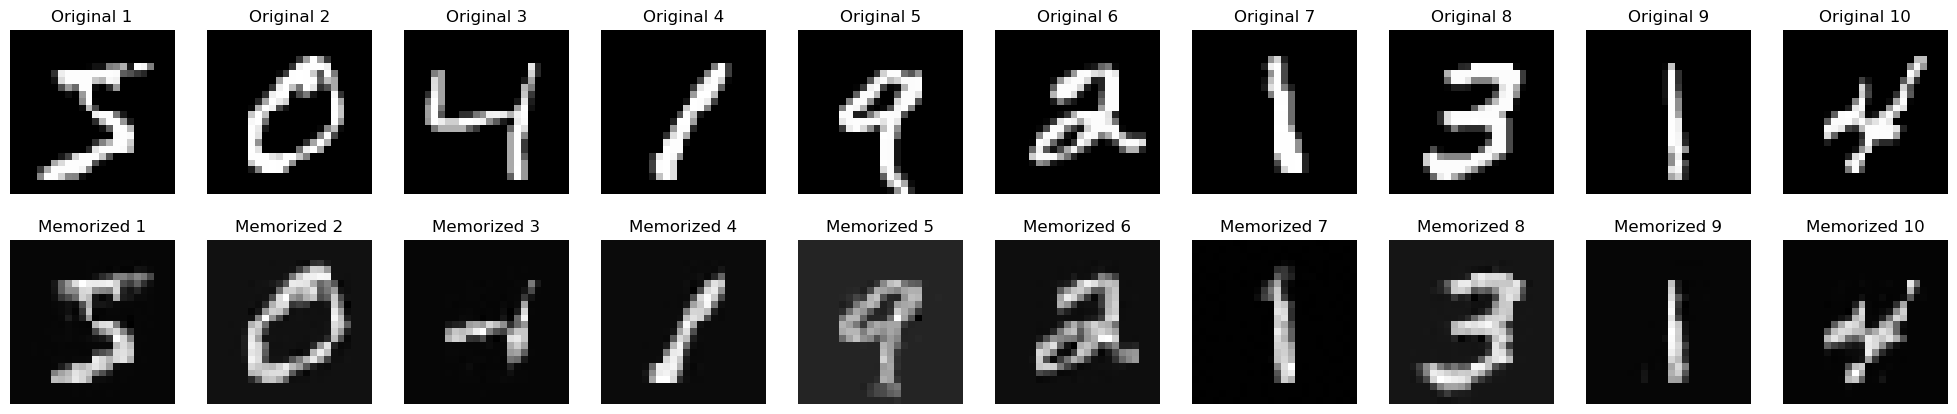

Epoch 178 | Train loss 0.000002 | Memorization loss 0.055775
Visualizing results at Epoch 179


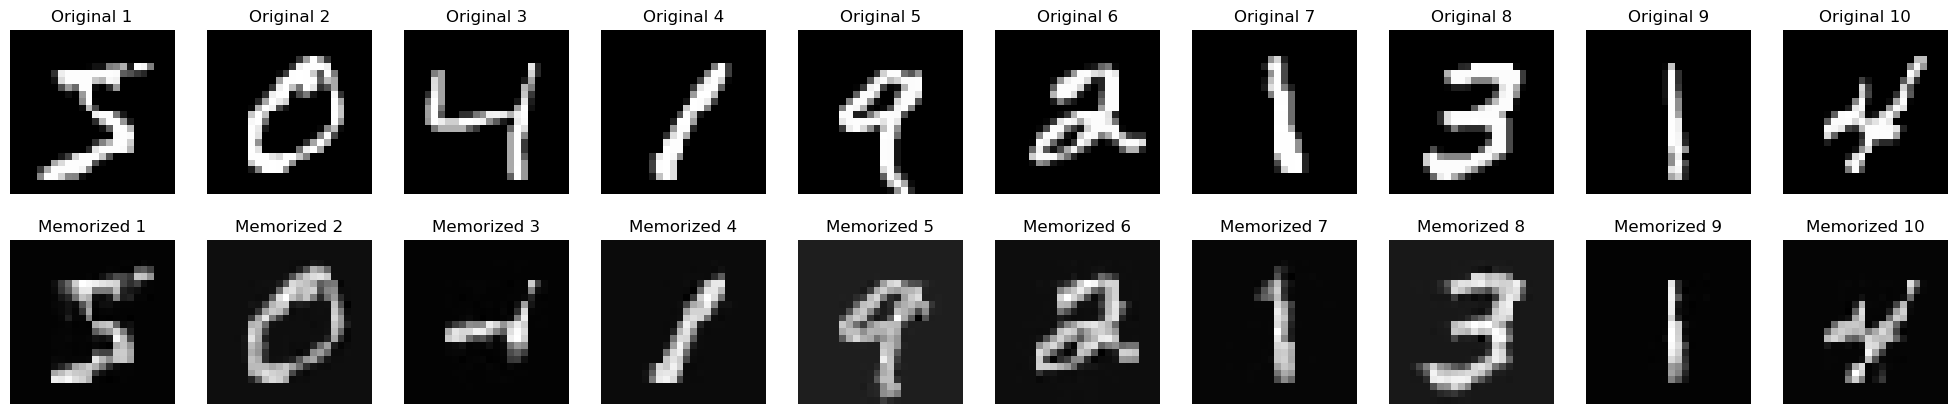

Epoch 179 | Train loss 0.000027 | Memorization loss 0.052487
Saved model and optimizer with memorization loss: 0.0525
Visualizing results at Epoch 180


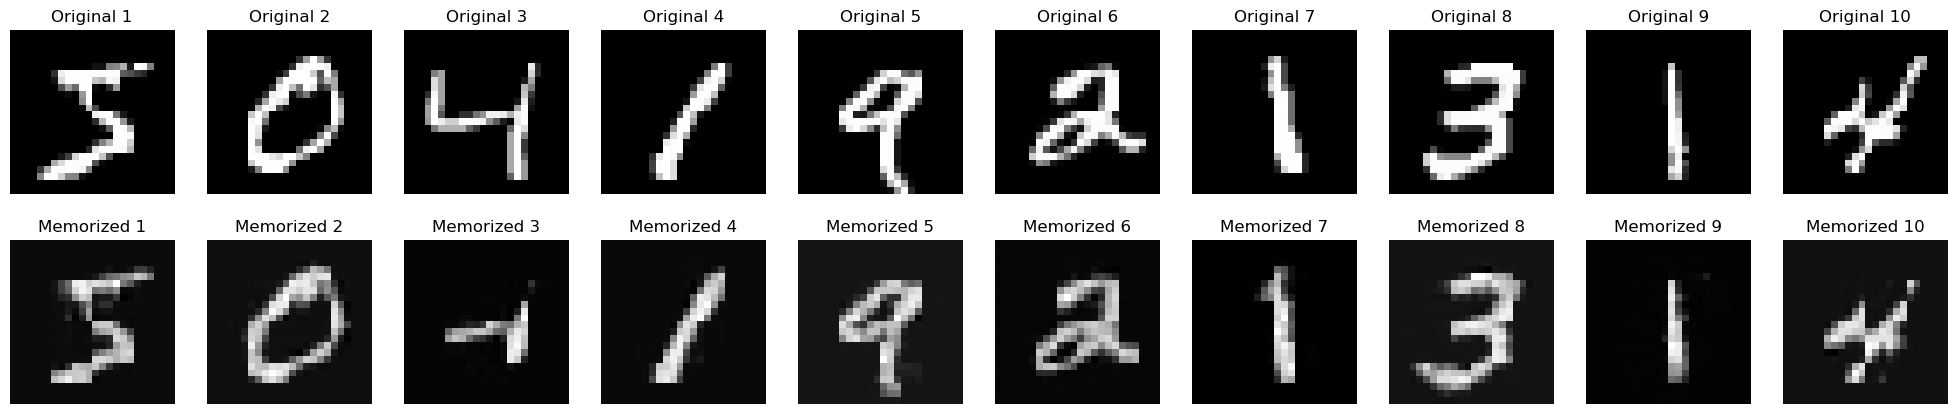

Epoch 180 | Train loss 0.000005 | Memorization loss 0.053172
Visualizing results at Epoch 181


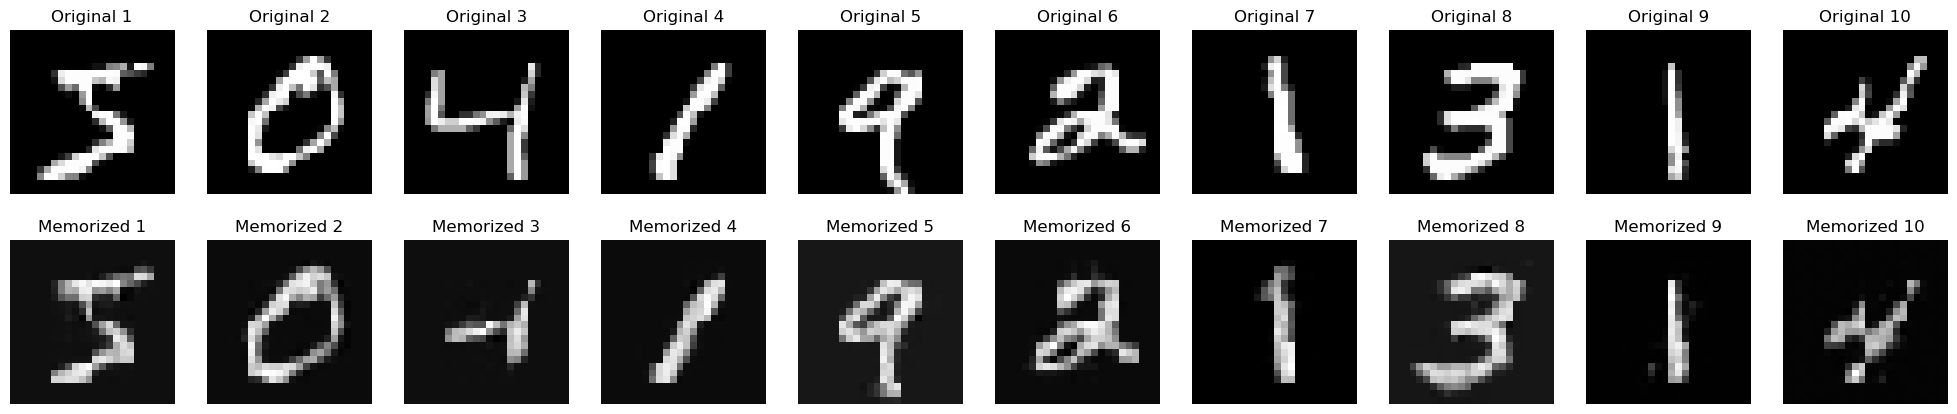

Epoch 181 | Train loss 0.000002 | Memorization loss 0.053184
Visualizing results at Epoch 182


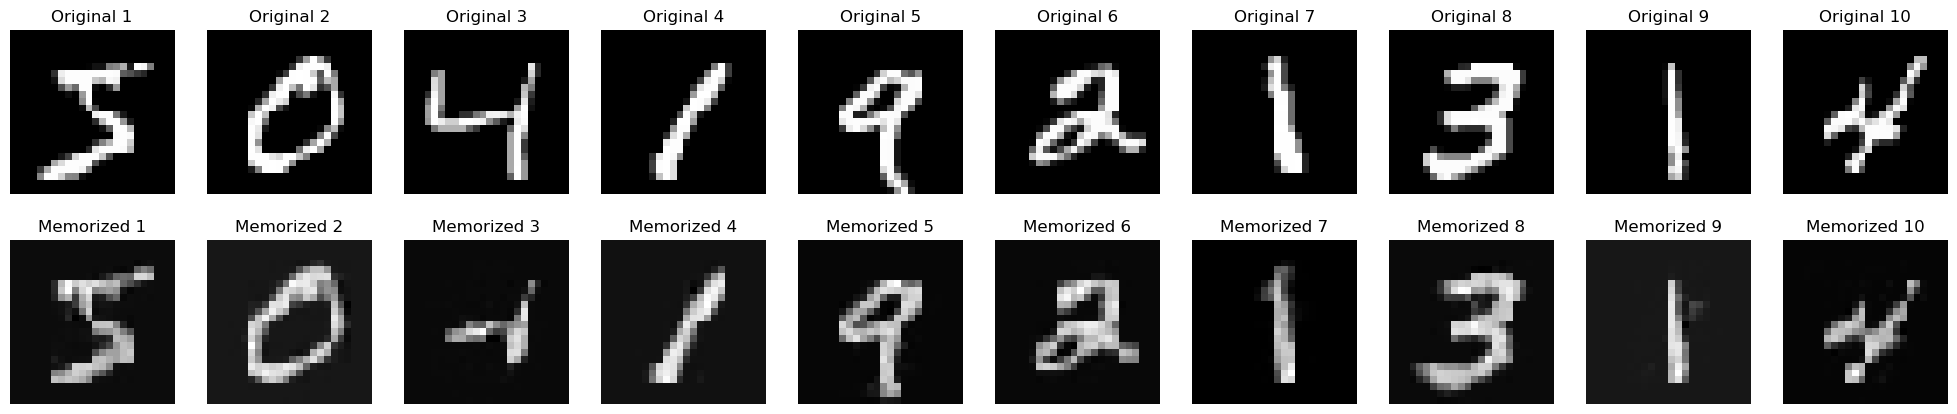

Epoch 182 | Train loss 0.000002 | Memorization loss 0.055853
Visualizing results at Epoch 183


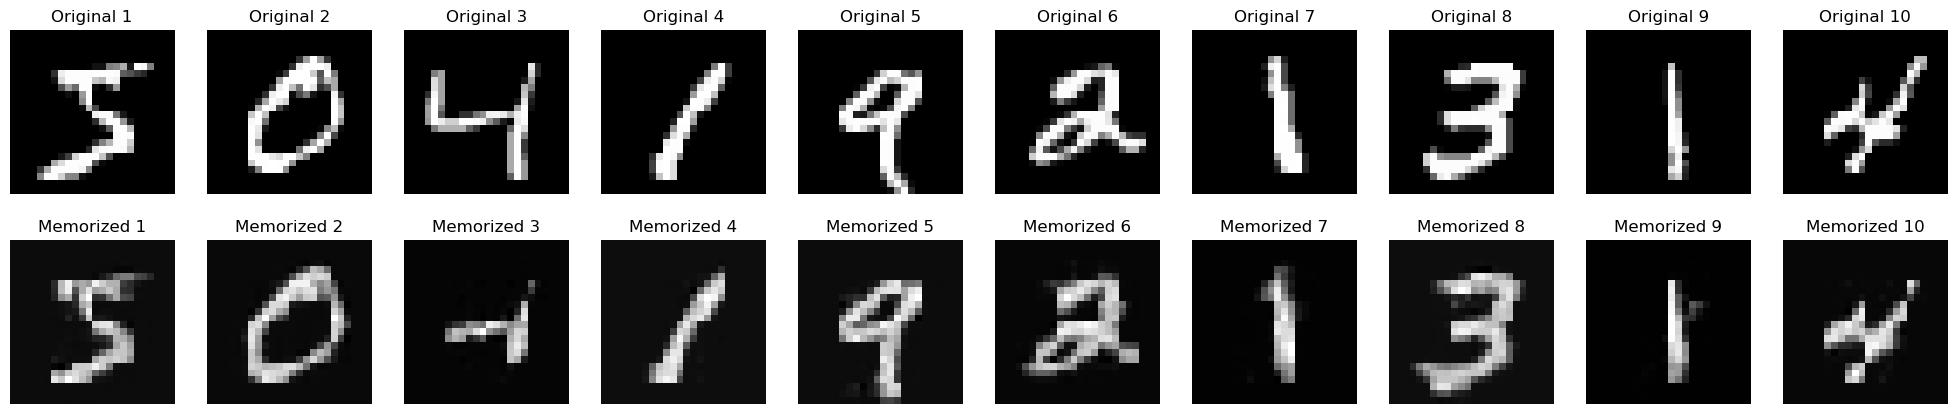

Epoch 183 | Train loss 0.000001 | Memorization loss 0.052690
Visualizing results at Epoch 184


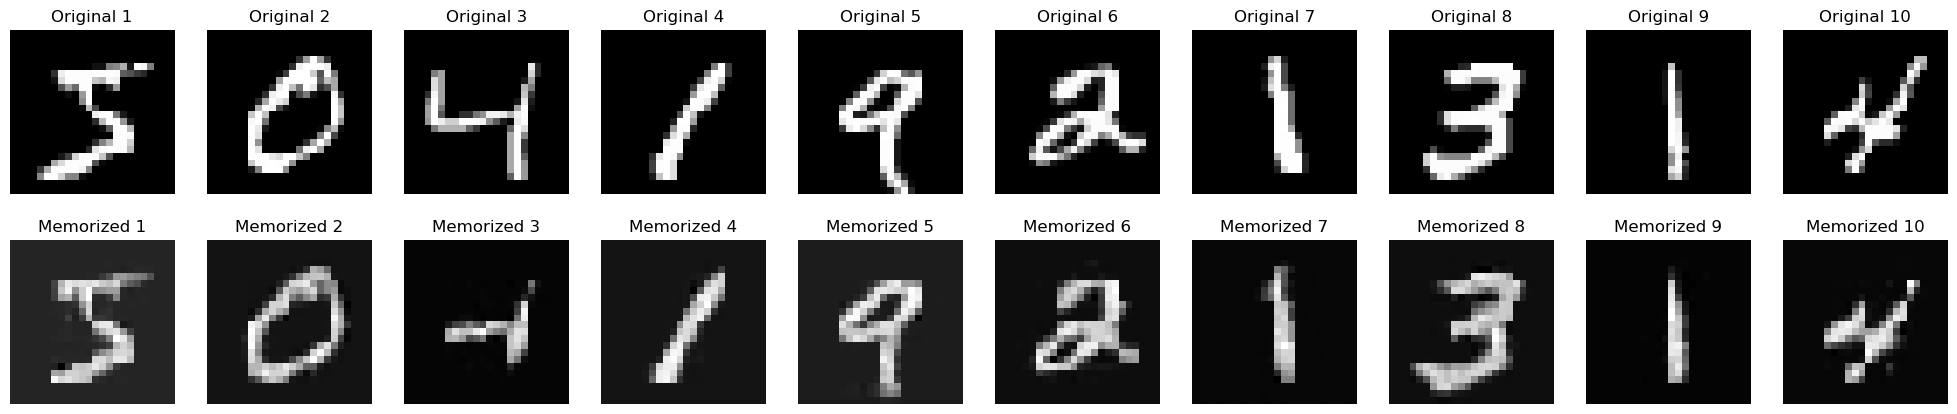

Epoch 184 | Train loss 0.000001 | Memorization loss 0.051123
Saved model and optimizer with memorization loss: 0.0511
Visualizing results at Epoch 185


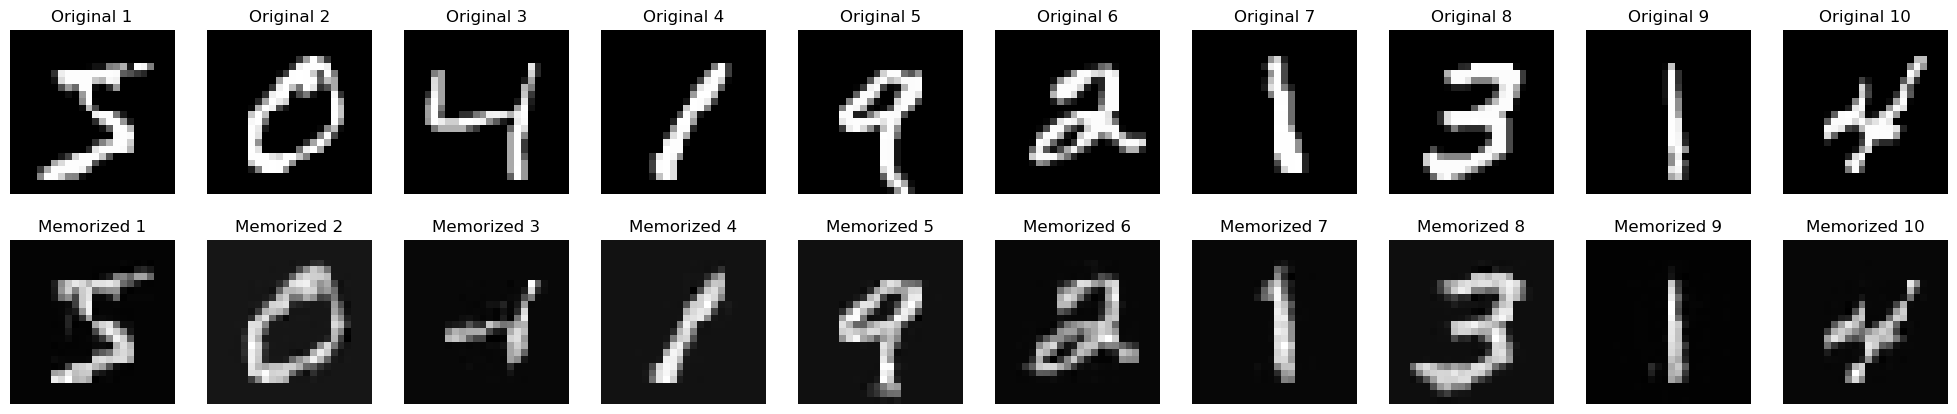

Epoch 185 | Train loss 0.000003 | Memorization loss 0.052130
Visualizing results at Epoch 186


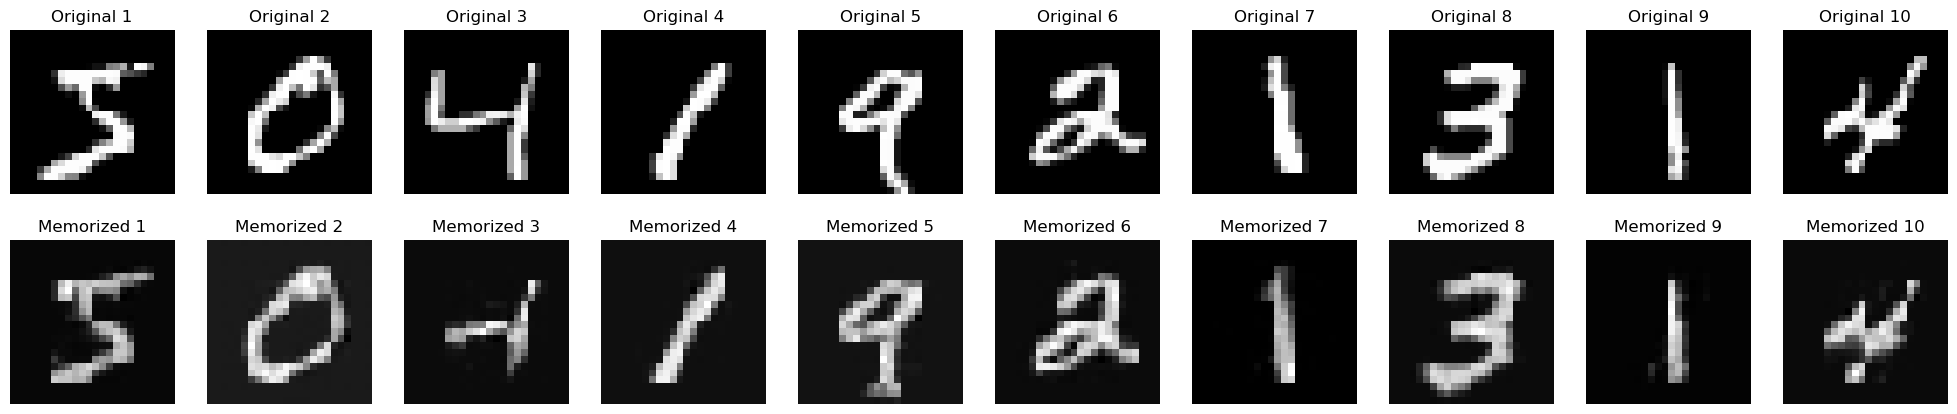

Epoch 186 | Train loss 0.000001 | Memorization loss 0.053408
Visualizing results at Epoch 187


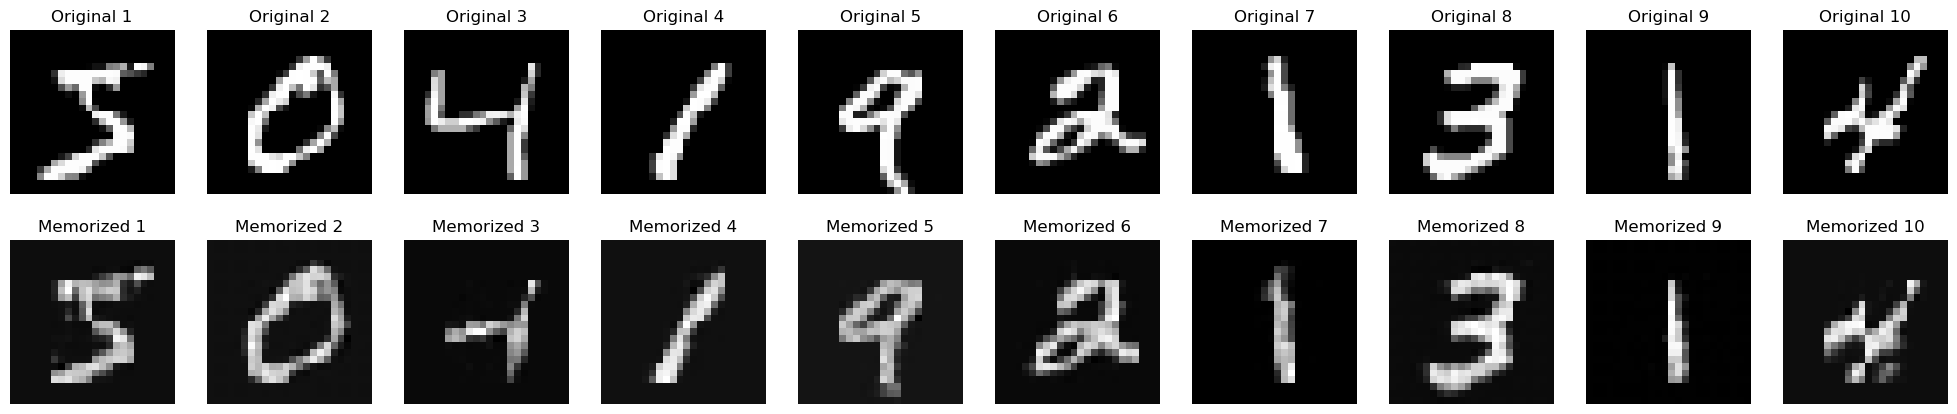

Epoch 187 | Train loss 0.000001 | Memorization loss 0.052768
Visualizing results at Epoch 188


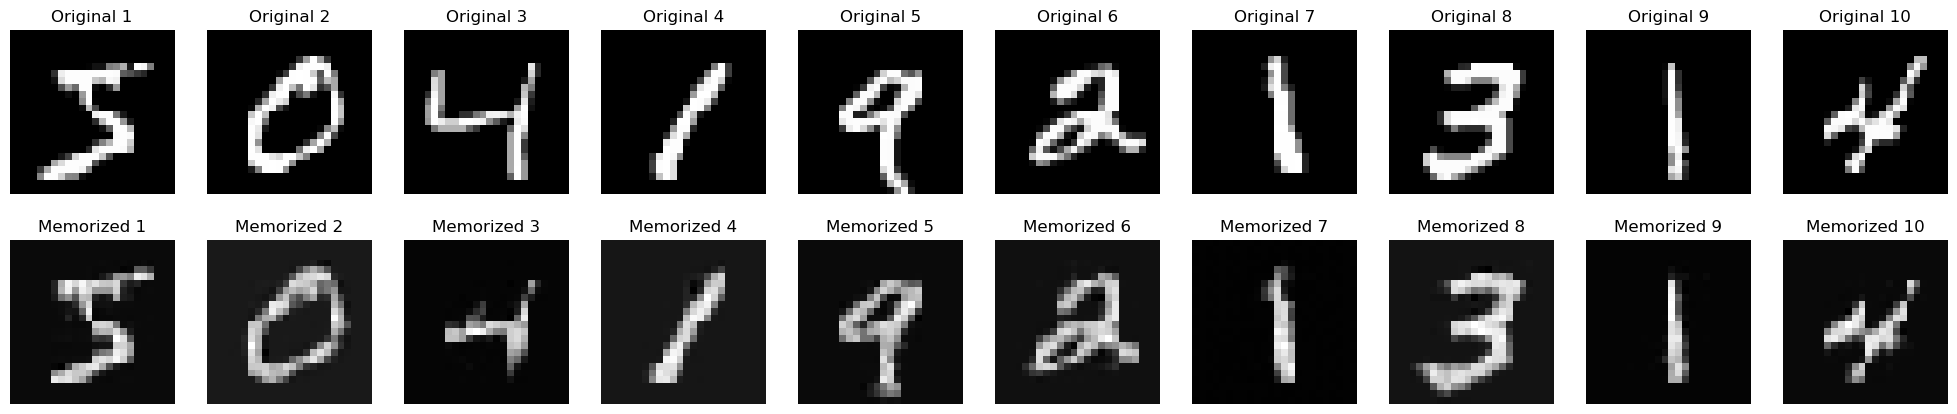

Epoch 188 | Train loss 0.000002 | Memorization loss 0.050505
Saved model and optimizer with memorization loss: 0.0505
Visualizing results at Epoch 189


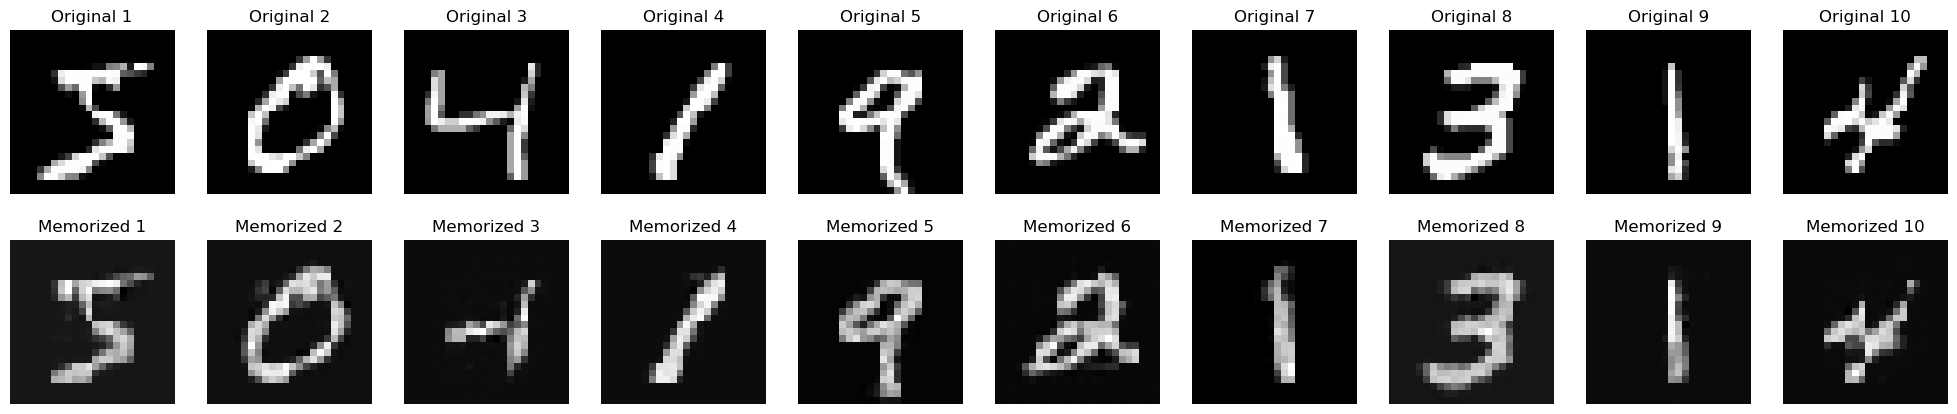

Epoch 189 | Train loss 0.000001 | Memorization loss 0.051881
Visualizing results at Epoch 190


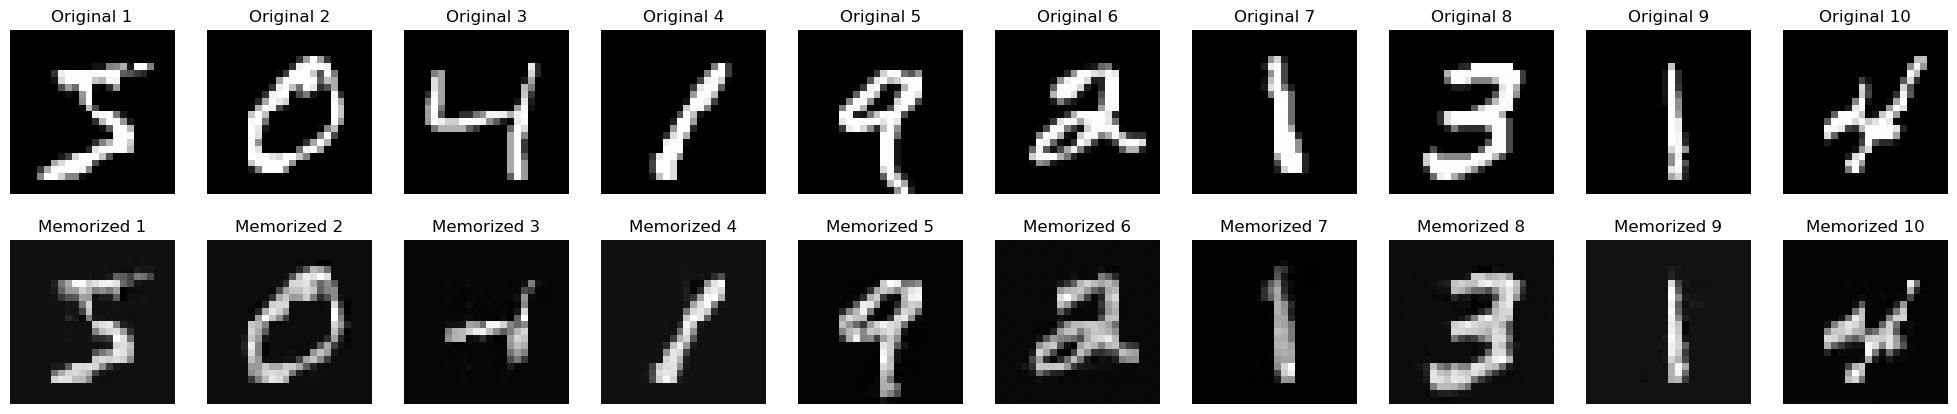

Epoch 190 | Train loss 0.000022 | Memorization loss 0.052573
Visualizing results at Epoch 191


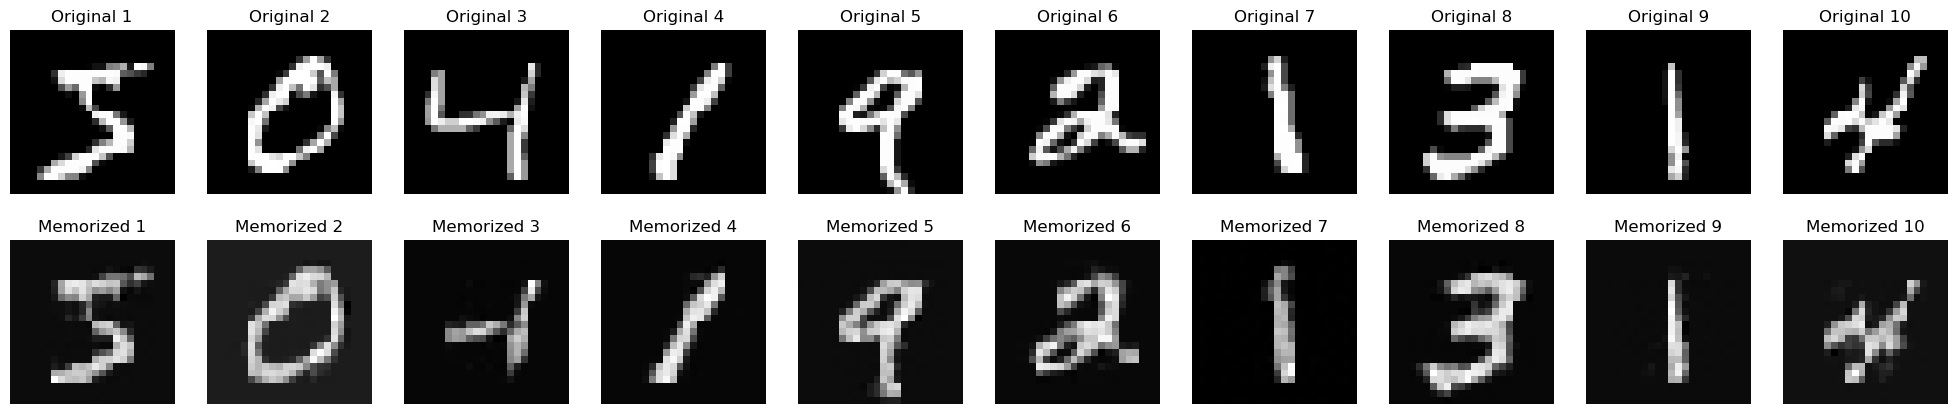

Epoch 191 | Train loss 0.000007 | Memorization loss 0.050883
Visualizing results at Epoch 192


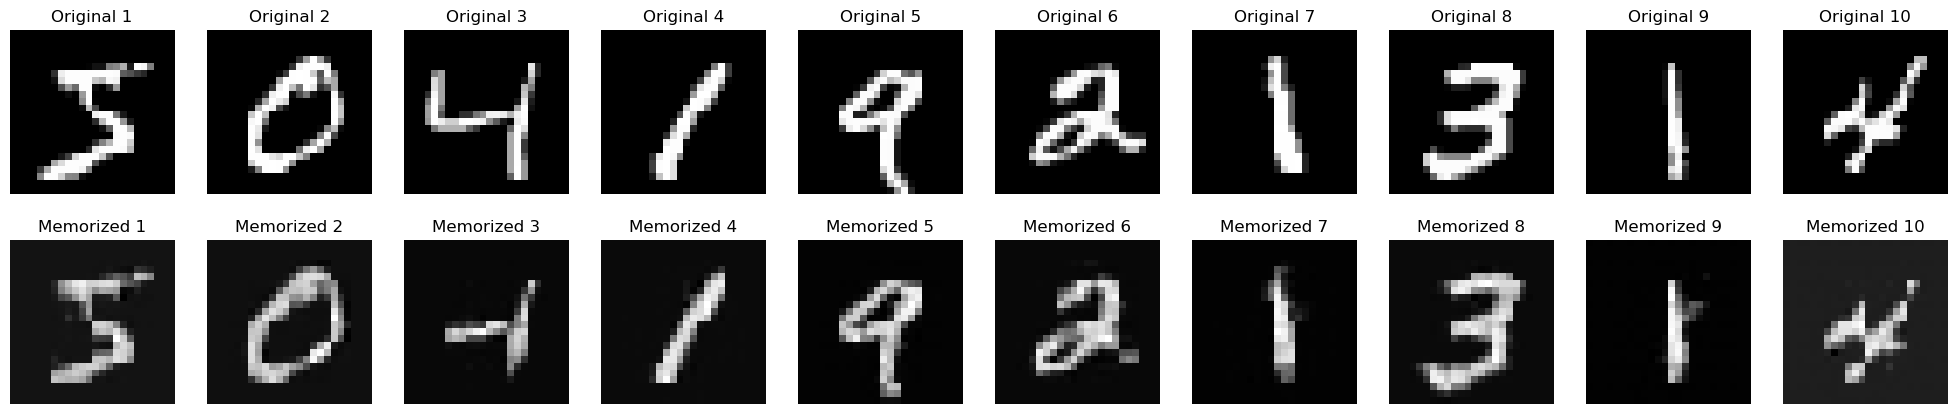

Epoch 192 | Train loss 0.000001 | Memorization loss 0.049596
Saved model and optimizer with memorization loss: 0.0496
Visualizing results at Epoch 193


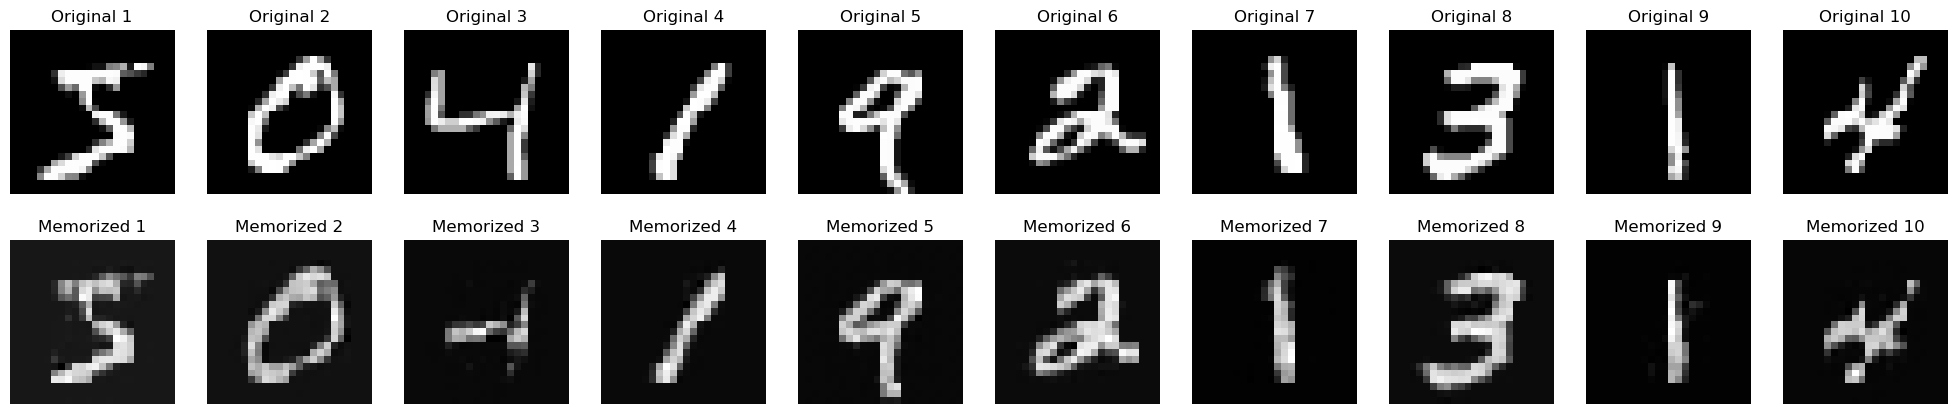

Epoch 193 | Train loss 0.000001 | Memorization loss 0.049486
Saved model and optimizer with memorization loss: 0.0495
Visualizing results at Epoch 194


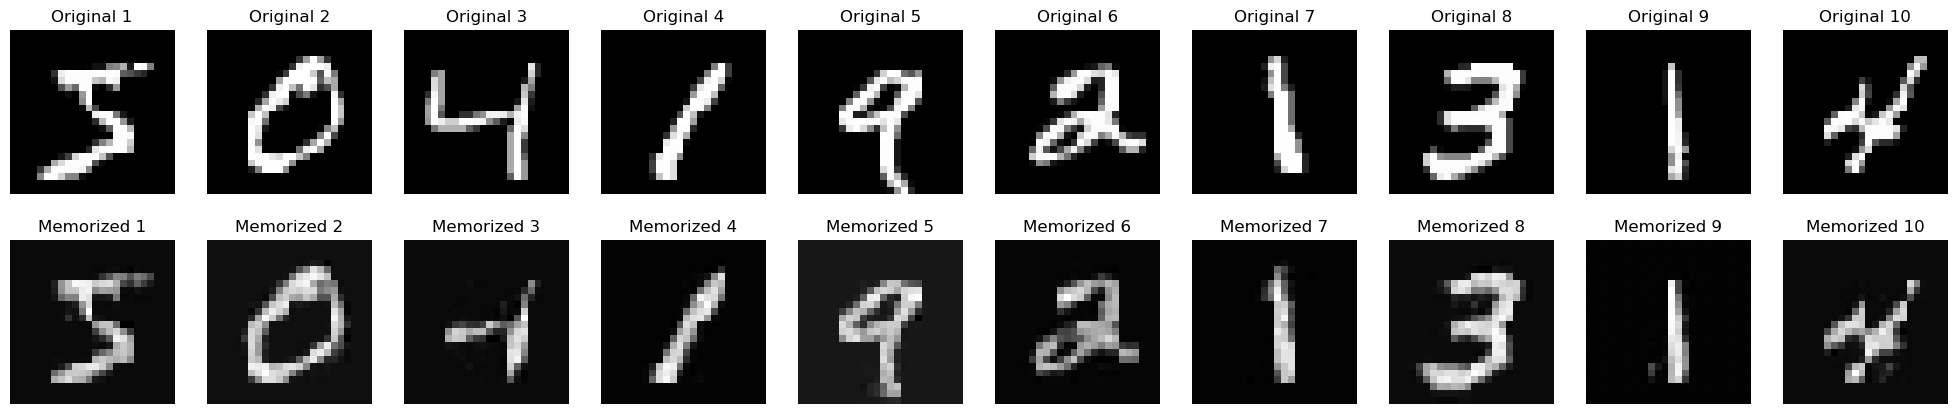

Epoch 194 | Train loss 0.000001 | Memorization loss 0.051210
Visualizing results at Epoch 195


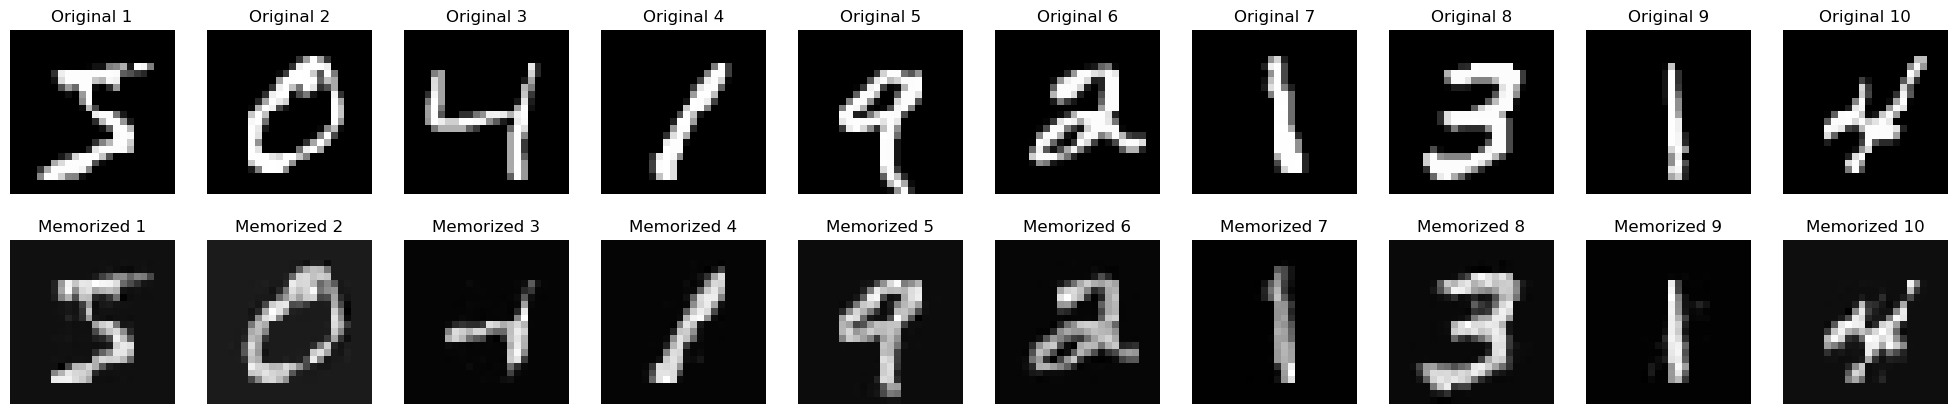

Epoch 195 | Train loss 0.000001 | Memorization loss 0.051027
Visualizing results at Epoch 196


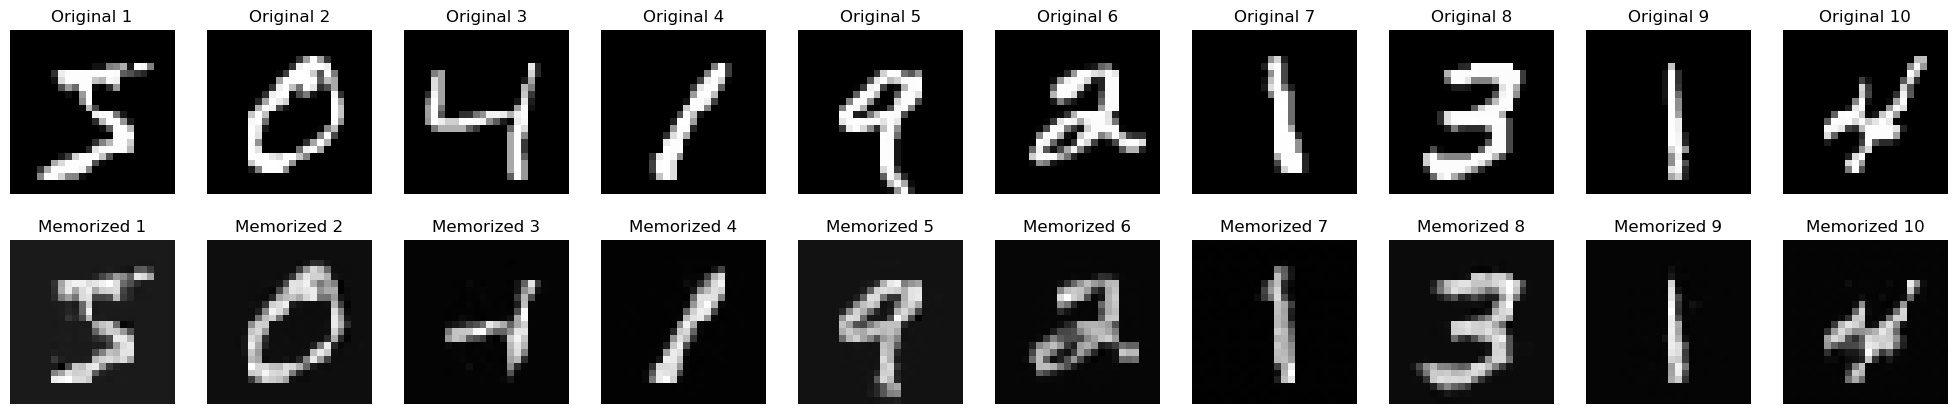

Epoch 196 | Train loss 0.000001 | Memorization loss 0.049504
Visualizing results at Epoch 197


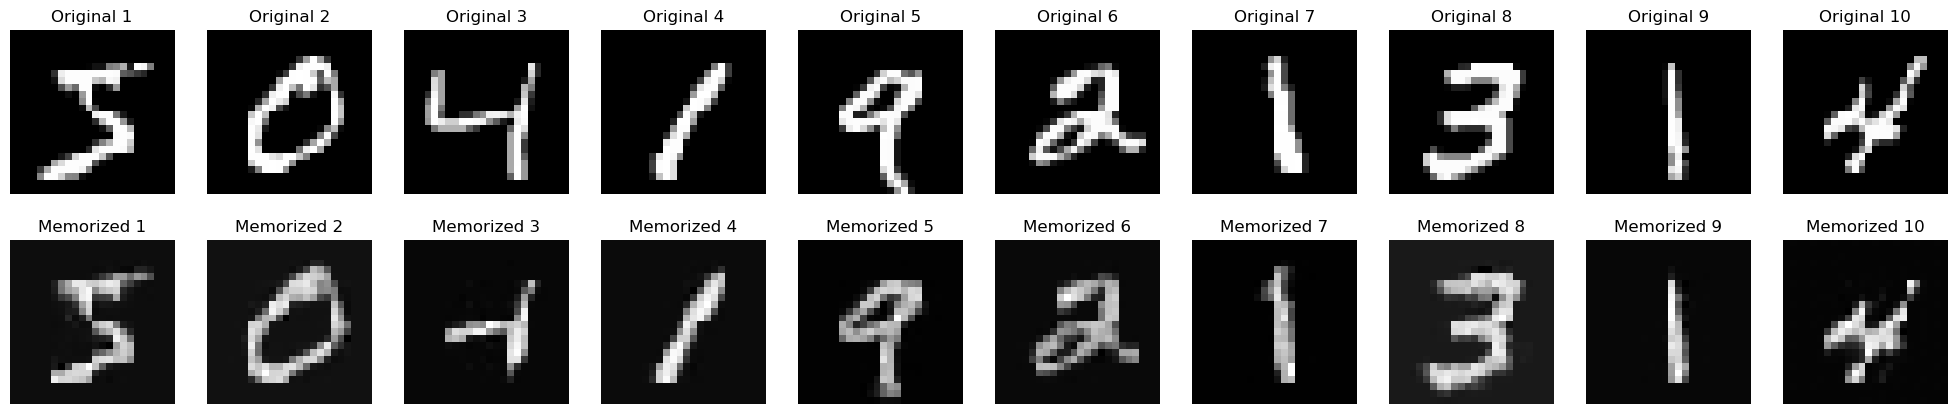

Epoch 197 | Train loss 0.000001 | Memorization loss 0.049230
Saved model and optimizer with memorization loss: 0.0492
Visualizing results at Epoch 198


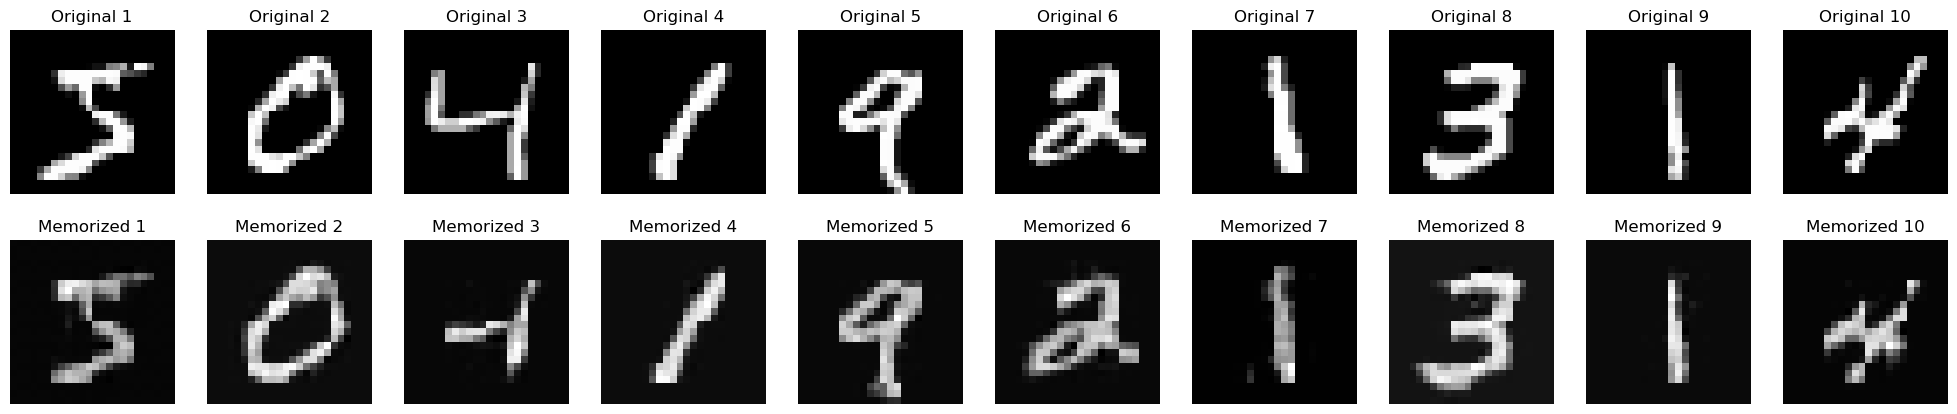

Epoch 198 | Train loss 0.000005 | Memorization loss 0.048938
Saved model and optimizer with memorization loss: 0.0489
Visualizing results at Epoch 199


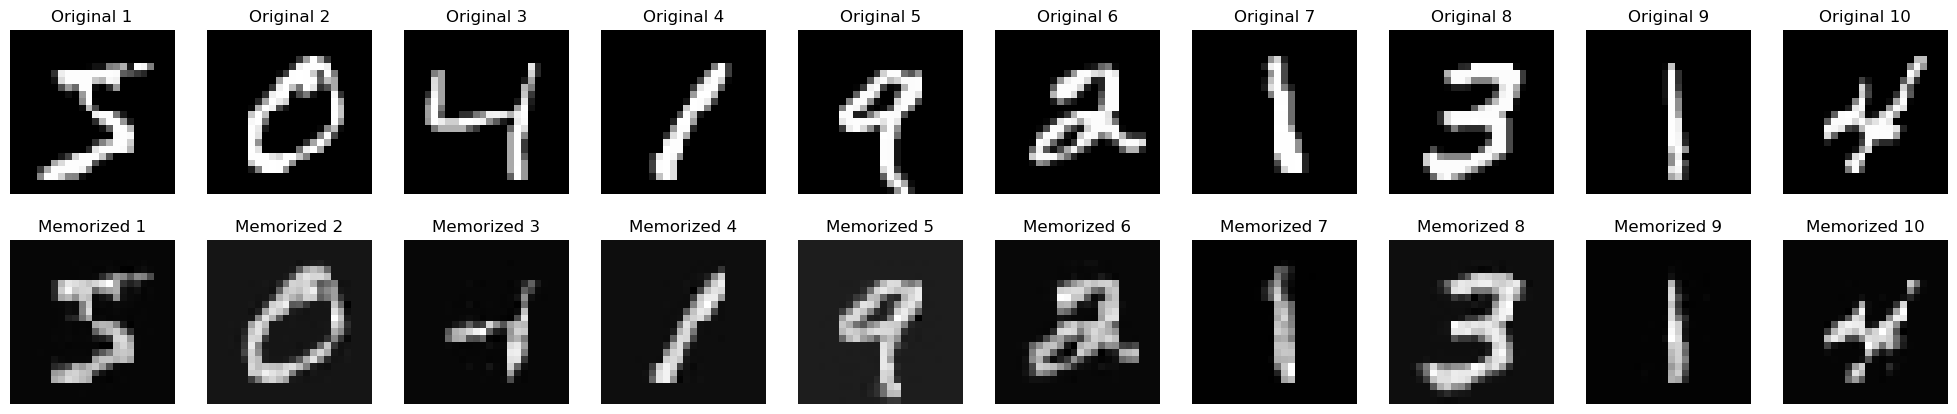

Epoch 199 | Train loss 0.000005 | Memorization loss 0.049935
Visualizing results at Epoch 200


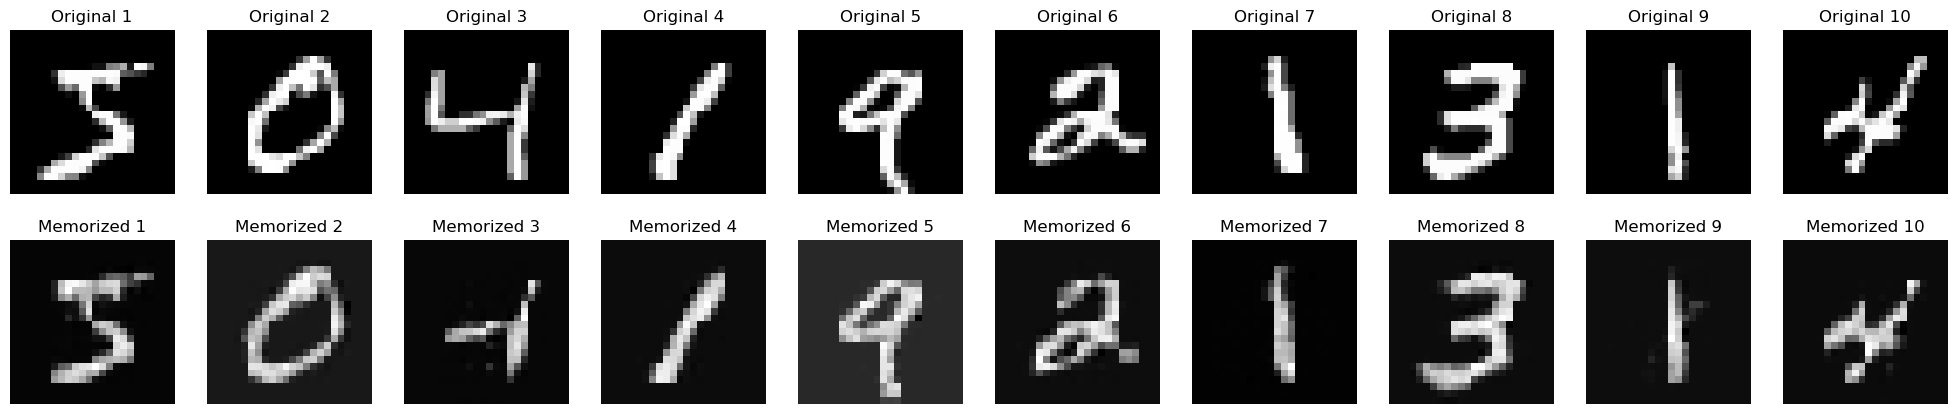

Total training time: 01:02:10 (hh:mm:ss)


In [ ]:
train(model, train_loader_cls, mem_dataloader, optimizer, 200, device)

In [ ]:
def load_model(model_path, model, optimizer, device):
    checkpoint = torch.load(model_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    model.to(device)
    return model, optimizer

In [ ]:
best_model, _ = load_model(MODEL_PATH, model, optimizer, device)

In [ ]:
def test_accuracy(model, data_loader, device):
    correct = 0
    total = 0
    model.eval()
    model.to(device)
    with torch.no_grad():
        for imgs, labels in data_loader:
            imgs = imgs.to(device)
            labels = labels.to(device)
            outputs = model(imgs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    return accuracy

In [ ]:
test_accuracy(best_model, test_loader_cls , device)

0.9778

In [ ]:
def generate_reconstructed_images_and_labels(model, device, mem_dataset):
    num_samples = int(MNIST_SAMPLE_PERCENTAGE * TRAIN_DATASET_LEN)

    reconstructed_images = []
    original_images = []
    labels = []

    for idx in range(num_samples):
        output, target_image = get_image(idx, model,device)
        reconstructed_images.append(output.to(device))
        original_images.append(target_image.to(device))

        one_hot_label_region = mem_dataset.class_codes[idx]
        label = one_hot_label_region.argmax().item()
        labels.append(label)

    reconstructed_images = torch.stack(reconstructed_images)
    original_images = torch.stack(original_images)

    # Normalize the original images to [0, 1]
    original_images = original_images.float() / 255.0
    # Clamp the reconstructed images to [0, 1] to remove any negative values
    reconstructed_images = torch.clamp(reconstructed_images, 0, 1)
    labels = torch.tensor(labels, device=device)

    return reconstructed_images, original_images, labels

In [ ]:
# ssim token from GitHub - https://github.com/Po-Hsun-Su/pytorch-ssim/blob/master/pytorch_ssim/__init__.py
import torch
import torch.nn.functional as F

WINDOW_SIZE = 3

def gaussian(window_size, sigma):
    gauss = torch.tensor([-(x - window_size // 2) ** 2 / float(2 * sigma ** 2) for x in range(window_size)])
    gauss = torch.exp(gauss)
    return gauss / gauss.sum()


def create_window(window_size, channel):
    _1D_window = gaussian(window_size, 1.5).unsqueeze(1)
    _2D_window = _1D_window.mm(_1D_window.t()).float().unsqueeze(0).unsqueeze(0)
    window = _2D_window.expand(channel, 1, window_size, window_size).contiguous()
    return window

def _ssim(img1, img2, window, window_size, channel, size_average=True):
    mu1 = F.conv2d(img1, window, padding=window_size // 2, groups=channel)
    mu2 = F.conv2d(img2, window, padding=window_size // 2, groups=channel)

    mu1_sq = mu1.pow(2)
    mu2_sq = mu2.pow(2)
    mu1_mu2 = mu1 * mu2

    sigma1_sq = F.conv2d(img1 * img1, window, padding=window_size // 2, groups=channel) - mu1_sq
    sigma2_sq = F.conv2d(img2 * img2, window, padding=window_size // 2, groups=channel) - mu2_sq
    sigma12 = F.conv2d(img1 * img2, window, padding=window_size // 2, groups=channel) - mu1_mu2

    C1 = 0.01 ** 2
    C2 = 0.03 ** 2

    ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) * (sigma1_sq + sigma2_sq + C2))

    if size_average:
        return ssim_map.mean()
    else:
        return ssim_map.mean(1).mean(1).mean(1)

def ssim(img1, img2, window_size=WINDOW_SIZE, size_average=True):
    (_, channel, _, _) = img1.size()
    window = create_window(window_size, channel)
    window = window.to(img1.device)
    return _ssim(img1, img2, window, window_size, channel, size_average)

# add this function

def calculate_ssim_for_batches(reconstructed_images, original_images, window_size=WINDOW_SIZE):
    if reconstructed_images.dim() == 3:  # Add channel dimension if not present
        reconstructed_images = reconstructed_images.unsqueeze(1)
    if original_images.dim() == 3:  # Add channel dimension if not present
        original_images = original_images.unsqueeze(1)

    device = original_images.device
    channel = original_images.size(1)
    window = create_window(window_size, channel).to(device)
    window = window.to(device)

    # Calculate SSIM for each image in the batch
    ssim_scores = _ssim(reconstructed_images, original_images, window, window_size, channel, size_average=False)
    return ssim_scores, ssim_scores.mean().item()


In [ ]:
# Generate reconstructed images and original images
reconstructed_images, original_images, labels = generate_reconstructed_images_and_labels(best_model, device, mem_dataset)

# Calculate SSIM values for the batches
ssim_values, average_ssim = calculate_ssim_for_batches(reconstructed_images, original_images)

# Print SSIM values and the average SSIM
print(f'SSIM values: {ssim_values}')
print(ssim_values.shape)
print(f'Average SSIM: {average_ssim}')

SSIM values: tensor([0.8969, 0.9360, 0.7977,  ..., 0.8662, 0.9108, 0.9021])
torch.Size([4000])
Average SSIM: 0.8898850679397583


In [ ]:
from torch.nn.functional import mse_loss
mse_value = mse_loss(reconstructed_images, original_images)
mse_value

tensor(0.0129)

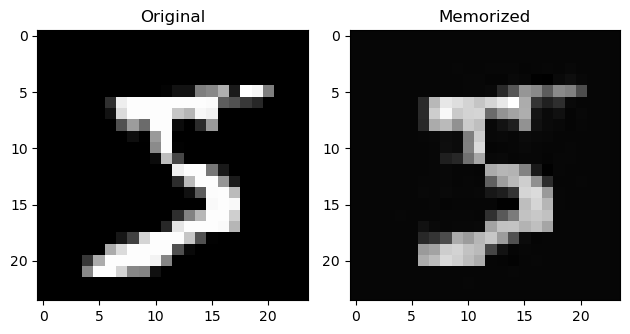

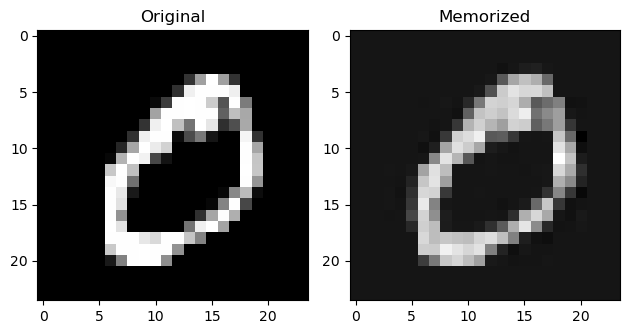

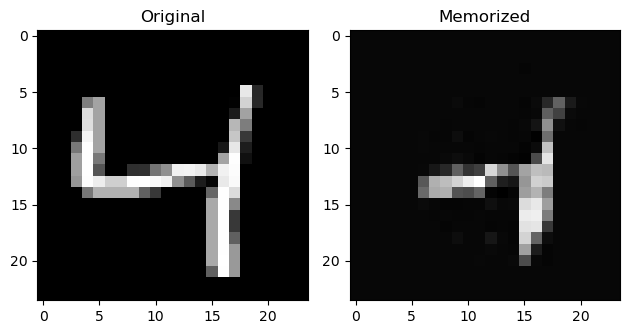

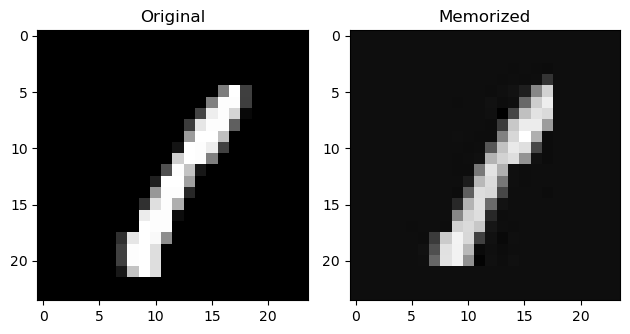

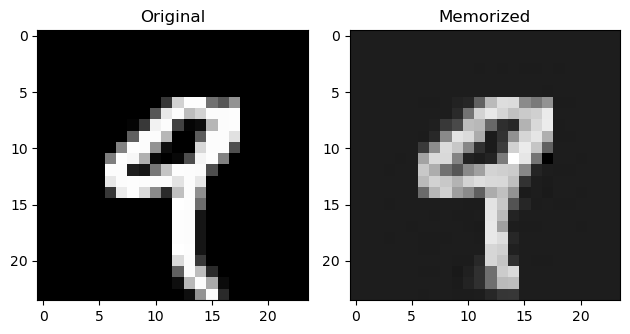

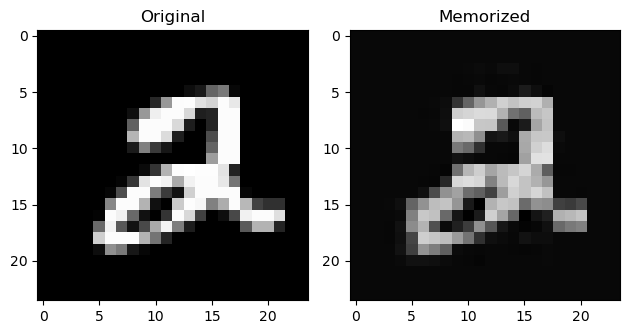

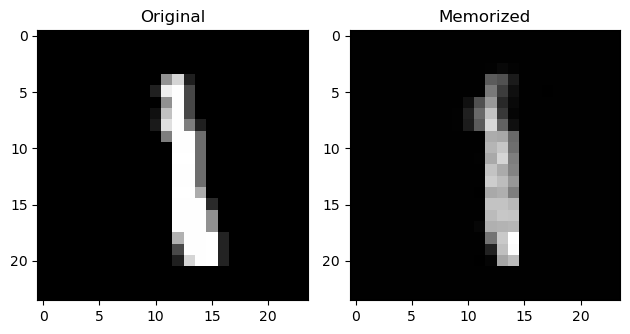

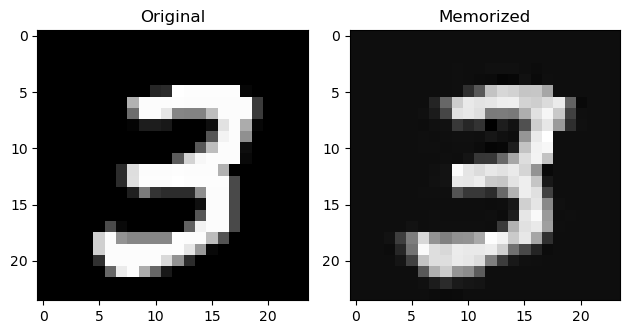

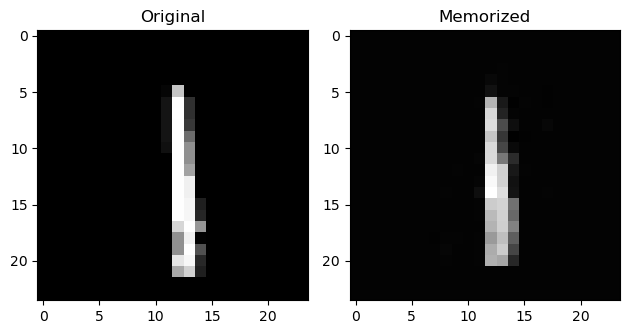

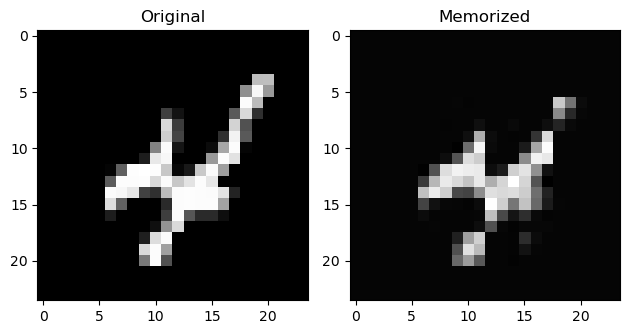

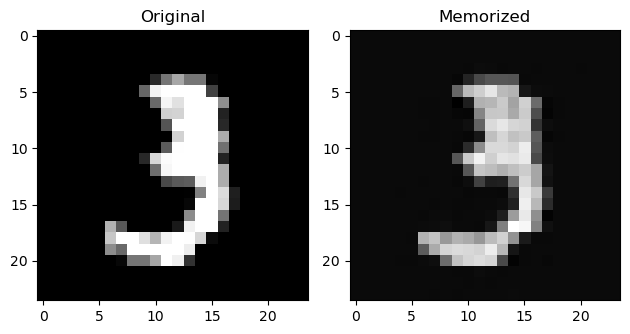

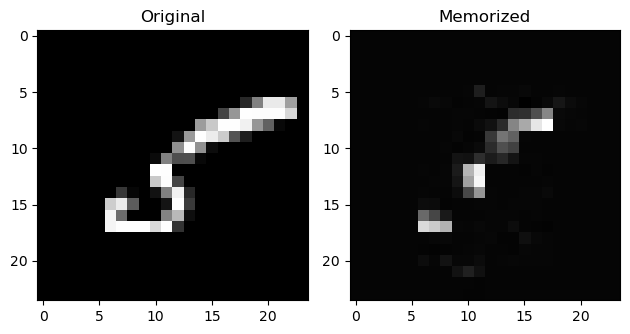

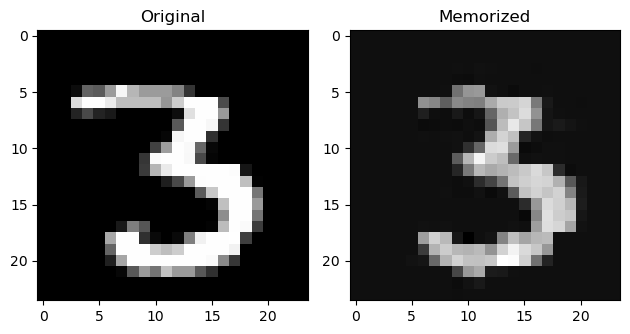

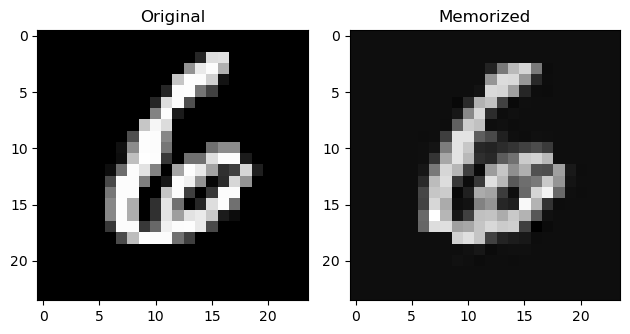

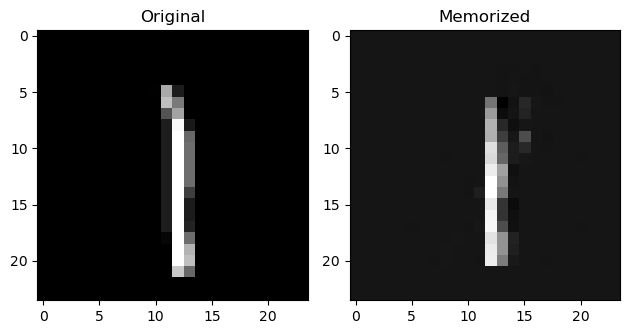

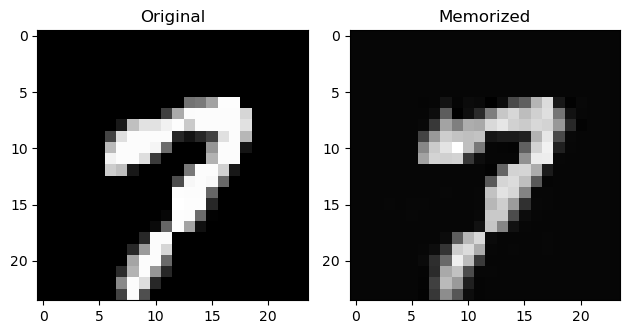

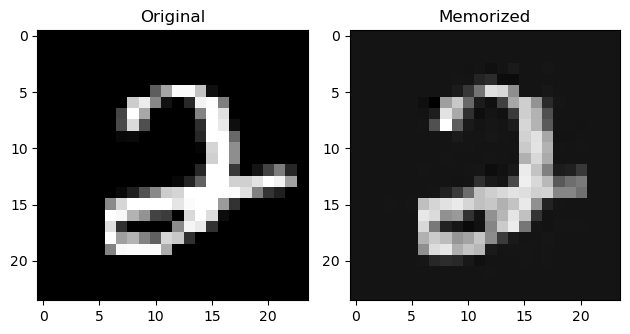

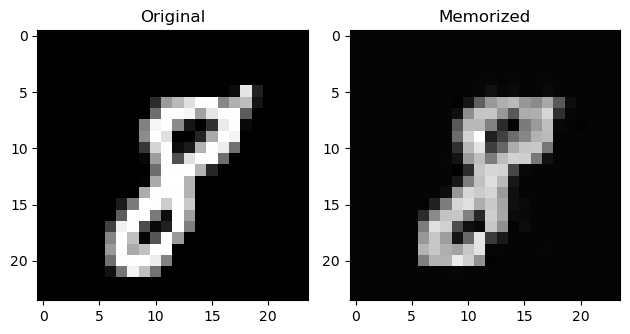

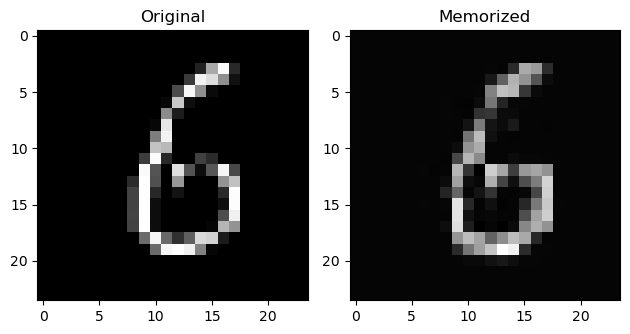

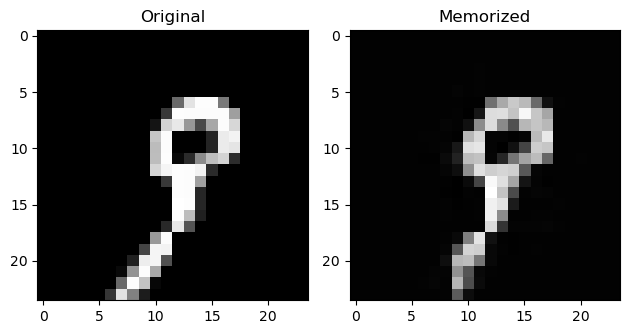

In [ ]:
# Loop over a range of indices (in this case, the first 20 indices) in the dataset.
for idx in range(20):
    # For each index, use the get_image function to generate the memorized (output) image
    # and retrieve the original target image.
    output, target_image = get_image(idx, best_model,device)

    # Create a new figure and a set of subplots. There will be two subplots: one for the original
    # image and one for the memorized image.
    fig, ax = plt.subplots(ncols=2, tight_layout=True)

    # Display the original target image in the first subplot.
    ax[0].imshow(target_image, cmap='gray')
    ax[0].set_title('Original')

    # Display the memorized (output) image in the second subplot.
    ax[1].imshow(output, cmap='gray')
    ax[1].set_title('Memorized')

    # Display the figure with the two subplots.
    plt.show()